# --PRELIMINARY KNOWLEDGE--

- The chapters for each temporal-spatial resolution have the same sub-chapters and ordering

- The chapter for hourly census and hourly hexagon have to be executed before daily hexagon and daily census, due to the fact that the replacement of census tracts and hexagons depends on dictionaries which get generated in the hourly chapters. Otherwise an error will be encountered in the subchapters 'Problem: Hexagon/ Census Tract with few observations' and subsequent subchapters

- For each temporal-spatial resolution, the feature creation happens in this notebook. the resulting datasets are exported as CSV in the subchapter 'Features to CSV' and are then used for SVM model building

- Within each chapter for the temporal-spatial resolutions, the order of the subchapters represent the order of code execution

- Some data stems from external CSV files. Usually, those are indicated through their path starting with "data/". These can be accessed through our Google Drive shared folder. 

- I created many keras model files throughout training and tuning. Anytime such a path is used in this notebook, the code will fail to run for other person who execute this notebook. You would have to generate your own model files accordingly. This would also mean to go trough each modelling task step by step rather than trying to execute all cells at once. I left cell outputs in this notebook so the steps can be understood without execution.

- In order to execute modelling steps for standardized outputs, one needs to include the following code into a cell for each temporal-spatial resolution at the end of the 'Preprocessing' subchapter, just before the 'Validations' subchapter begins:

    #Z-Standardization Example for Daily Hexagon (dh) data:
    
    y_train_dh_mean = y_train_dh.mean()
    y_train_dh_std = y_train_dh.std()

    y_train_dh = y_train_dh - y_train_dh_mean
    y_train_dh = y_train_dh / y_train_dh_std

    y_test_dh = y_test_dh - y_train_dh_mean
    y_test_dh = y_test_dh / y_train_dh_std

    y_val_dh = y_val_dh - y_train_dh_mean
    y_val_dh = y_val_dh / y_train_dh_std

- if the standard requirements.txt is not sufficient or some imports fail, please refer back to the requirements_neural_network.txt file for a specification of the environment used for this file (it will entail much more libraries than used here)

# Imports and Functions

In [1]:
import pandas as pd
import numpy as np
import numpy as np
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
import keras_tuner
import keras as ks

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
pd.set_option('display.max_columns', None)

In [4]:
def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

# External Data

## Holidays

In [5]:
holidays = [
    {"date": "2023-01-01", "name": "New Years"},
    {"date": "2023-01-02", "name": "New Years 2"},
    {"date": "2023-05-29", "name": "Memorial"},
    {"date": "2023-06-19", "name": "Juneteenth National Independence Day"},
    {"date": "2023-07-04", "name": "Independence Day"},
    {"date": "2023-09-04", "name": "Labor Day"},
    {"date": "2023-11-10", "name": "Veterans Day"},
    {"date": "2023-11-11", "name": "Veterans Day 2"},
    {"date": "2023-11-23", "name": "Thanksgiving"},
    {"date": "2023-12-25", "name": "Christmas Day"},
    {"date": "2023-01-16", "name": "Martin Luther King Jr. Day"},
    {"date": "2023-02-20", "name": "Washington's Birthday"},
    {"date": "2023-10-09", "name": "Columbus Day"},
    {"date": "2023-02-12", "name": "Lincoln's Birthday"},
    {"date": "2023-02-13", "name": "Lincoln's Birthday (observed)"},
    {"date": "2023-03-06", "name": "Casimir Pulaski Day"}
]

In [6]:
holiday_df = pd.DataFrame(holidays)

In [7]:
holiday_df['date'] = pd.to_datetime(holiday_df['date']).dt.date

In [8]:
holiday_df

date                                  name
0   2023-01-01                             New Years
1   2023-01-02                           New Years 2
2   2023-05-29                              Memorial
3   2023-06-19  Juneteenth National Independence Day
4   2023-07-04                      Independence Day
5   2023-09-04                             Labor Day
6   2023-11-10                          Veterans Day
7   2023-11-11                        Veterans Day 2
8   2023-11-23                          Thanksgiving
9   2023-12-25                         Christmas Day
10  2023-01-16            Martin Luther King Jr. Day
11  2023-02-20                 Washington's Birthday
12  2023-10-09                          Columbus Day
13  2023-02-12                    Lincoln's Birthday
14  2023-02-13         Lincoln's Birthday (observed)
15  2023-03-06                   Casimir Pulaski Day

## Sports

In [9]:
# List of Chicago Bulls home games for the 2023 season. opponent data is wrong but also irrelevant
bulls_home_games_23 = [
    {"date": "2023-10-12", "opponent": "OKC Thunder", "time": "7:00 PM"},
    {"date": "2023-10-17", "opponent": "Toronto Raptors", "time": "7:00 PM"},
    {"date": "2023-11-19", "opponent": "Brooklyn Nets", "time": "7:00 PM"},
    {"date": "2023-10-25", "opponent": "OKC Thunder", "time": "7:00 PM"},
    {"date": "2023-10-27", "opponent": "Toronto Raptors", "time": "7:00 PM"},
    {"date": "2023-11-03", "opponent": "Brooklyn Nets", "time": "7:00 PM"},
    {"date": "2023-11-06", "opponent": "Utah Jazz", "time": "7:00 PM"},
    {"date": "2023-11-08", "opponent": "Phoenix Suns", "time": "7:00 PM"},
    {"date": "2023-11-12", "opponent": "Detroit Pistons", "time": "6:00 PM"},
    {"date": "2023-11-15", "opponent": "Orlando Magic", "time": "7:00 PM"},
    {"date": "2023-11-17", "opponent": "Orlando Magic", "time": "7:00 PM"},
    {"date": "2023-11-18", "opponent": "Miami Heat", "time": "7:00 PM"},
    {"date": "2023-11-20", "opponent": "Miami Heat", "time": "7:00 PM"},
    {"date": "2023-11-30", "opponent": "Milwaukee Bucks", "time": "7:00 PM"},
    {"date": "2023-12-02", "opponent": "New Orleans Pelicans", "time": "7:00 PM"},
    {"date": "2023-12-06", "opponent": "Denver Nuggets", "time": "7:00 PM"},
    {"date": "2023-12-12", "opponent": "Denver Nuggets", "time": "7:00 PM"},
    {"date": "2023-12-20", "opponent": "Los Angeles Lakers", "time": "7:00 PM"},
    {"date": "2023-12-21", "opponent": "San Antonio Spurs", "time": "7:00 PM"},
    {"date": "2023-12-23", "opponent": "Cleveland Cavaliers", "time": "7:00 PM"},
    {"date": "2023-12-26", "opponent": "Atlanta Hawks", "time": "7:00 PM"},
    {"date": "2023-12-28", "opponent": "Indiana Pacers", "time": "7:00 PM"},
    {"date": "2023-12-30", "opponent": "Philadelphia 76ers", "time": "7:00 PM"},
    {"date": "2023-01-04", "opponent": "Golden State Warriors", "time": "7:00 PM"},
    {"date": "2023-01-07", "opponent": "Brooklyn Nets", "time": "7:00 PM"},
    {"date": "2023-01-13", "opponent": "Indiana Pacers", "time": "7:00 PM"},
    {"date": "2023-01-15", "opponent": "Oklahoma City Thunder", "time": "2:30 PM"},
    {"date": "2023-01-23", "opponent": "Golden State Warriors", "time": "7:00 PM"},
    {"date": "2023-01-31", "opponent": "Los Angeles Clippers", "time": "7:00 PM"},
    {"date": "2023-02-02", "opponent": "Portland Trail Blazers", "time": "7:00 PM"},
    {"date": "2023-02-04", "opponent": "Portland Trail Blazers", "time": "7:00 PM"},
    {"date": "2023-02-06", "opponent": "San Antonio Spurs", "time": "7:00 PM"},
    {"date": "2023-02-13", "opponent": "Brooklyn Nets", "time": "7:00 PM"},
    {"date": "2023-02-16", "opponent": "Brooklyn Nets", "time": "6:30 PM"},
    {"date": "2023-02-24", "opponent": "Brooklyn Nets", "time": "7:00 PM"},
    {"date": "2023-02-26", "opponent": "Washington Wizards", "time": "2:30 PM"},
    {"date": "2023-03-03", "opponent": "Detroit Pistons", "time": "7:00 PM"},
    {"date": "2023-03-05", "opponent": "Indiana Pacers", "time": "2:30 PM"},
    {"date": "2023-03-15", "opponent": "Minnesota Timberwolves", "time": "7:00 PM"},
    {"date": "2023-03-17", "opponent": "Miami Heat", "time": "7:00 PM"},
    {"date": "2023-03-18", "opponent": "Philadelphia 76ers", "time": "7:00 PM"},
    {"date": "2023-03-22", "opponent": "Portland Trail Blazers", "time": "7:00 PM"},
    {"date": "2023-03-29", "opponent": "Los Angeles Lakers", "time": "7:00 PM"},
    {"date": "2023-04-02", "opponent": "Atlanta Hawks", "time": "2:30 PM"},
    {"date": "2023-04-04", "opponent": "Atlanta Hawks", "time": "7:00 PM"},
    {"date": "2023-04-09", "opponent": "Milwaukee Bucks", "time": "12:00 PM"}
]

In [10]:
# List of Chicago White Sox home games for the 2023 season
white_sox_home_games_23 = [
    {"date": "2023-04-03", "opponent": "San Francisco Giants", "time": "3:10 PM"},
    {"date": "2023-04-05", "opponent": "San Francisco Giants", "time": "1:10 PM"},
    {"date": "2023-04-06", "opponent": "San Francisco Giants", "time": "1:10 PM"},
    {"date": "2023-04-14", "opponent": "Baltimore Orioles", "time": "6:10 PM"},
    {"date": "2023-04-15", "opponent": "Baltimore Orioles", "time": "1:10 PM"},
    {"date": "2023-04-16", "opponent": "Baltimore Orioles", "time": "1:10 PM"},
    {"date": "2023-04-17", "opponent": "Tampa Bay Rays", "time": "6:10 PM"},
    {"date": "2023-04-18", "opponent": "Tampa Bay Rays", "time": "6:10 PM"},
    {"date": "2023-04-19", "opponent": "Tampa Bay Rays", "time": "1:10 PM"},
    {"date": "2023-04-27", "opponent": "Tampa Bay Rays", "time": "6:10 PM"},
    {"date": "2023-04-28", "opponent": "Tampa Bay Rays", "time": "6:10 PM"},
    {"date": "2023-04-29", "opponent": "Tampa Bay Rays", "time": "6:10 PM"},
    {"date": "2023-04-30", "opponent": "Tampa Bay Rays", "time": "1:10 PM"},
    {"date": "2023-05-02", "opponent": "Minnesota Twins", "time": "6:10 PM"},
    {"date": "2023-05-03", "opponent": "Minnesota Twins", "time": "6:10 PM"},
    {"date": "2023-05-04", "opponent": "Minnesota Twins", "time": "1:10 PM"},
    {"date": "2023-05-12", "opponent": "Houston Astros", "time": "7:10 PM"},
    {"date": "2023-05-13", "opponent": "Houston Astros", "time": "6:15 PM"},
    {"date": "2023-05-14", "opponent": "Houston Astros", "time": "1:10 PM"},
    {"date": "2023-05-16", "opponent": "Cleveland Guardians", "time": "7:10 PM"},
    {"date": "2023-05-17", "opponent": "Cleveland Guardians", "time": "7:10 PM"},
    {"date": "2023-05-18", "opponent": "Cleveland Guardians", "time": "1:10 PM"},
    {"date": "2023-05-19", "opponent": "Kansas City Royals", "time": "7:10 PM"},
    {"date": "2023-05-20", "opponent": "Kansas City Royals", "time": "1:10 PM"},
    {"date": "2023-05-21", "opponent": "Kansas City Royals", "time": "1:10 PM"},
    {"date": "2023-05-29", "opponent": "Los Angeles Angels", "time": "7:10 PM"},
    {"date": "2023-05-30", "opponent": "Los Angeles Angels", "time": "7:10 PM"},
    {"date": "2023-05-31", "opponent": "Los Angeles Angels", "time": "1:10 PM"},
    {"date": "2023-06-02", "opponent": "Detroit Tigers", "time": "7:10 PM"},
    {"date": "2023-06-03", "opponent": "Detroit Tigers", "time": "1:10 PM"},
    {"date": "2023-06-04", "opponent": "Detroit Tigers", "time": "1:10 PM"},
    {"date": "2023-06-09", "opponent": "Miami Marlins", "time": "7:10 PM"},
    {"date": "2023-06-10", "opponent": "Miami Marlins", "time": "1:10 PM"},
    {"date": "2023-06-11", "opponent": "Miami Marlins", "time": "1:10 PM"},
    {"date": "2023-06-19", "opponent": "Texas Rangers", "time": "7:10 PM"},
    {"date": "2023-06-20", "opponent": "Boston Red Sox", "time": "7:10 PM"},
    {"date": "2023-06-21", "opponent": "Boston Red Sox", "time": "7:10 PM"},
    {"date": "2023-06-23", "opponent": "Seattle Mariners", "time": "7:10 PM"},
    {"date": "2023-06-24", "opponent": "Seattle Mariners", "time": "3:10 PM"},
    {"date": "2023-06-25", "opponent": "Seattle Mariners", "time": "1:10 PM"},
    {"date": "2023-07-04", "opponent": "Toronto Blue Jays", "time": "7:10 PM"},
    {"date": "2023-07-05", "opponent": "Toronto Blue Jays", "time": "7:10 PM"},
    {"date": "2023-07-06", "opponent": "Toronto Blue Jays", "time": "7:10 PM"},
    {"date": "2023-07-07", "opponent": "Toronto Blue Jays", "time": "7:10 PM"},
    {"date": "2023-07-08", "opponent": "Toronto Blue Jays", "time": "1:10 PM"},
    {"date": "2023-07-09", "opponent": "Toronto Blue Jays", "time": "1:10 PM"},
    {"date": "2023-07-25", "opponent": "Chicago Cubs", "time": "7:10 PM"},
    {"date": "2023-07-26", "opponent": "Chicago Cubs", "time": "7:10 PM"},
    {"date": "2023-07-27", "opponent": "Cleveland Guardians", "time": "7:10 PM"},
    {"date": "2023-07-28", "opponent": "Cleveland Guardians", "time": "6:10 PM"},
    {"date": "2023-07-29", "opponent": "Cleveland Guardians", "time": "6:10 PM"},
    {"date": "2023-07-30", "opponent": "Cleveland Guardians", "time": "1:10 PM"},
    {"date": "2023-08-07", "opponent": "New York Yankees", "time": "7:10 PM"},
    {"date": "2023-08-08", "opponent": "New York Yankees", "time": "7:10 PM"},
    {"date": "2023-08-09", "opponent": "New York Yankees", "time": "7:10 PM"},
    {"date": "2023-08-11", "opponent": "Milwaukee Brewers", "time": "7:10 PM"},
    {"date": "2023-08-12", "opponent": "Milwaukee Brewers", "time": "6:15 PM"},
    {"date": "2023-08-13", "opponent": "Milwaukee Brewers", "time": "1:10 PM"},
    {"date": "2023-08-21", "opponent": "Seattle Mariners", "time": "7:10 PM"},
    {"date": "2023-08-22", "opponent": "Seattle Mariners", "time": "7:10 PM"},
    {"date": "2023-08-23", "opponent": "Seattle Mariners", "time": "1:10 PM"},
    {"date": "2023-08-24", "opponent": "Oakland Athletics", "time": "7:10 PM"},
    {"date": "2023-08-25", "opponent": "Oakland Athletics", "time": "6:10 PM"},
    {"date": "2023-08-26", "opponent": "Oakland Athletics", "time": "6:10 PM"},
    {"date": "2023-08-27", "opponent": "Oakland Athletics", "time": "1:10 PM"},
    {"date": "2023-09-01", "opponent": "Detroit Tigers", "time": "7:10 PM"},
    {"date": "2023-09-02", "opponent": "Detroit Tigers", "time": "6:10 PM"},
    {"date": "2023-09-03", "opponent": "Detroit Tigers", "time": "1:10 PM"},
    {"date": "2023-09-11", "opponent": "Kansas City Royals", "time": "6:40 PM"},
    {"date": "2023-09-12", "opponent": "Minnesota Twins", "time": "6:40 PM"},
    {"date": "2023-09-13", "opponent": "Minnesota Twins", "time": "6:40 PM"},
    {"date": "2023-09-14", "opponent": "Minnesota Twins", "time": "6:10 PM"},
    {"date": "2023-09-15", "opponent": "Minnesota Twins", "time": "6:40 PM"},
    {"date": "2023-09-16", "opponent": "Minnesota Twins", "time": "6:10 PM"},
    {"date": "2023-09-17", "opponent": "Minnesota Twins", "time": "1:10 PM"},
    {"date": "2023-09-25", "opponent": "Minnesota Twins", "time": "6:40 PM"},
    {"date": "2023-09-26", "opponent": "Arizona Diamondbacks", "time": "6:40 PM"},
    {"date": "2023-09-27", "opponent": "Arizona Diamondbacks", "time": "1:10 PM"},
    {"date": "2023-09-29", "opponent": "Arizona Diamondbacks", "time": "6:40 PM"},
    {"date": "2023-09-30", "opponent": "Arizona Diamondbacks", "time": "6:10 PM"},
    {"date": "2023-10-01", "opponent": "Arizona Diamondbacks", "time": "2:10 PM"},


]

In [11]:
# List of Chicago Cubs home games for the 2023 season. opponent data is wrong but also irrelevant
cubs_home_games_23 = [
    {"date": "2023-03-30", "opponent": "Texas Rangers", "time": "1:20 PM"},
    {"date": "2023-04-01", "opponent": "Texas Rangers", "time": "1:20 PM"},
    {"date": "2023-04-02", "opponent": "Texas Rangers", "time": "1:20 PM"},
    {"date": "2023-04-07", "opponent": "Texas Rangers", "time": "1:20 PM"},
    {"date": "2023-04-08", "opponent": "Texas Rangers", "time": "3:05 PM"},
    {"date": "2023-04-09", "opponent": "Texas Rangers", "time": "1:20 PM"},
    {"date": "2023-04-10", "opponent": "Seattle Mariners", "time": "6:40 PM"},
    {"date": "2023-04-11", "opponent": "Seattle Mariners", "time": "6:40 PM"},
    {"date": "2023-04-12", "opponent": "Seattle Mariners", "time": "1:20 PM"},
    {"date": "2023-04-20", "opponent": "Los Angeles Dodgers", "time": "6:40 PM"},
    {"date": "2023-04-21", "opponent": "Los Angeles Dodgers", "time": "1:20 PM"},
    {"date": "2023-04-22", "opponent": "Los Angeles Dodgers", "time": "1:20 PM"},
    {"date": "2023-04-23", "opponent": "Los Angeles Dodgers", "time": "1:20 PM"},
    {"date": "2023-04-25", "opponent": "San Diego Padres", "time": "6:40 PM"},
    {"date": "2023-04-26", "opponent": "San Diego Padres", "time": "6:40 PM"},
    {"date": "2023-04-27", "opponent": "San Diego Padres", "time": "1:20 PM"},
    {"date": "2023-05-05", "opponent": "Miami Marlins", "time": "1:20 PM"},
    {"date": "2023-05-06", "opponent": "Miami Marlins", "time": "1:20 PM"},
    {"date": "2023-05-07", "opponent": "Miami Marlins", "time": "1:20 PM"},
    {"date": "2023-05-08", "opponent": "St. Louis Cardinals", "time": "6:40 PM"},
    {"date": "2023-05-09", "opponent": "St. Louis Cardinals", "time": "6:40 PM"},
    {"date": "2023-05-10", "opponent": "St. Louis Cardinals", "time": "6:40 PM"},
    {"date": "2023-05-23", "opponent": "Cincinnati Reds", "time": "6:40 PM"},
    {"date": "2023-05-24", "opponent": "Cincinnati Reds", "time": "6:40 PM"},
    {"date": "2023-05-25", "opponent": "Cincinnati Reds", "time": "6:40 PM"},
    {"date": "2023-05-26", "opponent": "New York Mets", "time": "1:20 PM"},
    {"date": "2023-05-27", "opponent": "New York Mets", "time": "6:15 PM"},
    {"date": "2023-05-28", "opponent": "New York Mets", "time": "1:20 PM"},
    {"date": "2023-05-29", "opponent": "New York Mets", "time": "1:20 PM"},
    {"date": "2023-05-30", "opponent": "New York Mets", "time": "7:05 PM"},
    {"date": "2023-05-31", "opponent": "New York Mets", "time": "1:20 PM"},
    {"date": "2023-06-13", "opponent": "Pittsburgh Pirates", "time": "7:05 PM"},
    {"date": "2023-06-14", "opponent": "Pittsburgh Pirates", "time": "7:05 PM"},
    {"date": "2023-06-15", "opponent": "Pittsburgh Pirates", "time": "7:05 PM"},
    {"date": "2023-06-16", "opponent": "Baltimore Orioles", "time": "1:20 PM"},
    {"date": "2023-06-17", "opponent": "Baltimore Orioles", "time": "1:20 PM"},
    {"date": "2023-06-18", "opponent": "Baltimore Orioles", "time": "12:05 PM"},
    {"date": "2023-06-27", "opponent": "Baltimore Orioles", "time": "7:05 PM"},
    {"date": "2023-06-28", "opponent": "Baltimore Orioles", "time": "7:05 PM"},
    {"date": "2023-06-29", "opponent": "Baltimore Orioles", "time": "7:05 PM"},
    {"date": "2023-06-30", "opponent": "Cleveland Guardians", "time": "1:20 PM"},
    {"date": "2023-07-01", "opponent": "Cleveland Guardians", "time": "6:15 PM"},
    {"date": "2023-07-02", "opponent": "Cleveland Guardians", "time": "1:20 PM"},
    {"date": "2023-07-14", "opponent": "Boston Red Sox", "time": "7:05 PM"},
    {"date": "2023-07-15", "opponent": "Boston Red Sox", "time": "1:20 PM"},
    {"date": "2023-07-16", "opponent": "Boston Red Sox", "time": "1:20 PM"},
    {"date": "2023-07-17", "opponent": "Washington Nationals", "time": "7:05 PM"},
    {"date": "2023-07-18", "opponent": "Washington Nationals", "time": "7:05 PM"},
    {"date": "2023-07-19", "opponent": "Washington Nationals", "time": "7:05 PM"},
    {"date": "2023-07-20", "opponent": "St. Louis Cardinals", "time": "7:05 PM"},
    {"date": "2023-07-21", "opponent": "St. Louis Cardinals", "time": "1:20 PM"},
    {"date": "2023-07-22", "opponent": "St. Louis Cardinals", "time": "1:20 PM"},
    {"date": "2023-07-23", "opponent": "St. Louis Cardinals", "time": "1:20 PM"},
    {"date": "2023-07-31", "opponent": "St. Louis Cardinals", "time": "7:05 PM"},
    {"date": "2023-08-01", "opponent": "Cincinnati Reds", "time": "7:05 PM"},
    {"date": "2023-08-02", "opponent": "Cincinnati Reds", "time": "7:05 PM"},
    {"date": "2023-08-03", "opponent": "Cincinnati Reds", "time": "7:05 PM"},
    {"date": "2023-08-04", "opponent": "Atlanta Braves", "time": "1:20 PM"},
    {"date": "2023-08-05", "opponent": "Atlanta Braves", "time": "1:20 PM"},
    {"date": "2023-08-06", "opponent": "Atlanta Braves", "time": "1:20 PM"},
    {"date": "2023-08-15", "opponent": "Chicago White Sox", "time": "7:05 PM"},
    {"date": "2023-08-16", "opponent": "Chicago White Sox", "time": "7:05 PM"},
    {"date": "2023-08-18", "opponent": "Kansas City Royals", "time": "1:20 PM"},
    {"date": "2023-08-19", "opponent": "Kansas City Royals", "time": "1:20 PM"},
    {"date": "2023-08-20", "opponent": "Kansas City Royals", "time": "1:20 PM"},
    {"date": "2023-08-28", "opponent": "Detroit Tigers", "time": "7:05 PM"},
    {"date": "2023-08-29", "opponent": "Toronto Blue Jays", "time": "7:05 PM"},
    {"date": "2023-08-30", "opponent": "Toronto Blue Jays", "time": "1:20 PM"},
    {"date": "2023-09-04", "opponent": "Milwaukee Brewers", "time": "1:20 PM"},
    {"date": "2023-09-05", "opponent": "Milwaukee Brewers", "time": "6:40 PM"},
    {"date": "2023-09-06", "opponent": "Milwaukee Brewers", "time": "1:20 PM"},
    {"date": "2023-09-07", "opponent": "San Francisco Giants", "time": "6:40 PM"},
    {"date": "2023-09-08", "opponent": "San Francisco Giants", "time": "1:20 PM"},
    {"date": "2023-09-09", "opponent": "San Francisco Giants", "time": "1:20 PM"},
    {"date": "2023-09-10", "opponent": "Arizona Diamondbacks", "time": "1:20 PM"},
    {"date": "2023-09-19", "opponent": "Arizona Diamondbacks", "time": "6:40 PM"},
    {"date": "2023-09-20", "opponent": "Arizona Diamondbacks", "time": "6:40 PM"},
    {"date": "2023-09-21", "opponent": "Arizona Diamondbacks", "time": "6:40 PM"},
    {"date": "2023-09-22", "opponent": "Colorado Rockies", "time": "1:20 PM"},
    {"date": "2023-09-23", "opponent": "Colorado Rockies", "time": "1:20 PM"},
    {"date": "2023-09-24", "opponent": "Colorado Rockies", "time": "1:20 PM"},
    
]

### Census tract level

- create a df for census level matching

In [12]:
bulls_census = pd.DataFrame(bulls_home_games_23)
bulls_census['Pickup Census Tract']="17031061100"
bulls_census['datetime'] = pd.to_datetime(bulls_census['date'] + ' ' + bulls_census['time'])

/var/folders/q0/28sgftpx7mb30vnjx_c6m9gc0000gn/T/ipykernel_1630/3053643873.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  bulls_census['datetime'] = pd.to_datetime(bulls_census['date'] + ' ' + bulls_census['time'])


In [13]:
sox_census = pd.DataFrame(white_sox_home_games_23)
sox_census['Pickup Census Tract']="17031340600"
sox_census['datetime'] = pd.to_datetime(sox_census['date'] + ' ' + sox_census['time'])

/var/folders/q0/28sgftpx7mb30vnjx_c6m9gc0000gn/T/ipykernel_1630/1177783379.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sox_census['datetime'] = pd.to_datetime(sox_census['date'] + ' ' + sox_census['time'])


In [14]:
cubs_census = pd.DataFrame(cubs_home_games_23)
cubs_census['Pickup Census Tract']="17031061100"
cubs_census['datetime'] = pd.to_datetime(cubs_census['date'] + ' ' + cubs_census['time'])

/var/folders/q0/28sgftpx7mb30vnjx_c6m9gc0000gn/T/ipykernel_1630/915149174.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cubs_census['datetime'] = pd.to_datetime(cubs_census['date'] + ' ' + cubs_census['time'])


In [15]:
sports_census = pd.concat([sox_census, bulls_census, cubs_census], ignore_index=True)

In [16]:
sports_census['Hour'] = sports_census['datetime'] + pd.Timedelta(hours=2)

In [17]:
sports_census['date'] = pd.to_datetime(sports_census['date']).dt.date

In [18]:
sports_census

date              opponent     time Pickup Census Tract  \
0    2023-04-03  San Francisco Giants  3:10 PM         17031340600   
1    2023-04-05  San Francisco Giants  1:10 PM         17031340600   
2    2023-04-06  San Francisco Giants  1:10 PM         17031340600   
3    2023-04-14     Baltimore Orioles  6:10 PM         17031340600   
4    2023-04-15     Baltimore Orioles  1:10 PM         17031340600   
..          ...                   ...      ...                 ...   
203  2023-09-20  Arizona Diamondbacks  6:40 PM         17031061100   
204  2023-09-21  Arizona Diamondbacks  6:40 PM         17031061100   
205  2023-09-22      Colorado Rockies  1:20 PM         17031061100   
206  2023-09-23      Colorado Rockies  1:20 PM         17031061100   
207  2023-09-24      Colorado Rockies  1:20 PM         17031061100   

               datetime                Hour  
0   2023-04-03 15:10:00 2023-04-03 17:10:00  
1   2023-04-05 13:10:00 2023-04-05 15:10:00  
2   2023-04-06 13:10:00 2023-04-06 15:10:00  
3   2023-04-14 18:10:00 2023-04-14 20:10:00  
4   2023-04-15 13:10:00 2023-04-15 15:10:00  
..                  ...                 ...  
203 2023-09-20 18:40:00 2023-09-20 20:40:00  
204 2023-09-21 18:40:00 2023-09-21 20:40:00  
205 2023-09-22 13:20:00 2023-09-22 15:20:00  
206 2023-09-23 13:20:00 2023-09-23 15:20:00  
207 2023-09-24 13:20:00 2023-09-24 15:20:00  

[208 rows x 6 columns]

### Hexagon level

- create a df for hexagon level matching

In [19]:
#["872664ca8ffffff","872664ca9ffffff","872664cadffffff"]
bulls_hex = pd.DataFrame(bulls_home_games_23)
bulls_df1 = bulls_hex.copy()
bulls_df2 = bulls_hex.copy()
bulls_df3 = bulls_hex.copy()
bulls_df1['hex_id_7']= '872664ca8ffffff'
bulls_df2['hex_id_7']= '872664ca9ffffff'
bulls_df3['hex_id_7']= '872664cadffffff'

bulls_hex = pd.concat([bulls_df1, bulls_df2, bulls_df3], ignore_index=True)
bulls_hex['datetime'] = pd.to_datetime(bulls_hex['date'] + ' ' + bulls_hex['time'])

/var/folders/q0/28sgftpx7mb30vnjx_c6m9gc0000gn/T/ipykernel_1630/325549311.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  bulls_hex['datetime'] = pd.to_datetime(bulls_hex['date'] + ' ' + bulls_hex['time'])


In [20]:
#["872664cf0ffffff", "872664cf1ffffff", "872664cf5ffffff"]
sox_hex = pd.DataFrame(white_sox_home_games_23)
sox_df1 = sox_hex.copy()
sox_df2 = sox_hex.copy()
sox_df3 = sox_hex.copy()
sox_df1['hex_id_7']= '872664cf0ffffff'
sox_df2['hex_id_7']= '872664cf1ffffff'
sox_df3['hex_id_7']= '872664cf5ffffff'

sox_hex = pd.concat([sox_df1, sox_df2, sox_df3], ignore_index=True)
sox_hex['datetime'] = pd.to_datetime(sox_hex['date'] + ' ' + sox_hex['time'])

/var/folders/q0/28sgftpx7mb30vnjx_c6m9gc0000gn/T/ipykernel_1630/2163865288.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sox_hex['datetime'] = pd.to_datetime(sox_hex['date'] + ' ' + sox_hex['time'])


In [21]:
#["872664cf0ffffff", "872664cf1ffffff", "872664cf5ffffff"]
cubs_hex = pd.DataFrame(cubs_home_games_23)
cubs_hex['hex_id_7']= '872664c16ffffff'
cubs_hex['datetime'] = pd.to_datetime(cubs_hex['date'] + ' ' + cubs_hex['time'])

/var/folders/q0/28sgftpx7mb30vnjx_c6m9gc0000gn/T/ipykernel_1630/1177863656.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cubs_hex['datetime'] = pd.to_datetime(cubs_hex['date'] + ' ' + cubs_hex['time'])


In [22]:
sports_hex = pd.concat([sox_hex, bulls_hex, cubs_hex], ignore_index=True)

In [23]:
sports_hex['Hour'] = sports_hex['datetime'] + pd.Timedelta(hours=2)

In [24]:
sports_hex['date'] = pd.to_datetime(sports_hex['date']).dt.date

In [25]:
sports_hex

date              opponent     time         hex_id_7  \
0    2023-04-03  San Francisco Giants  3:10 PM  872664cf0ffffff   
1    2023-04-05  San Francisco Giants  1:10 PM  872664cf0ffffff   
2    2023-04-06  San Francisco Giants  1:10 PM  872664cf0ffffff   
3    2023-04-14     Baltimore Orioles  6:10 PM  872664cf0ffffff   
4    2023-04-15     Baltimore Orioles  1:10 PM  872664cf0ffffff   
..          ...                   ...      ...              ...   
457  2023-09-20  Arizona Diamondbacks  6:40 PM  872664c16ffffff   
458  2023-09-21  Arizona Diamondbacks  6:40 PM  872664c16ffffff   
459  2023-09-22      Colorado Rockies  1:20 PM  872664c16ffffff   
460  2023-09-23      Colorado Rockies  1:20 PM  872664c16ffffff   
461  2023-09-24      Colorado Rockies  1:20 PM  872664c16ffffff   

               datetime                Hour  
0   2023-04-03 15:10:00 2023-04-03 17:10:00  
1   2023-04-05 13:10:00 2023-04-05 15:10:00  
2   2023-04-06 13:10:00 2023-04-06 15:10:00  
3   2023-04-14 18:10:00 2023-04-14 20:10:00  
4   2023-04-15 13:10:00 2023-04-15 15:10:00  
..                  ...                 ...  
457 2023-09-20 18:40:00 2023-09-20 20:40:00  
458 2023-09-21 18:40:00 2023-09-21 20:40:00  
459 2023-09-22 13:20:00 2023-09-22 15:20:00  
460 2023-09-23 13:20:00 2023-09-23 15:20:00  
461 2023-09-24 13:20:00 2023-09-24 15:20:00  

[462 rows x 6 columns]

## Socio-Demographics

In [ ]:
#Source: https://chicagohealthatlas.org/indicators/HDX?tab=map
demo_df = pd.read_csv('data/Chicago Health Atlas Data Download.csv')

In [27]:
demo_df.GEOID = demo_df.GEOID.astype('str')
demo_df.GEOID = demo_df.GEOID.str.split(".").str[0]

In [28]:
demo_df

Layer           Name        GEOID  Population  Longitude  \
0             NaN            NaN          nan         NaN        NaN   
1    Census tract      Tract 101  17031010100      4905.0 -87.669830   
2    Census tract   Tract 102.01  17031010201      6939.0 -87.680148   
3    Census tract   Tract 102.02  17031010202      2742.0 -87.673326   
4    Census tract      Tract 103  17031010300      6305.0 -87.666539   
..            ...            ...          ...         ...        ...   
801  Census tract     Tract 8447  17031844700      2342.0 -87.711700   
802  Census tract     Tract 9800  17031980000         0.0 -87.902438   
803  Census tract     Tract 9801  17031980100        18.0 -87.750900   
804  Census tract     Tract 8400  17043840000      2835.0 -87.934405   
805  Census tract  Tract 8408.01  17043840801      2621.0 -87.931618   

      Latitude                      HDX_2018-2022  \
0          NaN  Hardship Index (score), 2018-2022   
1    42.021255                        54.14432214   
2    42.016008                        88.72659705   
3    42.016048                         80.4179603   
4    42.015943                        42.45225327   
..         ...                                ...   
801  41.854147                        81.43640041   
802  41.979419                        59.33530906   
803  41.785981                        59.33530906   
804  41.968651                        82.40191928   
805  41.951796                        72.17282905   

                                          SVI_2022  \
0    Social Vulnerability Index (percentile), 2022   
1                                            82.48   
2                                            91.21   
3                                            93.97   
4                                            79.13   
..                                             ...   
801                                          91.28   
802                                            NaN   
803                                            NaN   
804                                          65.61   
805                              83.63000000000001   

                                         EDA_2018-2022  \
0    9th grade education rate (% of residents), 201...   
1                                    98.21428571428572   
2                                    91.12341123411234   
3                                    93.11682016480852   
4                                    93.41491841491842   
..                                                 ...   
801                                  91.09991603694374   
802                                                NaN   
803                                                NaN   
804                                  88.68517548454689   
805                                  88.77870563674321   

                                         EDB_2018-2022  \
0    High school graduation rate (% of residents), ...   
1                                    88.65914786967419   
2                                    81.81631816318163   
3                                    86.71837130392632   
4                                    90.03496503496503   
..                                                 ...   
801                                   85.5583543240974   
802                                                NaN   
803                                                NaN   
804                                  80.72289156626506   
805                                  79.85386221294362   

                                         EDE_2018-2022  \
0    College graduation rate (% of residents), 2018...   
1                                    52.94486215538847   
2                                    33.90733907339074   
3                                    46.24333494910325   
4                                   51.728826728826725   
..                                                 ...   
801                                  25.10495382031906   
802

In [29]:
tract_df = pd.read_csv('data/census_tract_coordinates.csv')

In [30]:
tract_df['geoid10'] = tract_df['geoid10'].astype('str')

In [31]:
tract_df

Unnamed: 0  commarea  commarea_n  countyfp10      geoid10  name10  \
0             0        44        44.0          31  17031842400  8424.0   
1             1        59        59.0          31  17031840300  8403.0   
2             2        34        34.0          31  17031841100  8411.0   
3             3        31        31.0          31  17031841200  8412.0   
4             4        32        32.0          31  17031839000  8390.0   
..          ...       ...         ...         ...          ...     ...   
796         796         7         7.0          31  17031070400   704.0   
797         797         7         7.0          31  17031070500   705.0   
798         798        13        13.0          31  17031130300  1303.0   
799         799        29        29.0          31  17031292200  2922.0   
800         800        63        63.0          31  17031630900  6309.0   

            namelsad10 notes  statefp10  tractce10  \
0    Census Tract 8424   NaN         17     842400   
1    Census Tract 8403   NaN         17     840300   
2    Census Tract 8411   NaN         17     841100   
3    Census Tract 8412   NaN         17     841200   
4    Census Tract 8390   NaN         17     839000   
..                 ...   ...        ...        ...   
796   Census Tract 704   NaN         17      70400   
797   Census Tract 705   NaN         17      70500   
798  Census Tract 1303   NaN         17     130300   
799  Census Tract 2922   NaN         17     292200   
800  Census Tract 6309   NaN         17     630900   

                                              geometry  count_areas  \
0    POLYGON ((-87.62404799998049 41.73021699998396...            1   
1    POLYGON ((-87.6860799999848 41.82295600001154,...            1   
2    POLYGON ((-87.62934700001182 41.8527970000265,...            1   
3    POLYGON ((-87.68813499997718 41.85569099999095...            1   
4    POLYGON ((-87.63312200003458 41.87448800002695...            1   
..                                                 ...          ...   
796  POLYGON ((-87.65745700003984 41.93257799999479...            1   
797  POLYGON ((-87.66349399996524 41.93036099997365...            1   
798  POLYGON ((-87.71436299999318 41.9829969999959,...            1   
799  POLYGON ((-87.71317299997403 41.85523099997786...            1   
800  POLYGON ((-87.71128900002743 41.7933979999645,...            1   

                                         centroid   latitude  longitude  
0    POINT (-87.63004035576937 41.74247518248426)  41.742475 -87.630040  
1    POINT (-87.68188201465711 41.83209440350829)  41.832094 -87.681882  
2     POINT (-87.63509777614824 41.8510058477232)  41.851006 -87.635098  
3    POINT (-87.68334196400778 41.85556187482752)  41.855562 -87.683342  
4    POINT (-87.63140452575338 41.87104419357826)  41.871044 -87.631405  
..                                            ...        ...        ...  
796  POINT (-87.65615626684857 41.92896725753591)  41.928967 -87.656156  
797  POINT (-87.66089221872414 41.92894553076857)  41.928946 -87.660892  
798  POINT (-87.71339147534155 41.98655897246484)  41.986559 -87.713391  
799  POINT (-87.71570675921576 41.85665178158727)  41.856652 -87.715707  
800   POINT (-87.7083654952343 41.78981146427123)  41.789811 -87.708365  

[801 rows x 15 columns]

In [32]:
check_df = tract_df.merge(demo_df, left_on='geoid10', right_on='GEOID',suffixes=('_left', '_right'), how='left')

In [33]:
check_df[check_df['EDE_2018-2022'].isna()]

Unnamed: 0  commarea  commarea_n  countyfp10      geoid10   name10  \
88           88        56        56.0          31  17031980100  9801.00   
163         163        29        29.0          31  17031841400  8414.00   
169         169        38        38.0          31  17031835900  8359.00   
193         193        29        29.0          31  17031841600  8416.00   
227         227        38        38.0          31  17031835700  8357.00   
323         323        53        53.0          31  17031821402  8214.02   
385         385        33        33.0          31  17031330100  3301.00   
399         399        38        38.0          31  17031380700  3807.00   
421         421        38        38.0          31  17031380500  3805.00   
422         422        38        38.0          31  17031381700  3817.00   
516         516        46        46.0          31  17031460600  4606.00   
517         517        46        46.0          31  17031460700  4607.00   
569         569        49        49.0          31  17031490300  4903.00   
570         570        49        49.0          31  17031490400  4904.00   
590         590        32        32.0          31  17031320100  3201.00   
678         678        76        76.0          31  17031980000  9800.00   
711         711        61        61.0          31  17031611000  6110.00   
740         740        61        61.0          31  17031611100  6111.00   
764         764        63        63.0          31  17031630200  6302.00   
774         774        63        63.0          31  17031630100  6301.00   

               namelsad10                                         notes  \
88      Census Tract 9801                Half in CA 64 (Midway Airport)   
163     Census Tract 8414                                           NaN   
169     Census Tract 8359                                           NaN   
193     Census Tract 8416                                           NaN   
227     Census Tract 8357                                           NaN   
323  Census Tract 8214.02  Partially outside City Boundary (almost all)   
385     Census Tract 3301                                           NaN   
399     Census Tract 3807                                           NaN   
421     Census Tract 3805                                           NaN   
422     Census Tract 3817                                           NaN   
516     Census Tract 4606                                           NaN   
517     Census Tract 4607                                           NaN   
569     Census Tract 4903                                           NaN   
570     Census Tract 4904                                           NaN   
590     Census Tract 3201                                           NaN   
678     Census Tract 9800      Partially outside City Boundary (O'Hare)   
711     Census Tract 6110                                           NaN   
740     Census Tract 6111                                           NaN   
764     Census Tract 6302                                           NaN   
774     Census Tract 6301                                           NaN   

     statefp10  tractce10                                           geometry  \
88          17     980100  POLYGON ((-87.73789600001243 41.78578500000872...   
163         17     841400  POLYGON ((-87.71317299997403 41.85523099997786...   
169         17     835900  POLYGON ((-87.61668099998685 41.82189300001547...   
193         17     841600  POLYGON ((-87.71025199996879 41.85613699996915...   
227         17     835700  POLYGON ((-87.62891600001871 41.80918499996507...   
323         17     821402  POLYGON ((-87.64684699998719 41.65703400002963...   
385         17     330100  POLYGON ((-87.62741899997921 41.86733799997552...   
399         17     380700  POLYGON ((-87.62125999998212 41.81112500000557...   
421         17     380500  POLYGON ((-87.62627100003644 41.81648999999238...   
422         17     381700  POLYGON ((-87.627983999969

### Problem: Empty values for some census tracts -> replace by values of nearest census tract with full data

In [34]:
# Extract census tracts with missing value
tracts_with_missing = check_df[check_df[['HDX_2018-2022', 'SVI_2022', 'TRV_2018-2022']].isnull().any(axis=1)]

# iterate through census tract with missing value
for index, row in tracts_with_missing.iterrows():
    # create a dataset with distances of all census tracts to currently iterated census tract
    tract_location = (row['latitude'], row['longitude'])
    distances = check_df.apply(lambda x: geodesic(tract_location, (x['latitude'], x['longitude'])).meters, axis=1)
    
    # determine nearest census tract to currently iterated census tract with no missing values
    sorted_distances = distances.sort_values()
    for idx in sorted_distances.index:
        if not check_df.loc[idx, ['HDX_2018-2022', 'SVI_2022', 'TRV_2018-2022']].isnull().any():
            # replace any missing value from nearest census tract with no missing values
            for col in ['HDX_2018-2022', 'SVI_2022', 'TRV_2018-2022']:
                if pd.isnull(check_df.at[index, col]):
                    check_df.at[index, col] = check_df.at[idx, col]
            break

In [35]:
#only keep relevant features
check_df = check_df[['geoid10','namelsad10','HDX_2018-2022','SVI_2022','TRV_2018-2022']]

# Daily Hexagon

## Feature Creation

In [297]:
#data from previous chapter
daily_hexagon = pd.read_csv("data/hexagon7_daily_data.csv")

In [298]:
daily_hexagon

Date         hex_id_7   Trip Seconds   Trip Miles         Fare  \
0      2023-01-01  872664190ffffff    4500.090361    33.783206   104.388278   
1      2023-01-01  872664cdbffffff    8078.811779    61.267321   186.332810   
2      2023-01-01  872664cd9ffffff   17912.397580   133.267620   420.983842   
3      2023-01-01  872664cd8ffffff    5131.558639    31.686047   105.021852   
4      2023-01-01  872664cd6ffffff    1842.953937    18.329392    47.715629   
...           ...              ...            ...          ...          ...   
39900  2023-12-31  872664c1affffff  481355.761500  1614.945702  8393.247935   
39901  2023-12-31  872664c16ffffff  457968.986202  1907.232852  8165.677213   
39902  2023-12-31  872664c13ffffff  162902.473328   558.857930  2453.077528   
39903  2023-12-31  872664c8cffffff   13402.900547   104.155404   394.142338   
39904  2023-12-31  872759369ffffff   16165.999339   112.967872   356.441914   

              Tips      Tolls      Extras    Trip Total  Number of Trips  \
0         0.007896   0.000000    0.555833    104.952007              3.0   
1         0.000000   0.000000    0.141428    186.474237              5.0   
2         0.000000   0.000000    0.858572    421.842415             12.0   
3         2.119532   0.000000    0.763795    107.905179              4.0   
4         3.855203   0.000000    0.002885     51.573805              1.0   
...            ...        ...         ...           ...              ...   
39900  1078.304311   0.276693  609.318611  10225.263635            721.0   
39901   975.053396  16.205442  264.211603   9469.387738            539.0   
39902   291.565876   0.684930   99.712628   2855.976858            166.0   
39903     0.001764   0.000000    0.000000    394.144101             11.0   
39904     9.813656   0.000000    2.686832    369.278256             13.0   

                                          hex_geometry_7  bank   bar  \
0      POLYGON ((-87.5570942660548 41.68902590803944,...   0.0   0.0   
1      POLYGON ((-87.67848396651723 41.72835644256933...   6.0   0.0   
2      POLYGON ((-87.64903511005247 41.73272388140803...   0.0   0.0   
3      POLYGON ((-87.66989663110301 41.74873374915762...   1.0   1.0   
4      POLYGON ((-87.7239863822573 41.817151791498894...   6.0   6.0   
...                                                  ...   ...   ...   
39900  POLYGON ((-87.63912440648137 41.88713767856642...  46.0  38.0   
39901  POLYGON ((-87.6637434314177 41.96006879266265,...  11.0  74.0   
39902  POLYGON ((-87.65142438552711 41.92359649212148...  14.0  31.0   
39903  POLYGON ((-87.72774820692267 41.87398041277048...   1.0   0.0   
39904  POLYGON ((-87.81550224456147 41.99494266441130...   3.0   0.0   

       biergarten  cafe  casino  cinema  college  fast_food  hospital  \
0             0.0   0.0     0.0     0.0      0.0        1.0       0.0   
1             0.0   8.0     0.0     0.0      0.0       16.0       0.0   
2             0.0   1.0     0.0     0.0      0.0        4.0       0.0   
3             0.0   0.0     0.0     0.0      0.0        3.0       0.0   
4             0.0   1.0     0.0     0.0      0.0        9.0       0.0   
...           ...   ...     ...     ...      ...        ...       ...   
39900         0.0  93.0     0.0     1.0      8.0      144.0       0.0   
39901         0.0  24.0     0.0     1.0      0.0       43.0       1.0   
39902         0.0  16.0     0.0     1.0      0.0       27.0       0.0   
39903         0.0   2.0     0.0     0.0      0.0        5.0       0.0   
39904         0.0   2.0     0.0     0.0      0.0        6.0       1.0   

       ice_cream  kindergarten  library  nightclub  pub  restaurant  school  \
0            1.0           0.0      0.0        0.0  0.0         0.0     0.0   
1            1.0           0.0      1.0        0.0  0.0         4.0     7.0   
2            0.0           0.0      1.0        0.0  0.0         0.0    12.0   
3            1.0           0.0      1.0        0.0  0.0         0.0    11.0   
4            1

In [299]:
daily_hexagon.columns

Index(['Date', 'hex_id_7', 'Trip Seconds', 'Trip Miles', 'Fare', 'Tips',
       'Tolls', 'Extras', 'Trip Total', 'Number of Trips', 'hex_geometry_7',
       'bank', 'bar', 'biergarten', 'cafe', 'casino', 'cinema', 'college',
       'fast_food', 'hospital', 'ice_cream', 'kindergarten', 'library',
       'nightclub', 'pub', 'restaurant', 'school', 'taxi', 'university',
       'tavg', 'tmin', 'tmax', 'prcp', 'wdir', 'wspd', 'pres'],
      dtype='object')

### Derived

In [300]:
daily_hexagon['Date'] = pd.to_datetime(daily_hexagon['Date'])

daily_hexagon['month'] = daily_hexagon['Date'].dt.month
daily_hexagon = encode(daily_hexagon, 'month', 12)

daily_hexagon['day'] = daily_hexagon['Date'].dt.day
daily_hexagon = encode(daily_hexagon, 'day', 31)

daily_hexagon['day_of_year'] = daily_hexagon['Date'].dt.dayofyear
daily_hexagon['day_of_year_rad'] = 2 * np.pi * daily_hexagon['day_of_year'] / 365
daily_hexagon['day_of_year_sin'] = np.sin(daily_hexagon['day_of_year_rad'])
daily_hexagon['day_of_year_cos'] = np.cos(daily_hexagon['day_of_year_rad'])

In [301]:
daily_hexagon.groupby(['day','day_sin','day_cos']).size()

day  day_sin        day_cos  
1     2.012985e-01   0.979530    1310
2     3.943559e-01   0.918958    1305
3     5.712682e-01   0.820763    1320
4     7.247928e-01   0.688967    1309
5     8.486443e-01   0.528964    1306
6     9.377521e-01   0.347305    1318
7     9.884683e-01   0.151428    1315
8     9.987165e-01  -0.050649    1314
9     9.680771e-01  -0.250653    1308
10    8.978045e-01  -0.440394    1313
11    7.907757e-01  -0.612106    1312
12    6.513725e-01  -0.758758    1313
13    4.853020e-01  -0.874347    1313
14    2.993631e-01  -0.954139    1311
15    1.011683e-01  -0.994869    1312
16   -1.011683e-01  -0.994869    1311
17   -2.993631e-01  -0.954139    1313
18   -4.853020e-01  -0.874347    1312
19   -6.513725e-01  -0.758758    1313
20   -7.907757e-01  -0.612106    1311
21   -8.978045e-01  -0.440394    1312
22   -9.680771e-01  -0.250653    1309
23   -9.987165e-01  -0.050649    1310
24   -9.884683e-01   0.151428    1310
25   -9.377521e-01   0.347305    1314
26   -8.486443e-01  

In [302]:
daily_hexagon["Day of Week"] = daily_hexagon['Date'].dt.dayofweek
daily_hexagon["Is Weekend"] = daily_hexagon["Day of Week"] > 4
daily_hexagon["Is Weekend"] = daily_hexagon["Is Weekend"].astype('int')

In [303]:
#these features will not be used for modelling due to dependency on target, which is uknown for actual prediction use cases
daily_hexagon['Trip Seconds Avg'] = daily_hexagon['Trip Seconds']/daily_hexagon['Number of Trips']
daily_hexagon['Trip Miles Avg'] = daily_hexagon['Trip Miles']/daily_hexagon['Number of Trips']
daily_hexagon['Fare Avg'] = daily_hexagon['Fare']/daily_hexagon['Number of Trips']
daily_hexagon['Tips Avg'] = daily_hexagon['Tips']/daily_hexagon['Number of Trips']
daily_hexagon['Tolls Avg'] = daily_hexagon['Tolls']/daily_hexagon['Number of Trips']
daily_hexagon['Extras Avg'] = daily_hexagon['Extras']/daily_hexagon['Number of Trips']
daily_hexagon['Trip Total Avg'] = daily_hexagon['Trip Total']/daily_hexagon['Number of Trips']

daily_hexagon['Fare per Miles'] = daily_hexagon['Fare']/daily_hexagon['Trip Miles']

In [304]:
daily_hexagon[daily_hexagon.isna().any(axis=1)]

Date         hex_id_7  Trip Seconds  Trip Miles      Fare  \
60    2023-01-01  872664566ffffff     96.914785    1.015185  3.033945   
89    2023-01-01  872664ca8ffffff     70.714221    0.346622  1.231163   
105   2023-01-01  872664c86ffffff    191.411986    1.355990  4.575923   
106   2023-01-01  872664c89ffffff    345.532867    1.809245  8.834394   
169   2023-01-02  872664566ffffff    218.853119    1.555888  4.392791   
...          ...              ...           ...         ...       ...   
39748 2023-12-30  872664566ffffff    234.095411    2.016802  5.811242   
39787 2023-12-30  872664c89ffffff    323.789068    1.970751  5.750738   
39788 2023-12-30  872664c86ffffff     94.962646    0.426186  1.471209   
39854 2023-12-31  872664566ffffff    230.018199    1.976503  5.853972   
39893 2023-12-31  872664c89ffffff    333.355474    2.373392  5.728489   

           Tips  Tolls    Extras  Trip Total  Number of Trips  \
60     0.057783    0.0  0.000000    3.091728              0.0   
89     0.307382    0.0  0.000000    1.538545              0.0   
105    0.297339    0.0  0.000000    4.904235              0.0   
106    0.311438    0.0  0.022032    9.167864              0.0   
169    0.042527    0.0  0.000000    4.435318              0.0   
...         ...    ...       ...         ...              ...   
39748  0.037464    0.0  0.000000    5.848706              0.0   
39787  0.029192    0.0  0.000000    5.779930              0.0   
39788  0.123891    0.0  1.548641    3.174713              0.0   
39854  0.000608    0.0  0.000000    5.854579              0.0   
39893  0.000000    0.0  0.044063    5.772552              0.0   

                                          hex_geometry_7  bank   bar  \
60     POLYGON ((-87.65762910325417 41.71235171702356...   2.0   0.0   
89     POLYGON ((-87.68960859632769 41.89878991031962...   7.0  12.0   
105    POLYGON ((-87.79063432740573 41.92202849176215...   4.0   0.0   
106    POLYGON ((-87.7154035945768 41.837554121739885...   0.0   0.0   
169    POLYGON ((-87.65762910325417 41.71235171702356...   2.0   0.0   
...                                                  ...   ...   ...   
39748  POLYGON ((-87.65762910325417 41.71235171702356...   2.0   0.0   
39787  POLYGON ((-87.7154035945768 41.837554121739885...   0.0   0.0   
39788  POLYGON ((-87.79063432740573 41.92202849176215...   4.0   0.0   
39854  POLYGON ((-87.65762910325417 41.71235171702356...   2.0   0.0   
39893  POLYGON ((-87.7154035945768 41.837554121739885...   0.0   0.0   

       biergarten  cafe  casino  cinema  college  fast_food  hospital  \
60            0.0   2.0     0.0     0.0      0.0        4.0       0.0   
89            0.0   9.0     0.0     0.0      0.0       12.0       0.0   
105           0.0   0.0     0.0     0.0      0.0        6.0       0.0   
106           0.0   0.0     0.0     0.0      0.0        2.0       0.0   
169           0.0   2.0     0.0     0.0      0.0        4.0       0.0   
...           ...   ...     ...     ...      ...        ...       ...   
39748         0.0   2.0     0.0     0.0      0.0        4.0       0.0   
39787         0.0   0.0     0.0     0.0      0.0        2.0       0.0   
39788         0.0   0.0     0.0     0.0      0.0        6.0       0.0   
39854         0.0   2.0     0.0     0.0      0.0        4.0       0.0   
39893         0.0   0.0     0.0     0.0      0.0        2.0       0.0   

       ice_cream  kindergarten  library  nightclub  pub  restaurant  school  \
60           0.0           0.0      0.0        0.0  0.0         1.0     8.0   
89           0.0           0.0      1.0        0.0  1.0        26.0    18.0   
105          0.0           0.0      1.0        0.0  0.0         1.0    12.0   
106          0.0           0.0      0.0        0.0  0.0         1.0     4.0   
169          0.0           0.0      0.0        0.0  0.0         1.0     8.0   
...          ...           ...      ...        ...  ...         ...     ...   
39748        0.0           0.0      0.0        0.0  0.0    

In [305]:
daily_hexagon['Trip Seconds Avg'] = daily_hexagon['Trip Seconds Avg'].fillna(0)
daily_hexagon['Trip Seconds Avg'].replace([np.inf, -np.inf], 0, inplace=True)

daily_hexagon['Trip Miles Avg'] = daily_hexagon['Trip Miles Avg'].fillna(0)
daily_hexagon['Trip Miles Avg'].replace([np.inf, -np.inf], 0, inplace=True)

daily_hexagon['Fare Avg'].replace([np.inf, -np.inf], 0, inplace=True)
daily_hexagon['Fare Avg'] = daily_hexagon['Fare Avg'].fillna(0)

daily_hexagon['Trip Total Avg'].replace([np.inf, -np.inf], 0, inplace=True)
daily_hexagon['Trip Total Avg'] = daily_hexagon['Trip Total Avg'].fillna(0)

daily_hexagon['Tips Avg'].replace([np.inf, -np.inf], 0, inplace=True)
daily_hexagon['Tips Avg'] = daily_hexagon['Tips Avg'].fillna(0)

daily_hexagon['Tolls Avg'].replace([np.inf, -np.inf], 0, inplace=True)
daily_hexagon['Tolls Avg'] = daily_hexagon['Tolls Avg'].fillna(0)

daily_hexagon['Extras Avg'].replace([np.inf, -np.inf], 0, inplace=True)
daily_hexagon['Extras Avg'] = daily_hexagon['Extras Avg'].fillna(0)

daily_hexagon['Fare per Miles'] = daily_hexagon['Fare per Miles'].fillna(0)
daily_hexagon['Fare per Miles'].replace([np.inf, -np.inf], 0, inplace=True)

In [306]:
daily_hexagon[daily_hexagon.isna().any(axis=1)]

Empty DataFrame
Columns: [Date, hex_id_7, Trip Seconds, Trip Miles, Fare, Tips, Tolls, Extras, Trip Total, Number of Trips, hex_geometry_7, bank, bar, biergarten, cafe, casino, cinema, college, fast_food, hospital, ice_cream, kindergarten, library, nightclub, pub, restaurant, school, taxi, university, tavg, tmin, tmax, prcp, wdir, wspd, pres, month, month_sin, month_cos, day, day_sin, day_cos, day_of_year, day_of_year_rad, day_of_year_sin, day_of_year_cos, Day of Week, Is Weekend, Trip Seconds Avg, Trip Miles Avg, Fare Avg, Tips Avg, Tolls Avg, Extras Avg, Trip Total Avg, Fare per Miles]
Index: []

In [307]:
daily_hexagon.shape

(39905, 56)

### Holiday Matching

In [308]:
daily_hexagon.shape

(39905, 56)

In [309]:
daily_hexagon = pd.merge(left=daily_hexagon, right=holiday_df,how='left',left_on=daily_hexagon['Date'].dt.date,right_on=['date'])

In [310]:
daily_hexagon['holiday'] = daily_hexagon['name'].apply(lambda x: 0 if pd.isna(x) else 1)

In [311]:
daily_hexagon[daily_hexagon['holiday']==1]

Date         hex_id_7   Trip Seconds   Trip Miles          Fare  \
0     2023-01-01  872664190ffffff    4500.090361    33.783206    104.388278   
1     2023-01-01  872664cdbffffff    8078.811779    61.267321    186.332810   
2     2023-01-01  872664cd9ffffff   17912.397580   133.267620    420.983842   
3     2023-01-01  872664cd8ffffff    5131.558639    31.686047    105.021852   
4     2023-01-01  872664cd6ffffff    1842.953937    18.329392     47.715629   
...          ...              ...            ...          ...           ...   
39244 2023-12-25  872664c1effffff  688954.196829  3609.309785  13428.858814   
39245 2023-12-25  872664c1bffffff  101215.653390   691.414614   2321.922775   
39246 2023-12-25  872664c1affffff  141831.640808   648.119084   2535.698676   
39247 2023-12-25  872664c16ffffff  188708.043166  1098.270578   3981.954700   
39248 2023-12-25  872664c8cffffff   15274.640968   126.846504    362.999105   

              Tips  Tolls      Extras    Trip Total  Number of Trips  \
0         0.007896    0.0    0.555833    104.952007              3.0   
1         0.000000    0.0    0.141428    186.474237              5.0   
2         0.000000    0.0    0.858572    421.842415             12.0   
3         2.119532    0.0    0.763795    107.905179              4.0   
4         3.855203    0.0    0.002885     51.573805              1.0   
...            ...    ...         ...           ...              ...   
39244  1518.909278   15.0  548.061500  15714.811849            928.0   
39245    80.102376    0.0   26.886554   2435.755554             98.0   
39246   268.808581    0.0  101.444927   2939.140751            177.0   
39247   389.526400    0.0   55.032647   4441.760441            211.0   
39248     0.000000    0.0    0.000000    362.999105             12.0   

                                          hex_geometry_7  bank    bar  \
0      POLYGON ((-87.5570942660548 41.68902590803944,...   0.0    0.0   
1      POLYGON ((-87.67848396651723 41.72835644256933...   6.0    0.0   
2      POLYGON ((-87.64903511005247 41.73272388140803...   0.0    0.0   
3      POLYGON ((-87.66989663110301 41.74873374915762...   1.0    1.0   
4      POLYGON ((-87.7239863822573 41.817151791498894...   6.0    6.0   
...                                                  ...   ...    ...   
39244  POLYGON ((-87.63048927308355 41.90755371098675...  28.0  104.0   
39245  POLYGON ((-87.61820944356228 41.8710984903598,...   1.0   13.0   
39246  POLYGON ((-87.63912440648137 41.88713767856642...  46.0   38.0   
39247  POLYGON ((-87.6637434314177 41.96006879266265,...  11.0   74.0   
39248  POLYGON ((-87.72774820692267 41.87398041277048...   1.0    0.0   

       biergarten   cafe  casino  cinema  college  fast_food  hospital  \
0             0.0    0.0     0.0     0.0      0.0        1.0       0.0   
1             0.0    8.0     0.0     0.0      0.0       16.0       0.0   
2             0.0    1.0     0.0     0.0      0.0        4.0       0.0   
3             0.0    0.0     0.0     0.0      0.0        3.0       0.0   
4             0.0    1.0     0.0     0.0      0.0        9.0       0.0   
...           ...    ...     ...     ...      ...        ...       ...   
39244         0.0  115.0     1.0     3.0      3.0       82.0       2.0   
39245         1.0    7.0     0.0     0.0      1.0       11.0       0.0   
39246         0.0   93.0     0.0     1.0      8.0      144.0       0.0   
39247         0.0   24.0     0.0     1.0      0.0       43.0       1.0   
39248         0.0    2.0     0.0     0.0      0.0        5.0       0.0   

       ice_cream  kindergarten  library  nightclub   pub  restaurant  school  \
0            1.0           0.0      0.0        0.0   0.0         0.0     0.0   
1            1.0           0.0      1.0        0.0   0.0         4.0     7.0   
2            0.0           0.0      1.0        0.0   0.0         0.0    12.0   
3            1.0           0.0      1.0        0.0   0.0         0.0    11.0   
4            1.0           0.0  

In [312]:
daily_hexagon.shape

(39905, 59)

### Sports Matching

In [313]:
daily_hexagon.shape

(39905, 59)

In [314]:
daily_hexagon = pd.merge(left=daily_hexagon, right=sports_hex,how='left',left_on=[daily_hexagon['Date'].dt.date, 'hex_id_7'],right_on=['date', 'hex_id_7'])

In [315]:
daily_hexagon.shape

(39905, 65)

In [316]:
daily_hexagon['sports'] = daily_hexagon['opponent'].apply(lambda x: 0 if pd.isna(x) else 1)

In [317]:
sum(daily_hexagon['sports']==1)

459

In [318]:
daily_hexagon[daily_hexagon['sports']==1]

date       Date         hex_id_7   Trip Seconds   Trip Miles  \
385    2023-01-04 2023-01-04  872664cadffffff   67198.170574   201.390725   
417    2023-01-04 2023-01-04  872664ca9ffffff  656240.094231  3030.897959   
418    2023-01-04 2023-01-04  872664ca8ffffff    1104.533176     3.491263   
745    2023-01-07 2023-01-07  872664cadffffff   29084.738961    84.649639   
749    2023-01-07 2023-01-07  872664ca9ffffff  414482.735948  1940.738817   
...           ...        ...              ...            ...          ...   
39556  2023-12-28 2023-12-28  872664ca9ffffff  706557.076799  3475.741656   
39557  2023-12-28 2023-12-28  872664ca8ffffff     860.279562     3.391513   
39743  2023-12-30 2023-12-30  872664cadffffff   28448.144609    85.013850   
39775  2023-12-30 2023-12-30  872664ca9ffffff  455703.146126  2350.695521   
39776  2023-12-30 2023-12-30  872664ca8ffffff     117.274086     0.164453   

               Fare        Tips     Tolls      Extras    Trip Total  \
385     1105.560306  175.128435  1.122727   27.821329   1329.233808   
417    11731.651584  757.365223  0.000000  178.552458  12723.295821   
418       34.376135    3.262107  0.000000    0.269596     38.177433   
745      488.918392   93.557963  0.000000   43.991362    634.375770   
749     7745.990801  705.218474  1.000000  213.261222   8717.297217   
...             ...         ...       ...         ...           ...   
39556  12921.380392  857.733126  0.000000  268.036420  14127.977214   
39557     49.837443    6.208787  0.000000    0.269596     56.989814   
39743    463.075787   64.807777  0.000000   36.177065    574.796234   
39775   9122.815228  800.759130  0.000000  167.297852  10159.757258   
39776      5.122316    1.887169  0.000000    0.000000      7.144283   

       Number of Trips                                     hex_geometry_7  \
385              121.0  POLYGON ((-87.66005281769654 41.90317532606511...   
417              679.0  POLYGON ((-87.66867344075082 41.88275894341120...   
418                2.0  POLYGON ((-87.68960859632769 41.89878991031962...   
745               55.0  POLYGON ((-87.66005281769654 41.90317532606511...   
749              523.0  POLYGON ((-87.66867344075082 41.88275894341120...   
...                ...                                                ...   
39556            742.0  POLYGON ((-87.66867344075082 41.88275894341120...   
39557              2.0  POLYGON ((-87.68960859632769 41.89878991031962...   
39743             46.0  POLYGON ((-87.66005281769654 41.90317532606511...   
39775            525.0  POLYGON ((-87.66867344075082 41.88275894341120...   
39776              1.0  POLYGON ((-87.68960859632769 41.89878991031962...   

       bank   bar  biergarten  cafe  casino  cinema  college  fast_food  \
385    11.0  41.0         0.0  32.0     0.0     0.0      0.0       16.0   
417     6.0   8.0         0.0  11.0     0.0     0.0      0.0       25.0   
418     7.0  12.0         0.0   9.0     0.0     0.0      0.0       12.0   
745    11.0  41.0         0.0  32.0     0.0     0.0      0.0       16.0   
749     6.0   8.0         0.0  11.0     0.0     0.0      0.0       25.0   
...     ...   ...         ...   ...     ...     ...      ...        ...   
39556   6.0   8.0         0.0  11.0     0.0     0.0      0.0       25.0   
39557   7.0  12.0         0.0   9.0     0.0     0.0      0.0       12.0   
39743  11.0  41.0         0.0  32.0     0.0     0.0      0.0       16.0   
39775   6.0   8.0         0.0  11.0     0.0     0.0      0.0       25.0   
39776   7.0  12.0         0.0   9.0     0.0     0.0      0.0       12.0   

       hospital  ice_cream  kindergarten  library  nightclub  pub  restaurant  \
385         0.0        4.0           0.0      2.0        0.0  5.0       152.0   
417         4.0        2.0           0.0      3.0        0.0  2.0        24.0   
418         0.0        0.0           0.0      1.0        0.0  1.0        26.0   
745         0.0        4.0           0.0      2.0        0.0  5.0       152.0   
749 

### Check Columns

In [319]:
daily_hexagon.columns

Index(['date', 'Date', 'hex_id_7', 'Trip Seconds', 'Trip Miles', 'Fare',
       'Tips', 'Tolls', 'Extras', 'Trip Total', 'Number of Trips',
       'hex_geometry_7', 'bank', 'bar', 'biergarten', 'cafe', 'casino',
       'cinema', 'college', 'fast_food', 'hospital', 'ice_cream',
       'kindergarten', 'library', 'nightclub', 'pub', 'restaurant', 'school',
       'taxi', 'university', 'tavg', 'tmin', 'tmax', 'prcp', 'wdir', 'wspd',
       'pres', 'month', 'month_sin', 'month_cos', 'day', 'day_sin', 'day_cos',
       'day_of_year', 'day_of_year_rad', 'day_of_year_sin', 'day_of_year_cos',
       'Day of Week', 'Is Weekend', 'Trip Seconds Avg', 'Trip Miles Avg',
       'Fare Avg', 'Tips Avg', 'Tolls Avg', 'Extras Avg', 'Trip Total Avg',
       'Fare per Miles', 'date_x', 'name', 'holiday', 'date_y', 'opponent',
       'time', 'datetime', 'Hour', 'sports'],
      dtype='object')

In [320]:
#delete columns which are unneeded for prediction, or delete columns which depend on knowledge about number of trips
daily_hexagon.drop(["date","date_x","date_y","name","datetime","Hour","hex_geometry_7","Day of Week","month", "day","opponent","time","day_of_year_rad","day_of_year"], axis=1, inplace=True)

In [321]:
daily_hexagon.columns

Index(['Date', 'hex_id_7', 'Trip Seconds', 'Trip Miles', 'Fare', 'Tips',
       'Tolls', 'Extras', 'Trip Total', 'Number of Trips', 'bank', 'bar',
       'biergarten', 'cafe', 'casino', 'cinema', 'college', 'fast_food',
       'hospital', 'ice_cream', 'kindergarten', 'library', 'nightclub', 'pub',
       'restaurant', 'school', 'taxi', 'university', 'tavg', 'tmin', 'tmax',
       'prcp', 'wdir', 'wspd', 'pres', 'month_sin', 'month_cos', 'day_sin',
       'day_cos', 'day_of_year_sin', 'day_of_year_cos', 'Is Weekend',
       'Trip Seconds Avg', 'Trip Miles Avg', 'Fare Avg', 'Tips Avg',
       'Tolls Avg', 'Extras Avg', 'Trip Total Avg', 'Fare per Miles',
       'holiday', 'sports'],
      dtype='object')

### Correlations and Dropping

In [322]:
# combine some columns to remove high correlation between previously separate columns
daily_hexagon['cafe and restaurant'] = daily_hexagon['cafe'] + daily_hexagon['restaurant']
daily_hexagon['pub and bar and biergarten'] = daily_hexagon['pub'] + daily_hexagon['bar'] + daily_hexagon['biergarten']
daily_hexagon['college and uni'] = daily_hexagon['college'] + daily_hexagon['university']

<Axes: >

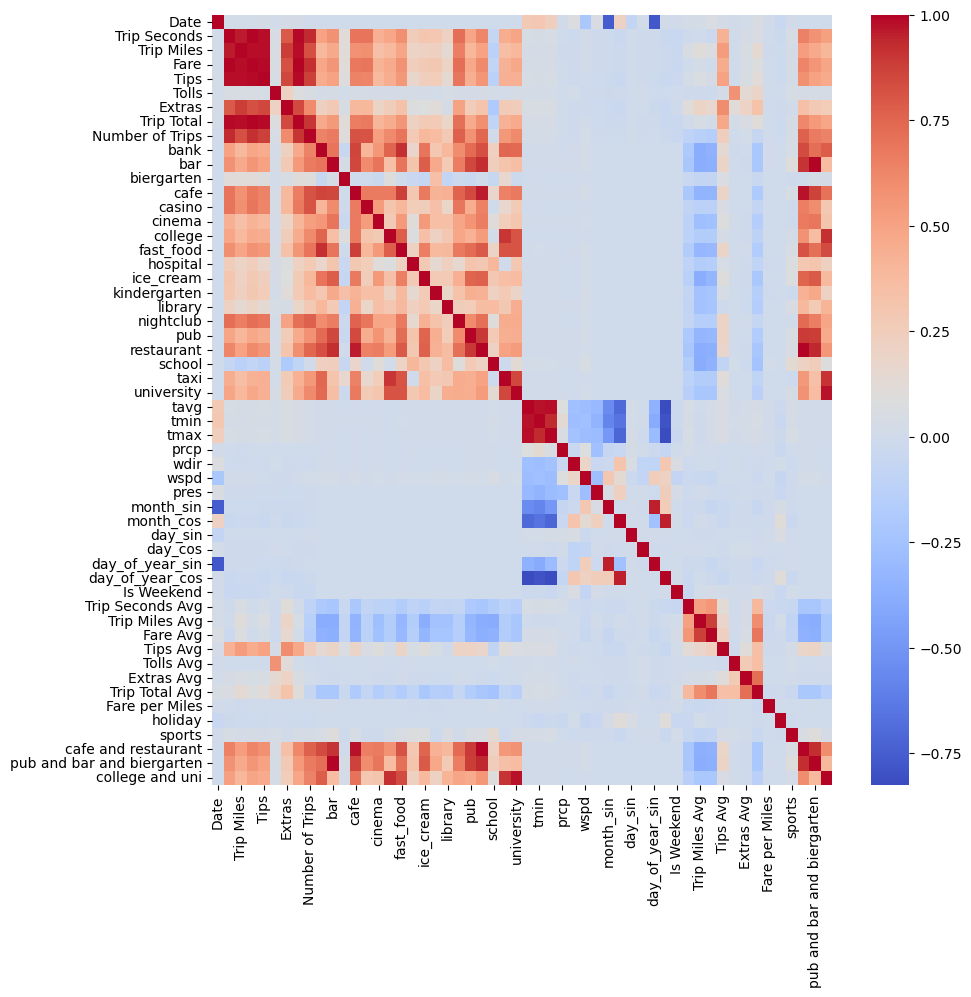

In [323]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(daily_hexagon.drop(['hex_id_7'], axis=1).corr(), ax=ax, annot=False, cmap="coolwarm")

In [324]:
daily_hexagon.drop(['hex_id_7'], axis=1).corr()

Date  Trip Seconds  Trip Miles      Fare  \
Date                        1.000000      0.014368    0.013832  0.015467   
Trip Seconds                0.014368      1.000000    0.964286  0.994799   
Trip Miles                  0.013832      0.964286    1.000000  0.980163   
Fare                        0.015467      0.994799    0.980163  1.000000   
Tips                        0.019158      0.979154    0.982690  0.987415   
Tolls                       0.014700      0.050245    0.047674  0.050181   
Extras                      0.027182      0.793205    0.882930  0.822725   
Trip Total                  0.017267      0.991456    0.985015  0.998540   
Number of Trips             0.005503      0.933927    0.823338  0.917525   
bank                        0.000151      0.506488    0.381366  0.484200   
bar                        -0.000085      0.575322    0.469996  0.559298   
biergarten                  0.000005      0.113735    0.102984  0.108866   
cafe                       -0.000068      0.695674    0.575305  0.680125   
casino                      0.000005      0.698755    0.590568  0.692319   
cinema                     -0.000029      0.433373    0.343206  0.419948   
college                    -0.000035      0.481766    0.373860  0.464359   
fast_food                  -0.000107      0.592949    0.486990  0.575758   
hospital                    0.000032      0.245597    0.198728  0.238304   
ice_cream                  -0.000331      0.306412    0.213817  0.285361   
kindergarten               -0.000610      0.299741    0.227227  0.287120   
library                     0.000235      0.210016    0.138541  0.195632   
nightclub                  -0.000431      0.721847    0.654374  0.719404   
pub                         0.000172      0.486800    0.395897  0.474275   
restaurant                 -0.000101      0.625857    0.505847  0.608851   
school                     -0.000230     -0.062892   -0.121306 -0.078590   
taxi                        0.000009      0.444272    0.357652  0.429397   
university                  0.000013      0.492553    0.387525  0.475101   
tavg                        0.282176      0.037742    0.031536  0.032649   
tmin                        0.300401      0.035383    0.029285  0.030897   
tmax                        0.239241      0.039878    0.033862  0.034398   
prcp                        0.006898     -0.003507   -0.006334 -0.004079   
wdir                        0.068358     -0.012801   -0.009281 -0.009517   
wspd                       -0.206396      0.002772    0.003043  0.004324   
pres                        0.054901     -0.011999   -0.012351 -0.011750   
month_sin                  -0.759161     -0.016334   -0.015271 -0.017187   
month_cos                   0.212873     -0.034526   -0.029977 -0.029015   
day_sin                    -0.069654      0.001616    0.001341  0.001729   
day_cos                     0.012836     -0.009896   -0.008759 -0.008580   
day_of_year_sin            -0.779773     -0.007091   -0.007234 -0.009274   
day_of_year_cos             0.006516     -0.038222   -0.033339 -0.033019   
Is Weekend                  0.008078     -0.047729   -0.037914 -0.038128   
Trip Seconds Avg            0.019832     -0.005429    0.044792 -0.003213   
Trip Miles Avg              0.017901     -0.005049    0.105938  0.022870   
Fare Avg                    0.059333     -0.030493    0.068016 -0.004228   
Tips Avg                    0.025749      0.424695    0.531278  0.456146   
Tolls Avg                   0.008777     -0.002872   -0.002688 -0.002803   
Extras Avg                  0.010686      0.034981    0.050603  0.039596   
Trip Total Avg              0.049582      0.056469    0.142240  0.080031   
Fare per Miles              0.003498     -0.004671   -0.005418 -0.004799   
holiday                    -0.045790     -0.021852   -0.014860 -0.017194   
sports                      0.002810      0.037592    0.029036  0.035426   
cafe and restaurant        -0.000093      0.649036    0.527959  0.632269   
pub 

In [325]:
#remove strongly correlated columns and columns which depend on knowledge about number of trips 
daily_hexagon.drop(["Fare","Trip Miles","Trip Total","Tolls","pub","bar","biergarten","cafe","restaurant","college","university"], axis=1, inplace=True)

## Problem: Hexagons with few observations

- areas with only few observations will pose difficulty for models to capture significant patterns, and for train-test-validation splitting to achieve equal proportions

In [326]:
daily_hexagon['hex_id_7'].value_counts()

hex_id_7
872664190ffffff    365
872664562ffffff    365
872664193ffffff    365
872664194ffffff    365
872664196ffffff    365
                  ... 
872664cdeffffff      7
872664cd5ffffff      2
87275934dffffff      2
872664cb2ffffff      1
872664c88ffffff      1
Name: count, Length: 117, dtype: int64

### Version 1: Replace by Hexagon with similar POI

- unused version where rare hexagons (below threshold of 5 observations) are replaced by hexagon with most similar POI vector. see hourly chapter for code, as the same mapping generated in hourly chapter is used here for consistency purposes

In [327]:
#mapping_hex_poi generated in identical chapter for hourly hexagon
daily_hexagon['hex_id_POI'] = daily_hexagon['hex_id_7'].replace(mapping_hex_poi)

In [328]:
daily_hexagon['hex_id_POI'].value_counts()

hex_id_POI
872664196ffffff    367
872664d9dffffff    367
872664575ffffff    366
872664cc3ffffff    366
872664190ffffff    365
                  ... 
872664ca8ffffff    272
872664c86ffffff    262
87275936bffffff     57
872664c83ffffff     11
872664cdeffffff      7
Name: count, Length: 113, dtype: int64

### Version 2: Replace by Hexagon with nearest location

- rare hexagons (below threshold of 5) get replaced by nearest hexagon based on latitude and longitude location. see hourly chapter for code, as the same mapping generated in hourly chapter is used here for consistency purposes

In [329]:
hex_coordinates = pd.read_csv('data/hexagon7_coordinates.csv')

In [330]:
hex_coordinates.head()

Unnamed: 0         hex_id_7  \
0           0  872664cd1ffffff   
1           1  872664caaffffff   
2           2  872664c1bffffff   
3           3  872664cd3ffffff   
4           4  872664ca2ffffff   

                                      hex_geometry_7  \
0  POLYGON ((-87.682183101495 41.7851293674406, -...   
1  POLYGON ((-87.71915659631343 41.89439747005466...   
2  POLYGON ((-87.61820944356228 41.8710984903598,...   
3  POLYGON ((-87.71165977593786 41.78074895297623...   
4  POLYGON ((-87.75249479459073 41.94687342940655...   

                                     centroid_7      lat_7      lon_7  
0   POINT (-87.67808527361694 41.7729967083749)  41.772997 -87.678085  
1  POINT (-87.71503972411081 41.88225128527498)  41.882251 -87.715040  
2  POINT (-87.61412015899995 41.85895047565379)  41.858950 -87.614120  
3  POINT (-87.70755490338179 41.76861840503292)  41.768618 -87.707555  
4  POINT (-87.74836480796023 41.93472157409436)  41.934722 -87.748365

In [331]:
daily_hexagon.shape

(39905, 45)

In [332]:
daily_hexagon = pd.merge(daily_hexagon,hex_coordinates[['hex_id_7','lat_7','lon_7']],left_on='hex_id_7', right_on='hex_id_7')

In [333]:
daily_hexagon.shape

(39905, 47)

In [334]:
daily_hexagon[daily_hexagon['lat_7'].isna()] # no empty values, good

Empty DataFrame
Columns: [Date, hex_id_7, Trip Seconds, Tips, Extras, Number of Trips, bank, casino, cinema, fast_food, hospital, ice_cream, kindergarten, library, nightclub, school, taxi, tavg, tmin, tmax, prcp, wdir, wspd, pres, month_sin, month_cos, day_sin, day_cos, day_of_year_sin, day_of_year_cos, Is Weekend, Trip Seconds Avg, Trip Miles Avg, Fare Avg, Tips Avg, Tolls Avg, Extras Avg, Trip Total Avg, Fare per Miles, holiday, sports, cafe and restaurant, pub and bar and biergarten, college and uni, hex_id_POI, lat_7, lon_7]
Index: []

In [335]:
#mapping_hex_geo generated in identical chapter for hourly hexagon
daily_hexagon['hex_id_geo'] = daily_hexagon['hex_id_7'].replace(mapping_hex_geo)

In [336]:
daily_hexagon['hex_id_geo'].value_counts()

hex_id_geo
872664cd1ffffff    367
872664190ffffff    365
872664560ffffff    365
872664192ffffff    365
872664193ffffff    365
                  ... 
872664ca8ffffff    272
872664c86ffffff    262
87275936bffffff     59
872664c83ffffff     11
872664cdeffffff      7
Name: count, Length: 113, dtype: int64

## Features to CSV

In [825]:
#used for SVM
#daily_hexagon.to_csv('/Users/awaischoudhry/AAA Project/daily_hexagon7_features.csv')

## Modelling

### Preprocessing

In [339]:
daily_hexagon.columns

Index(['Date', 'hex_id_7', 'Trip Seconds', 'Tips', 'Extras', 'Number of Trips',
       'bank', 'casino', 'cinema', 'fast_food', 'hospital', 'ice_cream',
       'kindergarten', 'library', 'nightclub', 'school', 'taxi', 'tavg',
       'tmin', 'tmax', 'prcp', 'wdir', 'wspd', 'pres', 'month_sin',
       'month_cos', 'day_sin', 'day_cos', 'day_of_year_sin', 'day_of_year_cos',
       'Is Weekend', 'Trip Seconds Avg', 'Trip Miles Avg', 'Fare Avg',
       'Tips Avg', 'Tolls Avg', 'Extras Avg', 'Trip Total Avg',
       'Fare per Miles', 'holiday', 'sports', 'cafe and restaurant',
       'pub and bar and biergarten', 'college and uni', 'hex_id_POI', 'lat_7',
       'lon_7', 'hex_id_geo'],
      dtype='object')

In [340]:
dates = daily_hexagon["Date"]
hex = daily_hexagon["hex_id_7"]
hex_poi = daily_hexagon["hex_id_POI"]
hex_Geo= daily_hexagon["hex_id_geo"]

In [341]:
daily_hexagon.shape

(39905, 48)

In [342]:
len(daily_hexagon['hex_id_geo'].unique())

113

In [343]:
#get dummy indicators for each hexagon bar one
daily_hexagon = pd.get_dummies(daily_hexagon, columns=["hex_id_geo"], dtype=float, drop_first=True)
daily_hexagon.shape 

(39905, 159)

In [344]:
daily_hexagon["hex_id_geo"] = hex_Geo

In [345]:
daily_hexagon.dtypes[:55]

Date                          datetime64[ns]
hex_id_7                              object
Trip Seconds                         float64
Tips                                 float64
Extras                               float64
Number of Trips                      float64
bank                                 float64
casino                               float64
cinema                               float64
fast_food                            float64
hospital                             float64
ice_cream                            float64
kindergarten                         float64
library                              float64
nightclub                            float64
school                               float64
taxi                                 float64
tavg                                 float64
tmin                                 float64
tmax                                 float64
prcp                                 float64
wdir                                 float64
wspd      

#### Split

- a stratified and shuffled approach is chosen based on hexagon IDs in order to account for the imbalance in observations between hexagons and achieve equal proportions of hexagons

In [346]:
# Stratified Shuffled Split to account for imbalance

# Split-Configuration
split_ratio = 0.8

sss = StratifiedShuffleSplit(n_splits=1, test_size=1-split_ratio, random_state=42)

# Index for Train and Test Split
for train_index, test_index in sss.split(daily_hexagon, daily_hexagon['hex_id_geo']):
    train_set1_dh = daily_hexagon.iloc[train_index]
    test_set_dh = daily_hexagon.iloc[test_index]

In [347]:
train_set1_dh['hex_id_geo'].value_counts(normalize=False)

hex_id_geo
872664cd1ffffff    294
872664cf4ffffff    292
872664ccaffffff    292
872664564ffffff    292
872664194ffffff    292
                  ... 
872664ca8ffffff    218
872664c86ffffff    210
87275936bffffff     47
872664c83ffffff      9
872664cdeffffff      6
Name: count, Length: 113, dtype: int64

In [348]:
test_set_dh['hex_id_geo'].value_counts(normalize=False)

hex_id_geo
872664c8dffffff    73
872664cd3ffffff    73
872664c11ffffff    73
872664d9bffffff    73
872664520ffffff    73
                   ..
872664ca8ffffff    54
872664c86ffffff    52
87275936bffffff    12
872664c83ffffff     2
872664cdeffffff     1
Name: count, Length: 113, dtype: int64

In [349]:
#further stratified shuffled split or training data into training and validation
split_ratio = 0.75

sss = StratifiedShuffleSplit(n_splits=1, test_size=1-split_ratio, random_state=42)

# Index for Train and Validation Split
for train_index, test_index in sss.split(train_set1_dh, train_set1_dh['hex_id_geo']):
    train_set2_dh = train_set1_dh.iloc[train_index]
    val_set_dh = train_set1_dh.iloc[test_index]

In [350]:
train_set2_dh['hex_id_geo'].value_counts(normalize=False)

hex_id_geo
872664cd1ffffff    221
872664cd8ffffff    219
872664ccaffffff    219
872664ceaffffff    219
8726641b2ffffff    219
                  ... 
872664ca8ffffff    163
872664c86ffffff    158
87275936bffffff     35
872664c83ffffff      7
872664cdeffffff      5
Name: count, Length: 113, dtype: int64

In [351]:
test_set_dh['hex_id_geo'].value_counts(normalize=False)

hex_id_geo
872664c8dffffff    73
872664cd3ffffff    73
872664c11ffffff    73
872664d9bffffff    73
872664520ffffff    73
                   ..
872664ca8ffffff    54
872664c86ffffff    52
87275936bffffff    12
872664c83ffffff     2
872664cdeffffff     1
Name: count, Length: 113, dtype: int64

In [352]:
val_set_dh['hex_id_geo'].value_counts(normalize=False)

hex_id_geo
872664cc8ffffff    73
872664ce3ffffff    73
872664c16ffffff    73
872664194ffffff    73
872664ccaffffff    73
                   ..
872664ca8ffffff    55
872664c86ffffff    52
87275936bffffff    12
872664c83ffffff     2
872664cdeffffff     1
Name: count, Length: 113, dtype: int64

#### Feature selection and standardization

In [353]:
train_set2_dh.columns[:55]

Index(['Date', 'hex_id_7', 'Trip Seconds', 'Tips', 'Extras', 'Number of Trips',
       'bank', 'casino', 'cinema', 'fast_food', 'hospital', 'ice_cream',
       'kindergarten', 'library', 'nightclub', 'school', 'taxi', 'tavg',
       'tmin', 'tmax', 'prcp', 'wdir', 'wspd', 'pres', 'month_sin',
       'month_cos', 'day_sin', 'day_cos', 'day_of_year_sin', 'day_of_year_cos',
       'Is Weekend', 'Trip Seconds Avg', 'Trip Miles Avg', 'Fare Avg',
       'Tips Avg', 'Tolls Avg', 'Extras Avg', 'Trip Total Avg',
       'Fare per Miles', 'holiday', 'sports', 'cafe and restaurant',
       'pub and bar and biergarten', 'college and uni', 'hex_id_POI', 'lat_7',
       'lon_7', 'hex_id_geo_872664191ffffff', 'hex_id_geo_872664192ffffff',
       'hex_id_geo_872664193ffffff', 'hex_id_geo_872664194ffffff',
       'hex_id_geo_872664196ffffff', 'hex_id_geo_8726641b2ffffff',
       'hex_id_geo_8726641b6ffffff', 'hex_id_geo_872664520ffffff'],
      dtype='object')

In [354]:
#remove uneeded features which features which depend on knowledge of number of trips
X_train_dh = train_set2_dh.drop(['Date','Trip Seconds Avg', 'Trip Miles Avg', 'Fare Avg',
       'Tips Avg', 'Tolls Avg', 'Extras Avg', 'Trip Total Avg',
       'Fare per Miles', 'hex_id_7', 'Number of Trips', 'Trip Seconds','Tips', 'Extras', 'hex_id_POI', 'lat_7', 'lon_7','hex_id_geo'], axis=1)
y_train_dh = train_set2_dh["Number of Trips"]

X_test_dh = test_set_dh.drop(['Date','Trip Seconds Avg', 'Trip Miles Avg', 'Fare Avg',
       'Tips Avg', 'Tolls Avg', 'Extras Avg', 'Trip Total Avg',
       'Fare per Miles', 'hex_id_7', 'Number of Trips', 'Trip Seconds','Tips', 'Extras', 'hex_id_POI', 'lat_7', 'lon_7','hex_id_geo'], axis=1)
y_test_dh = test_set_dh["Number of Trips"]


X_val_dh = val_set_dh.drop(['Date','Trip Seconds Avg', 'Trip Miles Avg', 'Fare Avg',
       'Tips Avg', 'Tolls Avg', 'Extras Avg', 'Trip Total Avg',
       'Fare per Miles', 'hex_id_7', 'Number of Trips', 'Trip Seconds','Tips', 'Extras', 'hex_id_POI', 'lat_7', 'lon_7','hex_id_geo'], axis=1)
y_val_dh = val_set_dh["Number of Trips"]


In [355]:
X_train_dh.columns[:50]

Index(['bank', 'casino', 'cinema', 'fast_food', 'hospital', 'ice_cream',
       'kindergarten', 'library', 'nightclub', 'school', 'taxi', 'tavg',
       'tmin', 'tmax', 'prcp', 'wdir', 'wspd', 'pres', 'month_sin',
       'month_cos', 'day_sin', 'day_cos', 'day_of_year_sin', 'day_of_year_cos',
       'Is Weekend', 'holiday', 'sports', 'cafe and restaurant',
       'pub and bar and biergarten', 'college and uni',
       'hex_id_geo_872664191ffffff', 'hex_id_geo_872664192ffffff',
       'hex_id_geo_872664193ffffff', 'hex_id_geo_872664194ffffff',
       'hex_id_geo_872664196ffffff', 'hex_id_geo_8726641b2ffffff',
       'hex_id_geo_8726641b6ffffff', 'hex_id_geo_872664520ffffff',
       'hex_id_geo_872664521ffffff', 'hex_id_geo_872664523ffffff',
       'hex_id_geo_872664525ffffff', 'hex_id_geo_87266452cffffff',
       'hex_id_geo_87266452dffffff', 'hex_id_geo_872664560ffffff',
       'hex_id_geo_872664561ffffff', 'hex_id_geo_872664562ffffff',
       'hex_id_geo_872664563ffffff', 'hex_id_geo_

In [356]:
# dummy columns
known_dummy_columns = ['Is Weekend','holiday', 'sports']

# dummy columns
geo_dummy_columns = X_train_dh.columns[X_train_dh.columns.str.contains('hex_id_geo_')]

# gather
dummy_columns = known_dummy_columns + list(geo_dummy_columns)

# Numeric columns
numeric_columns = X_train_dh.columns.difference(dummy_columns)

In [357]:
# Z-Standardization only for numeric columns
scaler = StandardScaler()
X_train_dh[numeric_columns] = scaler.fit_transform(X_train_dh[numeric_columns])

# Transformation of test set based training parameters
X_test_dh[numeric_columns] = scaler.transform(X_test_dh[numeric_columns])

# Transformation of validation set based training parameters
X_val_dh[numeric_columns] = scaler.transform(X_val_dh[numeric_columns])

### Validations

- final data and consistency checks

In [358]:
X_train_dh.max()[lambda x : x==np.max(X_train_dh.max())]

prcp    11.772834
dtype: float64

In [359]:
X_test_dh.max()[lambda x : x==np.max(X_test_dh.max())]

prcp    11.772834
dtype: float64

In [360]:
X_test_dh.mean()[lambda x : x==np.max(X_test_dh.mean())]

Is Weekend    0.282797
dtype: float64

In [361]:
X_test_dh.std()[lambda x : x==np.max(X_test_dh.std())]

pres    1.010427
dtype: float64

In [362]:
X_train_dh.mean()

bank                          1.068351e-17
casino                       -7.715871e-18
cinema                        4.866934e-17
fast_food                    -1.483821e-17
hospital                      2.314761e-17
                                  ...     
hex_id_geo_872759340ffffff    9.146723e-03
hex_id_geo_872759341ffffff    9.146723e-03
hex_id_geo_87275934effffff    9.146723e-03
hex_id_geo_872759369ffffff    9.146723e-03
hex_id_geo_87275936bffffff    1.461805e-03
Length: 142, dtype: float64

In [363]:
X_test_dh.mean()

bank                          7.122343e-18
casino                        1.513498e-17
cinema                       -8.317441e-05
fast_food                    -9.914126e-06
hospital                     -1.283574e-04
                                  ...     
hex_id_geo_872759340ffffff    9.146723e-03
hex_id_geo_872759341ffffff    9.146723e-03
hex_id_geo_87275934effffff    9.146723e-03
hex_id_geo_872759369ffffff    9.146723e-03
hex_id_geo_87275936bffffff    1.503571e-03
Length: 142, dtype: float64

In [364]:
X_val_dh.mean()

bank                          1.312924e-04
casino                        3.116025e-18
cinema                       -8.317441e-05
fast_food                     1.164910e-04
hospital                     -1.283574e-04
                                  ...     
hex_id_geo_872759340ffffff    9.146723e-03
hex_id_geo_872759341ffffff    9.146723e-03
hex_id_geo_87275934effffff    9.146723e-03
hex_id_geo_872759369ffffff    9.146723e-03
hex_id_geo_87275936bffffff    1.503571e-03
Length: 142, dtype: float64

In [365]:
X_train_dh.std()

bank                          1.000021
casino                        1.000021
cinema                        1.000021
fast_food                     1.000021
hospital                      1.000021
                                ...   
hex_id_geo_872759340ffffff    0.095202
hex_id_geo_872759341ffffff    0.095202
hex_id_geo_87275934effffff    0.095202
hex_id_geo_872759369ffffff    0.095202
hex_id_geo_87275936bffffff    0.038206
Length: 142, dtype: float64

In [366]:
X_test_dh.std()

bank                          1.000075
casino                        1.000063
cinema                        1.000013
fast_food                     1.000107
hospital                      0.999921
                                ...   
hex_id_geo_872759340ffffff    0.095206
hex_id_geo_872759341ffffff    0.095206
hex_id_geo_87275934effffff    0.095206
hex_id_geo_872759369ffffff    0.095206
hex_id_geo_87275936bffffff    0.038749
Length: 142, dtype: float64

In [367]:
X_val_dh.std()

bank                          1.000055
casino                        1.000063
cinema                        1.000013
fast_food                     1.000065
hospital                      0.999921
                                ...   
hex_id_geo_872759340ffffff    0.095206
hex_id_geo_872759341ffffff    0.095206
hex_id_geo_87275934effffff    0.095206
hex_id_geo_872759369ffffff    0.095206
hex_id_geo_87275936bffffff    0.038749
Length: 142, dtype: float64

### DF to Numpy Arrays

In [368]:
X_train_data_dh = X_train_dh.to_numpy()
X_test_data_dh = X_test_dh.to_numpy()
X_val_data_dh = X_val_dh.to_numpy()


y_train_data_dh = y_train_dh.to_numpy()
y_test_data_dh = y_test_dh.to_numpy()
y_val_data_dh = y_val_dh.to_numpy()

In [369]:
X_train_data_dh.shape

(23943, 142)

### Tuning and Training

#### Tuning

In [1154]:
#ceate manageable hypertuning space 
def build_model_hex_daily(hp):
    model = models.Sequential()
    model.add(ks.Input(shape=(X_train_data_dh.shape[1],)))
    for i in range(hp.Int("num_layers", 1, 2)):
        model.add(
            layers.Dense(
                # Tune number of units separately.
                units=hp.Int(f"units_{i}", min_value=30, max_value=150, step=40),
                kernel_regularizer=regularizers.L1L2(l1=hp.Choice("l1_rate", values=[0.0001,0.001,0.01]), l2=hp.Choice("l2_rate", values=[0.0001,0.001,0.01])),
                activation="relu",
            )
        )
    model.add(layers.Dense(units=hp.Int(f"units_3", min_value=30, max_value=150, step=40),
            kernel_regularizer=regularizers.L1L2(l1=hp.Choice("l1_rate", values=[0.0001,0.001,0.01]), l2=hp.Choice("l2_rate", values=[0.0001,0.001,0.01])),
            activation="relu",
        )
    )
    model.add(layers.Dense(units=1, activation="relu"))
    opt = ks.optimizers.Adam(
        learning_rate=0.001,
        beta_1=0.9,
        beta_2=0.999,
    )
    model.compile(
        optimizer=opt,
        loss="mse",
        metrics=[ks.metrics.R2Score(),'mae',ks.metrics.MeanAbsolutePercentageError()],
    )
    return model

In [1155]:
#test for errors
build_model_hex_daily(keras_tuner.HyperParameters())

<Sequential name=sequential_1, built=True>

In [1156]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8)

In [1157]:
#tuning algorithm initialization
tuner_hex_daily = keras_tuner.BayesianOptimization(
            build_model_hex_daily, #The model function we wrote
            seed=777, #Seed for evaluation
            objective='val_loss', #Which objective to keep track of
            max_trials=30, #Number of trials to try
            directory="hyperparameter_tuning",
	        project_name='dh_noAvg_bayes_noDrop_rightStd_withValSet_rightAct_1') 

In [1158]:
tuner_hex_daily.search_space_summary()

Search space summary
Default search space size: 5
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 2, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 30, 'max_value': 150, 'step': 40, 'sampling': 'linear'}
l1_rate (Choice)
{'default': 0.0001, 'conditions': [], 'values': [0.0001, 0.001, 0.01], 'ordered': True}
l2_rate (Choice)
{'default': 0.0001, 'conditions': [], 'values': [0.0001, 0.001, 0.01], 'ordered': True}
units_3 (Int)
{'default': None, 'conditions': [], 'min_value': 30, 'max_value': 150, 'step': 40, 'sampling': 'linear'}


In [1160]:
tuner_hex_daily.search(X_train_data_dh, y_train_data_dh, epochs=20, validation_data=(X_val_data_dh,y_val_data_dh), callbacks=[stop_early])

Trial 30 Complete [00h 00m 11s]
val_loss: 7778.75341796875

Best val_loss So Far: 7282.333984375
Total elapsed time: 00h 07m 11s


In [1161]:
tuner_hex_daily.results_summary()

Results summary
Results in hyperparameter_tuning/dh_noAvg_bayes_noDrop_rightStd_withValSet_rightAct_1
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 07 summary
Hyperparameters:
num_layers: 1
units_0: 70
l1_rate: 0.001
l2_rate: 0.0001
units_3: 110
units_1: 150
Score: 7282.333984375

Trial 01 summary
Hyperparameters:
num_layers: 2
units_0: 110
l1_rate: 0.001
l2_rate: 0.001
units_3: 150
units_1: 30
Score: 7360.32275390625

Trial 28 summary
Hyperparameters:
num_layers: 2
units_0: 110
l1_rate: 0.001
l2_rate: 0.0001
units_3: 150
units_1: 30
Score: 7431.12939453125

Trial 02 summary
Hyperparameters:
num_layers: 1
units_0: 110
l1_rate: 0.001
l2_rate: 0.001
units_3: 110
units_1: 110
Score: 7443.90185546875

Trial 03 summary
Hyperparameters:
num_layers: 2
units_0: 70
l1_rate: 0.001
l2_rate: 0.001
units_3: 150
units_1: 70
Score: 7536.97412109375

Trial 27 summary
Hyperparameters:
num_layers: 2
units_0: 110
l1_rate: 0.001
l2_rate: 0.001
units_3: 150
units_1: 30
Score: 75

#### Training

In [1162]:
#retrieve model with best hyperparameter combination from tuning
best_model_dh = tuner_hex_daily.get_best_models(num_models=1)[0]

/opt/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [1163]:
#implement early stopping for training and retrieval of weights for best metrics on validation dataset
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False)

model_file = '/Users/awaischoudhry/AAA Project/weights/weights_dh_bayes_noAvg_0810__withValset_rightAct_2.keras'

checkpoint = tf.keras.callbacks.ModelCheckpoint(model_file, 
                    monitor="val_loss", mode="min", 
                    save_best_only=True, verbose=1)

In [1164]:
best_model_dh.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 70)             │        10,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 110)            │         7,810 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           111 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,931 (70.04 KB)

 Trainable params: 17,931 (70.04 KB)

 Non-trainable params: 0 (0.00 B)

In [1165]:
best_model_dh.get_config()

{'name': 'sequential',
 'trainable': True,
 'dtype': {'module': 'keras',
  'class_name': 'DTypePolicy',
  'config': {'name': 'float32'},
  'registered_name': None},
 'layers': [{'module': 'keras.layers',
   'class_name': 'InputLayer',
   'config': {'batch_shape': (None, 142),
    'dtype': 'float32',
    'sparse': False,
    'name': 'input_layer'},
   'registered_name': None},
  {'module': 'keras.layers',
   'class_name': 'Dense',
   'config': {'name': 'dense',
    'trainable': True,
    'dtype': {'module': 'keras',
     'class_name': 'DTypePolicy',
     'config': {'name': 'float32'},
     'registered_name': None},
    'units': 70,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'module': 'keras.initializers',
     'class_name': 'GlorotUniform',
     'config': {'seed': None},
     'registered_name': None},
    'bias_initializer': {'module': 'keras.initializers',
     'class_name': 'Zeros',
     'config': {},
     'registered_name': None},
    'kernel_regulariz

In [1166]:
best_model_dh.save('/Users/awaischoudhry/AAA Project/full_models/untrained_dh_noAvg_0810_rightAct_1.keras')

In [1167]:
#train and collect history
history_dh_noDrop = best_model_dh.fit(X_train_data_dh, y_train_data_dh, epochs=1000, validation_data=(X_val_data_dh,y_val_data_dh), callbacks=[stop_early, checkpoint])

Epoch 1/1000
685/749 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step - loss: 5729.9570 - mae: 22.4422 - mean_absolute_percentage_error: 15131093.0000 - r2_score: 0.9703
Epoch 1: val_loss improved from inf to 8321.08203, saving model to /Users/awaischoudhry/AAA Project/weights/weights_dh_bayes_noAvg_0810__withValset_rightAct_2.keras
749/749 ━━━━━━━━━━━━━━━━━━━━ 1s 618us/step - loss: 5819.9380 - mae: 22.5187 - mean_absolute_percentage_error: 15539891.0000 - r2_score: 0.9700 - val_loss: 8321.0820 - val_mae: 24.8739 - val_mean_absolute_percentage_error: 23319576.0000 - val_r2_score: 0.9598
Epoch 2/1000
675/749 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step - loss: 7174.1167 - mae: 24.0234 - mean_absolute_percentage_error: 33160850.0000 - r2_score: 0.9683
Epoch 2: val_loss improved from 8321.08203 to 7297.74023, saving model to /Users/awaischoudhry/AAA Project/weights/weights_dh_bayes_noAvg_0810__withValset_rightAct_2.keras
749/749 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - loss: 7101.8018 - mae: 23.9081 - mean_absolute_

In [1168]:
best_model_dh_full_noDrop = ks.saving.load_model(model_file, custom_objects=None, compile=True, safe_mode=True)

In [1169]:
#evaluation on holdout test set
best_model_dh_full_noDrop.evaluate(X_test_data_dh,y_test_data_dh)

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step - loss: 7393.0942 - mae: 25.5028 - mean_absolute_percentage_error: 6946358.5000 - r2_score: 0.9647


[6842.61083984375, 0.9672010540962219, 24.67582130432129, 10501824.0]

In [1170]:
best_model_dh_full_noDrop.save('/Users/awaischoudhry/AAA Project/full_models/trained_dh_noAvg_0810_rightAct_1.keras')

#### Results (not final)

- Final results are contained in report

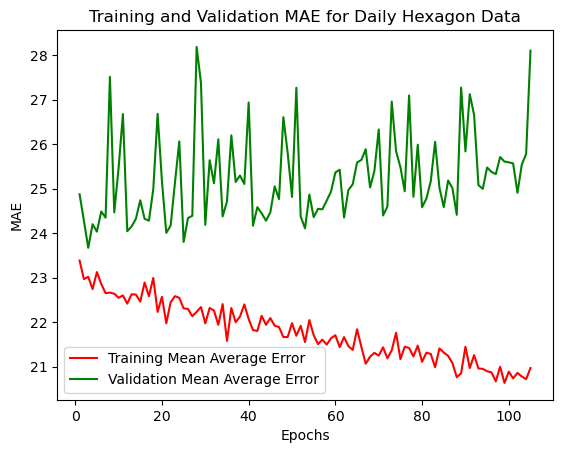

In [1171]:
mae_dh_noDrop = history_dh_noDrop.history['mae']
val_mae_dh_noDrop = history_dh_noDrop.history['val_mae']

epochs = range(1, len(mae_dh_noDrop) + 1)

plt.plot(epochs, mae_dh_noDrop, '-', c='red', label='Training Mean Average Error')
plt.plot(epochs, val_mae_dh_noDrop, '-', c='green', label='Validation Mean Average Error')
plt.title('Training and Validation MAE for Daily Hexagon Data')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

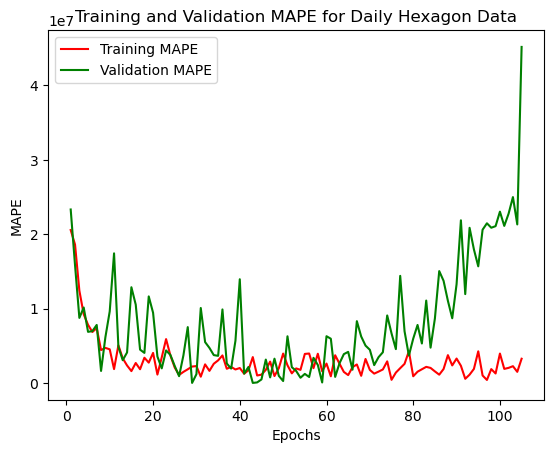

In [1172]:
mape_dh_noDrop = history_dh_noDrop.history['mean_absolute_percentage_error']
val_mape_dh_noDrop = history_dh_noDrop.history['val_mean_absolute_percentage_error']

epochs = range(1, len(mape_dh_noDrop) + 1)

plt.plot(epochs, mape_dh_noDrop, '-', c='red', label='Training MAPE')
plt.plot(epochs, val_mape_dh_noDrop, '-', c='green', label='Validation MAPE')
plt.title('Training and Validation MAPE for Daily Hexagon Data')
plt.xlabel('Epochs')
plt.ylabel('MAPE')
plt.legend()
plt.show()

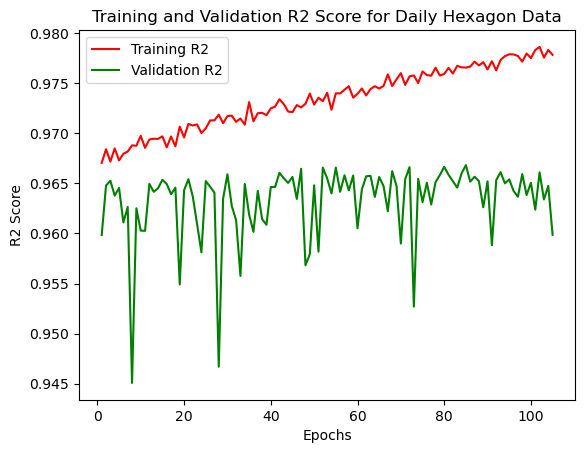

In [1173]:
r2_dh_noDrop = history_dh_noDrop.history['r2_score']
val_r2_dh_noDrop = history_dh_noDrop.history['val_r2_score']

epochs = range(1, len(r2_dh_noDrop) + 1)

plt.plot(epochs, r2_dh_noDrop, '-', c='red', label='Training R2')
plt.plot(epochs, val_r2_dh_noDrop, '-', c='green', label='Validation R2')
plt.title('Training and Validation R2 Score for Daily Hexagon Data')
plt.xlabel('Epochs')
plt.ylabel('R2 Score')
plt.legend()
plt.show()

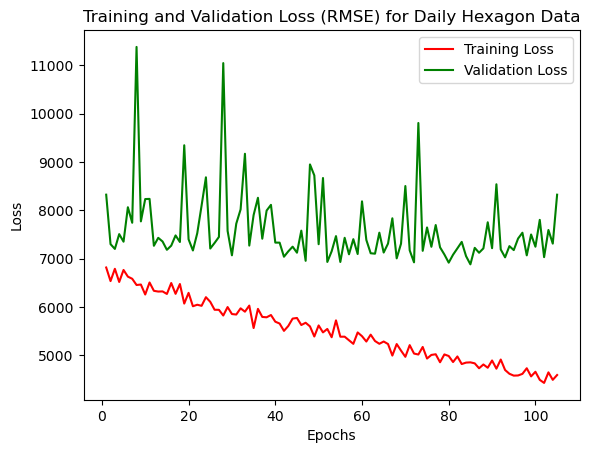

In [1174]:
loss_dh_noDrop = history_dh_noDrop.history['loss']
val_loss_dh_noDrop = history_dh_noDrop.history['val_loss']

epochs = range(1, len(loss_dh_noDrop) + 1)

plt.plot(epochs, loss_dh_noDrop, '-', c='red', label='Training Loss')
plt.plot(epochs, val_loss_dh_noDrop, '-', c='green', label='Validation Loss')
plt.title('Training and Validation Loss (RMSE) for Daily Hexagon Data')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [1175]:
dh_scores_noDrop = pd.DataFrame(
    {'loss': loss_dh_noDrop,
     'val_loss': val_loss_dh_noDrop,
     'mae': mae_dh_noDrop,
     'val_mae': val_mae_dh_noDrop,
     'mape': mape_dh_noDrop,
     'val_mape': val_mape_dh_noDrop,
     'r2': r2_dh_noDrop,
     'val_r2': val_r2_dh_noDrop
    })

dh_scores_noDrop['Model_trained']='/Users/awaischoudhry/AAA Project/full_models/trained_dh_noAvg_0810_rightAct_1.keras'

dh_scores_noDrop['Model_untrained']='/Users/awaischoudhry/AAA Project/full_models/untrained_dh_noAvg_0810_rightAct_1.keras'

dh_scores_noDrop['Hyperparameter']='hyperparameter_tuning/dh_noAvg_bayes_noDrop_rightStd_withValSet_rightAct_1'

dh_scores_noDrop.to_csv('/Users/awaischoudhry/AAA Project/history_dh_noAvg_noDrop_1.csv')

#### Dropout Layers

- Manually test for dropout layers of proportion 0.25 and 0.5

In [1311]:
best_model_dh.get_config()

{'name': 'sequential',
 'trainable': True,
 'dtype': {'module': 'keras',
  'class_name': 'DTypePolicy',
  'config': {'name': 'float32'},
  'registered_name': None},
 'layers': [{'module': 'keras.layers',
   'class_name': 'InputLayer',
   'config': {'batch_shape': (None, 142),
    'dtype': 'float32',
    'sparse': False,
    'name': 'input_layer'},
   'registered_name': None},
  {'module': 'keras.layers',
   'class_name': 'Dense',
   'config': {'name': 'dense',
    'trainable': True,
    'dtype': {'module': 'keras',
     'class_name': 'DTypePolicy',
     'config': {'name': 'float32'},
     'registered_name': None},
    'units': 70,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'module': 'keras.initializers',
     'class_name': 'GlorotUniform',
     'config': {'seed': None},
     'registered_name': None},
    'bias_initializer': {'module': 'keras.initializers',
     'class_name': 'Zeros',
     'config': {},
     'registered_name': None},
    'kernel_regulariz

In [1312]:
best_model_dh.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 70)             │        10,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 110)            │         7,810 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           111 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,795 (210.14 KB)

 Trainable params: 17,931 (70.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 35,864 (140.10 KB)

In [1329]:
best_model_dh_withDrop = models.Sequential()
best_model_dh_withDrop.add(ks.Input(shape=(X_train_data_dh.shape[1],)))
best_model_dh_withDrop.add(layers.Dense(70, activation='relu', kernel_regularizer=regularizers.L1L2(l1=0.001, l2=0.0001)))
best_model_dh_withDrop.add(layers.Dropout(0.5, seed=777))
best_model_dh_withDrop.add(layers.Dense(110, activation='relu', kernel_regularizer=regularizers.L1L2(l1=0.001, l2=0.0001)))
best_model_dh_withDrop.add(layers.Dropout(0.5, seed=777))
best_model_dh_withDrop.add(layers.Dense(1, activation='relu'))

opt = ks.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999
)

best_model_dh_withDrop.compile(optimizer=opt, loss='mse', metrics=[ks.metrics.R2Score(),'mae',ks.metrics.MeanAbsolutePercentageError()]) #optimizer: adam (...)

In [1331]:
best_model_dh_withDrop.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                │ (None, 70)             │        10,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 70)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 110)            │         7,810 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 110)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │           111 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,931 (70.04 KB)

 Trainable params: 17,931 (70.04 KB)

 Non-trainable params: 0 (0.00 B)

In [1332]:
best_model_dh_withDrop.get_config()

{'name': 'sequential_5',
 'trainable': True,
 'dtype': {'module': 'keras',
  'class_name': 'DTypePolicy',
  'config': {'name': 'float32'},
  'registered_name': None},
 'layers': [{'module': 'keras.layers',
   'class_name': 'InputLayer',
   'config': {'batch_shape': (None, 142),
    'dtype': 'float32',
    'sparse': False,
    'name': 'input_layer_5'},
   'registered_name': None},
  {'module': 'keras.layers',
   'class_name': 'Dense',
   'config': {'name': 'dense_18',
    'trainable': True,
    'dtype': {'module': 'keras',
     'class_name': 'DTypePolicy',
     'config': {'name': 'float32'},
     'registered_name': None},
    'units': 70,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'module': 'keras.initializers',
     'class_name': 'GlorotUniform',
     'config': {'seed': None},
     'registered_name': None},
    'bias_initializer': {'module': 'keras.initializers',
     'class_name': 'Zeros',
     'config': {},
     'registered_name': None},
    'kernel_re

In [1330]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False)

model_file_dh_withDrop = '/Users/awaischoudhry/AAA Project/weights/weights_dh_bayes_withAvg_0810__withValset_rightAct_withDrop_0point5_1.keras'

checkpoint = tf.keras.callbacks.ModelCheckpoint(model_file_dh_withDrop, 
                    monitor="val_loss", mode="min", 
                    save_best_only=True, verbose=1)

In [1333]:
history_dh_withDrop = best_model_dh_withDrop.fit(X_train_data_dh, y_train_data_dh, epochs=1000, validation_data=(X_val_data_dh,y_val_data_dh), callbacks=[stop_early, checkpoint])

Epoch 1/1000
662/749 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - loss: 159986.6250 - mae: 106.2449 - mean_absolute_percentage_error: 281680704.0000 - r2_score: 0.2032
Epoch 1: val_loss improved from inf to 33679.53906, saving model to /Users/awaischoudhry/AAA Project/weights/weights_dh_bayes_withAvg_0810__withValset_rightAct_withDrop_0point5_1.keras
749/749 ━━━━━━━━━━━━━━━━━━━━ 1s 724us/step - loss: 153114.1875 - mae: 105.2195 - mean_absolute_percentage_error: 299889632.0000 - r2_score: 0.2401 - val_loss: 33679.5391 - val_mae: 70.6490 - val_mean_absolute_percentage_error: 451455040.0000 - val_r2_score: 0.8373
Epoch 2/1000
702/749 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 33575.6641 - mae: 67.8130 - mean_absolute_percentage_error: 361441152.0000 - r2_score: 0.8342
Epoch 2: val_loss improved from 33679.53906 to 20173.00781, saving model to /Users/awaischoudhry/AAA Project/weights/weights_dh_bayes_withAvg_0810__withValset_rightAct_withDrop_0point5_1.keras
749/749 ━━━━━━━━━━━━━━━━━━━━ 0s 534us/s

In [1334]:
best_model_dh_full_withDrop = ks.saving.load_model(model_file_dh_withDrop, custom_objects=None, compile=True, safe_mode=True)

In [1335]:
best_model_dh_full_withDrop.save('/Users/awaischoudhry/AAA Project/full_models/trained_dh_noAvg_0810_rightAct_withDrop_0point5_1.keras')

In [1336]:
best_model_dh_full_withDrop.evaluate(X_test_data_dh, y_test_data_dh)

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step - loss: 7860.5088 - mae: 25.6887 - mean_absolute_percentage_error: 63.4948 - r2_score: 0.9622


[7733.47021484375, 0.9629175066947937, 25.13904571533203, 63.77979278564453]

In [1337]:
dh_scores_withDrop_0point5 = pd.DataFrame(
    {'loss': history_dh_withDrop.history['loss'],
     'val_loss': history_dh_withDrop.history['val_loss'],
     'mae': history_dh_withDrop.history['mae'],
     'val_mae': history_dh_withDrop.history['val_mae'],
     'mape': history_dh_withDrop.history['mean_absolute_percentage_error'],
     'val_mape': history_dh_withDrop.history['val_mean_absolute_percentage_error'],
     'r2': history_dh_withDrop.history['r2_score'],
     'val_r2': history_dh_withDrop.history['val_r2_score']
    })

dh_scores_withDrop_0point5['Model_trained']='/Users/awaischoudhry/AAA Project/full_models/trained_dh_noAvg_0810_rightAct_withDrop_0point5_1.keras'

dh_scores_withDrop_0point5['Hyperparameter']='hyperparameter_tuning/dc_noAvg_bayes_noDrop_rightStd_withValSet_rightAct_1'

dh_scores_withDrop_0point5.to_csv('/Users/awaischoudhry/AAA Project/history_dh_noAvg_withDrop_0point5_1.csv')

#### New Metrics

- generate more potentially interesting metrics

In [370]:
best_model_dh_reload = ks.saving.load_model('/Users/awaischoudhry/AAA Project/full_models/untrained_dh_noAvg_0810_rightAct_1.keras', custom_objects=None, compile=True, safe_mode=True)

/opt/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 14 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [371]:
from tensorflow.keras.saving import register_keras_serializable

opt = ks.optimizers.Adam(
        learning_rate=0.001,
        beta_1=0.9,
        beta_2=0.999,
    )

@register_keras_serializable()
def smape(y_true, y_pred):
    """
    Berechnet den Symmetric Mean Absolute Percentage Error (sMAPE).

    Args:
    y_true -- Die tatsächlichen Werte.
    y_pred -- Die vorhergesagten Werte.

    Returns:
    Der sMAPE-Wert.
    """
    
    epsilon = K.epsilon()  # Kleine Konstante zur Vermeidung von Division durch Null
    numerator = K.abs(y_pred - y_true)
    denominator = K.abs(y_true) + K.abs(y_pred) + epsilon
    smape_value = 2 * K.mean(numerator / denominator)
    return smape_value

@register_keras_serializable()
def mase(y_true, y_pred):
    """
    Berechnet den Mean Absolute Scaled Error (MASE) basierend auf der Baseline-Vorhersage
    als Mittelwert der tatsächlichen Werte.

    Args:
    y_true -- Die tatsächlichen Werte.
    y_pred -- Die vorhergesagten Werte.

    Returns:
    Der MASE-Wert.
    """

    # Mittelwert der tatsächlichen Werte als Baseline-Vorhersage
    y_mean = K.mean(y_true)
    
    # MAE der Modellvorhersagen
    mae_model = K.mean(K.abs(y_true - y_pred))
    
    # MAE der Baseline-Vorhersagen (mittlerer absoluter Fehler der Mittelwertvorhersage)
    mae_baseline = K.mean(K.abs(y_true - y_mean))
    
    # MASE-Berechnung
    mase_value = mae_model / (mae_baseline + K.epsilon())  # epsilon zur Vermeidung von Division durch Null
    return mase_value


best_model_dh_reload.compile(optimizer=opt,  # Verwende den gleichen Optimizer wie im ursprünglichen Training
                   loss='mse',  # Verwende die gleiche Verlustfunktion
                   metrics=[ks.metrics.R2Score(),'mae',ks.metrics.MeanAbsolutePercentageError(),ks.metrics.MeanSquaredLogarithmicError(), smape, mase])


In [372]:
best_model_dh_reload.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 70)             │        10,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 110)            │         7,810 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           111 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,931 (70.04 KB)

 Trainable params: 17,931 (70.04 KB)

 Non-trainable params: 0 (0.00 B)

In [373]:
best_model_dh_reload.get_config()

{'name': 'sequential',
 'trainable': True,
 'dtype': {'module': 'keras',
  'class_name': 'DTypePolicy',
  'config': {'name': 'float32'},
  'registered_name': None},
 'layers': [{'module': 'keras.layers',
   'class_name': 'InputLayer',
   'config': {'batch_shape': (None, 142),
    'dtype': 'float32',
    'sparse': False,
    'name': 'input_layer'},
   'registered_name': None},
  {'module': 'keras.layers',
   'class_name': 'Dense',
   'config': {'name': 'dense',
    'trainable': True,
    'dtype': {'module': 'keras',
     'class_name': 'DTypePolicy',
     'config': {'name': 'float32'},
     'registered_name': None},
    'units': 70,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'module': 'keras.initializers',
     'class_name': 'GlorotUniform',
     'config': {'seed': None},
     'registered_name': None},
    'bias_initializer': {'module': 'keras.initializers',
     'class_name': 'Zeros',
     'config': {},
     'registered_name': None},
    'kernel_regulariz

In [374]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False)

model_file_dh_nm = '/Users/awaischoudhry/AAA Project/weights/weights_dh_bayes_noAvg_0812_withValset_rightAct_newMetrics.keras'

checkpoint = tf.keras.callbacks.ModelCheckpoint(model_file_dh_nm, 
                    monitor="val_loss", mode="min", 
                    save_best_only=True, verbose=1)

In [375]:
history_dh_nm = best_model_dh_reload.fit(X_train_data_dh, y_train_data_dh, epochs=1000, validation_data=(X_val_data_dh,y_val_data_dh), callbacks=[stop_early, checkpoint])

Epoch 1/1000
635/749 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - loss: 7882.4717 - mae: 24.2086 - mase: 1.2368 - mean_absolute_percentage_error: 18578692.0000 - mean_squared_logarithmic_error: 1.2490 - r2_score: 0.9647 - smape: 1.4706
Epoch 1: val_loss improved from inf to 7449.74023, saving model to /Users/awaischoudhry/AAA Project/weights/weights_dh_bayes_noAvg_0812_withValset_rightAct_newMetrics.keras
749/749 ━━━━━━━━━━━━━━━━━━━━ 1s 653us/step - loss: 7712.4722 - mae: 24.0481 - mase: 1.2370 - mean_absolute_percentage_error: 19496368.0000 - mean_squared_logarithmic_error: 1.2539 - r2_score: 0.9651 - smape: 1.4707 - val_loss: 7449.7402 - val_mae: 23.6139 - val_mase: 1.2293 - val_mean_absolute_percentage_error: 10194619.0000 - val_mean_squared_logarithmic_error: 1.3384 - val_r2_score: 0.9640 - val_smape: 1.4860
Epoch 2/1000
714/749 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - loss: 6087.4014 - mae: 22.6580 - mase: 1.2380 - mean_absolute_percentage_error: 18980412.0000 - mean_squared_logarithmic_error

In [376]:
best_model_dh_full_noDrop_reload = ks.saving.load_model(model_file_dh_nm, custom_objects=None, compile=True, safe_mode=True)


In [377]:
best_model_dh_full_noDrop_reload.save('/Users/awaischoudhry/AAA Project/full_models/trained_dh_noAvg_0812_rightAct_newMetrics.keras')


In [378]:
best_model_dh_full_noDrop_reload.evaluate(X_test_data_dh,y_test_data_dh)

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step - loss: 7808.5586 - mae: 25.7458 - mase: 1.2129 - mean_absolute_percentage_error: 1533025.8750 - mean_squared_logarithmic_error: 1.7859 - r2_score: 0.9629 - smape: 1.5477


[7302.251953125,
 0.96499103307724,
 25.00618553161621,
 3133789.25,
 1.7713440656661987,
 1.5428720712661743,
 1.212058663368225]

In [379]:
dh_scores_noDrop_nm = pd.DataFrame(
    {'loss': history_dh_nm.history['loss'],
     'val_loss': history_dh_nm.history['val_loss'],
     'mae': history_dh_nm.history['mae'],
     'val_mae': history_dh_nm.history['val_mae'],
     'mape': history_dh_nm.history['mean_absolute_percentage_error'],
     'val_mape': history_dh_nm.history['val_mean_absolute_percentage_error'],
     'r2': history_dh_nm.history['r2_score'],
     'val_r2': history_dh_nm.history['val_r2_score'],
     'mase': history_dh_nm.history['mase'],
     'val_mase': history_dh_nm.history['val_mase'],
     'msle': history_dh_nm.history['mean_squared_logarithmic_error'],
     'val_msle': history_dh_nm.history['val_mean_squared_logarithmic_error'],
     'smape': history_dh_nm.history['smape'],
     'val_smape': history_dh_nm.history['val_smape']
    })

dh_scores_noDrop_nm['Model_trained']='/Users/awaischoudhry/AAA Project/full_models/trained_dh_noAvg_0812_rightAct_newMetrics.keras'

dh_scores_noDrop_nm['Model_untrained']='/Users/awaischoudhry/AAA Project/full_models/untrained_dh_noAvg_0810_rightAct_1.keras'

#hh_scores_noDrop['Hyperparameter']='hyperparameter_tuning/hh_withAvg_bayes_noDrop_rightStd_YStd_reluAct_1'

dh_scores_noDrop_nm.to_csv('/Users/awaischoudhry/AAA Project/history_dh_noAvg_noDrop_newMetrics_1.csv')

# Daily Census

## Feature Creation

In [380]:
#dataset from previous chapter
daily_census = pd.read_csv("data/census_tract_daily_data.csv")

In [381]:
daily_census

Date  Pickup Census Tract  Number of Trips  Trip Seconds  \
0      2023-01-01          17031010702               66       83159.0   
1      2023-01-01          17031650500                1        2580.0   
2      2023-01-01          17031640300                2        2922.0   
3      2023-01-01          17031630400                1          15.0   
4      2023-01-01          17031600900                4        3071.0   
...           ...                  ...              ...           ...   
47919  2023-12-31          17031081800               11        5129.0   
47920  2023-12-31          17031081700               61       28792.0   
47921  2023-12-31          17031081600               32       15463.0   
47922  2023-12-31          17031081402               53       32046.0   
47923  2023-12-31          17031980100               81      138908.0   

       Trip Miles     Fare    Tips  Tolls  Extras  Trip Total  \
0          444.47  1539.38   35.12    0.0    28.5     1604.00   
1           11.90    37.75    0.00    0.0     0.0       37.75   
2           29.89    80.64   15.93    0.0     0.0       96.57   
3            0.00     3.25    3.00    0.0    16.5       23.25   
4            8.77    53.20    5.05    0.0     0.0       58.25   
...           ...      ...     ...    ...     ...         ...   
47919        7.03    76.75   13.73    0.0    14.5      106.48   
47920       64.85   482.07  183.77    0.0   131.5      814.84   
47921       29.39   224.88   53.82    0.0    63.0      349.70   
47922       82.59   528.52   70.79    0.0    61.5      673.81   
47923      780.60  2532.75  413.27    0.0   356.0     3323.52   

                                                geometry  bank   bar  \
0      POLYGON ((-87.67539699997683 42.01087899997641...   1.0   1.0   
1      POLYGON ((-87.74152199999811 41.75434900003154...   0.0   0.0   
2      POLYGON ((-87.78128099995897 41.77812599997579...   2.0   0.0   
3      POLYGON ((-87.69398799996556 41.80054200001115...   0.0   0.0   
4      POLYGON ((-87.64809999997613 41.83802099998162...   1.0   1.0   
...                                                  ...   ...   ...   
47919  POLYGON ((-87.63544499995751 41.8874249999631,...   1.0  17.0   
47920  POLYGON ((-87.62960699996654 41.89003999999414...   3.0  21.0   
47921  POLYGON ((-87.62958700004292 41.88923199998645...   2.0  13.0   
47922  POLYGON ((-87.60978900003803 41.89213300001317...   0.0  11.0   
47923  POLYGON ((-87.73789600001243 41.78578500000872...   0.0   1.0   

       biergarten  cafe  casino  cinema  college  fast_food  hospital  \
0             0.0   0.0     0.0     0.0      0.0        3.0       0.0   
1             0.0   2.0     0.0     1.0      1.0        6.0       0.0   
2             0.0   2.0     0.0     0.0      0.0        0.0       0.0   
3             0.0   0.0     0.0     0.0      0.0        0.0       0.0   
4             0.0   2.0     0.0     0.0      0.0        0.0       0.0   
...           ...   ...     ...     ...      ...        ...       ...   
47919         0.0  12.0     0.0     0.0      0.0        4.0       0.0   
47920         0.0  11.0     0.0     0.0      0.0        7.0       0.0   
47921         0.0   4.0     0.0     0.0      0.0        2.0       0.0   
47922         0.0   4.0     0.0     1.0      0.0        4.0       0.0   
47923         0.0   2.0     0.0     0.0      0.0       17.0       0.0   

       ice_cream  kindergarten  library  nightclub  pub  restaurant  school  \
0            1.0           0.0      1.0        0.0  0.0        13.0     2.0   
1            0.0           0.0      0.0        0.0  0.0         4.0     1.0   
2            1.0           0.0      0.0        0.0  0.0         1.0     2.0   
3            0.0           0.0      0.0        0.0  0.0         0.0     0.0   
4            0.0           0.0      0.0        0.0  0.0         1.0     5.0   
...          ...           ...      ...        ...  ...         ...     ...   
47919        0.0           0.0      0.0        1.0  0.0     

In [382]:
daily_census.columns

Index(['Date', 'Pickup Census Tract', 'Number of Trips', 'Trip Seconds',
       'Trip Miles', 'Fare', 'Tips', 'Tolls', 'Extras', 'Trip Total',
       'geometry', 'bank', 'bar', 'biergarten', 'cafe', 'casino', 'cinema',
       'college', 'fast_food', 'hospital', 'ice_cream', 'kindergarten',
       'library', 'nightclub', 'pub', 'restaurant', 'school', 'taxi',
       'university', 'tavg', 'tmin', 'tmax', 'prcp', 'wdir', 'wspd', 'pres'],
      dtype='object')

### Derived

In [383]:
daily_census['Date'] = pd.to_datetime(daily_census['Date'])

daily_census['month'] = daily_census['Date'].dt.month
daily_census = encode(daily_census, 'month', 12)

daily_census['day'] = daily_census['Date'].dt.day
daily_census = encode(daily_census, 'day', 31)

daily_census['day_of_year'] = daily_census['Date'].dt.dayofyear
daily_census['day_of_year_rad'] = 2 * np.pi * daily_census['day_of_year'] / 365
daily_census['day_of_year_sin'] = np.sin(daily_census['day_of_year_rad'])
daily_census['day_of_year_cos'] = np.cos(daily_census['day_of_year_rad'])

In [384]:
daily_census.groupby(['day_of_year','day_of_year_sin','day_of_year_cos']).size()

day_of_year  day_of_year_sin  day_of_year_cos
1             1.721336e-02    0.999852           134
2             3.442161e-02    0.999407           111
3             5.161967e-02    0.998667           121
4             6.880243e-02    0.997630           124
5             8.596480e-02    0.996298           127
                                                ... 
361          -6.880243e-02    0.997630           122
362          -5.161967e-02    0.998667           125
363          -3.442161e-02    0.999407           129
364          -1.721336e-02    0.999852           116
365           6.432491e-16    1.000000           114
Length: 365, dtype: int64

In [385]:
daily_census["Day of Week"] = daily_census['Date'].dt.dayofweek
daily_census["Is Weekend"] = daily_census["Day of Week"] > 4
daily_census["Is Weekend"] = daily_census["Is Weekend"].astype('int')

In [386]:
#these features are not used for modelling due to their dependency on knwoledge about number of trips
daily_census['Trip Seconds Avg'] = daily_census['Trip Seconds']/daily_census['Number of Trips']
daily_census['Trip Miles Avg'] = daily_census['Trip Miles']/daily_census['Number of Trips']
daily_census['Fare Avg'] = daily_census['Fare']/daily_census['Number of Trips']
daily_census['Tips Avg'] = daily_census['Tips']/daily_census['Number of Trips']
daily_census['Tolls Avg'] = daily_census['Tolls']/daily_census['Number of Trips']
daily_census['Extras Avg'] = daily_census['Extras']/daily_census['Number of Trips']
daily_census['Trip Total Avg'] = daily_census['Trip Total']/daily_census['Number of Trips']

daily_census['Fare per Miles'] = daily_census['Fare']/daily_census['Trip Miles']

In [387]:
daily_census[daily_census.isna().any(axis=1)]

Date  Pickup Census Tract  Number of Trips  Trip Seconds  \
17870 2023-05-15          17031080400                1           1.0   
43942 2023-11-30          17031020301                1           0.0   

       Trip Miles  Fare  Tips  Tolls  Extras  Trip Total  \
17870         0.0   0.0   0.0    0.0     0.0         0.0   
43942         0.0   0.0   0.0    0.0     0.0         0.0   

                                                geometry  bank  bar  \
17870  POLYGON ((-87.64343099997936 41.91101800001278...   0.0  0.0   
43942  POLYGON ((-87.70201700003226 42.01201800000179...   0.0  0.0   

       biergarten  cafe  casino  cinema  college  fast_food  hospital  \
17870         0.0   1.0     0.0     0.0      0.0        2.0       0.0   
43942         0.0   0.0     0.0     0.0      0.0        1.0       0.0   

       ice_cream  kindergarten  library  nightclub  pub  restaurant  school  \
17870        0.0           0.0      0.0        0.0  0.0         3.0     1.0   
43942        0.0           0.0      0.0        0.0  0.0         1.0     3.0   

       taxi  university  tavg  tmin  tmax  prcp   wdir  wspd    pres  month  \
17870   0.0         0.0  15.4  11.7  20.0   0.0   53.0  11.5  1025.0      5   
43942   0.0         0.0   4.2   0.0  10.6   0.0  225.0  15.5  1009.9     11   

       month_sin  month_cos  day   day_sin   day_cos  day_of_year  \
17870        0.5  -0.866025   15  0.101168 -0.994869          135   
43942       -0.5   0.866025   30 -0.201299  0.979530          334   

       day_of_year_rad  day_of_year_sin  day_of_year_cos  Day of Week  \
17870         2.323918         0.729558        -0.683919            0   
43942         5.749545        -0.508671         0.860961            3   

       Is Weekend  Trip Seconds Avg  Trip Miles Avg  Fare Avg  Tips Avg  \
17870           0               1.0             0.0       0.0       0.0   
43942           0               0.0             0.0       0.0       0.0   

       Tolls Avg  Extras Avg  Trip Total Avg  Fare per Miles  
17870        0.0         0.0             0.0             NaN  
43942        0.0         0.0             0.0             NaN

In [388]:
daily_census['Trip Seconds Avg'] = daily_census['Trip Seconds Avg'].fillna(0)
daily_census['Trip Seconds Avg'].replace([np.inf, -np.inf], 0, inplace=True)

daily_census['Trip Miles Avg'] = daily_census['Trip Miles Avg'].fillna(0)
daily_census['Trip Miles Avg'].replace([np.inf, -np.inf], 0, inplace=True)

daily_census['Fare Avg'].replace([np.inf, -np.inf], 0, inplace=True)
daily_census['Fare Avg'] = daily_census['Fare Avg'].fillna(0)

daily_census['Trip Total Avg'].replace([np.inf, -np.inf], 0, inplace=True)
daily_census['Trip Total Avg'] = daily_census['Trip Total Avg'].fillna(0)

daily_census['Tips Avg'].replace([np.inf, -np.inf], 0, inplace=True)
daily_census['Tips Avg'] = daily_census['Tips Avg'].fillna(0)

daily_census['Tolls Avg'].replace([np.inf, -np.inf], 0, inplace=True)
daily_census['Tolls Avg'] = daily_census['Tolls Avg'].fillna(0)

daily_census['Extras Avg'].replace([np.inf, -np.inf], 0, inplace=True)
daily_census['Extras Avg'] = daily_census['Extras Avg'].fillna(0)

daily_census['Fare per Miles'] = daily_census['Fare per Miles'].fillna(0)
daily_census['Fare per Miles'].replace([np.inf, -np.inf], 0, inplace=True)

In [389]:
daily_census[daily_census.isna().any(axis=1)]

Empty DataFrame
Columns: [Date, Pickup Census Tract, Number of Trips, Trip Seconds, Trip Miles, Fare, Tips, Tolls, Extras, Trip Total, geometry, bank, bar, biergarten, cafe, casino, cinema, college, fast_food, hospital, ice_cream, kindergarten, library, nightclub, pub, restaurant, school, taxi, university, tavg, tmin, tmax, prcp, wdir, wspd, pres, month, month_sin, month_cos, day, day_sin, day_cos, day_of_year, day_of_year_rad, day_of_year_sin, day_of_year_cos, Day of Week, Is Weekend, Trip Seconds Avg, Trip Miles Avg, Fare Avg, Tips Avg, Tolls Avg, Extras Avg, Trip Total Avg, Fare per Miles]
Index: []

In [390]:
daily_census.shape

(47924, 56)

### Holiday Matching

In [391]:
daily_census.shape

(47924, 56)

In [392]:
daily_census = pd.merge(left=daily_census, right=holiday_df,how='left',left_on=daily_census['Date'].dt.date,right_on=['date'])

In [393]:
daily_census['holiday'] = daily_census['name'].apply(lambda x: 0 if pd.isna(x) else 1)

In [394]:
daily_census[daily_census['holiday']==1]

Date  Pickup Census Tract  Number of Trips  Trip Seconds  \
0     2023-01-01          17031010702               66       83159.0   
1     2023-01-01          17031650500                1        2580.0   
2     2023-01-01          17031640300                2        2922.0   
3     2023-01-01          17031630400                1          15.0   
4     2023-01-01          17031600900                4        3071.0   
...          ...                  ...              ...           ...   
47205 2023-12-25          17031160900               26       28804.0   
47206 2023-12-25          17031160300                5         146.0   
47207 2023-12-25          17031150300                9        8239.0   
47208 2023-12-25          17031221300               19       19912.0   
47209 2023-12-25          17031130100               12       14177.0   

       Trip Miles     Fare   Tips  Tolls  Extras  Trip Total  \
0          444.47  1539.38  35.12    0.0    28.5     1604.00   
1           11.90    37.75   0.00    0.0     0.0       37.75   
2           29.89    80.64  15.93    0.0     0.0       96.57   
3            0.00     3.25   3.00    0.0    16.5       23.25   
4            8.77    53.20   5.05    0.0     0.0       58.25   
...           ...      ...    ...    ...     ...         ...   
47205      201.52   587.45  11.59    0.0     0.0      599.04   
47206        0.00    16.25   0.00    0.0     0.5       16.75   
47207       49.98   159.96  11.97    0.0     0.0      171.93   
47208      126.53   479.43  32.80    0.0     2.0      514.23   
47209       57.60   284.50  14.70    0.0     6.5      306.20   

                                                geometry  bank  bar  \
0      POLYGON ((-87.67539699997683 42.01087899997641...   1.0  1.0   
1      POLYGON ((-87.74152199999811 41.75434900003154...   0.0  0.0   
2      POLYGON ((-87.78128099995897 41.77812599997579...   2.0  0.0   
3      POLYGON ((-87.69398799996556 41.80054200001115...   0.0  0.0   
4      POLYGON ((-87.64809999997613 41.83802099998162...   1.0  1.0   
...                                                  ...   ...  ...   
47205  POLYGON ((-87.72704200000143 41.95366799998478...   0.0  0.0   
47206  POLYGON ((-87.73134800002718 41.95361300003107...   1.0  2.0   
47207  POLYGON ((-87.75792000001368 41.96460599997974...   4.0  1.0   
47208  POLYGON ((-87.70218999997365 41.92070400001378...   2.0  9.0   
47209  POLYGON ((-87.72886899995987 41.99191800000469...   1.0  0.0   

       biergarten  cafe  casino  cinema  college  fast_food  hospital  \
0             0.0   0.0     0.0     0.0      0.0        3.0       0.0   
1             0.0   2.0     0.0     1.0      1.0        6.0       0.0   
2             0.0   2.0     0.0     0.0      0.0        0.0       0.0   
3             0.0   0.0     0.0     0.0      0.0        0.0       0.0   
4             0.0   2.0     0.0     0.0      0.0        0.0       0.0   
...           ...   ...     ...     ...      ...        ...       ...   
47205         0.0   0.0     0.0     0.0      0.0        1.0       0.0   
47206         0.0   1.0     0.0     0.0      0.0        0.0       0.0   
47207         0.0   0.0     0.0     0.0      0.0        0.0       0.0   
47208         0.0   4.0     0.0     0.0      0.0        2.0       0.0   
47209         0.0   1.0     0.0     0.0      0.0        7.0       0.0   

       ice_cream  kindergarten  library  nightclub  pub  restaurant  school  \
0            1.0           0.0      1.0        0.0  0.0        13.0     2.0   
1            0.0           0.0      0.0        0.0  0.0         4.0     1.0   
2            1.0           0.0      0.0        0.0  0.0         1.0     2.0   
3            0.0           0.0      0.0        0.0  0.0         0.0     0.0   
4            0.0           0.0      0.0        0.0  0.0         1.0     5.0   
...          ...           ...      ...        ...  ...         ...     ...   
47205        0.0           0.0      0.0        0.0  0.0         0.0     1.0   
47206        0.0

### Sports Matching

In [395]:
daily_census.shape

(47924, 59)

In [396]:
daily_census['Pickup Census Tract'] = daily_census['Pickup Census Tract'].astype('str')

In [397]:
daily_census = pd.merge(left=daily_census, right=sports_census,how='left',left_on=[daily_census['Date'].dt.date, 'Pickup Census Tract'],right_on=['date', 'Pickup Census Tract'])

In [398]:
daily_census.shape

(47926, 65)

In [399]:
daily_census['sports'] = daily_census['opponent'].apply(lambda x: 0 if pd.isna(x) else 1)

In [400]:
sum(daily_census['sports']==1)

87

In [401]:
daily_census

date       Date Pickup Census Tract  Number of Trips  \
0      2023-01-01 2023-01-01         17031010702               66   
1      2023-01-01 2023-01-01         17031650500                1   
2      2023-01-01 2023-01-01         17031640300                2   
3      2023-01-01 2023-01-01         17031630400                1   
4      2023-01-01 2023-01-01         17031600900                4   
...           ...        ...                 ...              ...   
47921  2023-12-31 2023-12-31         17031081800               11   
47922  2023-12-31 2023-12-31         17031081700               61   
47923  2023-12-31 2023-12-31         17031081600               32   
47924  2023-12-31 2023-12-31         17031081402               53   
47925  2023-12-31 2023-12-31         17031980100               81   

       Trip Seconds  Trip Miles     Fare    Tips  Tolls  Extras  Trip Total  \
0           83159.0      444.47  1539.38   35.12    0.0    28.5     1604.00   
1            2580.0       11.90    37.75    0.00    0.0     0.0       37.75   
2            2922.0       29.89    80.64   15.93    0.0     0.0       96.57   
3              15.0        0.00     3.25    3.00    0.0    16.5       23.25   
4            3071.0        8.77    53.20    5.05    0.0     0.0       58.25   
...             ...         ...      ...     ...    ...     ...         ...   
47921        5129.0        7.03    76.75   13.73    0.0    14.5      106.48   
47922       28792.0       64.85   482.07  183.77    0.0   131.5      814.84   
47923       15463.0       29.39   224.88   53.82    0.0    63.0      349.70   
47924       32046.0       82.59   528.52   70.79    0.0    61.5      673.81   
47925      138908.0      780.60  2532.75  413.27    0.0   356.0     3323.52   

                                                geometry  bank   bar  \
0      POLYGON ((-87.67539699997683 42.01087899997641...   1.0   1.0   
1      POLYGON ((-87.74152199999811 41.75434900003154...   0.0   0.0   
2      POLYGON ((-87.78128099995897 41.77812599997579...   2.0   0.0   
3      POLYGON ((-87.69398799996556 41.80054200001115...   0.0   0.0   
4      POLYGON ((-87.64809999997613 41.83802099998162...   1.0   1.0   
...                                                  ...   ...   ...   
47921  POLYGON ((-87.63544499995751 41.8874249999631,...   1.0  17.0   
47922  POLYGON ((-87.62960699996654 41.89003999999414...   3.0  21.0   
47923  POLYGON ((-87.62958700004292 41.88923199998645...   2.0  13.0   
47924  POLYGON ((-87.60978900003803 41.89213300001317...   0.0  11.0   
47925  POLYGON ((-87.73789600001243 41.78578500000872...   0.0   1.0   

       biergarten  cafe  casino  cinema  college  fast_food  hospital  \
0             0.0   0.0     0.0     0.0      0.0        3.0       0.0   
1             0.0   2.0     0.0     1.0      1.0        6.0       0.0   
2             0.0   2.0     0.0     0.0      0.0        0.0       0.0   
3             0.0   0.0     0.0     0.0      0.0        0.0       0.0   
4             0.0   2.0     0.0     0.0      0.0        0.0       0.0   
...           ...   ...     ...     ...      ...        ...       ...   
47921         0.0  12.0     0.0     0.0      0.0        4.0       0.0   
47922         0.0  11.0     0.0     0.0      0.0        7.0       0.0   
47923         0.0   4.0     0.0     0.0      0.0        2.0       0.0   
47924         0.0   4.0     0.0     1.0      0.0        4.0       0.0   
47925         0.0   2.0     0.0     0.0      0.0       17.0       0.0   

       ice_cream  kindergarten  library  nightclub  pub  restaurant  school  \
0            1.0           0.0      1.0        0.0  0.0        13.0     2.0   
1            0.0           0.0      0.0        0.0  0.0         4.0     1.0   
2            1.0           0.0      0.0        0.0  0.0         1.0     2.0   
3            0.0           0.0      0.0        0.0  0.0         0.0     0.0   
4            0.0           0.0      0.0        0.0  0.0         1.0     5.0   
...          ...   

### Socio-Demographics Matching

In [402]:
daily_census.shape

(47926, 66)

In [403]:
daily_census = daily_census.merge(check_df, left_on='Pickup Census Tract', right_on='geoid10', how='left')

In [404]:
daily_census.shape

(47926, 71)

In [405]:
daily_census[daily_census['HDX_2018-2022'].isna()]

Empty DataFrame
Columns: [date, Date, Pickup Census Tract, Number of Trips, Trip Seconds, Trip Miles, Fare, Tips, Tolls, Extras, Trip Total, geometry, bank, bar, biergarten, cafe, casino, cinema, college, fast_food, hospital, ice_cream, kindergarten, library, nightclub, pub, restaurant, school, taxi, university, tavg, tmin, tmax, prcp, wdir, wspd, pres, month, month_sin, month_cos, day, day_sin, day_cos, day_of_year, day_of_year_rad, day_of_year_sin, day_of_year_cos, Day of Week, Is Weekend, Trip Seconds Avg, Trip Miles Avg, Fare Avg, Tips Avg, Tolls Avg, Extras Avg, Trip Total Avg, Fare per Miles, date_x, name, holiday, date_y, opponent, time, datetime, Hour, sports, geoid10, namelsad10, HDX_2018-2022, SVI_2022, TRV_2018-2022]
Index: []

In [406]:
daily_census.drop(["geoid10","namelsad10"], axis=1, inplace=True)

### Check Columns

In [407]:
daily_census.columns

Index(['date', 'Date', 'Pickup Census Tract', 'Number of Trips',
       'Trip Seconds', 'Trip Miles', 'Fare', 'Tips', 'Tolls', 'Extras',
       'Trip Total', 'geometry', 'bank', 'bar', 'biergarten', 'cafe', 'casino',
       'cinema', 'college', 'fast_food', 'hospital', 'ice_cream',
       'kindergarten', 'library', 'nightclub', 'pub', 'restaurant', 'school',
       'taxi', 'university', 'tavg', 'tmin', 'tmax', 'prcp', 'wdir', 'wspd',
       'pres', 'month', 'month_sin', 'month_cos', 'day', 'day_sin', 'day_cos',
       'day_of_year', 'day_of_year_rad', 'day_of_year_sin', 'day_of_year_cos',
       'Day of Week', 'Is Weekend', 'Trip Seconds Avg', 'Trip Miles Avg',
       'Fare Avg', 'Tips Avg', 'Tolls Avg', 'Extras Avg', 'Trip Total Avg',
       'Fare per Miles', 'date_x', 'name', 'holiday', 'date_y', 'opponent',
       'time', 'datetime', 'Hour', 'sports', 'HDX_2018-2022', 'SVI_2022',
       'TRV_2018-2022'],
      dtype='object')

In [408]:
#delete columns which are unneeded for prediction
daily_census.drop(["date","date_x","date_y","name","datetime","Hour","geometry","Day of Week","month", "day","opponent","time","day_of_year_rad","day_of_year"], axis=1, inplace=True) #include Weekday and Month, or Date

In [409]:
daily_census.columns

Index(['Date', 'Pickup Census Tract', 'Number of Trips', 'Trip Seconds',
       'Trip Miles', 'Fare', 'Tips', 'Tolls', 'Extras', 'Trip Total', 'bank',
       'bar', 'biergarten', 'cafe', 'casino', 'cinema', 'college', 'fast_food',
       'hospital', 'ice_cream', 'kindergarten', 'library', 'nightclub', 'pub',
       'restaurant', 'school', 'taxi', 'university', 'tavg', 'tmin', 'tmax',
       'prcp', 'wdir', 'wspd', 'pres', 'month_sin', 'month_cos', 'day_sin',
       'day_cos', 'day_of_year_sin', 'day_of_year_cos', 'Is Weekend',
       'Trip Seconds Avg', 'Trip Miles Avg', 'Fare Avg', 'Tips Avg',
       'Tolls Avg', 'Extras Avg', 'Trip Total Avg', 'Fare per Miles',
       'holiday', 'sports', 'HDX_2018-2022', 'SVI_2022', 'TRV_2018-2022'],
      dtype='object')

### Correlations and Dropping

In [410]:
#summary of columns into single columns to remove some high correlations
daily_census['cafe and restaurant'] = daily_census['cafe'] + daily_census['restaurant']
daily_census['pub and bar and biergarten'] = daily_census['pub'] + daily_census['bar'] + daily_census['biergarten']
daily_census['college and uni'] = daily_census['college'] + daily_census['university']

<Axes: >

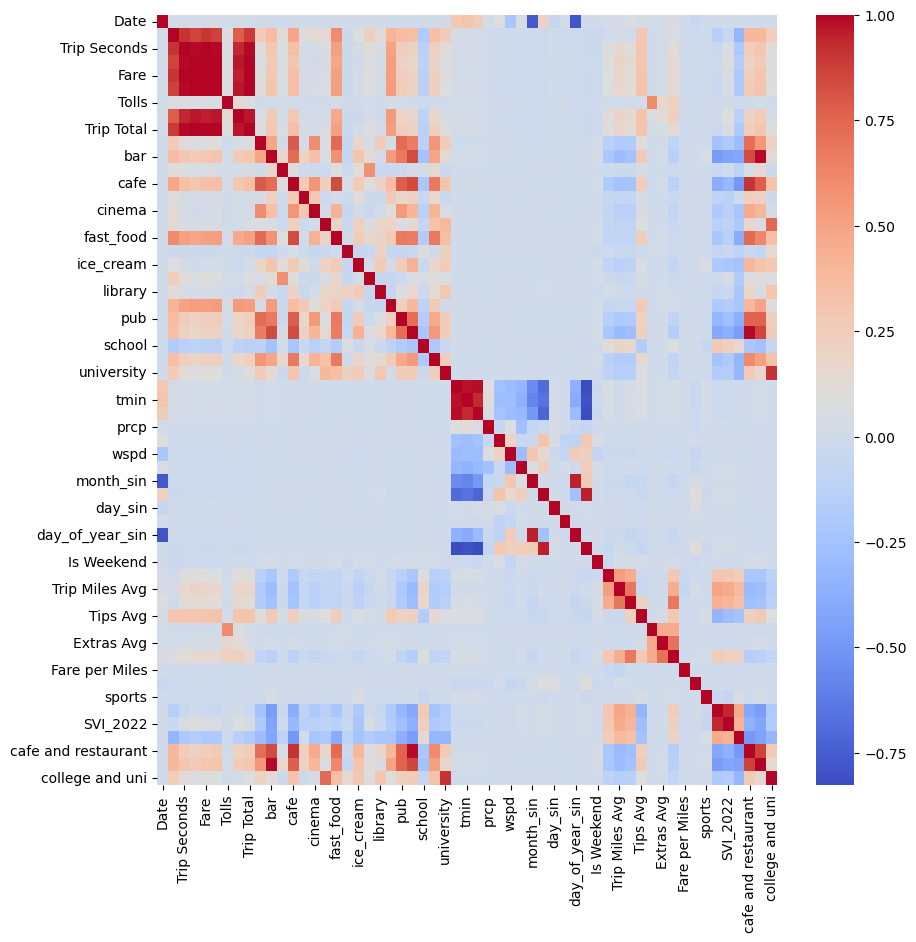

In [411]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(daily_census.drop(['Pickup Census Tract'], axis=1).corr(), ax=ax, annot=False, cmap="coolwarm")

In [412]:
daily_census.drop(['Pickup Census Tract'], axis=1).corr()

Date  Number of Trips  Trip Seconds  \
Date                        1.000000         0.013163      0.015318   
Number of Trips             0.013163         1.000000      0.909373   
Trip Seconds                0.015318         0.909373      1.000000   
Trip Miles                  0.011827         0.858999      0.986233   
Fare                        0.014869         0.900673      0.994350   
Tips                        0.015637         0.869486      0.985754   
Tolls                       0.012182         0.058353      0.063368   
Extras                      0.016171         0.779399      0.942462   
Trip Total                  0.015406         0.890161      0.992640   
bank                       -0.000310         0.266559      0.101097   
bar                        -0.000005         0.371687      0.294879   
biergarten                  0.000868         0.103056      0.063689   
cafe                        0.001151         0.486023      0.344268   
casino                      0.000868         0.090308      0.031869   
cinema                     -0.000561         0.132489      0.032158   
college                     0.000862         0.136936      0.057621   
fast_food                   0.001367         0.606312      0.510246   
hospital                    0.002242        -0.021123     -0.025114   
ice_cream                   0.001468         0.085613      0.020871   
kindergarten                0.001421         0.241714      0.106737   
library                     0.002287         0.113593      0.040077   
nightclub                   0.000821         0.410454      0.502287   
pub                         0.000081         0.362265      0.244943   
restaurant                 -0.000182         0.337151      0.213208   
school                      0.001225        -0.177894     -0.133279   
taxi                        0.002896         0.339235      0.231002   
university                  0.002113         0.264243      0.119511   
tavg                        0.289665         0.022399      0.026234   
tmin                        0.308566         0.020805      0.023758   
tmax                        0.246096         0.023980      0.028189   
prcp                        0.010208        -0.002232     -0.004815   
wdir                        0.080630        -0.007588     -0.009180   
wspd                       -0.217148        -0.001600     -0.010260   
pres                        0.050340        -0.008669     -0.008669   
month_sin                  -0.763923        -0.013566     -0.016859   
month_cos                   0.213391        -0.021861     -0.024113   
day_sin                    -0.061104         0.001760      0.000280   
day_cos                     0.008776        -0.007919     -0.006859   
day_of_year_sin            -0.785613        -0.007369     -0.010138   
day_of_year_cos             0.002920        -0.025281     -0.028234   
Is Weekend                  0.004919        -0.033836     -0.025335   
Trip Seconds Avg            0.023648        -0.000247      0.089650   
Trip Miles Avg              0.021056         0.032798      0.154118   
Fare Avg                    0.059669        -0.001233      0.110238   
Tips Avg                    0.033490         0.294341      0.306446   
Tolls Avg                   0.009718        -0.002759     -0.001588   
Extras Avg                  0.011562         0.024176      0.032018   
Trip Total Avg              0.052958         0.049634      0.129373   
Fare per Miles              0.004814        -0.011514     -0.009220   
holiday                    -0.047234        -0.015987     -0.011894   
sports                     -0.002169        -0.014173     -0.009577   
HDX_2018-2022               0.004927        -0.152912     -0.040577   
SVI_2022                    0.002736        -0.045914      0.048549   
TRV_2018-2022              -0.000949        -0.328872     -0.202766   
cafe and restaurant         0.000187         0.390581      0.257399   
pub and bar and biergarten  0.000025         0.389370   

In [413]:
#remove selected highly correlated columns
daily_census.drop(['SVI_2022'], axis=1, inplace=True)
daily_census.drop(["Fare","Trip Miles","Trip Total","Tolls","pub","bar","biergarten","cafe","restaurant","college","university"], axis=1, inplace=True)

## Problem: Census Tracts with few observations

- Census tracts with few observations pose issues for model training and for train, test and validation splitting

In [414]:
daily_census['Pickup Census Tract'].value_counts()

Pickup Census Tract
17031010702    365
17031081300    365
17031700401    365
17031710700    365
17031720300    365
              ... 
17031090100      1
17031440102      1
17031150501      1
17031831800      1
17031221200      1
Name: count, Length: 542, dtype: int64

In [415]:
sum(daily_census['Pickup Census Tract'].value_counts()<=5)

260

### Version 1: Replace by Census Tracts with nearest POI

- Unused version of replacement for modelling where rare census tracts (below threshold of 5 observations) are replaced by census tract with most similar POI vector. The actual code can be seen in identical chapter for hourly census tract

In [416]:
#mapping_hc_poi generated in chapter for hourly census tract
daily_census['Census Tract POI'] = daily_census['Pickup Census Tract'].replace(mapping_hc_poi)

In [417]:
daily_census['Census Tract POI'].value_counts()

Census Tract POI
17031430800    423
17031500200    380
17031251500    379
17031460200    379
17031440300    376
              ... 
17031560100      6
17031340600      6
17031410600      6
17031430400      6
17031843100      2
Name: count, Length: 283, dtype: int64

### Version 2: Replace by Census Tracts with nearest location

- rare census tracts (below threshold of five observations) are replaced by nearest census tract based on longitude and latitude. Actual code is visible in identical chapter for hourly census tract

In [418]:
census_coordinates = pd.read_csv('data/census_tract_coordinates.csv')

In [419]:
census_coordinates['geoid10'] = census_coordinates['geoid10'].astype('str')

In [420]:
daily_census.shape

(47926, 47)

In [421]:
daily_census = pd.merge(daily_census,census_coordinates[['geoid10','latitude','longitude']],left_on='Pickup Census Tract', right_on='geoid10')

In [422]:
daily_census.shape

(47926, 50)

In [423]:
daily_census.drop(['geoid10'], axis=1, inplace=True)

In [424]:
#mapping_hc_geo generated in hourly census tract chapter
daily_census['Census Tract Geo'] = daily_census['Pickup Census Tract'].replace(mapping_hc_geo)

In [425]:
daily_census['Census Tract Geo'].value_counts()

Census Tract Geo
17031221300    385
17031140602    377
17031251500    377
17031490902    376
17031242200    375
              ... 
17031010600      6
17031030103      6
17031560100      6
17031340600      6
17031410600      6
Name: count, Length: 283, dtype: int64

## Features to CSV

In [428]:
#used for SVM
#daily_census.to_csv('/Users/awaischoudhry/AAA Project/daily_census_features.csv')

## Modelling

### Preprocessing

In [431]:
daily_census.columns

Index(['Date', 'Pickup Census Tract', 'Number of Trips', 'Trip Seconds',
       'Tips', 'Extras', 'bank', 'casino', 'cinema', 'fast_food', 'hospital',
       'ice_cream', 'kindergarten', 'library', 'nightclub', 'school', 'taxi',
       'tavg', 'tmin', 'tmax', 'prcp', 'wdir', 'wspd', 'pres', 'month_sin',
       'month_cos', 'day_sin', 'day_cos', 'day_of_year_sin', 'day_of_year_cos',
       'Is Weekend', 'Trip Seconds Avg', 'Trip Miles Avg', 'Fare Avg',
       'Tips Avg', 'Tolls Avg', 'Extras Avg', 'Trip Total Avg',
       'Fare per Miles', 'holiday', 'sports', 'HDX_2018-2022', 'TRV_2018-2022',
       'cafe and restaurant', 'pub and bar and biergarten', 'college and uni',
       'Census Tract POI', 'latitude', 'longitude', 'Census Tract Geo'],
      dtype='object')

In [432]:
tracts = daily_census["Pickup Census Tract"]
tracts2 = daily_census["Census Tract POI"]
tractGeo= daily_census["Census Tract Geo"]

In [433]:
daily_census.shape

(47926, 50)

In [434]:
len(daily_census["Census Tract Geo"].unique())

283

In [435]:
#generate dummies for census tracts bar one
daily_census = pd.get_dummies(daily_census, columns=["Census Tract Geo"], dtype=float, drop_first=True)
daily_census.shape #one less dummy column than categories is correct, i.e. 50 columns before - census tract geo + 283 tracts - 1 tract = 331

(47926, 331)

In [436]:
daily_census['Census Tract Geo'] = tractGeo

In [437]:
daily_census.dtypes[:50]

Date                            datetime64[ns]
Pickup Census Tract                     object
Number of Trips                          int64
Trip Seconds                           float64
Tips                                   float64
Extras                                 float64
bank                                   float64
casino                                 float64
cinema                                 float64
fast_food                              float64
hospital                               float64
ice_cream                              float64
kindergarten                           float64
library                                float64
nightclub                              float64
school                                 float64
taxi                                   float64
tavg                                   float64
tmin                                   float64
tmax                                   float64
prcp                                   float64
wdir         

In [438]:
daily_census['HDX_2018-2022'] = daily_census['HDX_2018-2022'].astype('float')
daily_census['TRV_2018-2022'] = daily_census['TRV_2018-2022'].astype('float')

In [439]:
daily_census['HDX_2018-2022']

0        87.420030
1        87.420030
2        87.420030
3        87.420030
4        87.420030
           ...    
47921    17.887384
47922    17.887384
47923    93.290761
47924    87.552921
47925     4.040832
Name: HDX_2018-2022, Length: 47926, dtype: float64

In [440]:
daily_census.dtypes[:55]

Date                            datetime64[ns]
Pickup Census Tract                     object
Number of Trips                          int64
Trip Seconds                           float64
Tips                                   float64
Extras                                 float64
bank                                   float64
casino                                 float64
cinema                                 float64
fast_food                              float64
hospital                               float64
ice_cream                              float64
kindergarten                           float64
library                                float64
nightclub                              float64
school                                 float64
taxi                                   float64
tavg                                   float64
tmin                                   float64
tmax                                   float64
prcp                                   float64
wdir         

#### Split

- employ stratified shuffled split in order to achieve equal relative frequencies of census tract between training, test and validation set

In [441]:
#Stratified shuffled split
# Split-Configuration
split_ratio = 0.8

sss = StratifiedShuffleSplit(n_splits=1, test_size=1-split_ratio, random_state=42)

# Index for Train and Test Split
for train_index, test_index in sss.split(daily_census, daily_census['Census Tract Geo']):
    train_set1_dc = daily_census.iloc[train_index]
    test_set_dc = daily_census.iloc[test_index]

In [442]:
train_set1_dc['Census Tract Geo'].value_counts(normalize=False)

Census Tract Geo
17031221300    308
17031140602    301
17031490902    301
17031251500    301
17031730400    300
              ... 
17031010600      5
17031410600      5
17031030103      5
17031560100      5
17031340600      5
Name: count, Length: 283, dtype: int64

In [443]:
test_set_dc['Census Tract Geo'].value_counts(normalize=False)

Census Tract Geo
17031221300    77
17031251500    76
17031140602    76
17031700401    75
17031730400    75
               ..
17031843100     1
17031410500     1
17031030103     1
17031430101     1
17031010600     1
Name: count, Length: 283, dtype: int64

In [444]:
# Split training into training and validation set
split_ratio = 0.75

# StratifiedShuffleSplit erstellen
sss = StratifiedShuffleSplit(n_splits=1, test_size=1-split_ratio, random_state=42)

# Index for Train und validation Split
for train_index_2, val_set in sss.split(train_set1_dc, train_set1_dc['Census Tract Geo']):
    train_set2_dc = train_set1_dc.iloc[train_index_2]
    val_set_dc = train_set1_dc.iloc[val_set]

In [445]:
train_set2_dc['Census Tract Geo'].value_counts(normalize=False)

Census Tract Geo
17031221300    231
17031251500    226
17031140602    226
17031490902    226
17031730400    225
              ... 
17031560100      4
17031110300      4
17031836500      4
17031410600      4
17031030103      4
Name: count, Length: 283, dtype: int64

In [446]:
test_set_dc['Census Tract Geo'].value_counts(normalize=False)

Census Tract Geo
17031221300    77
17031251500    76
17031140602    76
17031700401    75
17031730400    75
               ..
17031843100     1
17031410500     1
17031030103     1
17031430101     1
17031010600     1
Name: count, Length: 283, dtype: int64

In [447]:
val_set_dc['Census Tract Geo'].value_counts(normalize=False)

Census Tract Geo
17031221300    77
17031140602    75
17031242200    75
17031251500    75
17031730400    75
               ..
17031410600     1
17031400500     1
17031340600     1
17031010600     1
17031560100     1
Name: count, Length: 283, dtype: int64

#### Feature Selection and Standardization

In [448]:
train_set2_dc.columns[:55]

Index(['Date', 'Pickup Census Tract', 'Number of Trips', 'Trip Seconds',
       'Tips', 'Extras', 'bank', 'casino', 'cinema', 'fast_food', 'hospital',
       'ice_cream', 'kindergarten', 'library', 'nightclub', 'school', 'taxi',
       'tavg', 'tmin', 'tmax', 'prcp', 'wdir', 'wspd', 'pres', 'month_sin',
       'month_cos', 'day_sin', 'day_cos', 'day_of_year_sin', 'day_of_year_cos',
       'Is Weekend', 'Trip Seconds Avg', 'Trip Miles Avg', 'Fare Avg',
       'Tips Avg', 'Tolls Avg', 'Extras Avg', 'Trip Total Avg',
       'Fare per Miles', 'holiday', 'sports', 'HDX_2018-2022', 'TRV_2018-2022',
       'cafe and restaurant', 'pub and bar and biergarten', 'college and uni',
       'Census Tract POI', 'latitude', 'longitude',
       'Census Tract Geo_17031010300', 'Census Tract Geo_17031010501',
       'Census Tract Geo_17031010502', 'Census Tract Geo_17031010503',
       'Census Tract Geo_17031010600', 'Census Tract Geo_17031010702'],
      dtype='object')

In [449]:
#features dependent on knowledge about number of trips not used
X_train_dc = train_set2_dc.drop(['Trip Seconds Avg', 'Trip Miles Avg', 'Fare Avg',
       'Tips Avg', 'Tolls Avg', 'Extras Avg', 'Trip Total Avg',
       'Fare per Miles','Date', 'Pickup Census Tract', 'Number of Trips', 'Trip Seconds','Tips', 'Extras', 'Census Tract POI', 'latitude', 'longitude','Census Tract Geo'], axis=1)
y_train_dc = train_set2_dc["Number of Trips"]

X_test_dc = test_set_dc.drop(['Trip Seconds Avg', 'Trip Miles Avg', 'Fare Avg',
       'Tips Avg', 'Tolls Avg', 'Extras Avg', 'Trip Total Avg',
       'Fare per Miles','Date', 'Pickup Census Tract', 'Number of Trips', 'Trip Seconds','Tips', 'Extras', 'Census Tract POI', 'latitude', 'longitude','Census Tract Geo'], axis=1)
y_test_dc = test_set_dc["Number of Trips"]


X_val_dc = val_set_dc.drop(['Trip Seconds Avg', 'Trip Miles Avg', 'Fare Avg',
       'Tips Avg', 'Tolls Avg', 'Extras Avg', 'Trip Total Avg',
       'Fare per Miles','Date', 'Pickup Census Tract', 'Number of Trips', 'Trip Seconds','Tips', 'Extras', 'Census Tract POI', 'latitude', 'longitude','Census Tract Geo'], axis=1)
y_val_dc = val_set_dc["Number of Trips"]


In [450]:
X_train_dc.columns[:50]

Index(['bank', 'casino', 'cinema', 'fast_food', 'hospital', 'ice_cream',
       'kindergarten', 'library', 'nightclub', 'school', 'taxi', 'tavg',
       'tmin', 'tmax', 'prcp', 'wdir', 'wspd', 'pres', 'month_sin',
       'month_cos', 'day_sin', 'day_cos', 'day_of_year_sin', 'day_of_year_cos',
       'Is Weekend', 'holiday', 'sports', 'HDX_2018-2022', 'TRV_2018-2022',
       'cafe and restaurant', 'pub and bar and biergarten', 'college and uni',
       'Census Tract Geo_17031010300', 'Census Tract Geo_17031010501',
       'Census Tract Geo_17031010502', 'Census Tract Geo_17031010503',
       'Census Tract Geo_17031010600', 'Census Tract Geo_17031010702',
       'Census Tract Geo_17031020200', 'Census Tract Geo_17031020500',
       'Census Tract Geo_17031020601', 'Census Tract Geo_17031020602',
       'Census Tract Geo_17031020702', 'Census Tract Geo_17031020801',
       'Census Tract Geo_17031020802', 'Census Tract Geo_17031020901',
       'Census Tract Geo_17031020902', 'Census Tract G

In [451]:
# Liste of Dummy-Variables
known_dummy_columns = ['Is Weekend', 'holiday', 'sports']

# List of dummies
geo_dummy_columns = X_train_dc.columns[X_train_dc.columns.str.contains('Census Tract Geo_')]

# collect
dummy_columns = known_dummy_columns + list(geo_dummy_columns)

# Numeric columns
numeric_columns = X_train_dc.columns.difference(dummy_columns)


In [452]:
# Z-Standardization only for numeric columns
scaler = StandardScaler()
X_train_dc[numeric_columns] = scaler.fit_transform(X_train_dc[numeric_columns])

X_test_dc[numeric_columns] = scaler.transform(X_test_dc[numeric_columns])

X_val_dc[numeric_columns] = scaler.transform(X_val_dc[numeric_columns])

### Validations

In [453]:
X_train_dc.std()

bank                            1.000017
casino                          1.000017
cinema                          1.000017
fast_food                       1.000017
hospital                        1.000017
                                  ...   
Census Tract Geo_17031843600    0.016678
Census Tract Geo_17031843700    0.011794
Census Tract Geo_17031843900    0.023583
Census Tract Geo_17031980000    0.087332
Census Tract Geo_17031980100    0.087135
Length: 314, dtype: float64

In [454]:
X_train_dc.mean()

bank                           -8.772133e-18
casino                         -1.680296e-17
cinema                         -5.510382e-17
fast_food                       4.942047e-19
hospital                       -8.154377e-18
                                    ...     
Census Tract Geo_17031843600    2.782125e-04
Census Tract Geo_17031843700    1.391062e-04
Census Tract Geo_17031843900    5.564250e-04
Census Tract Geo_17031980000    7.685620e-03
Census Tract Geo_17031980100    7.650843e-03
Length: 314, dtype: float64

In [455]:
X_test_dc.mean()

bank                            0.000252
casino                         -0.000009
cinema                         -0.000024
fast_food                      -0.000402
hospital                        0.000901
                                  ...   
Census Tract Geo_17031843600    0.000313
Census Tract Geo_17031843700    0.000209
Census Tract Geo_17031843900    0.000522
Census Tract Geo_17031980000    0.007720
Census Tract Geo_17031980100    0.007615
Length: 314, dtype: float64

In [456]:
X_test_dc.std()

bank                            1.000170
casino                          1.000000
cinema                          1.000916
fast_food                       1.000078
hospital                        1.003885
                                  ...   
Census Tract Geo_17031843600    0.017689
Census Tract Geo_17031843700    0.014444
Census Tract Geo_17031843900    0.022834
Census Tract Geo_17031980000    0.087526
Census Tract Geo_17031980100    0.086937
Length: 314, dtype: float64

In [457]:
X_val_dc.std()

bank                            1.000276
casino                          1.000052
cinema                          1.000966
fast_food                       1.000061
hospital                        1.003935
                                  ...   
Census Tract Geo_17031843600    0.017690
Census Tract Geo_17031843700    0.014444
Census Tract Geo_17031843900    0.025013
Census Tract Geo_17031980000    0.087531
Census Tract Geo_17031980100    0.086942
Length: 314, dtype: float64

In [458]:
X_val_dc.mean()

bank                           -5.510543e-04
casino                         -2.631640e-17
cinema                         -5.930456e-17
fast_food                      -3.626514e-04
hospital                        9.235323e-04
                                    ...     
Census Tract Geo_17031843600    3.129890e-04
Census Tract Geo_17031843700    2.086594e-04
Census Tract Geo_17031843900    6.259781e-04
Census Tract Geo_17031980000    7.720396e-03
Census Tract Geo_17031980100    7.616067e-03
Length: 314, dtype: float64

In [459]:
X_test_dc.std()[lambda x : x==np.max(X_test_dc.std())]

prcp    1.007634
dtype: float64

In [460]:
X_train_dc.iloc[2,:50]

bank                            0.300912
casino                         -0.087604
cinema                         -0.228798
fast_food                      -0.244312
hospital                       -0.213336
ice_cream                      -0.479186
kindergarten                    3.211975
library                        -0.440584
nightclub                      -0.256155
school                         -1.181387
taxi                           -0.276268
tavg                           -1.164001
tmin                           -0.817624
tmax                           -1.374392
prcp                            0.125938
wdir                           -1.585664
wspd                            0.484129
pres                            0.197196
month_sin                       1.413650
month_cos                       0.024236
day_sin                         1.254192
day_cos                        -0.598406
day_of_year_sin                 1.294671
day_of_year_cos                 0.548549
Is Weekend      

### DF to Numpy Arrays

In [461]:
X_train_data_dc = X_train_dc.to_numpy()
X_test_data_dc = X_test_dc.to_numpy()
X_val_data_dc = X_val_dc.to_numpy()

y_train_data_dc = y_train_dc.to_numpy()
y_test_data_dc = y_test_dc.to_numpy()
y_val_data_dc = y_val_dc.to_numpy()

In [462]:
X_train_data_dc.shape

(28755, 314)

### Tuning and Training

#### Tuning

In [1272]:
#create manageable search space
def build_model_census_daily(hp):
    model = models.Sequential()
    model.add(ks.Input(shape=(X_train_data_dc.shape[1],)))
    for i in range(hp.Int("num_layers", 1, 2)):
        model.add(
            layers.Dense(
                # Tune number of units separately.
                units=hp.Int(f"units_{i}", min_value=35, max_value=320, step=95),
                kernel_regularizer=regularizers.L1L2(l1=hp.Choice("l1_rate", values=[0.0001,0.001,0.01]), l2=hp.Choice("l2_rate", values=[0.0001,0.001,0.01])),
                activation="relu",
            )
        )
    model.add(layers.Dense(units=hp.Int(f"units_3", min_value=35, max_value=320, step=95),
            kernel_regularizer=regularizers.L1L2(l1=hp.Choice("l1_rate", values=[0.0001,0.001,0.01]), l2=hp.Choice("l2_rate", values=[0.0001,0.001,0.01])),
            activation="relu",
        )
    )
    model.add(layers.Dense(units=1, activation="relu"))
    opt = ks.optimizers.Adam(
        learning_rate=0.001,
        beta_1=0.9,
        beta_2=0.999,
    )
    model.compile(
        optimizer=opt,
        loss="mse",
        metrics=[ks.metrics.R2Score(),'mae',ks.metrics.MeanAbsolutePercentageError()],
    )
    return model

In [1273]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8)

In [1274]:
#initialize tuning algorithm
tuner_census_daily = keras_tuner.BayesianOptimization(
        build_model_census_daily, #The model function we wrote
        seed=777, #Seed for evaluation
        objective='val_loss', #Which objective to keep track of
        max_trials=30, #Number of trials to try
        directory="hyperparameter_tuning",
	project_name='dc_withAvg_bayes_noDrop_rightStd_withValSet_rightAct_1') 
        

In [1275]:
tuner_census_daily.search_space_summary()

Search space summary
Default search space size: 5
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 2, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 35, 'max_value': 320, 'step': 95, 'sampling': 'linear'}
l1_rate (Choice)
{'default': 0.0001, 'conditions': [], 'values': [0.0001, 0.001, 0.01], 'ordered': True}
l2_rate (Choice)
{'default': 0.0001, 'conditions': [], 'values': [0.0001, 0.001, 0.01], 'ordered': True}
units_3 (Int)
{'default': None, 'conditions': [], 'min_value': 35, 'max_value': 320, 'step': 95, 'sampling': 'linear'}


In [1276]:
tuner_census_daily.search(X_train_data_dc, y_train_data_dc, epochs=20, validation_data=(X_val_data_dc,y_val_data_dc), callbacks=[stop_early])

Trial 30 Complete [00h 00m 26s]
val_loss: 4901.78369140625

Best val_loss So Far: 4901.78369140625
Total elapsed time: 00h 11m 08s


In [1277]:
tuner_census_daily.results_summary()

Results summary
Results in hyperparameter_tuning/dc_withAvg_bayes_noDrop_rightStd_withValSet_rightAct_1
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 29 summary
Hyperparameters:
num_layers: 2
units_0: 225
l1_rate: 0.0001
l2_rate: 0.0001
units_3: 225
units_1: 130
Score: 4901.78369140625

Trial 21 summary
Hyperparameters:
num_layers: 2
units_0: 225
l1_rate: 0.0001
l2_rate: 0.0001
units_3: 225
units_1: 35
Score: 4932.14306640625

Trial 27 summary
Hyperparameters:
num_layers: 2
units_0: 130
l1_rate: 0.0001
l2_rate: 0.0001
units_3: 320
units_1: 35
Score: 5000.26953125

Trial 18 summary
Hyperparameters:
num_layers: 2
units_0: 225
l1_rate: 0.0001
l2_rate: 0.0001
units_3: 225
units_1: 130
Score: 5012.57763671875

Trial 22 summary
Hyperparameters:
num_layers: 2
units_0: 130
l1_rate: 0.0001
l2_rate: 0.0001
units_3: 225
units_1: 35
Score: 5031.35791015625

Trial 20 summary
Hyperparameters:
num_layers: 2
units_0: 130
l1_rate: 0.0001
l2_rate: 0.0001
units_3: 320
units_1:

#### Training

In [1278]:
#retrieve model with best hyperparameter combination
best_model_dc = tuner_census_daily.get_best_models(num_models=1)[0]

/opt/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [1279]:
best_model_dc.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 225)            │        70,875 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 130)            │        29,380 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 225)            │        29,475 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           226 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 129,956 (507.64 KB)

 Trainable params: 129,956 (507.64 KB)

 Non-trainable params: 0 (0.00 B)

In [1280]:
best_model_dc.get_config()

{'name': 'sequential',
 'trainable': True,
 'dtype': {'module': 'keras',
  'class_name': 'DTypePolicy',
  'config': {'name': 'float32'},
  'registered_name': None},
 'layers': [{'module': 'keras.layers',
   'class_name': 'InputLayer',
   'config': {'batch_shape': (None, 314),
    'dtype': 'float32',
    'sparse': False,
    'name': 'input_layer'},
   'registered_name': None},
  {'module': 'keras.layers',
   'class_name': 'Dense',
   'config': {'name': 'dense',
    'trainable': True,
    'dtype': {'module': 'keras',
     'class_name': 'DTypePolicy',
     'config': {'name': 'float32'},
     'registered_name': None},
    'units': 225,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'module': 'keras.initializers',
     'class_name': 'GlorotUniform',
     'config': {'seed': None},
     'registered_name': None},
    'bias_initializer': {'module': 'keras.initializers',
     'class_name': 'Zeros',
     'config': {},
     'registered_name': None},
    'kernel_regulari

In [1281]:
best_model_dc.save('/Users/awaischoudhry/AAA Project/full_models/untrained_dc_noAvg_0810_rightAct_1.keras')

In [1283]:
#implement early stopping criterion and gathering of weights at epoch with best validation score
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False)

model_file = '/Users/awaischoudhry/AAA Project/hyperparameter_tuning/weights_dc_bayes_withAvg_0809__withValset_rightAct_1.keras'

checkpoint = tf.keras.callbacks.ModelCheckpoint(model_file, 
                    monitor="val_loss", mode="min", 
                    save_best_only=True, verbose=1)

In [1284]:
history_dc_noDrop = best_model_dc.fit(X_train_data_dc, y_train_data_dc, epochs=1000, validation_data=(X_val_data_dc,y_val_data_dc), callbacks=[stop_early, checkpoint])

Epoch 1/1000
879/899 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step - loss: 4857.3330 - mae: 22.2966 - mean_absolute_percentage_error: 100.3928 - r2_score: 0.9578
Epoch 1: val_loss improved from inf to 5981.65820, saving model to /Users/awaischoudhry/AAA Project/hyperparameter_tuning/weights_dc_bayes_withAvg_0809__withValset_rightAct_1.keras
899/899 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 4871.5337 - mae: 22.3132 - mean_absolute_percentage_error: 100.5083 - r2_score: 0.9577 - val_loss: 5981.6582 - val_mae: 24.2418 - val_mean_absolute_percentage_error: 103.5702 - val_r2_score: 0.9486
Epoch 2/1000
857/899 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step - loss: 5283.0610 - mae: 21.5008 - mean_absolute_percentage_error: 81.3489 - r2_score: 0.9552
Epoch 2: val_loss did not improve from 5981.65820
899/899 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5282.1255 - mae: 21.5182 - mean_absolute_percentage_error: 81.4214 - r2_score: 0.9551 - val_loss: 6092.0854 - val_mae: 25.3520 - val_mean_absolute_percentage_error: 93.0275

In [1285]:
best_model_dc_full_noDrop = ks.saving.load_model(model_file, custom_objects=None, compile=True, safe_mode=True)

In [1286]:
best_model_dc_full_noDrop.save('/Users/awaischoudhry/AAA Project/full_models/trained_dc_noAvg_0810_rightAct_1.keras')

In [1287]:
#holdout test set evaluation
best_model_dc_full_noDrop.evaluate(X_test_data_dc, y_test_data_dc)

300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 6795.9829 - mae: 24.6686 - mean_absolute_percentage_error: 105.9504 - r2_score: 0.9393


[6432.13818359375, 0.9454773664474487, 24.64786720275879, 104.06085205078125]

#### Results (not final)

- final results in report

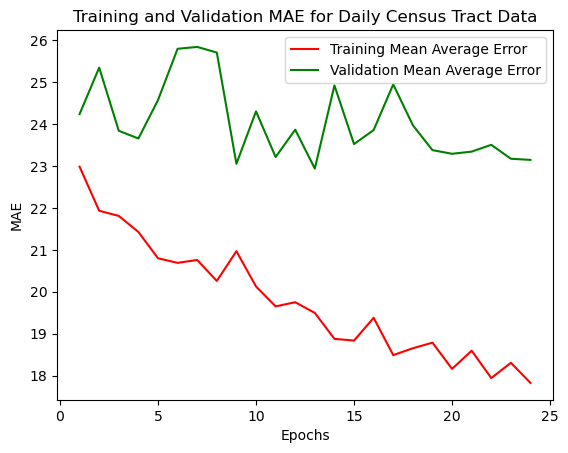

In [1288]:
mae_dc_noDrop = history_dc_noDrop.history['mae']
val_mae_dc_noDrop = history_dc_noDrop.history['val_mae']

epochs = range(1, len(mae_dc_noDrop) + 1)

plt.plot(epochs, mae_dc_noDrop, '-', c='red', label='Training Mean Average Error')
plt.plot(epochs, val_mae_dc_noDrop, '-', c='green', label='Validation Mean Average Error')
plt.title('Training and Validation MAE for Daily Census Tract Data')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

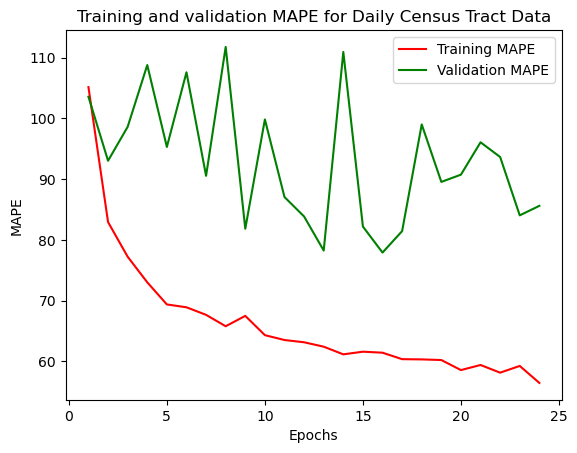

In [1289]:
mape_dc_noDrop = history_dc_noDrop.history['mean_absolute_percentage_error']
val_mape_dc_noDrop = history_dc_noDrop.history['val_mean_absolute_percentage_error']

epochs = range(1, len(mape_dc_noDrop) + 1)

plt.plot(epochs, mape_dc_noDrop, '-', c='red', label='Training MAPE')
plt.plot(epochs, val_mape_dc_noDrop, '-', c='green', label='Validation MAPE')
plt.title('Training and validation MAPE for Daily Census Tract Data')
plt.xlabel('Epochs')
plt.ylabel('MAPE')
plt.legend()
plt.show()

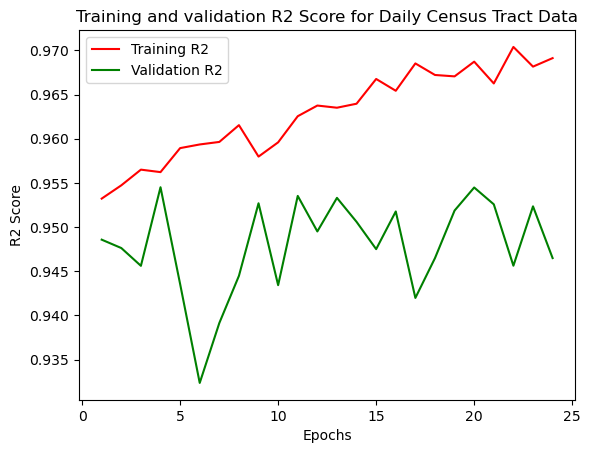

In [1290]:
r2_dc_noDrop = history_dc_noDrop.history['r2_score']
val_r2_dc_noDrop = history_dc_noDrop.history['val_r2_score']

epochs = range(1, len(r2_dc_noDrop) + 1)

plt.plot(epochs, r2_dc_noDrop, '-', c='red', label='Training R2')
plt.plot(epochs, val_r2_dc_noDrop, '-', c='green', label='Validation R2')
plt.title('Training and validation R2 Score for Daily Census Tract Data')
plt.xlabel('Epochs')
plt.ylabel('R2 Score')
plt.legend()
plt.show()

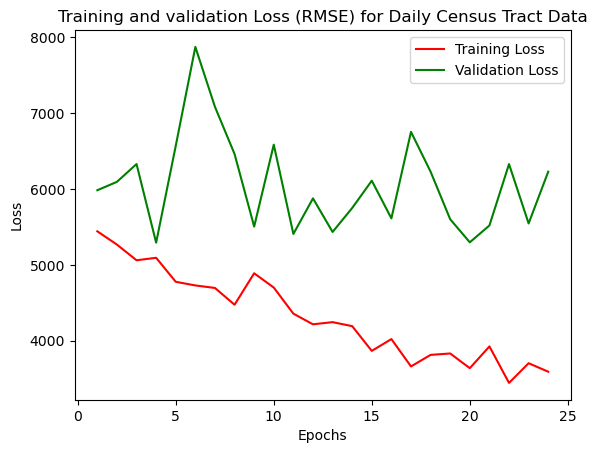

In [1291]:
loss_dc_noDrop = history_dc_noDrop.history['loss']
val_loss_dc_noDrop = history_dc_noDrop.history['val_loss']

epochs = range(1, len(loss_dc_noDrop) + 1)

plt.plot(epochs, loss_dc_noDrop, '-', c='red', label='Training Loss')
plt.plot(epochs, val_loss_dc_noDrop, '-', c='green', label='Validation Loss')
plt.title('Training and validation Loss (RMSE) for Daily Census Tract Data')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [1292]:
dc_scores_noDrop = percentile_list = pd.DataFrame(
    {'loss': loss_dc_noDrop,
     'val_loss': val_loss_dc_noDrop,
     'mae': mae_dc_noDrop,
     'val_mae': val_mae_dc_noDrop,
     'mape': mape_dc_noDrop,
     'val_mape': val_mape_dc_noDrop,
     'r2': r2_dc_noDrop,
     'val_r2': val_r2_dc_noDrop
    })

dc_scores_noDrop['Model_trained']='/Users/awaischoudhry/AAA Project/full_models/trained_dc_noAvg_0810_rightAct_1.keras'

dc_scores_noDrop['Model_untrained']='/Users/awaischoudhry/AAA Project/full_models/untrained_dc_noAvg_0810_rightAct_1.keras'

dc_scores_noDrop['Hyperparameter']='hyperparameter_tuning/dc_noAvg_bayes_noDrop_rightStd_withValSet_rightAct_1'

dc_scores_noDrop.to_csv('/Users/awaischoudhry/AAA Project/history_dc_noAvg_noDrop_1.csv')

#### Dropout Layers

- manually test dropout layers of proporion 0.25 and 0.5

In [1294]:
best_model_dc.get_config()

{'name': 'sequential',
 'trainable': True,
 'dtype': {'module': 'keras',
  'class_name': 'DTypePolicy',
  'config': {'name': 'float32'},
  'registered_name': None},
 'layers': [{'module': 'keras.layers',
   'class_name': 'InputLayer',
   'config': {'batch_shape': (None, 314),
    'dtype': 'float32',
    'sparse': False,
    'name': 'input_layer'},
   'registered_name': None},
  {'module': 'keras.layers',
   'class_name': 'Dense',
   'config': {'name': 'dense',
    'trainable': True,
    'dtype': {'module': 'keras',
     'class_name': 'DTypePolicy',
     'config': {'name': 'float32'},
     'registered_name': None},
    'units': 225,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'module': 'keras.initializers',
     'class_name': 'GlorotUniform',
     'config': {'seed': None},
     'registered_name': None},
    'bias_initializer': {'module': 'keras.initializers',
     'class_name': 'Zeros',
     'config': {},
     'registered_name': None},
    'kernel_regulari

In [1302]:
best_model_dc_withDrop = models.Sequential()
best_model_dc_withDrop.add(ks.Input(shape=(X_train_data_dc.shape[1],)))
best_model_dc_withDrop.add(layers.Dense(225, activation='relu', kernel_regularizer=regularizers.L1L2(l1=0.0001, l2=0.0001)))
best_model_dc_withDrop.add(layers.Dropout(0.5, seed=777))
best_model_dc_withDrop.add(layers.Dense(130, activation='relu', kernel_regularizer=regularizers.L1L2(l1=0.0001, l2=0.0001)))
best_model_dc_withDrop.add(layers.Dropout(0.5, seed=777))
best_model_dc_withDrop.add(layers.Dense(225, activation='relu', kernel_regularizer=regularizers.L1L2(l1=0.0001, l2=0.0001)))
best_model_dc_withDrop.add(layers.Dropout(0.5, seed=777))
best_model_dc_withDrop.add(layers.Dense(1, activation='relu'))

opt = ks.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999
)

best_model_dc_withDrop.compile(optimizer=opt, loss='mse', metrics=[ks.metrics.R2Score(),'mae',ks.metrics.MeanAbsolutePercentageError()]) #optimizer: adam (...)

In [1303]:
best_model_dc_withDrop.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 225)            │        70,875 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 225)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 130)            │        29,380 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 130)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 225)            │        29,475 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 225)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           226 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 129,956 (507.64 KB)

 Trainable params: 129,956 (507.64 KB)

 Non-trainable params: 0 (0.00 B)

In [1304]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False)

model_file = '/Users/awaischoudhry/AAA Project/weights/weights_dc_bayes_withAvg_0809__withValset_rightAct_withDrop_0point5_1.keras'

checkpoint = tf.keras.callbacks.ModelCheckpoint(model_file, 
                    monitor="val_loss", mode="min", 
                    save_best_only=True, verbose=1)

In [1305]:
history_dc_withDrop = best_model_dc_withDrop.fit(X_train_data_dc, y_train_data_dc, epochs=1000, validation_data=(X_val_data_dc,y_val_data_dc), callbacks=[stop_early, checkpoint])

Epoch 1/1000
889/899 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 79814.4297 - mae: 104.3070 - mean_absolute_percentage_error: 895.1128 - r2_score: 0.3731
Epoch 1: val_loss improved from inf to 9986.04102, saving model to /Users/awaischoudhry/AAA Project/weights/weights_dc_bayes_withAvg_0809__withValset_rightAct_withDrop_0point5_1.keras
899/899 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 79364.6562 - mae: 103.9959 - mean_absolute_percentage_error: 893.2440 - r2_score: 0.3762 - val_loss: 9986.0410 - val_mae: 39.5729 - val_mean_absolute_percentage_error: 315.8002 - val_r2_score: 0.9141
Epoch 2/1000
858/899 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15776.4150 - mae: 46.5369 - mean_absolute_percentage_error: 314.3193 - r2_score: 0.8593
Epoch 2: val_loss improved from 9986.04102 to 8296.49707, saving model to /Users/awaischoudhry/AAA Project/weights/weights_dc_bayes_withAvg_0809__withValset_rightAct_withDrop_0point5_1.keras
899/899 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 15779.7490 - mae: 46.5043 

In [1306]:
best_model_dc_full_withDrop = ks.saving.load_model(model_file, custom_objects=None, compile=True, safe_mode=True)

In [1307]:
best_model_dc_full_withDrop.save('/Users/awaischoudhry/AAA Project/full_models/trained_dc_noAvg_0810_rightAct_withDrop_0point5_1.keras')

In [1308]:
best_model_dc_full_withDrop.evaluate(X_test_data_dc, y_test_data_dc)

300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - loss: 7046.1714 - mae: 25.1267 - mean_absolute_percentage_error: 89.4701 - r2_score: 0.9375


[6934.67724609375, 0.9412325620651245, 25.35841178894043, 88.2037582397461]

In [1310]:
dc_scores_withDrop = pd.DataFrame(
    {'loss': history_dc_withDrop.history['loss'],
     'val_loss': history_dc_withDrop.history['val_loss'],
     'mae': history_dc_withDrop.history['mae'],
     'val_mae': history_dc_withDrop.history['val_mae'],
     'mape': history_dc_withDrop.history['mean_absolute_percentage_error'],
     'val_mape': history_dc_withDrop.history['val_mean_absolute_percentage_error'],
     'r2': history_dc_withDrop.history['r2_score'],
     'val_r2': history_dc_withDrop.history['val_r2_score']
    })

dc_scores_withDrop['Model_trained']='/Users/awaischoudhry/AAA Project/full_models/trained_dc_noAvg_0810_rightAct_withDrop_0point5_1.keras'

dc_scores_withDrop['Hyperparameter']='hyperparameter_tuning/dc_noAvg_bayes_noDrop_rightStd_withValSet_rightAct_1'

dc_scores_withDrop.to_csv('/Users/awaischoudhry/AAA Project/history_dc_noAvg_withDrop_1.csv')

#### New Metrics

- generate potentially interesting metrics

In [477]:
best_model_dc_reload = ks.saving.load_model('/Users/awaischoudhry/AAA Project/full_models/untrained_dc_noAvg_0810_rightAct_1.keras', custom_objects=None, compile=True, safe_mode=True)

In [478]:
from tensorflow.keras.saving import register_keras_serializable

opt = ks.optimizers.Adam(
        learning_rate=0.001,
        beta_1=0.9,
        beta_2=0.999,
    )

@register_keras_serializable()
def smape(y_true, y_pred):
    """
    Berechnet den Symmetric Mean Absolute Percentage Error (sMAPE).

    Args:
    y_true -- Die tatsächlichen Werte.
    y_pred -- Die vorhergesagten Werte.

    Returns:
    Der sMAPE-Wert.
    """
    y_true = K.cast(y_true, dtype='float32')  
    y_pred = K.cast(y_pred, dtype='float32')

    epsilon = K.epsilon()  # to prevent division by 0
    numerator = K.abs(y_pred - y_true)
    denominator = K.abs(y_true) + K.abs(y_pred) + epsilon
    smape_value = 2 * K.mean(numerator / denominator)
    return smape_value

@register_keras_serializable()
def mase(y_true, y_pred):
    """
    Berechnet den Mean Absolute Scaled Error (MASE) basierend auf der Baseline-Vorhersage
    als Mittelwert der tatsächlichen Werte.

    Args:
    y_true -- Die tatsächlichen Werte.
    y_pred -- Die vorhergesagten Werte.

    Returns:
    Der MASE-Wert.
    """

    y_true = K.cast(y_true, dtype='float32')  #
    y_pred = K.cast(y_pred, dtype='float32')

    y_mean = K.mean(y_true)
    
    mae_model = K.mean(K.abs(y_true - y_pred))
    
    mae_baseline = K.mean(K.abs(y_true - y_mean))
    
    mase_value = mae_model / (mae_baseline + K.epsilon())  # epsilon to prevent division by 0
    return mase_value


best_model_dc_reload.compile(optimizer=opt,  
                   loss='mse',  
                   metrics=[ks.metrics.R2Score(),'mae',ks.metrics.MeanAbsolutePercentageError(),ks.metrics.MeanSquaredLogarithmicError(), smape, mase])


In [479]:
best_model_dc_reload.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 225)            │        70,875 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 130)            │        29,380 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 225)            │        29,475 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           226 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 129,956 (507.64 KB)

 Trainable params: 129,956 (507.64 KB)

 Non-trainable params: 0 (0.00 B)

In [480]:
best_model_dc_reload.get_config()

{'name': 'sequential',
 'trainable': True,
 'dtype': {'module': 'keras',
  'class_name': 'DTypePolicy',
  'config': {'name': 'float32'},
  'registered_name': None},
 'layers': [{'module': 'keras.layers',
   'class_name': 'InputLayer',
   'config': {'batch_shape': (None, 314),
    'dtype': 'float32',
    'sparse': False,
    'name': 'input_layer'},
   'registered_name': None},
  {'module': 'keras.layers',
   'class_name': 'Dense',
   'config': {'name': 'dense',
    'trainable': True,
    'dtype': {'module': 'keras',
     'class_name': 'DTypePolicy',
     'config': {'name': 'float32'},
     'registered_name': None},
    'units': 225,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'module': 'keras.initializers',
     'class_name': 'GlorotUniform',
     'config': {'seed': None},
     'registered_name': None},
    'bias_initializer': {'module': 'keras.initializers',
     'class_name': 'Zeros',
     'config': {},
     'registered_name': None},
    'kernel_regulari

In [481]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False)

model_file_dc_nm = '/Users/awaischoudhry/AAA Project/weights/weights_dc_bayes_noAvg_0812_withValset_rightAct_newMetrics.keras'

checkpoint = tf.keras.callbacks.ModelCheckpoint(model_file_dc_nm, 
                    monitor="val_loss", mode="min", 
                    save_best_only=True, verbose=1)

In [482]:
history_dc_nm = best_model_dc_reload.fit(X_train_data_dc, y_train_data_dc, epochs=1000, validation_data=(X_val_data_dc,y_val_data_dc), callbacks=[stop_early, checkpoint])

Epoch 1/1000
873/899 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4961.3218 - mae: 21.7854 - mase: 1.2265 - mean_absolute_percentage_error: 100.2498 - mean_squared_logarithmic_error: 0.4770 - r2_score: 0.9541 - smape: 1.2817
Epoch 1: val_loss improved from inf to 8267.45801, saving model to /Users/awaischoudhry/AAA Project/weights/weights_dc_bayes_noAvg_0812_withValset_rightAct_newMetrics.keras
899/899 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 4974.0015 - mae: 21.8113 - mase: 1.2264 - mean_absolute_percentage_error: 100.3386 - mean_squared_logarithmic_error: 0.4781 - r2_score: 0.9541 - smape: 1.2822 - val_loss: 8267.4580 - val_mae: 26.2090 - val_mase: 1.1784 - val_mean_absolute_percentage_error: 96.8717 - val_mean_squared_logarithmic_error: 0.6589 - val_r2_score: 0.9289 - val_smape: 1.3646
Epoch 2/1000
855/899 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5881.4341 - mae: 21.8759 - mase: 1.2266 - mean_absolute_percentage_error: 83.6803 - mean_squared_logarithmic_error: 0.4623 - r2_score: 0.9492 

In [483]:
best_model_dc_full_noDrop_reload = ks.saving.load_model(model_file_dc_nm, custom_objects=None, compile=True, safe_mode=True)

In [484]:
best_model_dc_full_noDrop_reload.save('/Users/awaischoudhry/AAA Project/full_models/trained_dc_noAvg_0812_rightAct_newMetrics.keras')

In [485]:
best_model_dc_full_noDrop_reload.evaluate(X_test_data_dc,y_test_data_dc)

300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - loss: 6678.5352 - mae: 23.8450 - mase: 1.2267 - mean_absolute_percentage_error: 83.4100 - mean_squared_logarithmic_error: 0.4504 - r2_score: 0.9405 - smape: 1.3085


[6382.14306640625,
 0.9459012746810913,
 24.16318702697754,
 83.47095489501953,
 0.4484266936779022,
 1.309977650642395,
 1.2312983274459839]

In [486]:
dc_scores_noDrop_nm = pd.DataFrame(
    {'loss': history_dc_nm.history['loss'],
     'val_loss': history_dc_nm.history['val_loss'],
     'mae': history_dc_nm.history['mae'],
     'val_mae': history_dc_nm.history['val_mae'],
     'mape': history_dc_nm.history['mean_absolute_percentage_error'],
     'val_mape': history_dc_nm.history['val_mean_absolute_percentage_error'],
     'r2': history_dc_nm.history['r2_score'],
     'val_r2': history_dc_nm.history['val_r2_score'],
     'mase': history_dc_nm.history['mase'],
     'val_mase': history_dc_nm.history['val_mase'],
     'msle': history_dc_nm.history['mean_squared_logarithmic_error'],
     'val_msle': history_dc_nm.history['val_mean_squared_logarithmic_error'],
     'smape': history_dc_nm.history['smape'],
     'val_smape': history_dc_nm.history['val_smape']
    })

dc_scores_noDrop_nm['Model_trained']='/Users/awaischoudhry/AAA Project/full_models/trained_dc_noAvg_0812_rightAct_newMetrics.keras'

dc_scores_noDrop_nm['Model_untrained']='/Users/awaischoudhry/AAA Project/full_models/untrained_dc_noAvg_0810_rightAct_1.keras'

dc_scores_noDrop_nm.to_csv('/Users/awaischoudhry/AAA Project/history_dc_noAvg_noDrop_newMetrics_1.csv')

# Hourly Census

## Feature Creation

In [166]:
hourly_census = pd.read_csv("data/census_tract_hourly_data.csv")

In [167]:
hourly_census.head()

Hour  Pickup Census Tract  Number of Trips  Trip Seconds  \
0  2023-01-01 00:00:00          17031010702                3        4260.0   
1  2023-01-01 00:00:00          17031231200                4        3669.0   
2  2023-01-01 00:00:00          17031241500                2        1918.0   
3  2023-01-01 00:00:00          17031242200               21       20209.0   
4  2023-01-01 00:00:00          17031320100               13        6879.0   

   Trip Miles    Fare   Tips  Tolls  Extras  Trip Total  \
0        1.90   19.50   0.00    0.0     0.0       19.50   
1        6.14   72.60  17.31    0.0     0.0       89.91   
2        2.95   29.34   7.32    0.0     0.0       36.66   
3       69.47  322.13  53.28    0.0     3.0      379.41   
4       14.90  152.50  32.54    0.0     7.5      196.54   

                                            geometry  bank   bar  biergarten  \
0  POLYGON ((-87.67539699997683 42.01087899997641...   1.0   1.0         0.0   
1  POLYGON ((-87.71631400000818 41.89546100000806...   0.0   0.0         0.0   
2  POLYGON ((-87.6736789999921 41.907955999997995...   1.0   6.0         0.0   
3  POLYGON ((-87.67328800002127 41.90325100002592...   1.0   4.0         0.0   
4  POLYGON ((-87.61343799999288 41.88788700000464...   4.0  12.0         0.0   

   cafe  casino  cinema  college  fast_food  hospital  ice_cream  \
0   0.0     0.0     0.0      0.0        3.0       0.0        1.0   
1   0.0     0.0     0.0      0.0        0.0       0.0        0.0   
2   3.0     0.0     0.0      0.0        7.0       0.0        1.0   
3   0.0     0.0     0.0      0.0        0.0       0.0        1.0   
4  20.0     0.0     0.0      2.0       30.0       0.0        1.0   

   kindergarten  library  nightclub  pub  restaurant  school  taxi  \
0           0.0      1.0        0.0  0.0        13.0     2.0   0.0   
1           0.0      0.0        0.0  0.0         1.0     2.0   0.0   
2           0.0      0.0        0.0  2.0        18.0     0.0   0.0   
3           0.0      0.0        0.0  1.0         9.0     1.0   0.0   
4           1.0      0.0        0.0  2.0        38.0     1.0   0.0   

   university  temp  dwpt  rhum  prcp   wdir  wspd    pres  coco  
0         0.0   2.0  -1.3  79.0   0.0  121.0   6.0  1013.0   3.0  
1         0.0   2.0  -1.3  79.0   0.0  121.0   6.0  1013.0   3.0  
2         0.0   2.0  -1.3  79.0   0.0  121.0   6.0  1013.0   3.0  
3         0.0   2.0  -1.3  79.0   0.0  121.0   6.0  1013.0   3.0  
4         1.0   2.0  -1.3  79.0   0.0  121.0   6.0  1013.0   3.0

In [168]:
hourly_census.columns

Index(['Hour', 'Pickup Census Tract', 'Number of Trips', 'Trip Seconds',
       'Trip Miles', 'Fare', 'Tips', 'Tolls', 'Extras', 'Trip Total',
       'geometry', 'bank', 'bar', 'biergarten', 'cafe', 'casino', 'cinema',
       'college', 'fast_food', 'hospital', 'ice_cream', 'kindergarten',
       'library', 'nightclub', 'pub', 'restaurant', 'school', 'taxi',
       'university', 'temp', 'dwpt', 'rhum', 'prcp', 'wdir', 'wspd', 'pres',
       'coco'],
      dtype='object')

### Derived

In [169]:
hourly_census['Hour'] = pd.to_datetime(hourly_census['Hour'])

hourly_census['month'] = hourly_census['Hour'].dt.month
hourly_census = encode(hourly_census, 'month', 12)

hourly_census['day'] = hourly_census['Hour'].dt.day
hourly_census = encode(hourly_census, 'day', 31)

hourly_census['day_of_year'] = hourly_census['Hour'].dt.dayofyear
hourly_census['day_of_year_rad'] = 2 * np.pi * hourly_census['day_of_year'] / 365
hourly_census['day_of_year_sin'] = np.sin(hourly_census['day_of_year_rad'])
hourly_census['day_of_year_cos'] = np.cos(hourly_census['day_of_year_rad'])


hourly_census['hour'] = hourly_census['Hour'].dt.hour
hourly_census['hour_sin'] = np.sin(2 * np.pi * hourly_census['hour']/24.0)
hourly_census['hour_cos'] = np.cos(2 * np.pi * hourly_census['hour']/24.0)

In [170]:
hourly_census.groupby(['hour','hour_sin','hour_cos']).size()

hour  hour_sin       hour_cos     
0      0.000000e+00   1.000000e+00    11559
1      2.588190e-01   9.659258e-01     8734
2      5.000000e-01   8.660254e-01     7541
3      7.071068e-01   7.071068e-01     8253
4      8.660254e-01   5.000000e-01    10965
5      9.659258e-01   2.588190e-01    13401
6      1.000000e+00   6.123234e-17    18334
7      9.659258e-01  -2.588190e-01    23224
8      8.660254e-01  -5.000000e-01    25954
9      7.071068e-01  -7.071068e-01    27992
10     5.000000e-01  -8.660254e-01    28785
11     2.588190e-01  -9.659258e-01    29674
12     1.224647e-16  -1.000000e+00    29652
13    -2.588190e-01  -9.659258e-01    29548
14    -5.000000e-01  -8.660254e-01    28684
15    -7.071068e-01  -7.071068e-01    28430
16    -8.660254e-01  -5.000000e-01    27996
17    -9.659258e-01  -2.588190e-01    27491
18    -1.000000e+00  -1.836970e-16    26379
19    -9.659258e-01   2.588190e-01    24417
20    -8.660254e-01   5.000000e-01    22016
21    -7.071068e-01   7.071068e-01    205

In [171]:
hourly_census.groupby(['day','day_sin','day_cos']).size()

day  day_sin        day_cos  
1     2.012985e-01   0.979530    17094
2     3.943559e-01   0.918958    16624
3     5.712682e-01   0.820763    16982
4     7.247928e-01   0.688967    16585
5     8.486443e-01   0.528964    16776
6     9.377521e-01   0.347305    17120
7     9.884683e-01   0.151428    17036
8     9.987165e-01  -0.050649    16682
9     9.680771e-01  -0.250653    16771
10    8.978045e-01  -0.440394    17100
11    7.907757e-01  -0.612106    16976
12    6.513725e-01  -0.758758    16866
13    4.853020e-01  -0.874347    17222
14    2.993631e-01  -0.954139    17347
15    1.011683e-01  -0.994869    17160
16   -1.011683e-01  -0.994869    16958
17   -2.993631e-01  -0.954139    17094
18   -4.853020e-01  -0.874347    17041
19   -6.513725e-01  -0.758758    16667
20   -7.907757e-01  -0.612106    17151
21   -8.978045e-01  -0.440394    17310
22   -9.680771e-01  -0.250653    16887
23   -9.987165e-01  -0.050649    16490
24   -9.884683e-01   0.151428    16941
25   -9.377521e-01   0.347305    1

In [172]:
hourly_census.groupby(['day_of_year','day_of_year_sin','day_of_year_cos']).size()

day_of_year  day_of_year_sin  day_of_year_cos
1             1.721336e-02    0.999852           1183
2             3.442161e-02    0.999407           1078
3             5.161967e-02    0.998667           1263
4             6.880243e-02    0.997630           1288
5             8.596480e-02    0.996298           1313
                                                 ... 
361          -6.880243e-02    0.997630           1311
362          -5.161967e-02    0.998667           1374
363          -3.442161e-02    0.999407           1376
364          -1.721336e-02    0.999852           1248
365           6.432491e-16    1.000000           1217
Length: 365, dtype: int64

In [173]:
hourly_census["Day of Week"] = hourly_census['Hour'].dt.dayofweek
hourly_census["Is Weekend"] = hourly_census["Day of Week"] > 4
hourly_census["Is Weekend"] = hourly_census["Is Weekend"].astype('int')

hourly_census["Business Hours"]= (hourly_census["Is Weekend"]==0) & (hourly_census['hour'].between(8,20))
hourly_census["Business Hours"] = hourly_census["Business Hours"].astype('int')

hourly_census["Business Travel"]= (hourly_census["Is Weekend"]==0) & ((hourly_census['hour'].between(7,9)) | (hourly_census['hour'].between(16,18)))
hourly_census["Business Travel"]= hourly_census["Business Travel"].astype('int')

In [174]:
hourly_census[hourly_census["Business Travel"]==1]

Hour  Pickup Census Tract  Number of Trips  \
1340   2023-01-02 07:00:00          17031550100                1   
1341   2023-01-02 07:00:00          17031430800                2   
1342   2023-01-02 07:00:00          17031440300                3   
1343   2023-01-02 07:00:00          17031480400                1   
1344   2023-01-02 07:00:00          17031490902                2   
...                    ...                  ...              ...   
510982 2023-12-29 18:00:00          17031150300                3   
510983 2023-12-29 18:00:00          17031140602                1   
510984 2023-12-29 18:00:00          17031130100                1   
510985 2023-12-29 18:00:00          17031210601                1   
510986 2023-12-29 18:00:00          17031110200                3   

        Trip Seconds  Trip Miles   Fare  Tips  Tolls  Extras  Trip Total  \
1340          1115.0       19.35  62.30  0.00    0.0     0.0       62.30   
1341          1670.0       18.64  53.00  0.00    0.0     0.0       53.00   
1342          3597.0       32.33  86.50  0.00    0.0     0.0       86.50   
1343          1311.0       10.54  28.00  0.00    0.0     0.0       28.00   
1344          2061.0       21.53  56.25  6.44    0.0     0.0       62.69   
...              ...         ...    ...   ...    ...     ...         ...   
510982        5760.0       23.20  91.75  0.00    0.0     1.0       92.75   
510983        1985.0       10.05  28.75  0.00    0.0     0.0       28.75   
510984        1301.0        5.21  17.25  0.00    0.0     0.0       17.25   
510985        3060.0        0.40  29.50  0.00    0.0     0.0       29.50   
510986        3169.0        7.93  99.75  0.00    0.0     2.0      101.75   

                                                 geometry  bank  bar  \
1340    POLYGON ((-87.52481300004604 41.68693799997329...   2.0  6.0   
1341    POLYGON ((-87.57246100000327 41.75892000000819...   0.0  0.0   
1342    POLYGON ((-87.62454600000365 41.75095999998738...   0.0  0.0   
1343    POLYGON ((-87.58514400001239 41.72332300002308...   0.0  0.0   
1344    POLYGON ((-87.61966799999595 41.69943099997745...   0.0  0.0   
...                                                   ...   ...  ...   
510982  POLYGON ((-87.75792000001368 41.96460599997974...   4.0  1.0   
510983  POLYGON ((-87.7180869999621 41.962888999972876...   0.0  0.0   
510984  POLYGON ((-87.72886899995987 41.99191800000469...   1.0  0.0   
510985  POLYGON ((-87.71242300000809 41.93722299996642...   0.0  0.0   
510986  POLYGON ((-87.78038300002882 41.98290500000196...   2.0  3.0   

        biergarten  cafe  casino  cinema  college  fast_food  hospital  \
1340           0.0   0.0     0.0     0.0      0.0        4.0       0.0   
1341           0.0   0.0     0.0     0.0      0.0        0.0       0.0   
1342           0.0   1.0     0.0     0.0      0.0        3.0       0.0   
1343           0.0   0.0     0.0     0.0      0.0        0.0       1.0   
1344           0.0   0.0     0.0     0.0      0.0        2.0       0.0   
...            ...   ...     ...     ...      ...        ...       ...   
510982         0.0   0.0     0.0     0.0      0.0        0.0       0.0   
510983         0.0   0.0     0.0     0.0      0.0        0.0       0.0   
510984         0.0   1.0     0.0     0.0      0.0        7.0       0.0   
510985         0.0   0.0     0.0     0.0      0.0        3.0       0.0   
510986         0.0   0.0     0.0     0.0      0.0        2.0       0.0   

        ice_cream  kindergarten  library  nightclub  pub  restaurant  school  \
1340          2.0           0.0      1.0        0.0  0.0         6.0     3.0   
1341          0.0           0.0      0.0        0.0  0.0         0.0     1.0   
1342          0.0           0.0      0.0        0.0  0.0         1.0     6.0   
1343          0.0           0.0      0.0        0.0  0.0         0.0     5.0   
1344          0.0           0.0      0.0        0.0  0.0         0.0     2.0   
...           ...           ...      ...        ...  ...  

In [175]:
hourly_census[hourly_census["Business Hours"]==1]

Hour  Pickup Census Tract  Number of Trips  \
1376   2023-01-02 08:00:00          17031660800                1   
1377   2023-01-02 08:00:00          17031620300                1   
1378   2023-01-02 08:00:00          17031590600                1   
1379   2023-01-02 08:00:00          17031560800                8   
1380   2023-01-02 08:00:00          17031490902                6   
...                    ...                  ...              ...   
511104 2023-12-29 20:00:00          17031100300                1   
511105 2023-12-29 20:00:00          17031081800                2   
511106 2023-12-29 20:00:00          17031081700                6   
511107 2023-12-29 20:00:00          17031081600                1   
511108 2023-12-29 20:00:00          17031120200                1   

        Trip Seconds  Trip Miles    Fare  Tips  Tolls  Extras  Trip Total  \
1376          1380.0        0.70   29.25   0.0    0.0     0.0       29.25   
1377          1320.0        0.00   22.75   0.0    0.0     0.0       22.75   
1378          1025.0       12.38   31.75   0.0    0.0     0.0       31.75   
1379          5873.0       67.61  182.00   2.0    0.0    16.5      201.50   
1380          7863.0       60.09  180.71   0.0    0.0     0.0      180.71   
...              ...         ...     ...   ...    ...     ...         ...   
511104        1621.0        0.00   26.01   3.0    0.0     0.0       29.01   
511105         442.0        1.32   61.75  12.4    0.0     1.5       76.65   
511106        2031.0        4.80   36.00   6.0    0.0     7.0       50.00   
511107         366.0        0.64    5.50   3.0    0.0     2.0       11.00   
511108         840.0        0.80   33.25   0.0    0.0     0.0       33.25   

                                                 geometry  bank   bar  \
1376    POLYGON ((-87.6841609999705 41.77560899998397,...   0.0   0.0   
1377    POLYGON ((-87.72309700001856 41.7909409999788,...   0.0   2.0   
1378    POLYGON ((-87.67162399998693 41.83043199999075...   0.0   0.0   
1379    POLYGON ((-87.76617500001032 41.80000900000616...   3.0   1.0   
1380    POLYGON ((-87.61966799999595 41.69943099997745...   0.0   0.0   
...                                                   ...   ...   ...   
511104  POLYGON ((-87.8118570000347 41.986198000024125...   0.0   0.0   
511105  POLYGON ((-87.63544499995751 41.8874249999631,...   1.0  17.0   
511106  POLYGON ((-87.62960699996654 41.89003999999414...   3.0  21.0   
511107  POLYGON ((-87.62958700004292 41.88923199998645...   2.0  13.0   
511108  POLYGON ((-87.74884400001038 41.98364299996826...   1.0   1.0   

        biergarten  cafe  casino  cinema  college  fast_food  hospital  \
1376           0.0   0.0     0.0     0.0      0.0        0.0       0.0   
1377           0.0   0.0     0.0     0.0      0.0        0.0       0.0   
1378           0.0   0.0     0.0     0.0      0.0        0.0       0.0   
1379           0.0   0.0     0.0     0.0      0.0        3.0       0.0   
1380           0.0   0.0     0.0     0.0      0.0        2.0       0.0   
...            ...   ...     ...     ...      ...        ...       ...   
511104         0.0   1.0     0.0     0.0      0.0        1.0       0.0   
511105         0.0  12.0     0.0     0.0      0.0        4.0       0.0   
511106         0.0  11.0     0.0     0.0      0.0        7.0       0.0   
511107         0.0   4.0     0.0     0.0      0.0        2.0       0.0   
511108         0.0   1.0     0.0     0.0      0.0        2.0       0.0   

        ice_cream  kindergarten  library  nightclub  pub  restaurant  school  \
1376          0.0           0.0      0.0        0.0  0.0         0.0     1.0   
1377          0.0           0.0      0.0        0.0  0.0         0.0     2.0   
1378          0.0           0.0      1.0        0.0  0.0         0.0     3.0   
1379          0.0           0.0      1.0        0.0  0.0         2.0     2.0   
1380          0.0           0.0      0.0        0.0  0.0         0.0     2.0   
...           ...           ...   

In [176]:
#unused in final models due to depenency of knowledge of target
hourly_census['Trip Seconds Avg'] = hourly_census['Trip Seconds']/hourly_census['Number of Trips']
hourly_census['Trip Miles Avg'] = hourly_census['Trip Miles']/hourly_census['Number of Trips']
hourly_census['Fare Avg'] = hourly_census['Fare']/hourly_census['Number of Trips']
hourly_census['Tips Avg'] = hourly_census['Tips']/hourly_census['Number of Trips']
hourly_census['Tolls Avg'] = hourly_census['Tolls']/hourly_census['Number of Trips']
hourly_census['Extras Avg'] = hourly_census['Extras']/hourly_census['Number of Trips']
hourly_census['Trip Total Avg'] = hourly_census['Trip Total']/hourly_census['Number of Trips']

hourly_census['Fare per Miles'] = hourly_census['Fare']/hourly_census['Trip Miles']

In [177]:
hourly_census['Trip Seconds Avg'] = hourly_census['Trip Seconds Avg'].fillna(0)
hourly_census['Trip Seconds Avg'].replace([np.inf, -np.inf], 0, inplace=True)

hourly_census['Trip Miles Avg'] = hourly_census['Trip Miles Avg'].fillna(0)
hourly_census['Trip Miles Avg'].replace([np.inf, -np.inf], 0, inplace=True)

hourly_census['Fare Avg'].replace([np.inf, -np.inf], 0, inplace=True)
hourly_census['Fare Avg'] = hourly_census['Fare Avg'].fillna(0)

hourly_census['Trip Total Avg'].replace([np.inf, -np.inf], 0, inplace=True)
hourly_census['Trip Total Avg'] = hourly_census['Trip Total Avg'].fillna(0)

hourly_census['Tips Avg'].replace([np.inf, -np.inf], 0, inplace=True)
hourly_census['Tips Avg'] = hourly_census['Tips Avg'].fillna(0)

hourly_census['Tolls Avg'].replace([np.inf, -np.inf], 0, inplace=True)
hourly_census['Tolls Avg'] = hourly_census['Tolls Avg'].fillna(0)

hourly_census['Extras Avg'].replace([np.inf, -np.inf], 0, inplace=True)
hourly_census['Extras Avg'] = hourly_census['Extras Avg'].fillna(0)

hourly_census['Fare per Miles'] = hourly_census['Fare per Miles'].fillna(0)
hourly_census['Fare per Miles'].replace([np.inf, -np.inf], 0, inplace=True)

In [178]:
hourly_census[hourly_census.isna().any(axis=1)]

Empty DataFrame
Columns: [Hour, Pickup Census Tract, Number of Trips, Trip Seconds, Trip Miles, Fare, Tips, Tolls, Extras, Trip Total, geometry, bank, bar, biergarten, cafe, casino, cinema, college, fast_food, hospital, ice_cream, kindergarten, library, nightclub, pub, restaurant, school, taxi, university, temp, dwpt, rhum, prcp, wdir, wspd, pres, coco, month, month_sin, month_cos, day, day_sin, day_cos, day_of_year, day_of_year_rad, day_of_year_sin, day_of_year_cos, hour, hour_sin, hour_cos, Day of Week, Is Weekend, Business Hours, Business Travel, Trip Seconds Avg, Trip Miles Avg, Fare Avg, Tips Avg, Tolls Avg, Extras Avg, Trip Total Avg, Fare per Miles]
Index: []

### Holiday Matching

In [179]:
hourly_census.shape

(513725, 62)

In [180]:
hourly_census = pd.merge(left=hourly_census, right=holiday_df,how='left',left_on=hourly_census['Hour'].dt.date,right_on=['date'])

In [181]:
hourly_census.shape

(513725, 64)

In [182]:
hourly_census['holiday'] = hourly_census['name'].apply(lambda x: 0 if pd.isna(x) else 1)

In [183]:
hourly_census[hourly_census['holiday']==1]

Hour  Pickup Census Tract  Number of Trips  \
0      2023-01-01 00:00:00          17031010702                3   
1      2023-01-01 00:00:00          17031231200                4   
2      2023-01-01 00:00:00          17031241500                2   
3      2023-01-01 00:00:00          17031242200               21   
4      2023-01-01 00:00:00          17031320100               13   
...                    ...                  ...              ...   
505992 2023-12-25 23:00:00          17031251500                1   
505993 2023-12-25 23:00:00          17031260700                1   
505994 2023-12-25 23:00:00          17031281900                1   
505995 2023-12-25 23:00:00          17031301600                1   
505996 2023-12-25 23:00:00          17031110200                1   

        Trip Seconds  Trip Miles    Fare   Tips  Tolls  Extras  Trip Total  \
0             4260.0        1.90   19.50   0.00    0.0     0.0       19.50   
1             3669.0        6.14   72.60  17.31    0.0     0.0       89.91   
2             1918.0        2.95   29.34   7.32    0.0     0.0       36.66   
3            20209.0       69.47  322.13  53.28    0.0     3.0      379.41   
4             6879.0       14.90  152.50  32.54    0.0     7.5      196.54   
...              ...         ...     ...    ...    ...     ...         ...   
505992          18.0        0.04    3.25   0.00    0.0     0.0        3.25   
505993         955.0       15.92   52.76   0.00    0.0     0.0       52.76   
505994         400.0        1.16    6.50   3.00    0.0     2.0       12.00   
505995        1320.0        7.50   22.25   0.00    0.0     0.0       22.25   
505996         939.0        5.78   17.50   5.32    0.0    17.5       40.82   

                                                 geometry  bank   bar  \
0       POLYGON ((-87.67539699997683 42.01087899997641...   1.0   1.0   
1       POLYGON ((-87.71631400000818 41.89546100000806...   0.0   0.0   
2       POLYGON ((-87.6736789999921 41.907955999997995...   1.0   6.0   
3       POLYGON ((-87.67328800002127 41.90325100002592...   1.0   4.0   
4       POLYGON ((-87.61343799999288 41.88788700000464...   4.0  12.0   
...                                                   ...   ...   ...   
505992  POLYGON ((-87.75682499995943 41.89492000000142...   0.0   0.0   
505993  POLYGON ((-87.73033600000335 41.87401800002588...   0.0   0.0   
505994  POLYGON ((-87.64592199996342 41.88178900001063...   4.0   5.0   
505995  POLYGON ((-87.71153899995635 41.83711400000983...   1.0   0.0   
505996  POLYGON ((-87.78038300002882 41.98290500000196...   2.0   3.0   

        biergarten  cafe  casino  cinema  college  fast_food  hospital  \
0              0.0   0.0     0.0     0.0      0.0        3.0       0.0   
1              0.0   0.0     0.0     0.0      0.0        0.0       0.0   
2              0.0   3.0     0.0     0.0      0.0        7.0       0.0   
3              0.0   0.0     0.0     0.0      0.0        0.0       0.0   
4              0.0  20.0     0.0     0.0      2.0       30.0       0.0   
...            ...   ...     ...     ...      ...        ...       ...   
505992         0.0   0.0     0.0     0.0      0.0        2.0       0.0   
505993         0.0   0.0     0.0     0.0      0.0        1.0       0.0   
505994         0.0   5.0     0.0     0.0      0.0       18.0       0.0   
505995         0.0   0.0     0.0     0.0      0.0        0.0       0.0   
505996         0.0   0.0     0.0     0.0      0.0        2.0       0.0   

        ice_cream  kindergarten  library  nightclub  pub  restaurant  school  \
0             1.0           0.0      1.0        0.0  0.0        13.0     2.0   
1             0.0           0.0      0.0        0.0  0.0         1.0     2.0   
2             1.0           0.0      0.0        0.0  2.0        18.0     0.0   
3             1.0           0.0      0.0        0.0  1.0         9.0     1.0   
4             1.0           1.0      0.0        0.0  2.0        38.0     1.0   
...           ...     

In [184]:
hourly_census[hourly_census['holiday']==1]

Hour  Pickup Census Tract  Number of Trips  \
0      2023-01-01 00:00:00          17031010702                3   
1      2023-01-01 00:00:00          17031231200                4   
2      2023-01-01 00:00:00          17031241500                2   
3      2023-01-01 00:00:00          17031242200               21   
4      2023-01-01 00:00:00          17031320100               13   
...                    ...                  ...              ...   
505992 2023-12-25 23:00:00          17031251500                1   
505993 2023-12-25 23:00:00          17031260700                1   
505994 2023-12-25 23:00:00          17031281900                1   
505995 2023-12-25 23:00:00          17031301600                1   
505996 2023-12-25 23:00:00          17031110200                1   

        Trip Seconds  Trip Miles    Fare   Tips  Tolls  Extras  Trip Total  \
0             4260.0        1.90   19.50   0.00    0.0     0.0       19.50   
1             3669.0        6.14   72.60  17.31    0.0     0.0       89.91   
2             1918.0        2.95   29.34   7.32    0.0     0.0       36.66   
3            20209.0       69.47  322.13  53.28    0.0     3.0      379.41   
4             6879.0       14.90  152.50  32.54    0.0     7.5      196.54   
...              ...         ...     ...    ...    ...     ...         ...   
505992          18.0        0.04    3.25   0.00    0.0     0.0        3.25   
505993         955.0       15.92   52.76   0.00    0.0     0.0       52.76   
505994         400.0        1.16    6.50   3.00    0.0     2.0       12.00   
505995        1320.0        7.50   22.25   0.00    0.0     0.0       22.25   
505996         939.0        5.78   17.50   5.32    0.0    17.5       40.82   

                                                 geometry  bank   bar  \
0       POLYGON ((-87.67539699997683 42.01087899997641...   1.0   1.0   
1       POLYGON ((-87.71631400000818 41.89546100000806...   0.0   0.0   
2       POLYGON ((-87.6736789999921 41.907955999997995...   1.0   6.0   
3       POLYGON ((-87.67328800002127 41.90325100002592...   1.0   4.0   
4       POLYGON ((-87.61343799999288 41.88788700000464...   4.0  12.0   
...                                                   ...   ...   ...   
505992  POLYGON ((-87.75682499995943 41.89492000000142...   0.0   0.0   
505993  POLYGON ((-87.73033600000335 41.87401800002588...   0.0   0.0   
505994  POLYGON ((-87.64592199996342 41.88178900001063...   4.0   5.0   
505995  POLYGON ((-87.71153899995635 41.83711400000983...   1.0   0.0   
505996  POLYGON ((-87.78038300002882 41.98290500000196...   2.0   3.0   

        biergarten  cafe  casino  cinema  college  fast_food  hospital  \
0              0.0   0.0     0.0     0.0      0.0        3.0       0.0   
1              0.0   0.0     0.0     0.0      0.0        0.0       0.0   
2              0.0   3.0     0.0     0.0      0.0        7.0       0.0   
3              0.0   0.0     0.0     0.0      0.0        0.0       0.0   
4              0.0  20.0     0.0     0.0      2.0       30.0       0.0   
...            ...   ...     ...     ...      ...        ...       ...   
505992         0.0   0.0     0.0     0.0      0.0        2.0       0.0   
505993         0.0   0.0     0.0     0.0      0.0        1.0       0.0   
505994         0.0   5.0     0.0     0.0      0.0       18.0       0.0   
505995         0.0   0.0     0.0     0.0      0.0        0.0       0.0   
505996         0.0   0.0     0.0     0.0      0.0        2.0       0.0   

        ice_cream  kindergarten  library  nightclub  pub  restaurant  school  \
0             1.0           0.0      1.0        0.0  0.0        13.0     2.0   
1             0.0           0.0      0.0        0.0  0.0         1.0     2.0   
2             1.0           0.0      0.0        0.0  2.0        18.0     0.0   
3             1.0           0.0      0.0        0.0  1.0         9.0     1.0   
4             1.0           1.0      0.0        0.0  2.0        38.0     1.0   
...           ...     

### Sports Matching

In [185]:
hourly_census.shape

(513725, 65)

In [186]:
hourly_census.sort_values(by='Hour', ascending=True, inplace=True)
sports_census.sort_values(by='Hour', ascending=True, inplace=True)
hourly_census['Pickup Census Tract'] = hourly_census['Pickup Census Tract'].astype('str')

In [187]:
#match sporting events based on area and a timeframe which is 2h after estimated ending time of event
hourly_census = pd.merge_asof(
    hourly_census, sports_census, on="Hour", by="Pickup Census Tract", tolerance=pd.Timedelta("2h"), direction="backward"
)

In [188]:
hourly_census.shape

(513725, 69)

In [189]:
hourly_census['sports'] = hourly_census['opponent'].apply(lambda x: 0 if pd.isna(x) else 1)

In [190]:
hourly_census[hourly_census['sports']==1]

Hour Pickup Census Tract  Number of Trips  Trip Seconds  \
104378 2023-03-17 23:00:00         17031061100                3        2366.0   
122932 2023-03-30 16:00:00         17031061100                4        6359.0   
123015 2023-03-30 17:00:00         17031061100                2        2767.0   
126057 2023-04-01 17:00:00         17031061100                1        2300.0   
134726 2023-04-07 16:00:00         17031061100                1        1936.0   
...                    ...                 ...              ...           ...   
372552 2023-09-21 22:00:00         17031061100                2        2073.0   
373636 2023-09-22 16:00:00         17031061100                1        1680.0   
373695 2023-09-22 17:00:00         17031061100                6       10255.0   
375101 2023-09-23 17:00:00         17031061100                3        5095.0   
376497 2023-09-24 17:00:00         17031061100                1        1620.0   

        Trip Miles    Fare   Tips  Tolls  Extras  Trip Total  \
104378       10.65   41.04  10.77    0.0     0.0       52.31   
122932       14.50   96.25  12.80    0.0     4.0      114.05   
123015       10.12   31.27   4.07    0.0     0.0       35.34   
126057        0.00   17.11   4.00    0.0     0.0       21.11   
134726        6.83   22.75   0.00    0.0     0.0       22.75   
...            ...     ...    ...    ...     ...         ...   
372552       13.40   62.50  12.70    0.0     0.0       76.20   
373636        6.20   21.50   4.60    0.0     1.0       27.10   
373695       33.82  136.62  16.05    0.0     2.0      155.67   
375101       14.71   89.11   5.33    0.0     1.5       96.44   
376497        5.60   19.50   0.00    0.0    10.0       29.50   

                                                 geometry  bank  bar  \
104378  POLYGON ((-87.6569850000167 41.951083999994225...   1.0  7.0   
122932  POLYGON ((-87.6569850000167 41.951083999994225...   1.0  7.0   
123015  POLYGON ((-87.6569850000167 41.951083999994225...   1.0  7.0   
126057  POLYGON ((-87.6569850000167 41.951083999994225...   1.0  7.0   
134726  POLYGON ((-87.6569850000167 41.951083999994225...   1.0  7.0   
...                                                   ...   ...  ...   
372552  POLYGON ((-87.6569850000167 41.951083999994225...   1.0  7.0   
373636  POLYGON ((-87.6569850000167 41.951083999994225...   1.0  7.0   
373695  POLYGON ((-87.6569850000167 41.951083999994225...   1.0  7.0   
375101  POLYGON ((-87.6569850000167 41.951083999994225...   1.0  7.0   
376497  POLYGON ((-87.6569850000167 41.951083999994225...   1.0  7.0   

        biergarten  cafe  casino  cinema  college  fast_food  hospital  \
104378         0.0   1.0     0.0     0.0      0.0        3.0       0.0   
122932         0.0   1.0     0.0     0.0      0.0        3.0       0.0   
123015         0.0   1.0     0.0     0.0      0.0        3.0       0.0   
126057         0.0   1.0     0.0     0.0      0.0        3.0       0.0   
134726         0.0   1.0     0.0     0.0      0.0        3.0       0.0   
...            ...   ...     ...     ...      ...        ...       ...   
372552         0.0   1.0     0.0     0.0      0.0        3.0       0.0   
373636         0.0   1.0     0.0     0.0      0.0        3.0       0.0   
373695         0.0   1.0     0.0     0.0      0.0        3.0       0.0   
375101         0.0   1.0     0.0     0.0      0.0        3.0       0.0   
376497         0.0   1.0     0.0     0.0      0.0        3.0       0.0   

        ice_cream  kindergarten  library  nightclub  pub  restaurant  school  \
104378        1.0           0.0      0.0        0.0  0.0         8.0     0.0   
122932        1.0           0.0      0.0        0.0  0.0         8.0     0.0   
123015        1.0           0.0      0.0        0.0  0.0         8.0     0.0   
126057        1.0           0.0      0.0        0.0  0.0         8.0     0.0   
134726        1.0           0.0      0.0        0.0  0.0         8.0     0.0   
...           ...           ...      ...      

In [191]:
hourly_census.sort_index(inplace=True)

In [192]:
hourly_census

Hour Pickup Census Tract  Number of Trips  Trip Seconds  \
0      2023-01-01 00:00:00         17031010702                3        4260.0   
1      2023-01-01 00:00:00         17031160900                1         816.0   
2      2023-01-01 00:00:00         17031020602                1         581.0   
3      2023-01-01 00:00:00         17031030500                7        8432.0   
4      2023-01-01 00:00:00         17031040401                4        2272.0   
...                    ...                 ...              ...           ...   
513720 2023-12-31 23:00:00         17031281900                1         240.0   
513721 2023-12-31 23:00:00         17031843200                2        1543.0   
513722 2023-12-31 23:00:00         17031560800               17       28254.0   
513723 2023-12-31 23:00:00         17031081401                2        2265.0   
513724 2023-12-31 23:00:00         17031980100                1        1401.0   

        Trip Miles    Fare   Tips  Tolls  Extras  Trip Total  \
0             1.90   19.50   0.00    0.0     0.0       19.50   
1             0.00   14.27   3.56    0.0     0.0       17.83   
2             0.00   11.00   3.36    0.0     0.0       14.36   
3            37.45  159.17  12.37    0.0     0.0      171.54   
4             8.99   49.50   8.41    0.0     0.0       57.91   
...            ...     ...    ...    ...     ...         ...   
513720        0.00    5.00   0.00    0.0     2.0        7.00   
513721       10.76   47.75   1.50    0.0     0.0       49.75   
513722      170.25  633.50  86.99    0.0    81.5      804.99   
513723        3.94   25.75   2.22    0.0     1.0       28.97   
513724       15.07   38.00  10.62    0.0     4.0       53.12   

                                                 geometry  bank  bar  \
0       POLYGON ((-87.67539699997683 42.01087899997641...   1.0  1.0   
1       POLYGON ((-87.72704200000143 41.95366799998478...   0.0  0.0   
2       POLYGON ((-87.69494699999383 42.00494699996343...   0.0  0.0   
3       POLYGON ((-87.66834900003155 41.9834950000317,...   2.0  1.0   
4       POLYGON ((-87.6890299999891 41.972250000004976...   1.0  1.0   
...                                                   ...   ...  ...   
513720  POLYGON ((-87.64592199996342 41.88178900001063...   4.0  5.0   
513721  POLYGON ((-87.65045099997508 41.85258499999714...   0.0  1.0   
513722  POLYGON ((-87.76617500001032 41.80000900000616...   3.0  1.0   
513723  POLYGON ((-87.61664600002327 41.89679299997758...   0.0  2.0   
513724  POLYGON ((-87.73789600001243 41.78578500000872...   0.0  1.0   

        biergarten  cafe  casino  cinema  college  fast_food  hospital  \
0              0.0   0.0     0.0     0.0      0.0        3.0       0.0   
1              0.0   0.0     0.0     0.0      0.0        1.0       0.0   
2              0.0   0.0     0.0     0.0      0.0        1.0       0.0   
3              0.0   0.0     0.0     0.0      0.0        1.0       0.0   
4              0.0   0.0     0.0     0.0      0.0        1.0       0.0   
...            ...   ...     ...     ...      ...        ...       ...   
513720         0.0   5.0     0.0     0.0      0.0       18.0       0.0   
513721         0.0   0.0     0.0     0.0      0.0        0.0       0.0   
513722         0.0   0.0     0.0     0.0      0.0        3.0       0.0   
513723         0.0   9.0     0.0     0.0      0.0        4.0       2.0   
513724         0.0   2.0     0.0     0.0      0.0       17.0       0.0   

        ice_cream  kindergarten  library  nightclub  pub  restaurant  school  \
0             1.0           0.0      1.0        0.0  0.0        13.0     2.0   
1             0.0           0.0      0.0        0.0  0.0         0.0     1.0   
2             0.0           0.0      0.0        0.0  0.0         3.0     0.0   
3             0.0           0.0      0.0        0.0  0.0        10.0     1.0   
4             0.0           0.0      0.0        0.0  0.0         1.0     1.0   
...           ...           ...      ...      

### Check Columns

In [193]:
hourly_census.columns

Index(['Hour', 'Pickup Census Tract', 'Number of Trips', 'Trip Seconds',
       'Trip Miles', 'Fare', 'Tips', 'Tolls', 'Extras', 'Trip Total',
       'geometry', 'bank', 'bar', 'biergarten', 'cafe', 'casino', 'cinema',
       'college', 'fast_food', 'hospital', 'ice_cream', 'kindergarten',
       'library', 'nightclub', 'pub', 'restaurant', 'school', 'taxi',
       'university', 'temp', 'dwpt', 'rhum', 'prcp', 'wdir', 'wspd', 'pres',
       'coco', 'month', 'month_sin', 'month_cos', 'day', 'day_sin', 'day_cos',
       'day_of_year', 'day_of_year_rad', 'day_of_year_sin', 'day_of_year_cos',
       'hour', 'hour_sin', 'hour_cos', 'Day of Week', 'Is Weekend',
       'Business Hours', 'Business Travel', 'Trip Seconds Avg',
       'Trip Miles Avg', 'Fare Avg', 'Tips Avg', 'Tolls Avg', 'Extras Avg',
       'Trip Total Avg', 'Fare per Miles', 'date_x', 'name', 'holiday',
       'date_y', 'opponent', 'time', 'datetime', 'sports'],
      dtype='object')

In [194]:
#drop unneeded columns
hourly_census.drop(["date_x","date_y","name","datetime","hour","geometry","Day of Week","month", "day","opponent","time","day_of_year_rad","day_of_year"],axis=1, inplace=True) #include Weekday and Month, or Date

In [195]:
hourly_census.columns

Index(['Hour', 'Pickup Census Tract', 'Number of Trips', 'Trip Seconds',
       'Trip Miles', 'Fare', 'Tips', 'Tolls', 'Extras', 'Trip Total', 'bank',
       'bar', 'biergarten', 'cafe', 'casino', 'cinema', 'college', 'fast_food',
       'hospital', 'ice_cream', 'kindergarten', 'library', 'nightclub', 'pub',
       'restaurant', 'school', 'taxi', 'university', 'temp', 'dwpt', 'rhum',
       'prcp', 'wdir', 'wspd', 'pres', 'coco', 'month_sin', 'month_cos',
       'day_sin', 'day_cos', 'day_of_year_sin', 'day_of_year_cos', 'hour_sin',
       'hour_cos', 'Is Weekend', 'Business Hours', 'Business Travel',
       'Trip Seconds Avg', 'Trip Miles Avg', 'Fare Avg', 'Tips Avg',
       'Tolls Avg', 'Extras Avg', 'Trip Total Avg', 'Fare per Miles',
       'holiday', 'sports'],
      dtype='object')

### Socio-Demographics Matching

In [196]:
hourly_census.shape

(513725, 57)

In [197]:
hourly_census = hourly_census.merge(check_df, left_on='Pickup Census Tract', right_on='geoid10', how='left')

In [198]:
hourly_census.shape

(513725, 62)

In [199]:
hourly_census[hourly_census['HDX_2018-2022'].isna()]

Empty DataFrame
Columns: [Hour, Pickup Census Tract, Number of Trips, Trip Seconds, Trip Miles, Fare, Tips, Tolls, Extras, Trip Total, bank, bar, biergarten, cafe, casino, cinema, college, fast_food, hospital, ice_cream, kindergarten, library, nightclub, pub, restaurant, school, taxi, university, temp, dwpt, rhum, prcp, wdir, wspd, pres, coco, month_sin, month_cos, day_sin, day_cos, day_of_year_sin, day_of_year_cos, hour_sin, hour_cos, Is Weekend, Business Hours, Business Travel, Trip Seconds Avg, Trip Miles Avg, Fare Avg, Tips Avg, Tolls Avg, Extras Avg, Trip Total Avg, Fare per Miles, holiday, sports, geoid10, namelsad10, HDX_2018-2022, SVI_2022, TRV_2018-2022]
Index: []

In [200]:
hourly_census.drop(["geoid10","namelsad10"], axis=1, inplace=True)

### Correlations and Dropping

In [201]:
#summarize columns into one to remove some high correlations
hourly_census['cafe and restaurant'] = hourly_census['cafe'] + hourly_census['restaurant']
hourly_census['pub and bar and biergarten'] = hourly_census['pub'] + hourly_census['bar'] + hourly_census['biergarten']
hourly_census['college and uni'] = hourly_census['college'] + hourly_census['university']

In [202]:
hourly_census.drop(['Pickup Census Tract', 'Hour'], axis=1).corr()

Number of Trips  Trip Seconds  Trip Miles  \
Number of Trips                    1.000000      0.879418    0.841024   
Trip Seconds                       0.879418      1.000000    0.957610   
Trip Miles                         0.841024      0.957610    1.000000   
Fare                               0.886420      0.971627    0.992363   
Tips                               0.859870      0.960368    0.988618   
...                                     ...           ...         ...   
SVI_2022                          -0.061968      0.056931    0.094022   
TRV_2018-2022                     -0.349600     -0.201221   -0.165096   
cafe and restaurant                0.364400      0.226634    0.202037   
pub and bar and biergarten         0.368120      0.274501    0.261967   
college and uni                    0.208796      0.079441    0.043219   

                                Fare      Tips     Tolls    Extras  \
Number of Trips             0.886420  0.859870  0.013166  0.616991   
Trip Seconds                0.971627  0.960368  0.014934  0.733049   
Trip Miles                  0.992363  0.988618  0.013748  0.772627   
Fare                        1.000000  0.989513  0.014216  0.763349   
Tips                        0.989513  1.000000  0.013783  0.770697   
...                              ...       ...       ...       ...   
SVI_2022                    0.069666  0.058331  0.001438  0.079784   
TRV_2018-2022              -0.201009 -0.194137 -0.003349 -0.111426   
cafe and restaurant         0.234221  0.248982  0.000362  0.161014   
pub and bar and biergarten  0.287608  0.303435  0.002005  0.212695   
college and uni             0.071036  0.058984 -0.000752  0.004501   

                            Trip Total      bank       bar  biergarten  \
Number of Trips               0.874131  0.233885  0.361335    0.059470   
Trip Seconds                  0.965939  0.073990  0.277026    0.033075   
Trip Miles                    0.989955  0.036848  0.267032    0.020178   
Fare                          0.995154  0.069733  0.290808    0.029193   
Tips                          0.989237  0.077577  0.306906    0.019429   
...                                ...       ...       ...         ...   
SVI_2022                      0.070265 -0.208642 -0.416155   -0.008091   
TRV_2018-2022                -0.195566 -0.326283 -0.488493   -0.145773   
cafe and restaurant           0.234256  0.746434  0.856686    0.037722   
pub and bar and biergarten    0.288583  0.566518  0.991601    0.186221   
college and uni               0.064341  0.247682  0.141640   -0.036064   

                                cafe    casino    cinema   college  fast_food  \
Number of Trips             0.438790  0.064088  0.128554  0.124463   0.541362   
Trip Seconds                0.296184  0.014409  0.021134  0.043815   0.440967   
Trip Miles                  0.273491  0.003680 -0.003171  0.024334   0.434444   
Fare                        0.307879  0.014303  0.019001  0.041411   0.463426   
Tips                        0.320428  0.021019  0.031573  0.040252   0.469164   
...                              ...       ...       ...       ...        ...   
SVI_2022                   -0.280200 -0.163412 -0.181231 -0.154619  -0.100744   
TRV_2018-2022              -0.518997  0.011387 -0.293100 -0.261251  -0.438416   
cafe and restaurant         0.929108  0.251015  0.553542  0.201531   0.770269   
pub and bar and biergarten  0.803906  0.229483  0.446150  0.084283   0.663579   
college and uni             0.332838 -0.032739  0.018509  0.752074   0.355997   

                            hospital  ice_cream  kindergarten   library  \
Number of Trips            -0.012724   0.074268      0.205634  0.150135   
Trip Seconds               -0.022116   0.004171      0.076540  0.048996   
Trip Miles                 -0.026481  -0.018636      0.040905  0.019353   
Fare                       -0.025317  -0.003345      0.069713  0.041371   
Tips                       -0.021267  -0.005154      0.051477  0.023897  

In [203]:
#drop totals and unneeded columns
hourly_census.drop(['Is Weekend','SVI_2022'], axis=1, inplace=True)
hourly_census.drop(["Fare","Trip Miles","Trip Total","Tolls","pub","bar","biergarten","cafe","restaurant","college","university"], axis=1, inplace=True)

## Problem: Census Tracts with few observations

- Census Tracts with few observations are problematic as it will be difficult for models to pick up significant patterns for such areas and issues for train, test and validation split

In [204]:
hourly_census['Pickup Census Tract'].value_counts()

Pickup Census Tract
17031081000    8759
17031320400    8735
17031062200    8722
17031980000    8722
17031832900    8669
               ... 
17031090100       1
17031440102       1
17031150501       1
17031831800       1
17031250700       1
Name: count, Length: 542, dtype: int64

### Version 1: Replace by Census Tracts with similar POI

- unused version where rare census tracts (see threhold) are replaced by census tract with most similar POI vector

In [205]:
from sklearn.metrics.pairwise import cosine_similarity

#identify rare tracts
threshold = 5
value_counts = hourly_census['Pickup Census Tract'].value_counts()
rare_tracts = value_counts[value_counts <= threshold].index

# extract relevant poi columns
poi_columns = ['casino', 'cinema','fast_food','hospital','library','nightclub','school','cafe and restaurant','pub and bar and biergarten','college and uni']
poi_data = hourly_census.groupby('Pickup Census Tract')[poi_columns].mean()

# get similarity between each census tract based on POI
similarity_matrix = cosine_similarity(poi_data)


mapping_hc_poi = {}

#iterate over rare tracts
for tract in rare_tracts:
    tract_index = poi_data.index.get_loc(tract)
    # Find the most similar census tract with more observations
    similar_indices = np.argsort(-similarity_matrix[tract_index])
    for idx in similar_indices:
        similar_tract = poi_data.index[idx]
        if value_counts[similar_tract] > threshold:
            mapping_hc_poi[tract] = similar_tract
            break

# replace rare tracts
hourly_census['Census Tract POI'] = hourly_census['Pickup Census Tract'].replace(mapping_hc_poi)

In [206]:
hourly_census['Census Tract POI'].value_counts()

Census Tract POI
17031081000    8759
17031320400    8735
17031980000    8724
17031062200    8722
17031832900    8669
               ... 
17031110300       6
17031410600       6
17031440600       6
17031430400       6
17031843100       6
Name: count, Length: 283, dtype: int64

### Version 2: Replace by Census Tracts with nearest location

- replace rare census tracts by nearest based on langitude and latitude

In [207]:
census_coordinates = pd.read_csv('data/census_tract_coordinates.csv')

In [208]:
census_coordinates['geoid10'] = census_coordinates['geoid10'].astype('str')

In [209]:
census_coordinates.head()

Unnamed: 0  commarea  commarea_n  countyfp10      geoid10  name10  \
0           0        44        44.0          31  17031842400  8424.0   
1           1        59        59.0          31  17031840300  8403.0   
2           2        34        34.0          31  17031841100  8411.0   
3           3        31        31.0          31  17031841200  8412.0   
4           4        32        32.0          31  17031839000  8390.0   

          namelsad10 notes  statefp10  tractce10  \
0  Census Tract 8424   NaN         17     842400   
1  Census Tract 8403   NaN         17     840300   
2  Census Tract 8411   NaN         17     841100   
3  Census Tract 8412   NaN         17     841200   
4  Census Tract 8390   NaN         17     839000   

                                            geometry  count_areas  \
0  POLYGON ((-87.62404799998049 41.73021699998396...            1   
1  POLYGON ((-87.6860799999848 41.82295600001154,...            1   
2  POLYGON ((-87.62934700001182 41.8527970000265,...            1   
3  POLYGON ((-87.68813499997718 41.85569099999095...            1   
4  POLYGON ((-87.63312200003458 41.87448800002695...            1   

                                       centroid   latitude  longitude  
0  POINT (-87.63004035576937 41.74247518248426)  41.742475 -87.630040  
1  POINT (-87.68188201465711 41.83209440350829)  41.832094 -87.681882  
2   POINT (-87.63509777614824 41.8510058477232)  41.851006 -87.635098  
3  POINT (-87.68334196400778 41.85556187482752)  41.855562 -87.683342  
4  POINT (-87.63140452575338 41.87104419357826)  41.871044 -87.631405

In [210]:
hourly_census.shape

(513725, 51)

In [211]:
hourly_census = pd.merge(hourly_census,census_coordinates[['geoid10','latitude','longitude']],left_on='Pickup Census Tract', right_on='geoid10')

In [212]:
hourly_census.shape

(513725, 54)

In [213]:
hourly_census.drop(['geoid10'], axis=1, inplace=True)

In [214]:
# threshold for rare census tract, identify
threshold = 5
value_counts = hourly_census['Pickup Census Tract'].value_counts()
rare_tracts = value_counts[value_counts <= threshold].index

# get location data for each census tract
location_data = hourly_census.groupby('Pickup Census Tract')[['latitude', 'longitude']].mean()

mapping_hc_geo = {}

#for each rare census tract, calculate the geodesic distance to all other census tracts
for tract in rare_tracts:
    tract_location = location_data.loc[tract]
    distances = location_data.apply(lambda x: geodesic((tract_location['latitude'], tract_location['longitude']), (x['latitude'], x['longitude'])).meters, axis=1)
    sorted_distances = distances.sort_values()
    
    # Find nearest census tract with enough observations
    for idx in sorted_distances.index:
        if value_counts[idx] > threshold:
            mapping_hc_geo[tract] = idx
            break

# replace rare census tract
hourly_census['Census Tract Geo'] = hourly_census['Pickup Census Tract'].replace(mapping_hc_geo)

In [215]:
hourly_census['Census Tract Geo'].value_counts()

Census Tract Geo
17031081000    8759
17031320400    8735
17031980000    8726
17031062200    8722
17031832900    8670
               ... 
17031010600       6
17031030103       6
17031560100       6
17031340600       6
17031410600       6
Name: count, Length: 283, dtype: int64

## Modelling

### Preprocessing

In [216]:
hourly_census.columns

Index(['Hour', 'Pickup Census Tract', 'Number of Trips', 'Trip Seconds',
       'Tips', 'Extras', 'bank', 'casino', 'cinema', 'fast_food', 'hospital',
       'ice_cream', 'kindergarten', 'library', 'nightclub', 'school', 'taxi',
       'temp', 'dwpt', 'rhum', 'prcp', 'wdir', 'wspd', 'pres', 'coco',
       'month_sin', 'month_cos', 'day_sin', 'day_cos', 'day_of_year_sin',
       'day_of_year_cos', 'hour_sin', 'hour_cos', 'Business Hours',
       'Business Travel', 'Trip Seconds Avg', 'Trip Miles Avg', 'Fare Avg',
       'Tips Avg', 'Tolls Avg', 'Extras Avg', 'Trip Total Avg',
       'Fare per Miles', 'holiday', 'sports', 'HDX_2018-2022', 'TRV_2018-2022',
       'cafe and restaurant', 'pub and bar and biergarten', 'college and uni',
       'Census Tract POI', 'latitude', 'longitude', 'Census Tract Geo'],
      dtype='object')

In [217]:
tracts = hourly_census["Pickup Census Tract"]
tracts2 = hourly_census["Census Tract POI"]
tractGeo= hourly_census["Census Tract Geo"]

In [218]:
hourly_census.shape

(513725, 54)

In [219]:
len(hourly_census["Census Tract Geo"].unique())

283

In [220]:
hourly_census = pd.get_dummies(hourly_census, columns=["Census Tract Geo"], dtype=float, drop_first=True)
hourly_census.shape #one less dummy column than categories is correct, i.e. 54 columns before - census tract geo + 283 tracts - 1 tract = 335

(513725, 335)

In [221]:
hourly_census

Hour Pickup Census Tract  Number of Trips  Trip Seconds  \
0      2023-01-01 00:00:00         17031010702                3        4260.0   
1      2023-01-01 01:00:00         17031010702                3        1323.0   
2      2023-01-01 02:00:00         17031010702                2         150.0   
3      2023-01-01 03:00:00         17031010702                6        3037.0   
4      2023-01-01 04:00:00         17031010702                2         540.0   
...                    ...                 ...              ...           ...   
513720 2023-12-13 11:00:00         17031720200                2        2340.0   
513721 2023-12-27 16:00:00         17031720200                3          79.0   
513722 2023-12-20 14:00:00         17031260100                2          47.0   
513723 2023-12-25 10:00:00         17031221200                7          19.0   
513724 2023-12-25 18:00:00         17031250700                6          60.0   

         Tips  Extras  bank  casino  cinema  fast_food  hospital  ice_cream  \
0        0.00    0.00   1.0     0.0     0.0        3.0       0.0        1.0   
1       10.73    7.50   1.0     0.0     0.0        3.0       0.0        1.0   
2        0.00    0.00   1.0     0.0     0.0        3.0       0.0        1.0   
3        0.00   12.50   1.0     0.0     0.0        3.0       0.0        1.0   
4        2.20    0.00   1.0     0.0     0.0        3.0       0.0        1.0   
...       ...     ...   ...     ...     ...        ...       ...        ...   
513720   0.00    0.00   0.0     0.0     0.0        2.0       0.0        0.0   
513721   0.00   64.75   0.0     0.0     0.0        2.0       0.0        0.0   
513722   0.00    7.00   1.0     0.0     0.0        0.0       0.0        0.0   
513723   0.00    2.00   0.0     0.0     0.0        0.0       0.0        1.0   
513724   0.00    0.00   0.0     0.0     0.0        0.0       0.0        0.0   

        kindergarten  library  nightclub  school  taxi  temp  dwpt  rhum  \
0                0.0      1.0        0.0     2.0   0.0   2.0  -1.3  79.0   
1                0.0      1.0        0.0     2.0   0.0   2.2  -1.1  79.0   
2                0.0      1.0        0.0     2.0   0.0   2.8  -1.0  76.0   
3                0.0      1.0        0.0     2.0   0.0   2.8   0.0  82.0   
4                0.0      1.0        0.0     2.0   0.0   2.8   0.0  82.0   
...              ...      ...        ...     ...   ...   ...   ...   ...   
513720           0.0      0.0        0.0     2.0   0.0  -3.3  -8.9  65.0   
513721           0.0      0.0        0.0     2.0   0.0   5.6  -0.7  64.0   
513722           0.0      0.0        0.0     0.0   0.0   1.1  -5.6  61.0   
513723           0.0      0.0        0.0     2.0   0.0  10.6   8.4  86.0   
513724           0.0      0.0        0.0     1.0   0.0  15.0   8.2  64.0   

        prcp   wdir  wspd    pres  coco     month_sin  month_cos   day_sin  \
0        0.0  121.0   6.0  1013.0   3.0  5.000000e-01   0.866025  0.201299   
1        0.0  140.0   5.4  1013.8   3.0  5.000000e-01   0.866025  0.201299   
2        0.0  140.0  14.8  1013.2   3.0  5.000000e-01   0.866025  0.201299   
3        0.0    0.0   0.0  1012.9   3.0  5.000000e-01   0.866025  0.201299   
4        0.0    0.0   0.0  1012.9  12.0  5.000000e-01   0.866025  0.201299   
...      ...    ...   ...     ...   ...           ...        ...       ...   
513720   0.0    0.0   0.0  1039.1   3.0 -2.449294e-16   1.000000  0.485302   
513721   0.0   60.0  22.3  1016.7   3.0 -2.449294e-16   1.000000 -0.724793   
513722   0.0  210.0  13.0  1027.6   3.0 -2.449294e-16   1.000000 -0.790776   
513723   0.0  130.0  11.2  1015.4   3.0 -2.449294e-16   1.000000 -0.937752   
513724   0.0  140.0  31.7  1011.8   7.0 -2.449294e-16   1.000000 -0.937752   

         day_cos  day_of_year_sin  day_of_year_cos  hour_sin      hour_cos  \
0       0.979530         0.017213         0.999852  0.000000  1.000000e+00   
1       0.979530         0.017213         0.999852  0.258819  9.659258e-01   
2       0.979530

In [222]:
hourly_census['Census Tract Geo'] = tractGeo

In [223]:
hourly_census.dtypes[:50]

Hour                          datetime64[ns]
Pickup Census Tract                   object
Number of Trips                        int64
Trip Seconds                         float64
Tips                                 float64
Extras                               float64
bank                                 float64
casino                               float64
cinema                               float64
fast_food                            float64
hospital                             float64
ice_cream                            float64
kindergarten                         float64
library                              float64
nightclub                            float64
school                               float64
taxi                                 float64
temp                                 float64
dwpt                                 float64
rhum                                 float64
prcp                                 float64
wdir                                 float64
wspd      

In [224]:
hourly_census['HDX_2018-2022'] = hourly_census['HDX_2018-2022'].astype('float')
hourly_census['TRV_2018-2022'] = hourly_census['TRV_2018-2022'].astype('float')

In [225]:
hourly_census['HDX_2018-2022']

0         87.420030
1         87.420030
2         87.420030
3         87.420030
4         87.420030
            ...    
513720    17.887384
513721    17.887384
513722    93.290761
513723     4.040832
513724    87.552921
Name: HDX_2018-2022, Length: 513725, dtype: float64

In [226]:
hourly_census.dtypes[:55]

Hour                            datetime64[ns]
Pickup Census Tract                     object
Number of Trips                          int64
Trip Seconds                           float64
Tips                                   float64
Extras                                 float64
bank                                   float64
casino                                 float64
cinema                                 float64
fast_food                              float64
hospital                               float64
ice_cream                              float64
kindergarten                           float64
library                                float64
nightclub                              float64
school                                 float64
taxi                                   float64
temp                                   float64
dwpt                                   float64
rhum                                   float64
prcp                                   float64
wdir         

### Split

- stratified shuffled split to ensure equal relative proportions of census tracts in training, test and validation split

In [228]:
split_ratio = 0.8

sss = StratifiedShuffleSplit(n_splits=1, test_size=1-split_ratio, random_state=42)

# Index for Train and Test Split
for train_index, test_index in sss.split(hourly_census, hourly_census['Census Tract Geo']):
    train_set1_hc = hourly_census.iloc[train_index]
    test_set_hc = hourly_census.iloc[test_index]


In [229]:
train_set1_hc['Census Tract Geo'].value_counts(normalize=False)

Census Tract Geo
17031081000    7007
17031320400    6988
17031980000    6981
17031062200    6978
17031832900    6936
               ... 
17031340600       5
17031410600       5
17031030103       5
17031560100       5
17031010600       5
Name: count, Length: 283, dtype: int64

In [230]:
test_set_hc['Census Tract Geo'].value_counts(normalize=False)

Census Tract Geo
17031081000    1752
17031320400    1747
17031980000    1745
17031062200    1744
17031832900    1734
               ... 
17031010600       1
17031560100       1
17031430101       1
17031340600       1
17031030103       1
Name: count, Length: 283, dtype: int64

In [231]:
# split training again into training and validation
split_ratio = 0.75

sss2 = StratifiedShuffleSplit(n_splits=1, test_size=1-split_ratio, random_state=42)

for train_index_2, val_set in sss2.split(train_set1_hc, train_set1_hc['Census Tract Geo']):
    train_set2_hc = train_set1_hc.iloc[train_index_2]
    val_set_hc = train_set1_hc.iloc[val_set]


In [232]:
train_set2_hc['Census Tract Geo'].value_counts(normalize=False)

Census Tract Geo
17031081000    5255
17031320400    5241
17031980000    5236
17031062200    5233
17031832900    5202
               ... 
17031560100       4
17031843700       4
17031020601       4
17031340600       4
17031410600       4
Name: count, Length: 283, dtype: int64

In [233]:
val_set_hc['Census Tract Geo'].value_counts(normalize=False)

Census Tract Geo
17031081000    1752
17031320400    1747
17031062200    1745
17031980000    1745
17031832900    1734
               ... 
17031010600       1
17031836500       1
17031410600       1
17031340600       1
17031560100       1
Name: count, Length: 283, dtype: int64

### Feature Selection and Standardization

In [234]:
train_set2_hc.columns[:55]

Index(['Hour', 'Pickup Census Tract', 'Number of Trips', 'Trip Seconds',
       'Tips', 'Extras', 'bank', 'casino', 'cinema', 'fast_food', 'hospital',
       'ice_cream', 'kindergarten', 'library', 'nightclub', 'school', 'taxi',
       'temp', 'dwpt', 'rhum', 'prcp', 'wdir', 'wspd', 'pres', 'coco',
       'month_sin', 'month_cos', 'day_sin', 'day_cos', 'day_of_year_sin',
       'day_of_year_cos', 'hour_sin', 'hour_cos', 'Business Hours',
       'Business Travel', 'Trip Seconds Avg', 'Trip Miles Avg', 'Fare Avg',
       'Tips Avg', 'Tolls Avg', 'Extras Avg', 'Trip Total Avg',
       'Fare per Miles', 'holiday', 'sports', 'HDX_2018-2022', 'TRV_2018-2022',
       'cafe and restaurant', 'pub and bar and biergarten', 'college and uni',
       'Census Tract POI', 'latitude', 'longitude',
       'Census Tract Geo_17031010300', 'Census Tract Geo_17031010501'],
      dtype='object')

In [235]:
#remove features which are depedent on number of trips
X_train_hc = train_set2_hc.drop(['Trip Seconds Avg', 'Trip Miles Avg', 'Fare Avg',
       'Tips Avg', 'Tolls Avg', 'Extras Avg', 'Trip Total Avg',
       'Fare per Miles','Hour', 'Pickup Census Tract', 'Number of Trips', 'Trip Seconds','Tips', 'Extras', 'Census Tract POI', 'latitude', 'longitude','Census Tract Geo'], axis=1)
y_train_hc = train_set2_hc["Number of Trips"]

X_test_hc = test_set_hc.drop(['Trip Seconds Avg', 'Trip Miles Avg', 'Fare Avg',
       'Tips Avg', 'Tolls Avg', 'Extras Avg', 'Trip Total Avg',
       'Fare per Miles','Hour', 'Pickup Census Tract', 'Number of Trips', 'Trip Seconds','Tips', 'Extras', 'Census Tract POI', 'latitude', 'longitude','Census Tract Geo'], axis=1)
y_test_hc = test_set_hc["Number of Trips"]


X_val_hc = val_set_hc.drop(['Trip Seconds Avg', 'Trip Miles Avg', 'Fare Avg',
       'Tips Avg', 'Tolls Avg', 'Extras Avg', 'Trip Total Avg',
       'Fare per Miles','Hour', 'Pickup Census Tract', 'Number of Trips', 'Trip Seconds','Tips', 'Extras', 'Census Tract POI', 'latitude', 'longitude','Census Tract Geo'], axis=1)
y_val_hc = val_set_hc["Number of Trips"]


In [236]:
X_train_hc.columns[:50]

Index(['bank', 'casino', 'cinema', 'fast_food', 'hospital', 'ice_cream',
       'kindergarten', 'library', 'nightclub', 'school', 'taxi', 'temp',
       'dwpt', 'rhum', 'prcp', 'wdir', 'wspd', 'pres', 'coco', 'month_sin',
       'month_cos', 'day_sin', 'day_cos', 'day_of_year_sin', 'day_of_year_cos',
       'hour_sin', 'hour_cos', 'Business Hours', 'Business Travel', 'holiday',
       'sports', 'HDX_2018-2022', 'TRV_2018-2022', 'cafe and restaurant',
       'pub and bar and biergarten', 'college and uni',
       'Census Tract Geo_17031010300', 'Census Tract Geo_17031010501',
       'Census Tract Geo_17031010502', 'Census Tract Geo_17031010503',
       'Census Tract Geo_17031010600', 'Census Tract Geo_17031010702',
       'Census Tract Geo_17031020200', 'Census Tract Geo_17031020500',
       'Census Tract Geo_17031020601', 'Census Tract Geo_17031020602',
       'Census Tract Geo_17031020702', 'Census Tract Geo_17031020801',
       'Census Tract Geo_17031020802', 'Census Tract Geo_170310

In [237]:
# List of dummies
known_dummy_columns = ['Business Hours', 'Business Travel', 'holiday', 'sports']

# list of other dummies
geo_dummy_columns = X_train_hc.columns[X_train_hc.columns.str.contains('Census Tract Geo_')]

# combine
dummy_columns = known_dummy_columns + list(geo_dummy_columns)

# Numeric columns
numeric_columns = X_train_hc.columns.difference(dummy_columns)


In [238]:
# Z-Standardisation only for numeric
scaler = StandardScaler()
X_train_hc[numeric_columns] = scaler.fit_transform(X_train_hc[numeric_columns])

X_test_hc[numeric_columns] = scaler.transform(X_test_hc[numeric_columns])

X_val_hc[numeric_columns] = scaler.transform(X_val_hc[numeric_columns])

### Validations

In [239]:
X_train_hc.std()

bank                            1.000002
casino                          1.000002
cinema                          1.000002
fast_food                       1.000002
hospital                        1.000002
                                  ...   
Census Tract Geo_17031843600    0.005094
Census Tract Geo_17031843700    0.003602
Census Tract Geo_17031843900    0.007205
Census Tract Geo_17031980000    0.129223
Census Tract Geo_17031980100    0.113218
Length: 318, dtype: float64

In [240]:
X_test_hc.std()

bank                            0.999901
casino                          1.000124
cinema                          1.000005
fast_food                       0.999908
hospital                        0.999826
                                  ...   
Census Tract Geo_17031843600    0.005404
Census Tract Geo_17031843700    0.004412
Census Tract Geo_17031843900    0.007642
Census Tract Geo_17031980000    0.129211
Census Tract Geo_17031980100    0.113204
Length: 318, dtype: float64

In [241]:
X_val_hc.std()

bank                            1.000203
casino                          1.000124
cinema                          1.000062
fast_food                       1.000114
hospital                        0.999753
                                  ...   
Census Tract Geo_17031843600    0.005404
Census Tract Geo_17031843700    0.004412
Census Tract Geo_17031843900    0.007642
Census Tract Geo_17031980000    0.129211
Census Tract Geo_17031980100    0.113204
Length: 318, dtype: float64

In [242]:
X_train_hc.mean()

bank                            4.059454e-17
casino                         -2.295977e-17
cinema                         -4.799422e-17
fast_food                       2.793900e-17
hospital                       -7.445790e-18
                                    ...     
Census Tract Geo_17031843600    2.595422e-05
Census Tract Geo_17031843700    1.297711e-05
Census Tract Geo_17031843900    5.190845e-05
Census Tract Geo_17031980000    1.698704e-02
Census Tract Geo_17031980100    1.298684e-02
Length: 318, dtype: float64

In [243]:
X_test_hc.mean()

bank                           -1.631364e-05
casino                          2.816675e-05
cinema                         -4.726809e-17
fast_food                      -5.418391e-05
hospital                        1.022319e-05
                                    ...     
Census Tract Geo_17031843600    2.919850e-05
Census Tract Geo_17031843700    1.946567e-05
Census Tract Geo_17031843900    5.839700e-05
Census Tract Geo_17031980000    1.698379e-02
Census Tract Geo_17031980100    1.298360e-02
Length: 318, dtype: float64

In [244]:
X_val_hc.mean()

bank                            0.000041
casino                          0.000028
cinema                         -0.000031
fast_food                       0.000076
hospital                       -0.000112
                                  ...   
Census Tract Geo_17031843600    0.000029
Census Tract Geo_17031843700    0.000019
Census Tract Geo_17031843900    0.000058
Census Tract Geo_17031980000    0.016984
Census Tract Geo_17031980100    0.012984
Length: 318, dtype: float64

In [245]:
X_train_hc.max()[lambda x : x==np.max(X_train_hc.max())]

prcp    30.181082
dtype: float64

In [246]:
X_test_hc.max()[lambda x : x==np.max(X_test_hc.max())]

prcp    30.181082
dtype: float64

In [247]:
X_val_hc.max()[lambda x : x==np.max(X_val_hc.max())]

prcp    30.181082
dtype: float64

In [248]:
X_test_hc.mean()[lambda x : x==np.max(X_test_hc.mean())]

Business Hours    0.513543
dtype: float64

In [249]:
X_test_hc.std()[lambda x : x==np.max(X_test_hc.std())]

hour_sin    1.001249
dtype: float64

In [250]:
X_val_hc.mean()[lambda x : x==np.max(X_val_hc.mean())]

Business Hours    0.513884
dtype: float64

In [251]:
X_train_hc.iloc[2,:50]

bank                           -0.399148
casino                         -0.116751
cinema                         -0.247309
fast_food                      -0.319374
hospital                       -0.192503
ice_cream                       1.154976
kindergarten                   -0.299477
library                        -0.478218
nightclub                      -0.268688
school                          0.181844
taxi                           -0.343976
temp                           -0.574552
dwpt                           -0.877834
rhum                           -0.771065
prcp                           -0.156719
wdir                            1.207959
wspd                            0.709128
pres                            1.192497
coco                           -0.055740
month_sin                      -0.696806
month_cos                       1.250389
day_sin                         1.254582
day_cos                        -0.592385
day_of_year_sin                -1.083441
day_of_year_cos 

In [252]:
X_test_hc.iloc[2,:50]

bank                           -0.399148
casino                         -0.116751
cinema                         -0.247309
fast_food                      -0.524298
hospital                       -0.192503
ice_cream                      -0.534497
kindergarten                   -0.299477
library                        -0.478218
nightclub                      -0.268688
school                          0.181844
taxi                           -0.343976
temp                           -1.070420
dwpt                           -0.834175
rhum                            0.578879
prcp                           -0.156719
wdir                            0.641814
wspd                           -0.503188
pres                            0.710983
coco                           -0.787149
month_sin                       1.228542
month_cos                       0.730858
day_sin                         1.396162
day_cos                        -0.036363
day_of_year_sin                 0.869066
day_of_year_cos 

In [253]:
X_val_hc.iloc[2,:50]

bank                           -0.399148
casino                         -0.116751
cinema                         -0.247309
fast_food                      -0.524298
hospital                       -0.192503
ice_cream                      -0.534497
kindergarten                   -0.299477
library                        -0.478218
nightclub                      -0.268688
school                         -0.507730
taxi                           -0.343976
temp                           -1.239014
dwpt                           -1.456320
rhum                           -0.546074
prcp                           -0.156719
wdir                           -0.698065
wspd                           -1.050685
pres                           -0.653306
coco                           -0.055740
month_sin                       1.228542
month_cos                       0.730858
day_sin                        -1.363263
day_cos                        -0.321694
day_of_year_sin                 1.106066
day_of_year_cos 

### DF to Numpy Arrays

In [254]:
X_train_data_hc = X_train_hc.to_numpy()
X_test_data_hc = X_test_hc.to_numpy()
X_val_data_hc = X_val_hc.to_numpy()

y_train_data_hc = y_train_hc.to_numpy()
y_test_data_hc = y_test_hc.to_numpy()
y_val_data_hc = y_val_hc.to_numpy()

In [257]:
X_train_data_hc.shape

(308235, 318)

In [272]:
y_val_data_hc

array([3, 1, 1, ..., 1, 8, 1])

### Tuning and Training

#### Tuning

In [937]:
#build manageable search space
def build_model_census(hp):
    model = models.Sequential()
    model.add(ks.Input(shape=(X_train_data_hc.shape[1],)))
    for i in range(hp.Int("num_layers", 1, 2)):
        model.add(
            layers.Dense(
                # Tune number of units separately.
                units=hp.Int(f"units_{i}", min_value=35, max_value=320, step=95),
                kernel_regularizer=regularizers.L1L2(l1=hp.Choice("l1_rate", values=[0.0001,0.001,0.01]), l2=hp.Choice("l2_rate", values=[0.0001,0.001,0.01])),
                activation="relu",
            )
        )
    model.add(layers.Dense(units=hp.Int(f"units_3", min_value=35, max_value=320, step=95),
            kernel_regularizer=regularizers.L1L2(l1=hp.Choice("l1_rate", values=[0.0001,0.001,0.01]), l2=hp.Choice("l2_rate", values=[0.0001,0.001,0.01])),
            activation="relu",
        )
    )
    model.add(layers.Dense(units=1, activation="relu"))
    opt = ks.optimizers.Adam(
        learning_rate=0.001,
        beta_1=0.9,
        beta_2=0.999,
    )
    model.compile(
        optimizer=opt,
        loss="mse",
        metrics=[ks.metrics.R2Score(),'mae',ks.metrics.MeanAbsolutePercentageError()],
    )
    return model

In [938]:
#test for errors
build_model_census(keras_tuner.HyperParameters())

<Sequential name=sequential_1, built=True>

In [939]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8)

In [940]:
#initialize tuning algorithm
tuner_census = keras_tuner.BayesianOptimization(
        build_model_census, #The model function we wrote
        seed=777, #Seed for evaluation
        objective='val_loss', #Which objective to keep track of
        max_trials=30, #Number of trials to try
        directory="hyperparameter_tuning",
	project_name='hc_noAvg_bayes_noDrop_rightStd_withValSet_rightAct_1') 
        

In [941]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8)

In [942]:
tuner_census.search_space_summary()

Search space summary
Default search space size: 5
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 2, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 35, 'max_value': 320, 'step': 95, 'sampling': 'linear'}
l1_rate (Choice)
{'default': 0.0001, 'conditions': [], 'values': [0.0001, 0.001, 0.01], 'ordered': True}
l2_rate (Choice)
{'default': 0.0001, 'conditions': [], 'values': [0.0001, 0.001, 0.01], 'ordered': True}
units_3 (Int)
{'default': None, 'conditions': [], 'min_value': 35, 'max_value': 320, 'step': 95, 'sampling': 'linear'}


In [943]:
tuner_census.search(X_train_data_hc, y_train_data_hc, epochs=20, validation_data=(X_val_data_hc,y_val_data_hc), callbacks=[stop_early])

Trial 30 Complete [00h 05m 57s]
val_loss: 47.72614669799805

Best val_loss So Far: 45.99310302734375
Total elapsed time: 01h 52m 26s


In [944]:
tuner_census.results_summary()

Results summary
Results in hyperparameter_tuning/hc_noAvg_bayes_noDrop_rightStd_withValSet_rightAct_1
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 26 summary
Hyperparameters:
num_layers: 2
units_0: 320
l1_rate: 0.0001
l2_rate: 0.0001
units_3: 35
units_1: 320
Score: 45.99310302734375

Trial 20 summary
Hyperparameters:
num_layers: 2
units_0: 320
l1_rate: 0.0001
l2_rate: 0.0001
units_3: 35
units_1: 320
Score: 46.62692642211914

Trial 22 summary
Hyperparameters:
num_layers: 2
units_0: 320
l1_rate: 0.0001
l2_rate: 0.0001
units_3: 35
units_1: 130
Score: 46.833187103271484

Trial 25 summary
Hyperparameters:
num_layers: 2
units_0: 320
l1_rate: 0.0001
l2_rate: 0.0001
units_3: 35
units_1: 225
Score: 46.895809173583984

Trial 28 summary
Hyperparameters:
num_layers: 2
units_0: 320
l1_rate: 0.0001
l2_rate: 0.0001
units_3: 35
units_1: 320
Score: 47.11784362792969

Trial 27 summary
Hyperparameters:
num_layers: 2
units_0: 320
l1_rate: 0.0001
l2_rate: 0.0001
units_3: 35
uni

#### Training

In [945]:
best_model_hc = tuner_census.get_best_models(num_models=1)[0]

/opt/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [951]:
#early stopping and gathering of weights at best epoch for validation set
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False)

model_file = '/Users/awaischoudhry/AAA Project/weights/weights_hc_bayes_noAvg_0810__withValset_rightAct_2.keras'

checkpoint = tf.keras.callbacks.ModelCheckpoint(model_file, 
                    monitor="val_loss", mode="min", 
                    save_best_only=True, verbose=1)

In [947]:
best_model_hc.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 320)            │       102,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 320)            │       102,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 35)             │        11,235 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            36 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,071 (844.03 KB)

 Trainable params: 216,071 (844.03 KB)

 Non-trainable params: 0 (0.00 B)

In [948]:
best_model_hc.get_config()

{'name': 'sequential',
 'trainable': True,
 'dtype': {'module': 'keras',
  'class_name': 'DTypePolicy',
  'config': {'name': 'float32'},
  'registered_name': None},
 'layers': [{'module': 'keras.layers',
   'class_name': 'InputLayer',
   'config': {'batch_shape': (None, 318),
    'dtype': 'float32',
    'sparse': False,
    'name': 'input_layer'},
   'registered_name': None},
  {'module': 'keras.layers',
   'class_name': 'Dense',
   'config': {'name': 'dense',
    'trainable': True,
    'dtype': {'module': 'keras',
     'class_name': 'DTypePolicy',
     'config': {'name': 'float32'},
     'registered_name': None},
    'units': 320,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'module': 'keras.initializers',
     'class_name': 'GlorotUniform',
     'config': {'seed': None},
     'registered_name': None},
    'bias_initializer': {'module': 'keras.initializers',
     'class_name': 'Zeros',
     'config': {},
     'registered_name': None},
    'kernel_regulari

In [950]:
best_model_hc.save('/Users/awaischoudhry/AAA Project/full_models/untrained_hc_noAvg_0810_rightAct_1.keras')

In [952]:
history_hc = best_model_hc.fit(X_train_data_hc, y_train_data_hc, epochs=1000, validation_data=(X_val_data_hc,y_val_data_hc), callbacks=[stop_early, checkpoint])

Epoch 1/1000
9631/9633 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 39.4928 - mae: 2.8304 - mean_absolute_percentage_error: 53.1951 - r2_score: 0.9401
Epoch 1: val_loss improved from inf to 47.18832, saving model to /Users/awaischoudhry/AAA Project/weights/weights_hc_bayes_noAvg_0810__withValset_rightAct_2.keras
9633/9633 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 39.4928 - mae: 2.8305 - mean_absolute_percentage_error: 53.1950 - r2_score: 0.9401 - val_loss: 47.1883 - val_mae: 3.0205 - val_mean_absolute_percentage_error: 56.8185 - val_r2_score: 0.9286
Epoch 2/1000
9633/9633 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 37.9004 - mae: 2.8020 - mean_absolute_percentage_error: 53.1219 - r2_score: 0.9433
Epoch 2: val_loss improved from 47.18832 to 46.58748, saving model to /Users/awaischoudhry/AAA Project/weights/weights_hc_bayes_noAvg_0810__withValset_rightAct_2.keras
9633/9633 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - loss: 37.9005 - mae: 2.8020 - mean_absolute_percentage_error: 53.1219 - r2_score: 0.943

In [953]:
best_model_hc_full_noDrop = ks.saving.load_model(model_file, custom_objects=None, compile=True, safe_mode=True)

In [954]:
best_model_hc_full_noDrop.save('/Users/awaischoudhry/AAA Project/full_models/trained_hc_noAvg_0810_rightAct_1.keras')

In [955]:
best_model_hc_full_noDrop.evaluate(X_test_data_hc,y_test_data_hc)

3211/3211 ━━━━━━━━━━━━━━━━━━━━ 2s 431us/step - loss: 42.3907 - mae: 2.8510 - mean_absolute_percentage_error: 54.9020 - r2_score: 0.9380


[42.41798782348633, 0.9383191466331482, 2.8439793586730957, 55.08665466308594]

#### Results (not final)

- final results in report

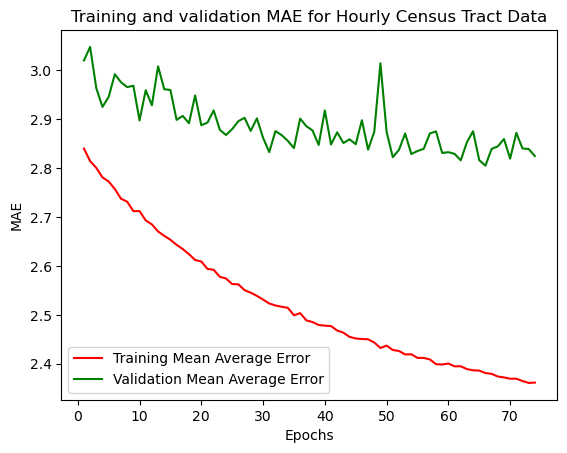

In [956]:
mae_hc_noDrop = history_hc.history['mae']
val_mae_hc_noDrop = history_hc.history['val_mae']

epochs = range(1, len(mae_hc_noDrop) + 1)

plt.plot(epochs, mae_hc_noDrop, '-', c='red', label='Training Mean Average Error')
plt.plot(epochs, val_mae_hc_noDrop, '-', c='green', label='Validation Mean Average Error')
plt.title('Training and validation MAE for Hourly Census Tract Data')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

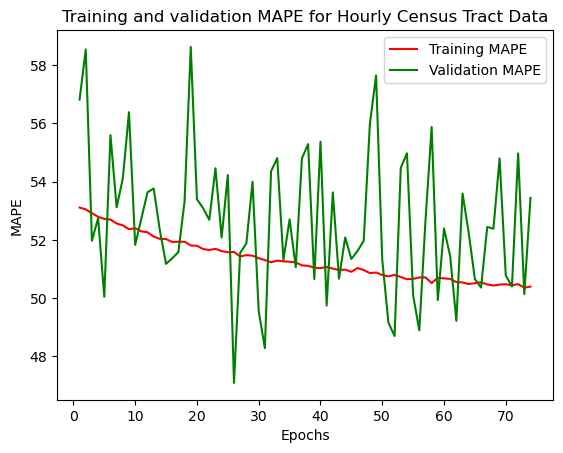

In [957]:
mape_hc_noDrop = history_hc.history['mean_absolute_percentage_error']
val_mape_hc_noDrop = history_hc.history['val_mean_absolute_percentage_error']

epochs = range(1, len(mape_hc_noDrop) + 1)

plt.plot(epochs, mape_hc_noDrop, '-', c='red', label='Training MAPE')
plt.plot(epochs, val_mape_hc_noDrop, '-', c='green', label='Validation MAPE')
plt.title('Training and validation MAPE for Hourly Census Tract Data')
plt.xlabel('Epochs')
plt.ylabel('MAPE')
plt.legend()
plt.show()

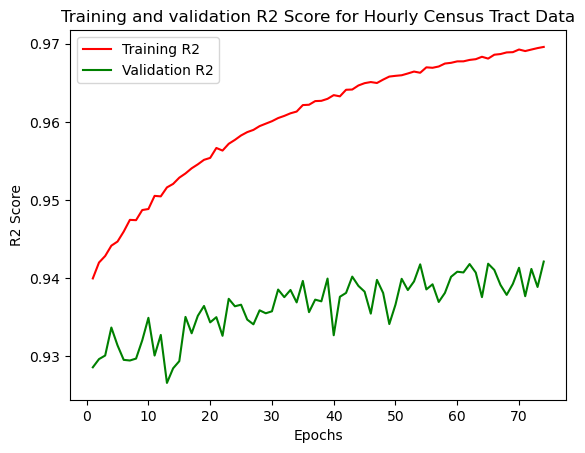

In [958]:
r2_hc_noDrop = history_hc.history['r2_score']
val_r2_hc_noDrop = history_hc.history['val_r2_score']

epochs = range(1, len(r2_hc_noDrop) + 1)

plt.plot(epochs, r2_hc_noDrop, '-', c='red', label='Training R2')
plt.plot(epochs, val_r2_hc_noDrop, '-', c='green', label='Validation R2')
plt.title('Training and validation R2 Score for Hourly Census Tract Data')
plt.xlabel('Epochs')
plt.ylabel('R2 Score')
plt.legend()
plt.show()

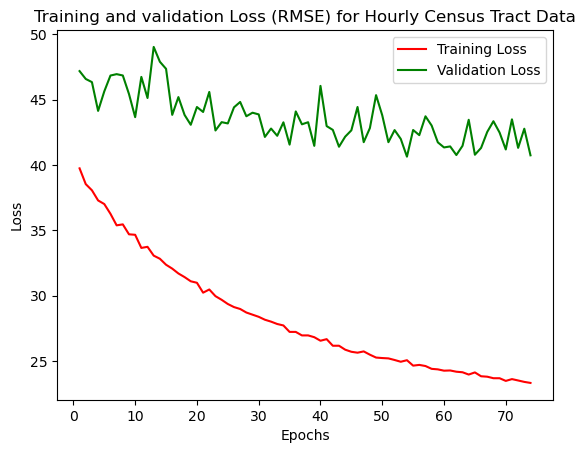

In [959]:
loss_hc_noDrop = history_hc.history['loss']
val_loss_hc_noDrop = history_hc.history['val_loss']

epochs = range(1, len(loss_hc_noDrop) + 1)

plt.plot(epochs, loss_hc_noDrop, '-', c='red', label='Training Loss')
plt.plot(epochs, val_loss_hc_noDrop, '-', c='green', label='Validation Loss')
plt.title('Training and validation Loss (RMSE) for Hourly Census Tract Data')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [960]:
hc_scores_noDrop = percentile_list = pd.DataFrame(
    {'loss': loss_hc_noDrop,
     'val_loss': val_loss_hc_noDrop,
     'mae': mae_hc_noDrop,
     'val_mae': val_mae_hc_noDrop,
     'mape': mape_hc_noDrop,
     'val_mape': val_mape_hc_noDrop,
     'r2': r2_hc_noDrop,
     'val_r2': val_r2_hc_noDrop
    })

hc_scores_noDrop['Model_trained']='/Users/awaischoudhry/AAA Project/full_models/trained_hc_noAvg_0810_rightAct_1.keras'

hc_scores_noDrop['Model_untrained']='/Users/awaischoudhry/AAA Project/full_models/untrained_hc_noAvg_0810_rightAct_1.keras'

hc_scores_noDrop['Hyperparameter']='hyperparameter_tuning/hc_noAvg_bayes_noDrop_rightStd_withValSet_rightAct_1'

hc_scores_noDrop.to_csv('/Users/awaischoudhry/AAA Project/history_hc_noAvg_noDrop_1.csv')

#### Dropout Layers

- manually test dropout layers of proportion 0.25 and 0.5

In [1339]:
best_model_hc.get_config()

{'name': 'sequential',
 'trainable': True,
 'dtype': {'module': 'keras',
  'class_name': 'DTypePolicy',
  'config': {'name': 'float32'},
  'registered_name': None},
 'layers': [{'module': 'keras.layers',
   'class_name': 'InputLayer',
   'config': {'batch_shape': (None, 318),
    'dtype': 'float32',
    'sparse': False,
    'name': 'input_layer'},
   'registered_name': None},
  {'module': 'keras.layers',
   'class_name': 'Dense',
   'config': {'name': 'dense',
    'trainable': True,
    'dtype': {'module': 'keras',
     'class_name': 'DTypePolicy',
     'config': {'name': 'float32'},
     'registered_name': None},
    'units': 320,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'module': 'keras.initializers',
     'class_name': 'GlorotUniform',
     'config': {'seed': None},
     'registered_name': None},
    'bias_initializer': {'module': 'keras.initializers',
     'class_name': 'Zeros',
     'config': {},
     'registered_name': None},
    'kernel_regulari

In [1341]:
best_model_hc.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 320)            │       102,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 320)            │       102,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 35)             │        11,235 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            36 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 648,215 (2.47 MB)

 Trainable params: 216,071 (844.03 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 432,144 (1.65 MB)

In [1353]:
best_model_hc_withDrop = models.Sequential()
best_model_hc_withDrop.add(ks.Input(shape=(X_train_data_hc.shape[1],)))
best_model_hc_withDrop.add(layers.Dense(320, activation='relu', kernel_regularizer=regularizers.L1L2(l1=0.0001, l2=0.0001)))
best_model_hc_withDrop.add(layers.Dropout(0.5, seed=777))
best_model_hc_withDrop.add(layers.Dense(320, activation='relu', kernel_regularizer=regularizers.L1L2(l1=0.0001, l2=0.0001)))
best_model_hc_withDrop.add(layers.Dropout(0.5, seed=777))
best_model_hc_withDrop.add(layers.Dense(35, activation='relu', kernel_regularizer=regularizers.L1L2(l1=0.0001, l2=0.0001)))
best_model_hc_withDrop.add(layers.Dropout(0.5, seed=777))
best_model_hc_withDrop.add(layers.Dense(1, activation='relu'))

opt = ks.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999
)

best_model_hc_withDrop.compile(optimizer=opt, loss='mse', metrics=[ks.metrics.R2Score(),'mae',ks.metrics.MeanAbsolutePercentageError()]) #optimizer: adam (...)

In [1354]:
best_model_hc_withDrop.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_25 (Dense)                │ (None, 320)            │       102,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 320)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 320)            │       102,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 320)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 35)             │        11,235 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 35)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 1)              │            36 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,071 (844.03 KB)

 Trainable params: 216,071 (844.03 KB)

 Non-trainable params: 0 (0.00 B)

In [1355]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False)

model_file_hc = '/Users/awaischoudhry/AAA Project/weights/weights_hc_bayes_withAvg_0809__withValset_rightAct_withDrop_0point5_1.keras'

checkpoint = tf.keras.callbacks.ModelCheckpoint(model_file_hc, 
                    monitor="val_loss", mode="min", 
                    save_best_only=True, verbose=1)

In [1356]:
history_hc_withDrop = best_model_hc_withDrop.fit(X_train_data_hc, y_train_data_hc, epochs=1000, validation_data=(X_val_data_hc,y_val_data_hc), callbacks=[stop_early, checkpoint])

Epoch 1/1000
9617/9633 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 223.7960 - mae: 5.9951 - mean_absolute_percentage_error: 103.6972 - r2_score: 0.6546
Epoch 1: val_loss improved from inf to 96.93185, saving model to /Users/awaischoudhry/AAA Project/weights/weights_hc_bayes_withAvg_0809__withValset_rightAct_withDrop_0point5_1.keras
9633/9633 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - loss: 223.6988 - mae: 5.9937 - mean_absolute_percentage_error: 103.6662 - r2_score: 0.6547 - val_loss: 96.9319 - val_mae: 3.9088 - val_mean_absolute_percentage_error: 66.8147 - val_r2_score: 0.8485
Epoch 2/1000
9610/9633 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 142.3571 - mae: 4.7534 - mean_absolute_percentage_error: 79.9905 - r2_score: 0.7803
Epoch 2: val_loss improved from 96.93185 to 92.96392, saving model to /Users/awaischoudhry/AAA Project/weights/weights_hc_bayes_withAvg_0809__withValset_rightAct_withDrop_0point5_1.keras
9633/9633 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 142.3485 - mae: 4.7533 - mean_absolute

In [1357]:
best_model_hc_full_withDrop = ks.saving.load_model(model_file_hc, custom_objects=None, compile=True, safe_mode=True)

In [1358]:
best_model_hc_full_withDrop.save('/Users/awaischoudhry/AAA Project/full_models/trained_hc_noAvg_0810_rightAct_withDrop_0point5_1.keras')

In [1359]:
best_model_hc_full_withDrop.evaluate(X_test_data_hc, y_test_data_hc)

3211/3211 ━━━━━━━━━━━━━━━━━━━━ 2s 447us/step - loss: 72.6848 - mae: 4.1766 - mean_absolute_percentage_error: 86.7918 - r2_score: 0.8883


[74.69100189208984, 0.8857828378677368, 4.187841415405273, 87.04312896728516]

In [1360]:
hc_scores_withDrop = pd.DataFrame(
    {'loss': history_hc_withDrop.history['loss'],
     'val_loss': history_hc_withDrop.history['val_loss'],
     'mae': history_hc_withDrop.history['mae'],
     'val_mae': history_hc_withDrop.history['val_mae'],
     'mape': history_hc_withDrop.history['mean_absolute_percentage_error'],
     'val_mape': history_hc_withDrop.history['val_mean_absolute_percentage_error'],
     'r2': history_hc_withDrop.history['r2_score'],
     'val_r2': history_hc_withDrop.history['val_r2_score']
    })

hc_scores_withDrop['Model_trained']='/Users/awaischoudhry/AAA Project/full_models/trained_hc_noAvg_0810_rightAct_withDrop_0point5_1.keras'

hc_scores_withDrop['Hyperparameter']='hyperparameter_tuning/dc_noAvg_bayes_noDrop_rightStd_withValSet_rightAct_1'

hc_scores_withDrop.to_csv('/Users/awaischoudhry/AAA Project/history_hc_noAvg_withDrop_0point5_1.csv')

#### New Metrics

- test potentially interesting new metrics

In [287]:
best_model_hc_reload = ks.saving.load_model('/Users/awaischoudhry/AAA Project/full_models/untrained_hc_noAvg_0810_rightAct_1.keras', custom_objects=None, compile=True, safe_mode=True)

In [288]:
from tensorflow.keras.saving import register_keras_serializable

opt = ks.optimizers.Adam(
        learning_rate=0.001,
        beta_1=0.9,
        beta_2=0.999,
    )

@register_keras_serializable()
def smape(y_true, y_pred):
    """
    Berechnet den Symmetric Mean Absolute Percentage Error (sMAPE).

    Args:
    y_true -- Die tatsächlichen Werte.
    y_pred -- Die vorhergesagten Werte.

    Returns:
    Der sMAPE-Wert.
    """

    y_true = K.cast(y_true, dtype='float32')  
    y_pred = K.cast(y_pred, dtype='float32')
    
    epsilon = K.epsilon()  # prevent division by 0
    numerator = K.abs(y_pred - y_true)
    denominator = K.abs(y_true) + K.abs(y_pred) + epsilon
    smape_value = 2 * K.mean(numerator / denominator)
    return smape_value

@register_keras_serializable()
def mase(y_true, y_pred):
    """
    Berechnet den Mean Absolute Scaled Error (MASE) basierend auf der Baseline-Vorhersage
    als Mittelwert der tatsächlichen Werte.

    Args:
    y_true -- Die tatsächlichen Werte.
    y_pred -- Die vorhergesagten Werte.

    Returns:
    Der MASE-Wert.
    """

    y_true = K.cast(y_true, dtype='float32')  
    y_pred = K.cast(y_pred, dtype='float32')

    y_mean = K.mean(y_true)
    
    mae_model = K.mean(K.abs(y_true - y_pred))
    
    mae_baseline = K.mean(K.abs(y_true - y_mean))
    
    mase_value = mae_model / (mae_baseline + K.epsilon())  # prevent division by null
    return mase_value


best_model_hc_reload.compile(optimizer=opt, 
                   loss='mse',
                   metrics=[ks.metrics.R2Score(),'mae',ks.metrics.MeanAbsolutePercentageError(),ks.metrics.MeanSquaredLogarithmicError(), smape, mase])

In [289]:
best_model_hc_reload.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 320)            │       102,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 320)            │       102,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 35)             │        11,235 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            36 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,071 (844.03 KB)

 Trainable params: 216,071 (844.03 KB)

 Non-trainable params: 0 (0.00 B)

In [290]:
best_model_hc_reload.get_config()

{'name': 'sequential',
 'trainable': True,
 'dtype': {'module': 'keras',
  'class_name': 'DTypePolicy',
  'config': {'name': 'float32'},
  'registered_name': None},
 'layers': [{'module': 'keras.layers',
   'class_name': 'InputLayer',
   'config': {'batch_shape': (None, 318),
    'dtype': 'float32',
    'sparse': False,
    'name': 'input_layer'},
   'registered_name': None},
  {'module': 'keras.layers',
   'class_name': 'Dense',
   'config': {'name': 'dense',
    'trainable': True,
    'dtype': {'module': 'keras',
     'class_name': 'DTypePolicy',
     'config': {'name': 'float32'},
     'registered_name': None},
    'units': 320,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'module': 'keras.initializers',
     'class_name': 'GlorotUniform',
     'config': {'seed': None},
     'registered_name': None},
    'bias_initializer': {'module': 'keras.initializers',
     'class_name': 'Zeros',
     'config': {},
     'registered_name': None},
    'kernel_regulari

In [291]:
#early stopping and gathering of weights at best epoch for validation set
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False)

model_file_hc_nm = '/Users/awaischoudhry/AAA Project/weights/weights_hc_bayes_noAvg_0812_withValset_rightAct_newMetrics.keras'

checkpoint = tf.keras.callbacks.ModelCheckpoint(model_file_hc_nm, 
                    monitor="val_loss", mode="min", 
                    save_best_only=True, verbose=1)

In [292]:
history_hc_nm = best_model_hc_reload.fit(X_train_data_hc, y_train_data_hc, epochs=1000, validation_data=(X_val_data_hc,y_val_data_hc), callbacks=[stop_early, checkpoint])

Epoch 1/1000
9619/9633 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 38.8816 - mae: 2.8288 - mase: 1.2320 - mean_absolute_percentage_error: 53.2627 - mean_squared_logarithmic_error: 0.1512 - r2_score: 0.9406 - smape: 0.9827
Epoch 1: val_loss improved from inf to 49.14753, saving model to /Users/awaischoudhry/AAA Project/weights/weights_hc_bayes_noAvg_0812_withValset_rightAct_newMetrics.keras
9633/9633 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step - loss: 38.8826 - mae: 2.8289 - mase: 1.2320 - mean_absolute_percentage_error: 53.2627 - mean_squared_logarithmic_error: 0.1512 - r2_score: 0.9406 - smape: 0.9827 - val_loss: 49.1475 - val_mae: 2.9955 - val_mase: 1.2034 - val_mean_absolute_percentage_error: 51.3612 - val_mean_squared_logarithmic_error: 0.1518 - val_r2_score: 0.9255 - val_smape: 0.9789
Epoch 2/1000
9630/9633 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 39.4813 - mae: 2.8198 - mase: 1.2326 - mean_absolute_percentage_error: 52.7060 - mean_squared_logarithmic_error: 0.1489 - r2_score: 0.9416 - smape: 

In [293]:
best_model_hc_full_noDrop_reload = ks.saving.load_model(model_file_hc_nm, custom_objects=None, compile=True, safe_mode=True)

In [294]:
best_model_hc_full_noDrop_reload.save('/Users/awaischoudhry/AAA Project/full_models/trained_hc_noAvg_0812_rightAct_newMetrics.keras')

In [295]:
best_model_hc_full_noDrop_reload.evaluate(X_test_data_hc,y_test_data_hc)

3211/3211 ━━━━━━━━━━━━━━━━━━━━ 2s 434us/step - loss: 43.7451 - mae: 2.8984 - mase: 1.2411 - mean_absolute_percentage_error: 55.8867 - mean_squared_logarithmic_error: 0.1552 - r2_score: 0.9360 - smape: 0.9878


[42.66877365112305,
 0.9381316304206848,
 2.8763601779937744,
 56.13984680175781,
 0.15564148128032684,
 0.985217273235321,
 1.2407087087631226]

In [296]:
hc_scores_noDrop_nm = pd.DataFrame(
    {'loss': history_hc_nm.history['loss'],
     'val_loss': history_hc_nm.history['val_loss'],
     'mae': history_hc_nm.history['mae'],
     'val_mae': history_hc_nm.history['val_mae'],
     'mape': history_hc_nm.history['mean_absolute_percentage_error'],
     'val_mape': history_hc_nm.history['val_mean_absolute_percentage_error'],
     'r2': history_hc_nm.history['r2_score'],
     'val_r2': history_hc_nm.history['val_r2_score'],
     'mase': history_hc_nm.history['mase'],
     'val_mase': history_hc_nm.history['val_mase'],
     'msle': history_hc_nm.history['mean_squared_logarithmic_error'],
     'val_msle': history_hc_nm.history['val_mean_squared_logarithmic_error'],
     'smape': history_hc_nm.history['smape'],
     'val_smape': history_hc_nm.history['val_smape']
    })

hc_scores_noDrop_nm['Model_trained']='/Users/awaischoudhry/AAA Project/full_models/trained_hc_noAvg_0812_rightAct_newMetrics.keras'

hc_scores_noDrop_nm['Model_untrained']='/Users/awaischoudhry/AAA Project/full_models/untrained_hc_noAvg_0810_rightAct_1.keras'

hc_scores_noDrop_nm.to_csv('/Users/awaischoudhry/AAA Project/history_hc_noAvg_noDrop_newMetrics_1.csv')

# Hourly Hexagon

## Feature Creation

In [67]:
hourly_hexagon = pd.read_csv("data/hexagon7_hourly_data.csv")

In [68]:
hourly_hexagon.shape

(634510, 37)

In [69]:
hourly_hexagon.head()

Hour         hex_id_7  Trip Seconds  Trip Miles       Fare  \
0  2023-01-01 00:00:00  872664520ffffff   3675.641960   34.639508  89.233043   
1  2023-01-01 00:00:00  872664cddffffff    220.603049    2.988652   7.661587   
2  2023-01-01 00:00:00  872664ce3ffffff   1008.914523    5.044573  15.487723   
3  2023-01-01 00:00:00  872664cf0ffffff     49.743611    0.275882   0.933754   
4  2023-01-01 00:00:00  872664cf2ffffff    116.774551    0.647640   2.192014   

       Tips  Tolls    Extras  Trip Total  Number of Trips  \
0  6.977265    0.0  12.34074  108.551048              3.0   
1  0.000000    0.0   0.00000    7.661587              0.0   
2  0.000000    0.0   0.00000   15.487723              1.0   
3  0.233014    0.0   0.00000    1.166768              0.0   
4  0.547007    0.0   0.00000    2.739021              0.0   

                                      hex_geometry_7  bank  bar  biergarten  \
0  POLYGON ((-87.78295871707687 41.80835732039707...   5.0  2.0         0.0   
1  POLYGON ((-87.64043336091524 41.75310085885061...   4.0  0.0         0.0   
2  POLYGON ((-87.58506717456048 41.81861970787787...   5.0  4.0         0.0   
3  POLYGON ((-87.65637124831868 41.84631996920292...   6.0  7.0         0.0   
4  POLYGON ((-87.68589130032419 41.84194054797606...   1.0  2.0         0.0   

   cafe  casino  cinema  college  fast_food  hospital  ice_cream  \
0   1.0     0.0     0.0      0.0        6.0       0.0        0.0   
1   3.0     0.0     0.0      0.0       12.0       0.0        0.0   
2   7.0     0.0     1.0      0.0       18.0       0.0        2.0   
3   6.0     0.0     0.0      0.0       14.0       0.0        0.0   
4   2.0     0.0     0.0      0.0        8.0       0.0        0.0   

   kindergarten  library  nightclub  pub  restaurant  school  taxi  \
0           0.0      1.0        0.0  0.0         3.0     7.0   0.0   
1           0.0      0.0        0.0  0.0         2.0     9.0   0.0   
2           0.0      1.0        0.0  0.0        25.0     5.0   0.0   
3           0.0      1.0        0.0  1.0        14.0    15.0   0.0   
4           0.0      1.0        0.0  0.0         5.0    11.0   0.0   

   university  temp  dwpt  rhum  prcp   wdir  wspd    pres  coco  
0         0.0   2.0  -1.3  79.0   0.0  121.0   6.0  1013.0   3.0  
1         0.0   2.0  -1.3  79.0   0.0  121.0   6.0  1013.0   3.0  
2         2.0   2.0  -1.3  79.0   0.0  121.0   6.0  1013.0   3.0  
3         0.0   2.0  -1.3  79.0   0.0  121.0   6.0  1013.0   3.0  
4         0.0   2.0  -1.3  79.0   0.0  121.0   6.0  1013.0   3.0

In [70]:
hourly_hexagon.columns

Index(['Hour', 'hex_id_7', 'Trip Seconds', 'Trip Miles', 'Fare', 'Tips',
       'Tolls', 'Extras', 'Trip Total', 'Number of Trips', 'hex_geometry_7',
       'bank', 'bar', 'biergarten', 'cafe', 'casino', 'cinema', 'college',
       'fast_food', 'hospital', 'ice_cream', 'kindergarten', 'library',
       'nightclub', 'pub', 'restaurant', 'school', 'taxi', 'university',
       'temp', 'dwpt', 'rhum', 'prcp', 'wdir', 'wspd', 'pres', 'coco'],
      dtype='object')

### Derived

In [71]:
hourly_hexagon['Hour'] = pd.to_datetime(hourly_hexagon['Hour'])

hourly_hexagon['month'] = hourly_hexagon['Hour'].dt.month
hourly_hexagon = encode(hourly_hexagon, 'month', 12)

hourly_hexagon['day'] = hourly_hexagon['Hour'].dt.day
hourly_hexagon = encode(hourly_hexagon, 'day', 31)

hourly_hexagon['day_of_year'] = hourly_hexagon['Hour'].dt.dayofyear
hourly_hexagon['day_of_year_rad'] = 2 * np.pi * hourly_hexagon['day_of_year'] / 365
hourly_hexagon['day_of_year_sin'] = np.sin(hourly_hexagon['day_of_year_rad'])
hourly_hexagon['day_of_year_cos'] = np.cos(hourly_hexagon['day_of_year_rad'])


hourly_hexagon['hour'] = hourly_hexagon['Hour'].dt.hour
hourly_hexagon['hour_sin'] = np.sin(2 * np.pi * hourly_hexagon['hour']/24.0)
hourly_hexagon['hour_cos'] = np.cos(2 * np.pi * hourly_hexagon['hour']/24.0)

In [72]:
hourly_hexagon.groupby(['hour','hour_sin','hour_cos']).size()

hour  hour_sin       hour_cos     
0      0.000000e+00   1.000000e+00    16569
1      2.588190e-01   9.659258e-01    13459
2      5.000000e-01   8.660254e-01    11975
3      7.071068e-01   7.071068e-01    13995
4      8.660254e-01   5.000000e-01    19313
5      9.659258e-01   2.588190e-01    21065
6      1.000000e+00   6.123234e-17    25881
7      9.659258e-01  -2.588190e-01    29429
8      8.660254e-01  -5.000000e-01    30753
9      7.071068e-01  -7.071068e-01    32510
10     5.000000e-01  -8.660254e-01    33158
11     2.588190e-01  -9.659258e-01    33719
12     1.224647e-16  -1.000000e+00    33782
13    -2.588190e-01  -9.659258e-01    33691
14    -5.000000e-01  -8.660254e-01    33011
15    -7.071068e-01  -7.071068e-01    32766
16    -8.660254e-01  -5.000000e-01    32154
17    -9.659258e-01  -2.588190e-01    31354
18    -1.000000e+00  -1.836970e-16    30308
19    -9.659258e-01   2.588190e-01    28779
20    -8.660254e-01   5.000000e-01    27056
21    -7.071068e-01   7.071068e-01    254

In [73]:
hourly_hexagon.groupby(['day','day_sin','day_cos']).size()

day  day_sin        day_cos  
1     2.012985e-01   0.979530    20918
2     3.943559e-01   0.918958    20820
3     5.712682e-01   0.820763    21056
4     7.247928e-01   0.688967    20593
5     8.486443e-01   0.528964    20858
6     9.377521e-01   0.347305    21065
7     9.884683e-01   0.151428    20850
8     9.987165e-01  -0.050649    20777
9     9.680771e-01  -0.250653    20815
10    8.978045e-01  -0.440394    21072
11    7.907757e-01  -0.612106    20794
12    6.513725e-01  -0.758758    20738
13    4.853020e-01  -0.874347    21092
14    2.993631e-01  -0.954139    21195
15    1.011683e-01  -0.994869    20993
16   -1.011683e-01  -0.994869    20913
17   -2.993631e-01  -0.954139    21077
18   -4.853020e-01  -0.874347    20964
19   -6.513725e-01  -0.758758    20600
20   -7.907757e-01  -0.612106    20966
21   -8.978045e-01  -0.440394    21091
22   -9.680771e-01  -0.250653    20699
23   -9.987165e-01  -0.050649    20418
24   -9.884683e-01   0.151428    20892
25   -9.377521e-01   0.347305    2

In [74]:
hourly_hexagon.groupby(['day_of_year','day_of_year_sin','day_of_year_cos']).size()

day_of_year  day_of_year_sin  day_of_year_cos
1             1.721336e-02    0.999852           1509
2             3.442161e-02    0.999407           1562
3             5.161967e-02    0.998667           1682
4             6.880243e-02    0.997630           1679
5             8.596480e-02    0.996298           1689
                                                 ... 
361          -6.880243e-02    0.997630           1759
362          -5.161967e-02    0.998667           1808
363          -3.442161e-02    0.999407           1817
364          -1.721336e-02    0.999852           1668
365           6.432491e-16    1.000000           1608
Length: 365, dtype: int64

In [75]:
hourly_hexagon["Day of Week"] = hourly_hexagon['Hour'].dt.dayofweek
hourly_hexagon["Is Weekend"] = hourly_hexagon["Day of Week"] > 4
hourly_hexagon["Is Weekend"] = hourly_hexagon["Is Weekend"].astype('int')

hourly_hexagon["Business Hours"]= (hourly_hexagon["Is Weekend"]==0) & (hourly_hexagon['hour'].between(8,20))
hourly_hexagon["Business Hours"] = hourly_hexagon["Business Hours"].astype('int')

hourly_hexagon["Business Travel"]= (hourly_hexagon["Is Weekend"]==0) & ((hourly_hexagon['hour'].between(7,9)) | (hourly_hexagon['hour'].between(16,18)))
hourly_hexagon["Business Travel"]= hourly_hexagon["Business Travel"].astype('int')

In [76]:
hourly_hexagon[hourly_hexagon['Business Hours']==1]

Hour         hex_id_7  Trip Seconds  Trip Miles  \
1864   2023-01-02 08:00:00  872664ce3ffffff    803.596144    8.614661   
1865   2023-01-02 08:00:00  872664cd9ffffff   2336.175709   27.362705   
1866   2023-01-02 08:00:00  872664ce2ffffff    333.269251    1.412984   
1867   2023-01-02 08:00:00  872664cddffffff   1030.071874    6.048221   
1868   2023-01-02 08:00:00  872664cdbffffff    384.824291    4.507295   
...                    ...              ...           ...         ...   
631016 2023-12-29 20:00:00  872664c16ffffff  10534.312324   51.568004   
631017 2023-12-29 20:00:00  872664c13ffffff   6548.828087   30.019499   
631018 2023-12-29 20:00:00  872664c12ffffff   1281.147841    5.873106   
631019 2023-12-29 20:00:00  872664c89ffffff     37.695389    0.385070   
631020 2023-12-29 20:00:00  872664c11ffffff    317.370074    1.435848   

              Fare       Tips  Tolls    Extras  Trip Total  Number of Trips  \
1864     22.486401   0.000000    0.0  0.000000   22.486401              1.0   
1865     77.271523   0.000000    0.0  0.000000   77.271523              3.0   
1866      6.577683   0.000000    0.0  0.000000    6.577683              1.0   
1867     17.982568   0.000000    0.0  0.000000   17.982568              1.0   
1868     12.728477   0.000000    0.0  0.000000   12.728477              0.0   
...            ...        ...    ...       ...         ...              ...   
631016  216.616174  27.929058    0.0  3.500000  248.045232             17.0   
631017  111.168821  13.138732    0.0  2.397256  127.417358              9.0   
631018   21.744364   2.539940    0.0  0.471357   24.890334              2.0   
631019    0.988612   0.000000    0.0  0.000000    0.988612              0.0   
631020    5.563248   2.119333    0.0  0.000000    7.947498              1.0   

                                           hex_geometry_7  bank   bar  \
1864    POLYGON ((-87.58506717456048 41.81861970787787...   5.0   4.0   
1865    POLYGON ((-87.64903511005247 41.73272388140803...   0.0   0.0   
1866    POLYGON ((-87.60594860244034 41.83465680186091...   1.0   1.0   
1867    POLYGON ((-87.64043336091524 41.75310085885061...   4.0   0.0   
1868    POLYGON ((-87.67848396651723 41.72835644256933...   6.0   0.0   
...                                                   ...   ...   ...   
631016  POLYGON ((-87.6637434314177 41.96006879266265,...  11.0  74.0   
631017  POLYGON ((-87.65142438552711 41.92359649212148...  14.0  31.0   
631018  POLYGON ((-87.6723729663648 41.93963771855481,...  10.0  30.0   
631019  POLYGON ((-87.7154035945768 41.837554121739885...   0.0   0.0   
631020  POLYGON ((-87.62184631774288 41.92797452200048...   0.0   1.0   

        biergarten  cafe  casino  cinema  college  fast_food  hospital  \
1864           0.0   7.0     0.0     1.0      0.0       18.0       0.0   
1865           0.0   1.0     0.0     0.0      0.0        4.0       0.0   
1866           0.0   2.0     0.0     0.0      0.0        2.0       0.0   
1867           0.0   3.0     0.0     0.0      0.0       12.0       0.0   
1868           0.0   8.0     0.0     0.0      0.0       16.0       0.0   
...            ...   ...     ...     ...      ...        ...       ...   
631016         0.0  24.0     0.0     1.0      0.0       43.0       1.0   
631017         0.0  16.0     0.0     1.0      0.0       27.0       0.0   
631018         0.0  19.0     0.0     2.0      0.0       27.0       0.0   
631019         0.0   0.0     0.0     0.0      0.0        2.0       0.0   
631020         0.0   2.0     0.0     0.0      0.0        0.0       0.0   

        ice_cream  kindergarten  library  nightclub  pub  restaurant  school  \
1864          2.0           0.0      1.0        0.0  0.0        25.0     5.0   
1865          0.0           0.0      1.0        0.0  0.0         0.0    12.0   
1866          0.0           0.0      0.0        0.0  0.0         3.0    12.0   
1867          0.0           0.0      0.0        0.0  0.0         2.0     9.0   
1868          1.0           0.

In [77]:
hourly_hexagon[hourly_hexagon['Business Travel']==1]

Hour         hex_id_7  Trip Seconds  Trip Miles  \
1803   2023-01-02 07:00:00  872664cddffffff    911.032341    8.188400   
1804   2023-01-02 07:00:00  872664cceffffff   2555.392338   22.967983   
1805   2023-01-02 07:00:00  872664ccdffffff    271.963573    2.186496   
1806   2023-01-02 07:00:00  872664cccffffff    279.537606    3.120108   
1807   2023-01-02 07:00:00  872664ccbffffff    201.200117    2.377195   
...                    ...              ...           ...         ...   
630856 2023-12-29 18:00:00  872664c1affffff  64332.018391  120.378750   
630857 2023-12-29 18:00:00  872664c16ffffff  39286.668429   63.632040   
630858 2023-12-29 18:00:00  872664c13ffffff   8068.987958   35.455419   
630859 2023-12-29 18:00:00  872664c8cffffff     28.720626    0.012597   
630860 2023-12-29 18:00:00  872664c12ffffff   1562.615200    6.887197   

              Fare        Tips  Tolls     Extras  Trip Total  Number of Trips  \
1803     21.908340    0.000000    0.0   0.000000   21.908340              1.0   
1804     61.451609    0.000000    0.0   0.000000   61.451609              2.0   
1805      5.808528    0.000000    0.0   0.000000    5.808528              0.0   
1806      8.871553    0.000000    0.0   0.000000    8.871553              0.0   
1807      6.131186    0.421063    0.0   0.000000    6.552249              0.0   
...            ...         ...    ...        ...         ...              ...   
630856  703.809279  124.423064    0.0  54.525793  899.626052             73.0   
630857  340.401851   63.696309    0.0   4.000000  409.292237             26.0   
630858  168.760644   28.650413    0.0   4.904986  204.055987             10.0   
630859    0.642435    0.000000    0.0   0.000000    0.642435              0.0   
630860   32.842797    5.584905    0.0   0.942714   39.707099              2.0   

                                           hex_geometry_7  bank   bar  \
1803    POLYGON ((-87.64043336091524 41.75310085885061...   4.0   0.0   
1804    POLYGON ((-87.61096238434389 41.75746098760969...   5.0   3.0   
1805    POLYGON ((-87.560642368785 41.74578433870738, ...   7.0   1.0   
1806    POLYGON ((-87.58148371396562 41.76181412919314...   1.0   0.0   
1807    POLYGON ((-87.59873710197503 41.72106634575092...   0.0   0.0   
...                                                   ...   ...   ...   
630856  POLYGON ((-87.63912440648137 41.88713767856642...  46.0  38.0   
630857  POLYGON ((-87.6637434314177 41.96006879266265,...  11.0  74.0   
630858  POLYGON ((-87.65142438552711 41.92359649212148...  14.0  31.0   
630859  POLYGON ((-87.72774820692267 41.87398041277048...   1.0   0.0   
630860  POLYGON ((-87.6723729663648 41.93963771855481,...  10.0  30.0   

        biergarten  cafe  casino  cinema  college  fast_food  hospital  \
1803           0.0   3.0     0.0     0.0      0.0       12.0       0.0   
1804           0.0   0.0     0.0     0.0      0.0        7.0       0.0   
1805           0.0   1.0     0.0     0.0      2.0        6.0       1.0   
1806           0.0   1.0     0.0     0.0      0.0        6.0       2.0   
1807           0.0   0.0     0.0     0.0      1.0        1.0       0.0   
...            ...   ...     ...     ...      ...        ...       ...   
630856         0.0  93.0     0.0     1.0      8.0      144.0       0.0   
630857         0.0  24.0     0.0     1.0      0.0       43.0       1.0   
630858         0.0  16.0     0.0     1.0      0.0       27.0       0.0   
630859         0.0   2.0     0.0     0.0      0.0        5.0       0.0   
630860         0.0  19.0     0.0     2.0      0.0       27.0       0.0   

        ice_cream  kindergarten  library  nightclub  pub  restaurant  school  \
1803          0.0           0.0      0.0        0.0  0.0         2.0     9.0   
1804          0.0           0.0      1.0        1.0  0.0         5.0    12.0   
1805          2.0           0.0      1.0        0.0  0.0         9.0    13.0   
1806          0.0           0.0      1.0        0.0  0.0         1.0     8.0   
1807  

In [78]:
#unused due to dependency of knowledge of number of trips
hourly_hexagon['Trip Seconds Avg'] = hourly_hexagon['Trip Seconds']/hourly_hexagon['Number of Trips']
hourly_hexagon['Trip Miles Avg'] = hourly_hexagon['Trip Miles']/hourly_hexagon['Number of Trips']
hourly_hexagon['Fare Avg'] = hourly_hexagon['Fare']/hourly_hexagon['Number of Trips']
hourly_hexagon['Tips Avg'] = hourly_hexagon['Tips']/hourly_hexagon['Number of Trips']
hourly_hexagon['Tolls Avg'] = hourly_hexagon['Tolls']/hourly_hexagon['Number of Trips']
hourly_hexagon['Extras Avg'] = hourly_hexagon['Extras']/hourly_hexagon['Number of Trips']
hourly_hexagon['Trip Total Avg'] = hourly_hexagon['Trip Total']/hourly_hexagon['Number of Trips']

hourly_hexagon['Fare per Miles'] = hourly_hexagon['Fare']/hourly_hexagon['Trip Miles']

In [79]:
hourly_hexagon['Trip Seconds Avg'] = hourly_hexagon['Trip Seconds Avg'].fillna(0)
hourly_hexagon['Trip Seconds Avg'].replace([np.inf, -np.inf], 0, inplace=True)

hourly_hexagon['Trip Miles Avg'] = hourly_hexagon['Trip Miles Avg'].fillna(0)
hourly_hexagon['Trip Miles Avg'].replace([np.inf, -np.inf], 0, inplace=True)

hourly_hexagon['Fare Avg'].replace([np.inf, -np.inf], 0, inplace=True)
hourly_hexagon['Fare Avg'] = hourly_hexagon['Fare Avg'].fillna(0)

hourly_hexagon['Trip Total Avg'].replace([np.inf, -np.inf], 0, inplace=True)
hourly_hexagon['Trip Total Avg'] = hourly_hexagon['Trip Total Avg'].fillna(0)

hourly_hexagon['Tips Avg'].replace([np.inf, -np.inf], 0, inplace=True)
hourly_hexagon['Tips Avg'] = hourly_hexagon['Tips Avg'].fillna(0)

hourly_hexagon['Tolls Avg'].replace([np.inf, -np.inf], 0, inplace=True)
hourly_hexagon['Tolls Avg'] = hourly_hexagon['Tolls Avg'].fillna(0)

hourly_hexagon['Extras Avg'].replace([np.inf, -np.inf], 0, inplace=True)
hourly_hexagon['Extras Avg'] = hourly_hexagon['Extras Avg'].fillna(0)

hourly_hexagon['Fare per Miles'] = hourly_hexagon['Fare per Miles'].fillna(0)
hourly_hexagon['Fare per Miles'].replace([np.inf, -np.inf], 0, inplace=True)

In [80]:
hourly_hexagon[hourly_hexagon.isna().any(axis=1)]

Empty DataFrame
Columns: [Hour, hex_id_7, Trip Seconds, Trip Miles, Fare, Tips, Tolls, Extras, Trip Total, Number of Trips, hex_geometry_7, bank, bar, biergarten, cafe, casino, cinema, college, fast_food, hospital, ice_cream, kindergarten, library, nightclub, pub, restaurant, school, taxi, university, temp, dwpt, rhum, prcp, wdir, wspd, pres, coco, month, month_sin, month_cos, day, day_sin, day_cos, day_of_year, day_of_year_rad, day_of_year_sin, day_of_year_cos, hour, hour_sin, hour_cos, Day of Week, Is Weekend, Business Hours, Business Travel, Trip Seconds Avg, Trip Miles Avg, Fare Avg, Tips Avg, Tolls Avg, Extras Avg, Trip Total Avg, Fare per Miles]
Index: []

### Holiday Matching

In [81]:
hourly_hexagon.shape

(634510, 62)

In [82]:
hourly_hexagon = pd.merge(left=hourly_hexagon, right=holiday_df,how='left',left_on=hourly_hexagon['Hour'].dt.date,right_on=['date'])

In [83]:
hourly_hexagon.shape

(634510, 64)

In [84]:
hourly_hexagon['holiday'] = hourly_hexagon['name'].apply(lambda x: 0 if pd.isna(x) else 1)

In [85]:
hourly_hexagon.loc[hourly_hexagon['holiday']==1,'Hour'].unique()

<DatetimeArray>
['2023-01-01 00:00:00', '2023-01-01 01:00:00', '2023-01-01 02:00:00',
 '2023-01-01 03:00:00', '2023-01-01 04:00:00', '2023-01-01 05:00:00',
 '2023-01-01 06:00:00', '2023-01-01 07:00:00', '2023-01-01 08:00:00',
 '2023-01-01 09:00:00',
 ...
 '2023-12-25 14:00:00', '2023-12-25 15:00:00', '2023-12-25 16:00:00',
 '2023-12-25 17:00:00', '2023-12-25 18:00:00', '2023-12-25 19:00:00',
 '2023-12-25 20:00:00', '2023-12-25 21:00:00', '2023-12-25 22:00:00',
 '2023-12-25 23:00:00']
Length: 384, dtype: datetime64[ns]

In [86]:
hourly_hexagon[hourly_hexagon['holiday']==1]

Hour         hex_id_7  Trip Seconds  Trip Miles  \
0      2023-01-01 00:00:00  872664520ffffff   3675.641960   34.639508   
1      2023-01-01 00:00:00  872664cddffffff    220.603049    2.988652   
2      2023-01-01 00:00:00  872664ce3ffffff   1008.914523    5.044573   
3      2023-01-01 00:00:00  872664cf0ffffff     49.743611    0.275882   
4      2023-01-01 00:00:00  872664cf2ffffff    116.774551    0.647640   
...                    ...              ...           ...         ...   
624135 2023-12-25 23:00:00  872664c80ffffff     18.000000    0.040000   
624136 2023-12-25 23:00:00  872664c1effffff   5829.000000   22.720000   
624137 2023-12-25 23:00:00  872664c1bffffff      0.000000    0.000000   
624138 2023-12-25 23:00:00  872664c1affffff   1511.986410    8.194648   
624139 2023-12-25 23:00:00  872664c89ffffff      7.270398    0.041309   

              Fare       Tips  Tolls     Extras  Trip Total  Number of Trips  \
0        89.233043   6.977265    0.0  12.340740  108.551048              3.0   
1         7.661587   0.000000    0.0   0.000000    7.661587              0.0   
2        15.487723   0.000000    0.0   0.000000   15.487723              1.0   
3         0.933754   0.233014    0.0   0.000000    1.166768              0.0   
4         2.192014   0.547007    0.0   0.000000    2.739021              0.0   
...            ...        ...    ...        ...         ...              ...   
624135    3.250000   0.000000    0.0   0.000000    3.250000              1.0   
624136  118.000000  24.080000    0.0  31.500000  174.580000             10.0   
624137   43.996179   4.888464    0.0   0.000000   48.884643              1.0   
624138   36.725546   4.938965    0.0   3.802831   46.147625              3.0   
624139    0.122550   0.000000    0.0   0.000000    0.122550              0.0   

                                           hex_geometry_7  bank    bar  \
0       POLYGON ((-87.78295871707687 41.80835732039707...   5.0    2.0   
1       POLYGON ((-87.64043336091524 41.75310085885061...   4.0    0.0   
2       POLYGON ((-87.58506717456048 41.81861970787787...   5.0    4.0   
3       POLYGON ((-87.65637124831868 41.84631996920292...   6.0    7.0   
4       POLYGON ((-87.68589130032419 41.84194054797606...   1.0    2.0   
...                                                   ...   ...    ...   
624135  POLYGON ((-87.76965884273433 41.9060140412681,...   0.0    1.0   
624136  POLYGON ((-87.63048927308355 41.90755371098675...  28.0  104.0   
624137  POLYGON ((-87.61820944356228 41.8710984903598,...   1.0   13.0   
624138  POLYGON ((-87.63912440648137 41.88713767856642...  46.0   38.0   
624139  POLYGON ((-87.7154035945768 41.837554121739885...   0.0    0.0   

        biergarten   cafe  casino  cinema  college  fast_food  hospital  \
0              0.0    1.0     0.0     0.0      0.0        6.0       0.0   
1              0.0    3.0     0.0     0.0      0.0       12.0       0.0   
2              0.0    7.0     0.0     1.0      0.0       18.0       0.0   
3              0.0    6.0     0.0     0.0      0.0       14.0       0.0   
4              0.0    2.0     0.0     0.0      0.0        8.0       0.0   
...            ...    ...     ...     ...      ...        ...       ...   
624135         0.0    0.0     0.0     0.0      0.0        6.0       1.0   
624136         0.0  115.0     1.0     3.0      3.0       82.0       2.0   
624137         1.0    7.0     0.0     0.0      1.0       11.0       0.0   
624138         0.0   93.0     0.0     1.0      8.0      144.0       0.0   
624139         0.0    0.0     0.0     0.0      0.0        2.0       0.0   

        ice_cream  kindergarten  library  nightclub   pub  restaurant  school  \
0             0.0           0.0      1.0        0.0   0.0         3.0     7.0   
1             0.0           0.0      0.0        0.0   0.0         2.0     9.0   
2             2.0           0.0      1.0        0.0   0.0        25.0     5.0   
3             0.0           0.0      1.0        0.0   1.0        14.0 

### Sports Matching

In [87]:
hourly_hexagon.shape

(634510, 65)

In [88]:
hourly_hexagon.sort_values(by='Hour', ascending=True, inplace=True)
sports_hex.sort_values(by='Hour', ascending=True, inplace=True)
hourly_hexagon['hex_id_7'] = hourly_hexagon['hex_id_7'].astype('str')

In [89]:
#match sporting events based on area and time frame of ending time plus 2h
hourly_hexagon = pd.merge_asof(
    hourly_hexagon, sports_hex, on="Hour", by="hex_id_7", tolerance=pd.Timedelta("2h"), direction="backward"
)

In [90]:
hourly_hexagon.shape

(634510, 69)

In [91]:
hourly_hexagon['sports'] = hourly_hexagon['opponent'].apply(lambda x: 0 if pd.isna(x) else 1)

In [92]:
hourly_hexagon[hourly_hexagon['sports']==1]

Hour         hex_id_7  Trip Seconds  Trip Miles  \
6277   2023-01-04 21:00:00  872664ca9ffffff  18710.253517  104.649569   
6278   2023-01-04 21:00:00  872664ca8ffffff    215.946076    0.749476   
6279   2023-01-04 21:00:00  872664cadffffff    803.864037    0.429137   
6323   2023-01-04 22:00:00  872664cadffffff    817.167659    0.090897   
6349   2023-01-04 22:00:00  872664ca9ffffff  24391.610506   95.355698   
...                    ...              ...           ...         ...   
632723 2023-12-30 21:00:00  872664cadffffff    252.613616    0.892568   
632777 2023-12-30 22:00:00  872664cadffffff   1724.027249    4.183956   
632779 2023-12-30 22:00:00  872664ca9ffffff  28207.971284  168.986040   
632854 2023-12-30 23:00:00  872664ca9ffffff  16893.000000   63.830000   
632856 2023-12-30 23:00:00  872664cadffffff   1051.902409    4.536285   

              Fare       Tips  Tolls     Extras  Trip Total  Number of Trips  \
6277    654.206892  52.870000    0.0   1.500000  710.576892             29.0   
6278     10.783824   0.000000    0.0   0.000000   10.783824              0.0   
6279     17.017145   0.302440    0.0   0.000000   17.319585              1.0   
6323     11.658045   1.371717    0.0   0.000000   13.037128              1.0   
6349    565.603808  68.655911    0.0   7.000000  644.617555             33.0   
...            ...        ...    ...        ...         ...              ...   
632723    5.052272   1.257454    0.0   0.000000    6.309727              1.0   
632777   20.524134   1.928774    0.0   1.978230   24.925695              2.0   
632779  642.495849  66.161224    0.0   5.021769  719.184284             31.0   
632854  323.750000  55.030000    0.0  11.500000  395.280000             25.0   
632856   15.324933   3.714660    0.0   0.000000   19.039593              1.0   

                                           hex_geometry_7  bank   bar  \
6277    POLYGON ((-87.66867344075082 41.88275894341120...   6.0   8.0   
6278    POLYGON ((-87.68960859632769 41.89878991031962...   7.0  12.0   
6279    POLYGON ((-87.66005281769654 41.90317532606511...  11.0  41.0   
6323    POLYGON ((-87.66005281769654 41.90317532606511...  11.0  41.0   
6349    POLYGON ((-87.66867344075082 41.88275894341120...   6.0   8.0   
...                                                   ...   ...   ...   
632723  POLYGON ((-87.66005281769654 41.90317532606511...  11.0  41.0   
632777  POLYGON ((-87.66005281769654 41.90317532606511...  11.0  41.0   
632779  POLYGON ((-87.66867344075082 41.88275894341120...   6.0   8.0   
632854  POLYGON ((-87.66867344075082 41.88275894341120...   6.0   8.0   
632856  POLYGON ((-87.66005281769654 41.90317532606511...  11.0  41.0   

        biergarten  cafe  casino  cinema  college  fast_food  hospital  \
6277           0.0  11.0     0.0     0.0      0.0       25.0       4.0   
6278           0.0   9.0     0.0     0.0      0.0       12.0       0.0   
6279           0.0  32.0     0.0     0.0      0.0       16.0       0.0   
6323           0.0  32.0     0.0     0.0      0.0       16.0       0.0   
6349           0.0  11.0     0.0     0.0      0.0       25.0       4.0   
...            ...   ...     ...     ...      ...        ...       ...   
632723         0.0  32.0     0.0     0.0      0.0       16.0       0.0   
632777         0.0  32.0     0.0     0.0      0.0       16.0       0.0   
632779         0.0  11.0     0.0     0.0      0.0       25.0       4.0   
632854         0.0  11.0     0.0     0.0      0.0       25.0       4.0   
632856         0.0  32.0     0.0     0.0      0.0       16.0       0.0   

        ice_cream  kindergarten  library  nightclub  pub  restaurant  school  \
6277          2.0           0.0      3.0        0.0  2.0        24.0    21.0   
6278          0.0           0.0      1.0        0.0  1.0        26.0    18.0   
6279          4.0           0.0      2.0        0.0  5.0       152.0    13.0   
6323          4.0           0.0      2.0        0.0  5.0       152.0    13.0   
6349          2.0 

In [93]:
hourly_hexagon.sort_index(inplace=True)

### Check Columns

In [94]:
hourly_hexagon.columns

Index(['Hour', 'hex_id_7', 'Trip Seconds', 'Trip Miles', 'Fare', 'Tips',
       'Tolls', 'Extras', 'Trip Total', 'Number of Trips', 'hex_geometry_7',
       'bank', 'bar', 'biergarten', 'cafe', 'casino', 'cinema', 'college',
       'fast_food', 'hospital', 'ice_cream', 'kindergarten', 'library',
       'nightclub', 'pub', 'restaurant', 'school', 'taxi', 'university',
       'temp', 'dwpt', 'rhum', 'prcp', 'wdir', 'wspd', 'pres', 'coco', 'month',
       'month_sin', 'month_cos', 'day', 'day_sin', 'day_cos', 'day_of_year',
       'day_of_year_rad', 'day_of_year_sin', 'day_of_year_cos', 'hour',
       'hour_sin', 'hour_cos', 'Day of Week', 'Is Weekend', 'Business Hours',
       'Business Travel', 'Trip Seconds Avg', 'Trip Miles Avg', 'Fare Avg',
       'Tips Avg', 'Tolls Avg', 'Extras Avg', 'Trip Total Avg',
       'Fare per Miles', 'date_x', 'name', 'holiday', 'date_y', 'opponent',
       'time', 'datetime', 'sports'],
      dtype='object')

In [95]:
#drop unneeded columns
hourly_hexagon.drop(["date_x","date_y","name","datetime","hex_geometry_7","Day of Week","month", "day","opponent","time","day_of_year_rad","day_of_year"], axis=1, inplace=True)

In [96]:
hourly_hexagon.columns

Index(['Hour', 'hex_id_7', 'Trip Seconds', 'Trip Miles', 'Fare', 'Tips',
       'Tolls', 'Extras', 'Trip Total', 'Number of Trips', 'bank', 'bar',
       'biergarten', 'cafe', 'casino', 'cinema', 'college', 'fast_food',
       'hospital', 'ice_cream', 'kindergarten', 'library', 'nightclub', 'pub',
       'restaurant', 'school', 'taxi', 'university', 'temp', 'dwpt', 'rhum',
       'prcp', 'wdir', 'wspd', 'pres', 'coco', 'month_sin', 'month_cos',
       'day_sin', 'day_cos', 'day_of_year_sin', 'day_of_year_cos', 'hour',
       'hour_sin', 'hour_cos', 'Is Weekend', 'Business Hours',
       'Business Travel', 'Trip Seconds Avg', 'Trip Miles Avg', 'Fare Avg',
       'Tips Avg', 'Tolls Avg', 'Extras Avg', 'Trip Total Avg',
       'Fare per Miles', 'holiday', 'sports'],
      dtype='object')

### Correlations and Dropping

In [97]:
#summarize columns in order to remove some high correlations
hourly_hexagon['cafe and restaurant'] = hourly_hexagon['cafe'] + hourly_hexagon['restaurant']
hourly_hexagon['pub and bar and biergarten'] = hourly_hexagon['pub'] + hourly_hexagon['bar'] + hourly_hexagon['biergarten']
hourly_hexagon['college and uni'] = hourly_hexagon['college'] + hourly_hexagon['university']

In [98]:
hourly_hexagon.drop(['hex_id_7', 'Hour'], axis=1).corr()

Trip Seconds  Trip Miles      Fare      Tips  \
Trip Seconds                    1.000000    0.923979  0.972456  0.948763   
Trip Miles                      0.923979    1.000000  0.970084  0.966313   
Fare                            0.972456    0.970084  1.000000  0.978063   
Tips                            0.948763    0.966313  0.978063  1.000000   
Tolls                           0.013631    0.011738  0.013024  0.011219   
Extras                          0.431906    0.491098  0.459851  0.482159   
Trip Total                      0.960541    0.966601  0.989573  0.977036   
Number of Trips                 0.908340    0.784523  0.900446  0.854629   
bank                            0.395566    0.303122  0.398408  0.371144   
bar                             0.441625    0.368675  0.452589  0.407622   
biergarten                      0.081446    0.075641  0.081797  0.069099   
cafe                            0.537268    0.457118  0.554490  0.517847   
casino                          0.544740    0.479583  0.571025  0.516764   
cinema                          0.347871    0.281346  0.355426  0.316411   
college                         0.373661    0.298189  0.380145  0.366427   
fast_food                       0.456739    0.385011  0.467796  0.443095   
hospital                        0.188511    0.152928  0.192202  0.129954   
ice_cream                       0.233140    0.158423  0.226778  0.191395   
kindergarten                    0.261601    0.203976  0.264482  0.235731   
library                         0.172931    0.112724  0.168977  0.121981   
nightclub                       0.580121    0.547434  0.611533  0.582497   
pub                             0.370410    0.306548  0.380290  0.355917   
restaurant                      0.485770    0.402219  0.498511  0.459335   
school                         -0.063407   -0.126903 -0.083573 -0.131227   
taxi                            0.337585    0.279927  0.344379  0.347120   
university                      0.374499    0.302308  0.381075  0.348013   
temp                            0.043683    0.035000  0.037769  0.046237   
dwpt                            0.021774    0.018004  0.019376  0.025297   
rhum                           -0.047871   -0.037985 -0.040994 -0.045762   
prcp                           -0.000489    0.000149  0.000447  0.000480   
wdir                            0.000183    0.001580  0.001293 -0.002244   
wspd                            0.011709    0.006907  0.009786  0.010871   
pres                           -0.007144   -0.010018 -0.009318 -0.012574   
coco                            0.004082    0.010799  0.006695  0.009856   
month_sin                      -0.017021   -0.016788 -0.018922 -0.023552   
month_cos                      -0.033491   -0.030384 -0.029724 -0.034310   
day_sin                         0.000943    0.000679  0.001102 -0.000321   
day_cos                        -0.008847   -0.008069 -0.007989 -0.009618   
day_of_year_sin                -0.008123   -0.008704 -0.010874 -0.014213   
day_of_year_cos                -0.037512   -0.034261 -0.034301 -0.040114   
hour                            0.075652    0.064209  0.066658  0.065808   
hour_sin                       -0.094409   -0.069021 -0.074841 -0.074342   
hour_cos                       -0.082727   -0.068732 -0.068414 -0.037029   
Is Weekend                     -0.038109   -0.029332 -0.030083 -0.026120   
Business Hours                  0.112164    0.086135  0.091167  0.072917   
Business Travel                 0.064694    0.026844  0.037766  0.039191   
Trip Seconds Avg                0.171850    0.154225  0.126767  0.113313   
Trip Miles Avg                  0.137868    0.248072  0.170837  0.163185   
Fare Avg                        0.152163    0.231866  0.191897  0.170524   
Tips Avg                        0.314182    0.417741  0.362785  0.417691   
Tolls Avg                      -0.000760   -0.001043 -0.000846 -0.001205   
Extras Avg                      0.019380    0.028515  0.022983  0.027078   


In [99]:
#hourly_hexagon.drop(['Is Weekend'], axis=1, inplace=True)
hourly_hexagon.drop(["Fare","Trip Miles","Trip Total","Tolls","pub","bar","biergarten","cafe","restaurant","college","university"], axis=1, inplace=True)
#"ice_cream","bank","kindergarten"

## Problem: Hexagons with few observations

- cause problems for training and split

In [100]:
hourly_hexagon['hex_id_7'].value_counts()

hex_id_7
872664c1effffff    8759
872664c1affffff    8749
872664c16ffffff    8748
872759340ffffff    8722
87275934effffff    8722
                   ... 
872664cdeffffff       7
872664cd5ffffff       2
87275934dffffff       2
872664cb2ffffff       1
872664c88ffffff       1
Name: count, Length: 117, dtype: int64

### Version 1: Replace by Hexagon with similar POI

unused version where rare hexagons (see threshold) are replace by census tract with most similar POI vector

In [101]:
from sklearn.metrics.pairwise import cosine_similarity

threshold = 5
value_counts = hourly_hexagon['hex_id_7'].value_counts()
rare_hex = value_counts[value_counts <= threshold].index

# Extrahiere die POI-Spalten
poi_columns = ['casino', 'cinema','fast_food','hospital','library','nightclub','school','cafe and restaurant','pub and bar and biergarten','college and uni']
poi_data = hourly_hexagon.groupby('hex_id_7')[poi_columns].mean()

# Berechne die Ähnlichkeit (Kosinus-Ähnlichkeit in diesem Fall)
similarity_matrix = cosine_similarity(poi_data)

# Erstelle ein Mapping der seltenen Census Tracts zu ähnlichen häufigen Census Tracts
mapping_hex_poi = {}

for hex in rare_hex:
    hex_index = poi_data.index.get_loc(hex)
    # Finde den ähnlichsten häufigen Census Tract
    similar_indices = np.argsort(-similarity_matrix[hex_index])
    for idx in similar_indices:
        similar_hex = poi_data.index[idx]
        if value_counts[similar_hex] > threshold:
            mapping_hex_poi[hex] = similar_hex
            break

# Ersetze die seltenen Census Tracts im ursprünglichen DataFrame
hourly_hexagon['hex_id_POI'] = hourly_hexagon['hex_id_7'].replace(mapping_hex_poi)

In [102]:
hourly_hexagon['hex_id_POI'].value_counts()

hex_id_POI
872664c1effffff    8759
872664c1affffff    8749
872664c16ffffff    8748
872759341ffffff    8722
87275934effffff    8722
                   ... 
872664ca8ffffff     601
872664c86ffffff     467
87275936bffffff      63
872664c83ffffff      11
872664cdeffffff       7
Name: count, Length: 113, dtype: int64

### Version 2: Replace by Hexagon with nearest location

- replace rare hexagons (see threshold) by nearest census tract with enough observations based on latitude and longitude

In [103]:
hex_coordinates = pd.read_csv('data/hexagon7_coordinates.csv')

In [104]:
hex_coordinates.head()

Unnamed: 0         hex_id_7  \
0           0  872664cd1ffffff   
1           1  872664caaffffff   
2           2  872664c1bffffff   
3           3  872664cd3ffffff   
4           4  872664ca2ffffff   

                                      hex_geometry_7  \
0  POLYGON ((-87.682183101495 41.7851293674406, -...   
1  POLYGON ((-87.71915659631343 41.89439747005466...   
2  POLYGON ((-87.61820944356228 41.8710984903598,...   
3  POLYGON ((-87.71165977593786 41.78074895297623...   
4  POLYGON ((-87.75249479459073 41.94687342940655...   

                                     centroid_7      lat_7      lon_7  
0   POINT (-87.67808527361694 41.7729967083749)  41.772997 -87.678085  
1  POINT (-87.71503972411081 41.88225128527498)  41.882251 -87.715040  
2  POINT (-87.61412015899995 41.85895047565379)  41.858950 -87.614120  
3  POINT (-87.70755490338179 41.76861840503292)  41.768618 -87.707555  
4  POINT (-87.74836480796023 41.93472157409436)  41.934722 -87.748365

In [105]:
hourly_hexagon.shape

(634510, 51)

In [106]:
hourly_hexagon = pd.merge(hourly_hexagon,hex_coordinates[['hex_id_7','lat_7','lon_7']],left_on='hex_id_7', right_on='hex_id_7')

In [107]:
hourly_hexagon.shape

(634510, 53)

In [108]:
hourly_hexagon[hourly_hexagon['lat_7'].isna()==True]

Empty DataFrame
Columns: [Hour, hex_id_7, Trip Seconds, Tips, Extras, Number of Trips, bank, casino, cinema, fast_food, hospital, ice_cream, kindergarten, library, nightclub, school, taxi, temp, dwpt, rhum, prcp, wdir, wspd, pres, coco, month_sin, month_cos, day_sin, day_cos, day_of_year_sin, day_of_year_cos, hour, hour_sin, hour_cos, Is Weekend, Business Hours, Business Travel, Trip Seconds Avg, Trip Miles Avg, Fare Avg, Tips Avg, Tolls Avg, Extras Avg, Trip Total Avg, Fare per Miles, holiday, sports, cafe and restaurant, pub and bar and biergarten, college and uni, hex_id_POI, lat_7, lon_7]
Index: []

In [109]:
from geopy.distance import geodesic

# identify rare hexagons
threshold = 5
value_counts = hourly_hexagon['hex_id_7'].value_counts()
rare_hex = value_counts[value_counts <= threshold].index

# get coordinates
location_data = hourly_hexagon.groupby('hex_id_7')[['lat_7', 'lon_7']].mean()

mapping_hex_geo = {}

# iterate over each rare hexagon; in each iteration, determine distance to all other hexagons
for hex in rare_hex:
    hex_location = location_data.loc[hex]
    distances = location_data.apply(lambda x: geodesic((hex_location['lat_7'], hex_location['lon_7']), (x['lat_7'], x['lon_7'])).meters, axis=1)
    sorted_distances = distances.sort_values()
    
    # Find nearest hexagon with enough observations
    for idx in sorted_distances.index:
        if value_counts[idx] > threshold:
            mapping_hex_geo[hex] = idx
            break

# replace
hourly_hexagon['hex_id_geo'] = hourly_hexagon['hex_id_7'].replace(mapping_hex_geo)

In [110]:
hourly_hexagon['hex_id_geo'].value_counts()

hex_id_geo
872664c1effffff    8759
872664c1affffff    8749
872664c16ffffff    8748
872759341ffffff    8722
87275934effffff    8722
                   ... 
872664ca8ffffff     601
872664c86ffffff     467
87275936bffffff      65
872664c83ffffff      11
872664cdeffffff       7
Name: count, Length: 113, dtype: int64

## Features to CSV

In [775]:
#Used for SVM
#hourly_hexagon.to_csv('/Users/awaischoudhry/AAA Project/hourly_hexagon_features.csv')

## Modelling

### Preprocessing

In [112]:
hourly_hexagon.columns

Index(['Hour', 'hex_id_7', 'Trip Seconds', 'Tips', 'Extras', 'Number of Trips',
       'bank', 'casino', 'cinema', 'fast_food', 'hospital', 'ice_cream',
       'kindergarten', 'library', 'nightclub', 'school', 'taxi', 'temp',
       'dwpt', 'rhum', 'prcp', 'wdir', 'wspd', 'pres', 'coco', 'month_sin',
       'month_cos', 'day_sin', 'day_cos', 'day_of_year_sin', 'day_of_year_cos',
       'hour', 'hour_sin', 'hour_cos', 'Is Weekend', 'Business Hours',
       'Business Travel', 'Trip Seconds Avg', 'Trip Miles Avg', 'Fare Avg',
       'Tips Avg', 'Tolls Avg', 'Extras Avg', 'Trip Total Avg',
       'Fare per Miles', 'holiday', 'sports', 'cafe and restaurant',
       'pub and bar and biergarten', 'college and uni', 'hex_id_POI', 'lat_7',
       'lon_7', 'hex_id_geo'],
      dtype='object')

In [113]:
hex = hourly_hexagon["hex_id_7"]
hex_poi = hourly_hexagon["hex_id_POI"]
hex_Geo= hourly_hexagon["hex_id_geo"]

In [114]:
hourly_hexagon.shape

(634510, 54)

In [115]:
len(hourly_hexagon['hex_id_geo'].unique())

113

In [116]:
hourly_hexagon = pd.get_dummies(hourly_hexagon, columns=["hex_id_geo"], dtype=float, drop_first=True)
hourly_hexagon.shape #one less dummy column than categories is correct

(634510, 165)

In [117]:
hourly_hexagon['hex_id_geo'] = hex_Geo

In [118]:
hourly_hexagon.dtypes[:55]

Hour                          datetime64[ns]
hex_id_7                              object
Trip Seconds                         float64
Tips                                 float64
Extras                               float64
Number of Trips                      float64
bank                                 float64
casino                               float64
cinema                               float64
fast_food                            float64
hospital                             float64
ice_cream                            float64
kindergarten                         float64
library                              float64
nightclub                            float64
school                               float64
taxi                                 float64
temp                                 float64
dwpt                                 float64
rhum                                 float64
prcp                                 float64
wdir                                 float64
wspd      

### Split

- stratified shuffled split in order to create identical proportions of hexagons for train, test and validation split

In [120]:
split_ratio = 0.8

sss = StratifiedShuffleSplit(n_splits=1, test_size=1-split_ratio, random_state=42)

# Index for Train and Test Split
for train_index, test_index in sss.split(hourly_hexagon, hourly_hexagon['hex_id_geo']):
    train_set1_hh = hourly_hexagon.iloc[train_index]
    test_set_hh = hourly_hexagon.iloc[test_index]

In [121]:
train_set1_hh['hex_id_geo'].value_counts(normalize=False)

hex_id_geo
872664c1effffff    7007
872664c1affffff    6999
872664c16ffffff    6998
872759340ffffff    6978
872759341ffffff    6978
                   ... 
872664ca8ffffff     481
872664c86ffffff     374
87275936bffffff      52
872664c83ffffff       9
872664cdeffffff       6
Name: count, Length: 113, dtype: int64

In [122]:
test_set_hh['hex_id_geo'].value_counts(normalize=False)

hex_id_geo
872664c1effffff    1752
872664c1affffff    1750
872664c16ffffff    1750
87275934effffff    1744
872759341ffffff    1744
                   ... 
872664ca8ffffff     120
872664c86ffffff      93
87275936bffffff      13
872664c83ffffff       2
872664cdeffffff       1
Name: count, Length: 113, dtype: int64

In [123]:
# Split train into train and validation
split_ratio = 0.75

sss = StratifiedShuffleSplit(n_splits=1, test_size=1-split_ratio, random_state=42)

for train_index_2, val_set in sss.split(train_set1_hh, train_set1_hh['hex_id_geo']):
    train_set2_hh = train_set1_hh.iloc[train_index_2]
    val_set_hh = train_set1_hh.iloc[val_set]

In [124]:
train_set2_hh['hex_id_geo'].value_counts(normalize=False)

hex_id_geo
872664c1effffff    5255
872664c1affffff    5249
872664c16ffffff    5248
872759341ffffff    5234
87275934effffff    5233
                   ... 
872664ca8ffffff     361
872664c86ffffff     280
87275936bffffff      39
872664c83ffffff       7
872664cdeffffff       5
Name: count, Length: 113, dtype: int64

In [125]:
val_set_hh['hex_id_geo'].value_counts(normalize=False)

hex_id_geo
872664c1effffff    1752
872664c1affffff    1750
872664c16ffffff    1750
872759340ffffff    1745
87275934effffff    1745
                   ... 
872664ca8ffffff     120
872664c86ffffff      94
87275936bffffff      13
872664c83ffffff       2
872664cdeffffff       1
Name: count, Length: 113, dtype: int64

### Feature Selection and Standardization

In [126]:
hourly_hexagon.columns[:55]

Index(['Hour', 'hex_id_7', 'Trip Seconds', 'Tips', 'Extras', 'Number of Trips',
       'bank', 'casino', 'cinema', 'fast_food', 'hospital', 'ice_cream',
       'kindergarten', 'library', 'nightclub', 'school', 'taxi', 'temp',
       'dwpt', 'rhum', 'prcp', 'wdir', 'wspd', 'pres', 'coco', 'month_sin',
       'month_cos', 'day_sin', 'day_cos', 'day_of_year_sin', 'day_of_year_cos',
       'hour', 'hour_sin', 'hour_cos', 'Is Weekend', 'Business Hours',
       'Business Travel', 'Trip Seconds Avg', 'Trip Miles Avg', 'Fare Avg',
       'Tips Avg', 'Tolls Avg', 'Extras Avg', 'Trip Total Avg',
       'Fare per Miles', 'holiday', 'sports', 'cafe and restaurant',
       'pub and bar and biergarten', 'college and uni', 'hex_id_POI', 'lat_7',
       'lon_7', 'hex_id_geo_872664191ffffff', 'hex_id_geo_872664192ffffff'],
      dtype='object')

In [127]:
#remove features dependent on target

X_train_hh = train_set2_hh.drop(['hour','Trip Seconds Avg', 'Trip Miles Avg', 'Fare Avg',
       'Tips Avg', 'Tolls Avg', 'Extras Avg', 'Trip Total Avg',
       'Fare per Miles','Hour', 'hex_id_7', 'Number of Trips', 'Trip Seconds','Tips', 'Extras', 'hex_id_POI', 'lat_7', 'lon_7','hex_id_geo'], axis=1)
y_train_hh = train_set2_hh["Number of Trips"]

X_test_hh = test_set_hh.drop(['hour','Trip Seconds Avg', 'Trip Miles Avg', 'Fare Avg',
       'Tips Avg', 'Tolls Avg', 'Extras Avg', 'Trip Total Avg',
       'Fare per Miles','Hour', 'hex_id_7', 'Number of Trips', 'Trip Seconds','Tips', 'Extras', 'hex_id_POI', 'lat_7', 'lon_7','hex_id_geo'], axis=1)
y_test_hh = test_set_hh["Number of Trips"]


X_val_hh = val_set_hh.drop(['hour','Trip Seconds Avg', 'Trip Miles Avg', 'Fare Avg',
       'Tips Avg', 'Tolls Avg', 'Extras Avg', 'Trip Total Avg',
       'Fare per Miles','Hour', 'hex_id_7', 'Number of Trips', 'Trip Seconds','Tips', 'Extras', 'hex_id_POI', 'lat_7', 'lon_7','hex_id_geo'], axis=1)
y_val_hh = val_set_hh["Number of Trips"]


In [128]:
X_train_hh.columns[:50]

Index(['bank', 'casino', 'cinema', 'fast_food', 'hospital', 'ice_cream',
       'kindergarten', 'library', 'nightclub', 'school', 'taxi', 'temp',
       'dwpt', 'rhum', 'prcp', 'wdir', 'wspd', 'pres', 'coco', 'month_sin',
       'month_cos', 'day_sin', 'day_cos', 'day_of_year_sin', 'day_of_year_cos',
       'hour_sin', 'hour_cos', 'Is Weekend', 'Business Hours',
       'Business Travel', 'holiday', 'sports', 'cafe and restaurant',
       'pub and bar and biergarten', 'college and uni',
       'hex_id_geo_872664191ffffff', 'hex_id_geo_872664192ffffff',
       'hex_id_geo_872664193ffffff', 'hex_id_geo_872664194ffffff',
       'hex_id_geo_872664196ffffff', 'hex_id_geo_8726641b2ffffff',
       'hex_id_geo_8726641b6ffffff', 'hex_id_geo_872664520ffffff',
       'hex_id_geo_872664521ffffff', 'hex_id_geo_872664523ffffff',
       'hex_id_geo_872664525ffffff', 'hex_id_geo_87266452cffffff',
       'hex_id_geo_87266452dffffff', 'hex_id_geo_872664560ffffff',
       'hex_id_geo_872664561ffffff'],
  

In [129]:
# dummies
known_dummy_columns = ['Business Hours', 'Business Travel', 'holiday', 'sports']

# dummies
geo_dummy_columns = X_train_hh.columns[X_train_hh.columns.str.contains('hex_id_geo_')]

# combine
dummy_columns = known_dummy_columns + list(geo_dummy_columns)

# Numeric columns
numeric_columns = X_train_hh.columns.difference(dummy_columns)


In [130]:
# Z-Standardisation only for numeric
scaler = StandardScaler()
X_train_hh[numeric_columns] = scaler.fit_transform(X_train_hh[numeric_columns])

# Transformation auf dem Testset mit den im Training erlernten Parametern
X_test_hh[numeric_columns] = scaler.transform(X_test_hh[numeric_columns])

# Transformation auf dem Valset mit den im Training erlernten Parametern
X_val_hh[numeric_columns] = scaler.transform(X_val_hh[numeric_columns])

### Validations

In [131]:
X_train_hh.std()

bank                          1.000001
casino                        1.000001
cinema                        1.000001
fast_food                     1.000001
hospital                      1.000001
                                ...   
hex_id_geo_872759340ffffff    0.116433
hex_id_geo_872759341ffffff    0.116444
hex_id_geo_87275934effffff    0.116433
hex_id_geo_872759369ffffff    0.099666
hex_id_geo_87275936bffffff    0.010121
Length: 147, dtype: float64

In [132]:
X_test_hh.std()

bank                          1.000072
casino                        1.000098
cinema                        1.000061
fast_food                     1.000077
hospital                      1.000030
                                ...   
hex_id_geo_872759340ffffff    0.116422
hex_id_geo_872759341ffffff    0.116422
hex_id_geo_87275934effffff    0.116422
hex_id_geo_872759369ffffff    0.099653
hex_id_geo_87275936bffffff    0.010121
Length: 147, dtype: float64

In [133]:
X_val_hh.std()

bank                          1.000066
casino                        1.000098
cinema                        1.000055
fast_food                     1.000079
hospital                      1.000013
                                ...   
hex_id_geo_872759340ffffff    0.116455
hex_id_geo_872759341ffffff    0.116422
hex_id_geo_87275934effffff    0.116455
hex_id_geo_872759369ffffff    0.099653
hex_id_geo_87275936bffffff    0.010121
Length: 147, dtype: float64

In [134]:
X_train_hh.mean()

bank                          4.057047e-17
casino                       -1.948503e-17
cinema                        1.044054e-16
fast_food                    -2.185533e-17
hospital                     -1.791726e-18
                                  ...     
hex_id_geo_872759340ffffff    1.374551e-02
hex_id_geo_872759341ffffff    1.374814e-02
hex_id_geo_87275934effffff    1.374551e-02
hex_id_geo_872759369ffffff    1.003399e-02
hex_id_geo_87275936bffffff    1.024413e-04
Length: 147, dtype: float64

In [135]:
X_test_hh.mean()

bank                          0.000052
casino                        0.000023
cinema                        0.000037
fast_food                     0.000047
hospital                      0.000004
                                ...   
hex_id_geo_872759340ffffff    0.013743
hex_id_geo_872759341ffffff    0.013743
hex_id_geo_87275934effffff    0.013743
hex_id_geo_872759369ffffff    0.010031
hex_id_geo_87275936bffffff    0.000102
Length: 147, dtype: float64

In [136]:
X_val_hh.mean()

bank                          0.000040
casino                        0.000023
cinema                        0.000023
fast_food                     0.000060
hospital                     -0.000007
                                ...   
hex_id_geo_872759340ffffff    0.013751
hex_id_geo_872759341ffffff    0.013743
hex_id_geo_87275934effffff    0.013751
hex_id_geo_872759369ffffff    0.010031
hex_id_geo_87275936bffffff    0.000102
Length: 147, dtype: float64

In [137]:
X_train_hh.max()[lambda x : x==np.max(X_train_hh.max())]

prcp    31.417693
dtype: float64

In [138]:
X_test_hh.max()[lambda x : x==np.max(X_test_hh.max())]

prcp    31.417693
dtype: float64

In [139]:
X_val_hh.max()[lambda x : x==np.max(X_val_hh.max())]

prcp    31.417693
dtype: float64

In [140]:
X_train_hh.iloc[2,:50]

bank                         -0.696207
casino                       -0.118307
cinema                       -0.441468
fast_food                    -0.497927
hospital                     -0.482386
ice_cream                    -0.721547
kindergarten                  1.366515
library                      -0.830716
nightclub                    -0.338581
school                       -0.379299
taxi                         -0.190762
temp                          1.552814
dwpt                          0.831813
rhum                         -1.421393
prcp                         -0.159200
wdir                         -1.409319
wspd                          1.427074
pres                         -0.042011
coco                         -0.803157
month_sin                     0.003166
month_cos                    -1.413172
day_sin                      -1.113781
day_cos                      -0.844675
day_of_year_sin               0.272268
day_of_year_cos              -1.395274
hour_sin                 

In [141]:
X_test_hh.iloc[2,:50]

bank                         -0.096870
casino                       -0.118307
cinema                       -0.441468
fast_food                    -0.045568
hospital                     -0.482386
ice_cream                     0.432735
kindergarten                 -0.521438
library                       0.026888
nightclub                    -0.338581
school                       -0.186869
taxi                         -0.190762
temp                          1.442926
dwpt                         -0.093424
rhum                         -2.303389
prcp                         -0.159200
wdir                         -0.754092
wspd                          0.223892
pres                          0.414820
coco                         -0.803157
month_sin                     0.709182
month_cos                    -1.223408
day_sin                      -1.263920
day_cos                      -0.599725
day_of_year_sin               0.917426
day_of_year_cos              -1.075495
hour_sin                 

In [142]:
X_val_hh.iloc[2,:50]

bank                         -0.096870
casino                       -0.118307
cinema                       -0.441468
fast_food                     0.054957
hospital                      0.904604
ice_cream                    -0.144406
kindergarten                 -0.521438
library                       0.884492
nightclub                    -0.338581
school                        1.160140
taxi                         -0.190762
temp                          0.713673
dwpt                          0.820928
rhum                          0.011850
prcp                         -0.159200
wdir                         -1.315716
wspd                          1.194200
pres                         -0.122628
coco                         -0.068992
month_sin                    -1.408867
month_cos                     0.003248
day_sin                      -0.424435
day_cos                      -1.332592
day_of_year_sin              -1.372405
day_of_year_cos              -0.334946
hour_sin                 

### DF to Numpy Array

In [143]:
X_train_data_hh = X_train_hh.to_numpy()
X_test_data_hh = X_test_hh.to_numpy()
X_val_data_hh = X_val_hh.to_numpy()

y_train_data_hh = y_train_hh.to_numpy()
y_test_data_hh = y_test_hh.to_numpy()
y_val_data_hh = y_val_hh.to_numpy()

In [146]:
X_train_data_hh.shape

(380706, 147)

### Tuning and Training

#### Tuning

In [1042]:
#define manageable search space
def build_model_hex(hp):
    model = models.Sequential()
    model.add(ks.Input(shape=(X_train_data_hh.shape[1],)))
    for i in range(hp.Int("num_layers", 1, 2)):
        model.add(
            layers.Dense(
                # Tune number of units separately.
                units=hp.Int(f"units_{i}", min_value=30, max_value=150, step=40),
                kernel_regularizer=regularizers.L1L2(l1=hp.Choice("l1_rate", values=[0.0001,0.001,0.01]), l2=hp.Choice("l2_rate", values=[0.0001,0.001,0.01])),
                activation="relu",
            )
        )
    model.add(layers.Dense(units=hp.Int(f"units_3", min_value=30, max_value=150, step=40),
            kernel_regularizer=regularizers.L1L2(l1=hp.Choice("l1_rate", values=[0.0001,0.001,0.01]), l2=hp.Choice("l2_rate", values=[0.0001,0.001,0.01])),
            activation="relu",
        )
    )
    model.add(layers.Dense(units=1, activation='relu'))
    opt = ks.optimizers.Adam(
        learning_rate=0.001,
        beta_1=0.9,
        beta_2=0.999,
    )
    model.compile(
        optimizer=opt,
        loss="mse",
        metrics=[ks.metrics.R2Score(),'mae',ks.metrics.MeanAbsolutePercentageError()],
    )
    return model

In [1043]:
build_model_hex(keras_tuner.HyperParameters())

<Sequential name=sequential_1, built=True>

In [1044]:
#initialize tuning algorithm
tuner_hex = keras_tuner.BayesianOptimization(
            build_model_hex, #The model function we wrote
            seed=777, #Seed for evaluation
            objective='val_loss', #Which objective to keep track of
            max_trials=30, #Number of trials to try
            directory="hyperparameter_tuning",
	        project_name='hh_withAvg_bayes_noDrop_rightStd_withValSet_rightAct_1') 

In [1045]:
tuner_hex.search_space_summary()

Search space summary
Default search space size: 5
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 2, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 30, 'max_value': 150, 'step': 40, 'sampling': 'linear'}
l1_rate (Choice)
{'default': 0.0001, 'conditions': [], 'values': [0.0001, 0.001, 0.01], 'ordered': True}
l2_rate (Choice)
{'default': 0.0001, 'conditions': [], 'values': [0.0001, 0.001, 0.01], 'ordered': True}
units_3 (Int)
{'default': None, 'conditions': [], 'min_value': 30, 'max_value': 150, 'step': 40, 'sampling': 'linear'}


In [1046]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8)

In [1047]:
tuner_hex.search(X_train_data_hh, y_train_data_hh, epochs=20, validation_data=(X_val_data_hh,y_val_data_hh), callbacks=[stop_early])

Trial 30 Complete [00h 02m 15s]
val_loss: 37.47926712036133

Best val_loss So Far: 34.945167541503906
Total elapsed time: 01h 06m 58s


In [1048]:
tuner_hex.results_summary()

Results summary
Results in hyperparameter_tuning/hh_withAvg_bayes_noDrop_rightStd_withValSet_rightAct_1
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 22 summary
Hyperparameters:
num_layers: 2
units_0: 150
l1_rate: 0.0001
l2_rate: 0.0001
units_3: 110
units_1: 110
Score: 34.945167541503906

Trial 20 summary
Hyperparameters:
num_layers: 2
units_0: 150
l1_rate: 0.0001
l2_rate: 0.0001
units_3: 150
units_1: 150
Score: 35.10076141357422

Trial 24 summary
Hyperparameters:
num_layers: 2
units_0: 110
l1_rate: 0.0001
l2_rate: 0.0001
units_3: 110
units_1: 150
Score: 35.160640716552734

Trial 27 summary
Hyperparameters:
num_layers: 2
units_0: 110
l1_rate: 0.0001
l2_rate: 0.0001
units_3: 30
units_1: 150
Score: 35.19921112060547

Trial 23 summary
Hyperparameters:
num_layers: 2
units_0: 150
l1_rate: 0.0001
l2_rate: 0.0001
units_3: 70
units_1: 150
Score: 36.09737014770508

Trial 26 summary
Hyperparameters:
num_layers: 2
units_0: 150
l1_rate: 0.0001
l2_rate: 0.0001
units_3: 1

#### Training

In [1057]:
best_model_hh = tuner_hex.get_best_models(num_models=1)[0]

/opt/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [1058]:
best_model_hh.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 150)            │        22,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 110)            │        16,610 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 110)            │        12,210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           111 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,131 (199.73 KB)

 Trainable params: 51,131 (199.73 KB)

 Non-trainable params: 0 (0.00 B)

In [1059]:
best_model_hh.get_config()

{'name': 'sequential',
 'trainable': True,
 'dtype': {'module': 'keras',
  'class_name': 'DTypePolicy',
  'config': {'name': 'float32'},
  'registered_name': None},
 'layers': [{'module': 'keras.layers',
   'class_name': 'InputLayer',
   'config': {'batch_shape': (None, 147),
    'dtype': 'float32',
    'sparse': False,
    'name': 'input_layer'},
   'registered_name': None},
  {'module': 'keras.layers',
   'class_name': 'Dense',
   'config': {'name': 'dense',
    'trainable': True,
    'dtype': {'module': 'keras',
     'class_name': 'DTypePolicy',
     'config': {'name': 'float32'},
     'registered_name': None},
    'units': 150,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'module': 'keras.initializers',
     'class_name': 'GlorotUniform',
     'config': {'seed': None},
     'registered_name': None},
    'bias_initializer': {'module': 'keras.initializers',
     'class_name': 'Zeros',
     'config': {},
     'registered_name': None},
    'kernel_regulari

In [1060]:
best_model_hh.save('/Users/awaischoudhry/AAA Project/full_models/untrained_hh_noAvg_0810_rightAct_1.keras')

In [1061]:
#early stopping criterion and gathering of weights at best epoch for validation
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False)

model_file = '/Users/awaischoudhry/AAA Project/weights/weights_hh_bayes_noAvg_0810__withValset_rightAct_2.keras'

checkpoint = tf.keras.callbacks.ModelCheckpoint(model_file, 
                    monitor="val_loss", mode="min", 
                    save_best_only=True, verbose=1)

In [1062]:
history_hh = best_model_hh.fit(X_train_data_hh, y_train_data_hh, epochs=1000, validation_data=(X_val_data_hh,y_val_data_hh), callbacks=[stop_early, checkpoint])

Epoch 1/1000
11848/11898 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step - loss: 34.4842 - mae: 1.8735 - mean_absolute_percentage_error: 109529912.0000 - r2_score: 0.9569
Epoch 1: val_loss improved from inf to 36.53473, saving model to /Users/awaischoudhry/AAA Project/weights/weights_hh_bayes_noAvg_0810__withValset_rightAct_2.keras
11898/11898 ━━━━━━━━━━━━━━━━━━━━ 9s 690us/step - loss: 34.4824 - mae: 1.8735 - mean_absolute_percentage_error: 109531200.0000 - r2_score: 0.9569 - val_loss: 36.5347 - val_mae: 1.9344 - val_mean_absolute_percentage_error: 108169360.0000 - val_r2_score: 0.9566
Epoch 2/1000
11812/11898 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step - loss: 33.2004 - mae: 1.8577 - mean_absolute_percentage_error: 108141312.0000 - r2_score: 0.9586
Epoch 2: val_loss did not improve from 36.53473
11898/11898 ━━━━━━━━━━━━━━━━━━━━ 8s 643us/step - loss: 33.2037 - mae: 1.8578 - mean_absolute_percentage_error: 108144592.0000 - r2_score: 0.9586 - val_loss: 37.0661 - val_mae: 1.9503 - val_mean_absolute_percentage_

In [1063]:
best_model_hh_full_noDrop = ks.saving.load_model(model_file, custom_objects=None, compile=True, safe_mode=True)

In [1064]:
best_model_hh_full_noDrop.save('/Users/awaischoudhry/AAA Project/full_models/trained_hh_noAvg_0810_rightAct_1.keras')

In [1065]:
best_model_hh_full_noDrop.evaluate(X_test_data_hh,y_test_data_hh)

3966/3966 ━━━━━━━━━━━━━━━━━━━━ 1s 269us/step - loss: 30.6155 - mae: 1.8207 - mean_absolute_percentage_error: 96070704.0000 - r2_score: 0.9654


[28.170392990112305, 0.9666112065315247, 1.7875863313674927, 95100384.0]

#### Results (not final)

- final results in report

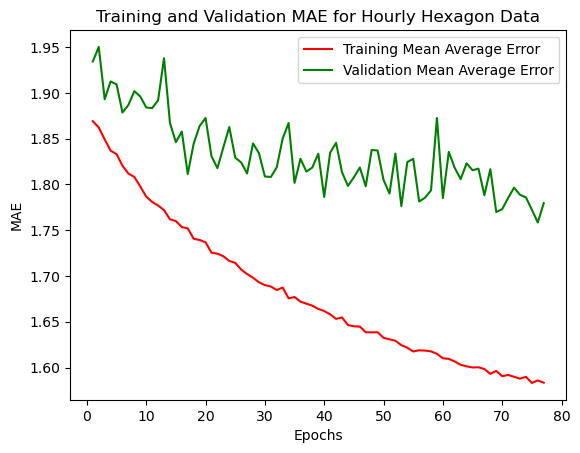

In [1066]:
mae_hh_noDrop = history_hh.history['mae']
val_mae_hh_noDrop = history_hh.history['val_mae']

epochs = range(1, len(mae_hh_noDrop) + 1)

plt.plot(epochs, mae_hh_noDrop, '-', c='red', label='Training Mean Average Error')
plt.plot(epochs, val_mae_hh_noDrop, '-', c='green', label='Validation Mean Average Error')
plt.title('Training and Validation MAE for Hourly Hexagon Data')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

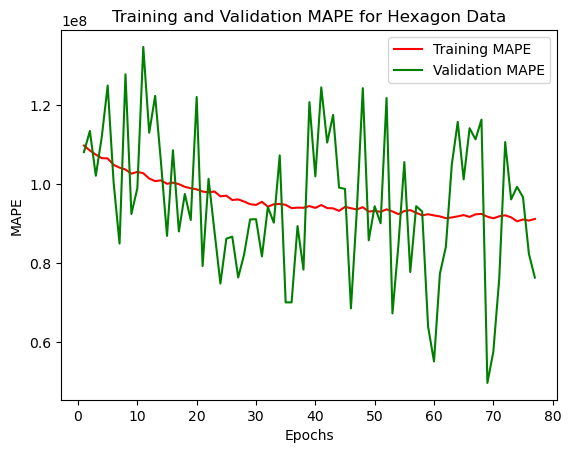

In [1067]:
mape_hh_noDrop = history_hh.history['mean_absolute_percentage_error']
val_mape_hh_noDrop = history_hh.history['val_mean_absolute_percentage_error']

epochs = range(1, len(mape_hh_noDrop) + 1)

plt.plot(epochs, mape_hh_noDrop, '-', c='red', label='Training MAPE')
plt.plot(epochs, val_mape_hh_noDrop, '-', c='green', label='Validation MAPE')
plt.title('Training and Validation MAPE for Hexagon Data')
plt.xlabel('Epochs')
plt.ylabel('MAPE')
plt.legend()
plt.show()

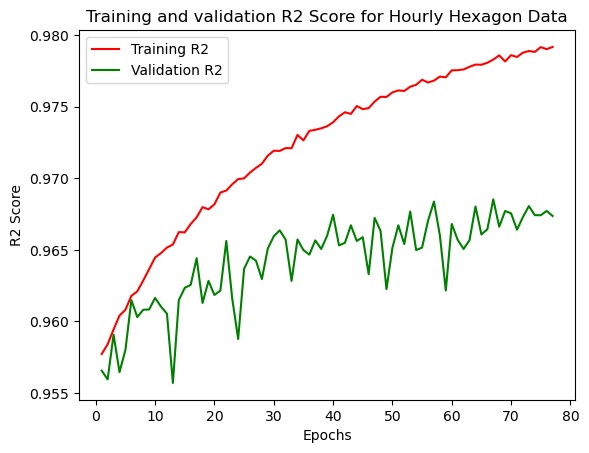

In [1068]:
r2_hh_noDrop = history_hh.history['r2_score']
val_r2_hh_noDrop = history_hh.history['val_r2_score']

epochs = range(1, len(r2_hh_noDrop) + 1)

plt.plot(epochs, r2_hh_noDrop, '-', c='red', label='Training R2')
plt.plot(epochs, val_r2_hh_noDrop, '-', c='green', label='Validation R2')
plt.title('Training and validation R2 Score for Hourly Hexagon Data')
plt.xlabel('Epochs')
plt.ylabel('R2 Score')
plt.legend()
plt.show()

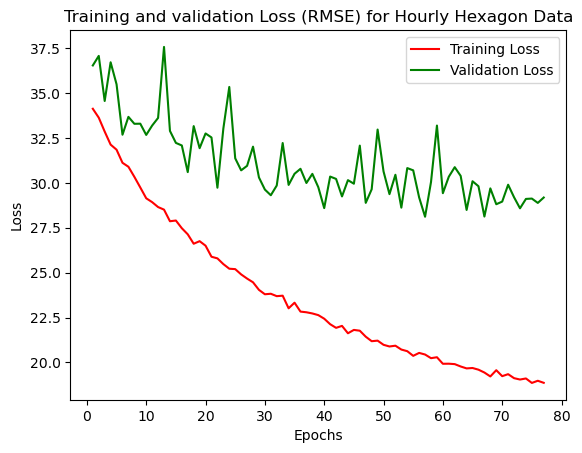

In [1069]:
loss_hh_noDrop = history_hh.history['loss']
val_loss_hh_noDrop = history_hh.history['val_loss']

epochs = range(1, len(loss_hh_noDrop) + 1)

plt.plot(epochs, loss_hh_noDrop, '-', c='red', label='Training Loss')
plt.plot(epochs, val_loss_hh_noDrop, '-', c='green', label='Validation Loss')
plt.title('Training and validation Loss (RMSE) for Hourly Hexagon Data')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [1070]:
hh_scores_noDrop = pd.DataFrame(
    {'loss': loss_hh_noDrop,
     'val_loss': val_loss_hh_noDrop,
     'mae': mae_hh_noDrop,
     'val_mae': val_mae_hh_noDrop,
     'mape': mape_hh_noDrop,
     'val_mape': val_mape_hh_noDrop,
     'r2': r2_hh_noDrop,
     'val_r2': val_r2_hh_noDrop
    })

hh_scores_noDrop['Model_trained']='/Users/awaischoudhry/AAA Project/full_models/trained_hh_noAvg_0810_rightAct_1.keras'

hh_scores_noDrop['Model_untrained']='/Users/awaischoudhry/AAA Project/full_models/untrained_hh_noAvg_0810_rightAct_1.keras'

hh_scores_noDrop['Hyperparameter']='hyperparameter_tuning/hh_noAvg_bayes_noDrop_rightStd_withValSet_rightAct_1'

hh_scores_noDrop.to_csv('/Users/awaischoudhry/AAA Project/history_hh_noAvg_noDrop_1.csv')

In [1071]:
hh_scores_noDrop

loss   val_loss       mae   val_mae         mape     val_mape  \
0   34.122871  36.534733  1.869190  1.934424  109838192.0  108169360.0   
1   33.627846  37.066116  1.862232  1.950311  108578352.0  113528440.0   
2   32.853424  34.556496  1.849296  1.893102  107537232.0  102192448.0   
3   32.127201  36.711288  1.836897  1.912569  106645520.0  111968968.0   
4   31.844543  35.484631  1.833219  1.909381  106573416.0  125037840.0   
..        ...        ...       ...       ...          ...          ...   
72  19.049929  28.581314  1.587854  1.788679   91655032.0   96194360.0   
73  19.108789  29.103712  1.589826  1.785946   90645488.0   99385464.0   
74  18.861036  29.123245  1.583182  1.772432   91118032.0   96753496.0   
75  18.981096  28.882055  1.585897  1.758481   90834144.0   82387048.0   
76  18.866793  29.181849  1.583440  1.779588   91252328.0   76390744.0   

          r2    val_r2                                      Model_trained  \
0   0.957723  0.956567  /Users/awaischoudhry/AAA Project/full_models/t...   
1   0.958404  0.955951  /Users/awaischoudhry/AAA Project/full_models/t...   
2   0.959438  0.959076  /Users/awaischoudhry/AAA Project/full_models/t...   
3   0.960410  0.956461  /Users/awaischoudhry/AAA Project/full_models/t...   
4   0.960810  0.958005  /Users/awaischoudhry/AAA Project/full_models/t...   
..       ...       ...                                                ...   
72  0.978883  0.968054  /Users/awaischoudhry/AAA Project/full_models/t...   
73  0.978820  0.967423  /Users/awaischoudhry/AAA Project/full_models/t...   
74  0.979154  0.967415  /Users/awaischoudhry/AAA Project/full_models/t...   
75  0.979013  0.967720  /Users/awaischoudhry/AAA Project/full_models/t...   
76  0.979169  0.967364  /Users/awaischoudhry/AAA Project/full_models/t...   

                                      Model_untrained  \
0   /Users/awaischoudhry/AAA Project/full_models/u...   
1   /Users/awaischoudhry/AAA Project/full_models/u...   
2   /Users/awaischoudhry/AAA Project/full_models/u...   
3   /Users/awaischoudhry/AAA Project/full_models/u...   
4   /Users/awaischoudhry/AAA Project/full_models/u...   
..                                                ...   
72  /Users/awaischoudhry/AAA Project/full_models/u...   
73  /Users/awaischoudhry/AAA Project/full_models/u...   
74  /Users/awaischoudhry/AAA Project/full_models/u...   
75  /Users/awaischoudhry/AAA Project/full_models/u...   
76  /Users/awaischoudhry/AAA Project/full_models/u...   

                                       Hyperparameter  
0   hyperparameter_tuning/hh_noAvg_bayes_noDrop_ri...  
1   hyperparameter_tuning/hh_noAvg_bayes_noDrop_ri...  
2   hyperparameter_tuning/hh_noAvg_bayes_noDrop_ri...  
3   hyperparameter_tuning/hh_noAvg_bayes_noDrop_ri...  
4   hyperparameter_tuning/hh_noAvg_bayes_noDrop_ri...  
..                                                ...  
72  hyperparameter_tuning/hh_noAvg_bayes_noDrop_ri...  
73  hyperparameter_tuning/hh_noAvg_bayes_noDrop_ri...  
74  hyperparameter_tuning/hh_noAvg_bayes_noDrop_ri...  
75  hyperparameter_tuning/hh_noAvg_bayes_noDrop_ri...  
76  hyperparameter_tuning/hh_noAvg_bayes_noDrop_ri...  

[77 rows x 11 columns]

### New Metrics

- test for potentially interesting metrics

In [147]:
best_model_hh_reload = ks.saving.load_model('/Users/awaischoudhry/AAA Project/full_models/untrained_hh_noAvg_0810_rightAct_1.keras', custom_objects=None, compile=True, safe_mode=True)

/opt/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [156]:
from tensorflow.keras.saving import register_keras_serializable

opt = ks.optimizers.Adam(
        learning_rate=0.001,
        beta_1=0.9,
        beta_2=0.999,
    )

@register_keras_serializable()
def smape(y_true, y_pred):
    """
    Berechnet den Symmetric Mean Absolute Percentage Error (sMAPE).

    Args:
    y_true -- Die tatsächlichen Werte.
    y_pred -- Die vorhergesagten Werte.

    Returns:
    Der sMAPE-Wert.
    """
    epsilon = K.epsilon()  # Kleine Konstante zur Vermeidung von Division durch Null
    numerator = K.abs(y_pred - y_true)
    denominator = K.abs(y_true) + K.abs(y_pred) + epsilon
    smape_value = 2 * K.mean(numerator / denominator)
    return smape_value

@register_keras_serializable()
def mase(y_true, y_pred):
    """
    Berechnet den Mean Absolute Scaled Error (MASE) basierend auf der Baseline-Vorhersage
    als Mittelwert der tatsächlichen Werte.

    Args:
    y_true -- Die tatsächlichen Werte.
    y_pred -- Die vorhergesagten Werte.

    Returns:
    Der MASE-Wert.
    """
    # Mittelwert der tatsächlichen Werte als Baseline-Vorhersage
    y_mean = K.mean(y_true)
    
    # MAE der Modellvorhersagen
    mae_model = K.mean(K.abs(y_true - y_pred))
    
    # MAE der Baseline-Vorhersagen (mittlerer absoluter Fehler der Mittelwertvorhersage)
    mae_baseline = K.mean(K.abs(y_true - y_mean))
    
    # MASE-Berechnung
    mase_value = mae_model / (mae_baseline + K.epsilon())  # epsilon zur Vermeidung von Division durch Null
    return mase_value


best_model_hh_reload.compile(optimizer=opt,  # Verwende den gleichen Optimizer wie im ursprünglichen Training
                   loss='mse',  # Verwende die gleiche Verlustfunktion
                   metrics=[ks.metrics.R2Score(),'mae',ks.metrics.MeanAbsolutePercentageError(),ks.metrics.MeanSquaredLogarithmicError(), smape, mase])

In [157]:
best_model_hh_reload.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 150)            │        22,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 110)            │        16,610 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 110)            │        12,210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           111 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,131 (199.73 KB)

 Trainable params: 51,131 (199.73 KB)

 Non-trainable params: 0 (0.00 B)

In [152]:
best_model_hh_reload.get_config()

{'name': 'sequential',
 'trainable': True,
 'dtype': {'module': 'keras',
  'class_name': 'DTypePolicy',
  'config': {'name': 'float32'},
  'registered_name': None},
 'layers': [{'module': 'keras.layers',
   'class_name': 'InputLayer',
   'config': {'batch_shape': (None, 147),
    'dtype': 'float32',
    'sparse': False,
    'name': 'input_layer'},
   'registered_name': None},
  {'module': 'keras.layers',
   'class_name': 'Dense',
   'config': {'name': 'dense',
    'trainable': True,
    'dtype': {'module': 'keras',
     'class_name': 'DTypePolicy',
     'config': {'name': 'float32'},
     'registered_name': None},
    'units': 150,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'module': 'keras.initializers',
     'class_name': 'GlorotUniform',
     'config': {'seed': None},
     'registered_name': None},
    'bias_initializer': {'module': 'keras.initializers',
     'class_name': 'Zeros',
     'config': {},
     'registered_name': None},
    'kernel_regulari

In [158]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False)

model_file_hh_nm = '/Users/awaischoudhry/AAA Project/weights/weights_hh_bayes_noAvg_0812_withValset_rightAct_newMetrics.keras'

checkpoint = tf.keras.callbacks.ModelCheckpoint(model_file_hh_nm, 
                    monitor="val_loss", mode="min", 
                    save_best_only=True, verbose=1)

In [159]:
history_hh_nm = best_model_hh_reload.fit(X_train_data_hh, y_train_data_hh, epochs=1000, validation_data=(X_val_data_hh,y_val_data_hh), callbacks=[stop_early, checkpoint])

Epoch 1/1000
11854/11898 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step - loss: 34.6687 - mae: 1.8794 - mase: 1.2323 - mean_absolute_percentage_error: 109111648.0000 - mean_squared_logarithmic_error: 0.1417 - r2_score: 0.9577 - smape: 1.3023
Epoch 1: val_loss improved from inf to 35.01142, saving model to /Users/awaischoudhry/AAA Project/weights/weights_hh_bayes_noAvg_0812_withValset_rightAct_newMetrics.keras
11898/11898 ━━━━━━━━━━━━━━━━━━━━ 8s 650us/step - loss: 34.6664 - mae: 1.8794 - mase: 1.2323 - mean_absolute_percentage_error: 109111520.0000 - mean_squared_logarithmic_error: 0.1417 - r2_score: 0.9577 - smape: 1.3023 - val_loss: 35.0114 - val_mae: 1.9065 - val_mase: 1.2278 - val_mean_absolute_percentage_error: 111996328.0000 - val_mean_squared_logarithmic_error: 0.1408 - val_r2_score: 0.9584 - val_smape: 1.3004
Epoch 2/1000
11811/11898 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step - loss: 32.5762 - mae: 1.8436 - mase: 1.2311 - mean_absolute_percentage_error: 107973712.0000 - mean_squared_logarithmic_err

In [160]:
best_model_hh_full_noDrop_reload = ks.saving.load_model(model_file_hh_nm, custom_objects=None, compile=True, safe_mode=True)

In [161]:
best_model_hh_full_noDrop_reload.save('/Users/awaischoudhry/AAA Project/full_models/trained_hh_noAvg_0812_rightAct_newMetrics.keras')

In [162]:
best_model_hh_full_noDrop_reload.evaluate(X_test_data_hh,y_test_data_hh)

3966/3966 ━━━━━━━━━━━━━━━━━━━━ 1s 292us/step - loss: 29.0715 - mae: 1.7653 - mase: 1.2256 - mean_absolute_percentage_error: 78395096.0000 - mean_squared_logarithmic_error: 0.1390 - r2_score: 0.9675 - smape: 1.3099


[27.820154190063477,
 0.9673048257827759,
 1.7420791387557983,
 77590616.0,
 0.13874374330043793,
 1.3089407682418823,
 1.2261792421340942]

In [164]:
hh_scores_noDrop_nm = pd.DataFrame(
    {'loss': history_hh_nm.history['loss'],
     'val_loss': history_hh_nm.history['val_loss'],
     'mae': history_hh_nm.history['mae'],
     'val_mae': history_hh_nm.history['val_mae'],
     'mape': history_hh_nm.history['mean_absolute_percentage_error'],
     'val_mape': history_hh_nm.history['val_mean_absolute_percentage_error'],
     'r2': history_hh_nm.history['r2_score'],
     'val_r2': history_hh_nm.history['val_r2_score'],
     'mase': history_hh_nm.history['mase'],
     'val_mase': history_hh_nm.history['val_mase'],
     'msle': history_hh_nm.history['mean_squared_logarithmic_error'],
     'val_msle': history_hh_nm.history['val_mean_squared_logarithmic_error'],
     'smape': history_hh_nm.history['smape'],
     'val_smape': history_hh_nm.history['val_smape']
    })

hh_scores_noDrop_nm['Model_trained']='/Users/awaischoudhry/AAA Project/full_models/trained_hh_noAvg_0812_rightAct_newMetrics.keras'

hh_scores_noDrop_nm['Model_untrained']='/Users/awaischoudhry/AAA Project/full_models/untrained_hh_noAvg_0810_rightAct_1.keras'

#hh_scores_noDrop['Hyperparameter']='hyperparameter_tuning/hh_withAvg_bayes_noDrop_rightStd_YStd_reluAct_1'

hh_scores_noDrop_nm.to_csv('/Users/awaischoudhry/AAA Project/history_hh_noAvg_noDrop_newMetrics_1.csv')

# Graphs

In [489]:
hh_nm = pd.read_csv('/Users/awaischoudhry/AAA Project/history_hh_noAvg_noDrop_newMetrics_1.csv')

hh_nm.tail()

Unnamed: 0       loss   val_loss       mae   val_mae        mape  \
84          84  18.191278  30.131409  1.567260  1.798242  91307752.0   
85          85  17.803045  29.082996  1.561097  1.782827  92097552.0   
86          86  18.141626  27.805960  1.563957  1.743670  91926088.0   
87          87  17.954880  29.824137  1.559465  1.786479  91916336.0   
88          88  17.942234  28.937773  1.559694  1.777428  91201064.0   

       val_mape        r2    val_r2        mase  val_mase      msle  val_msle  \
84  106848680.0  0.980186  0.966336  569.295898  1.233554  0.139484  0.143942   
85   73389216.0  0.980696  0.967640    1.229207  1.246821  0.139775  0.142256   
86   86584408.0  0.980274  0.969223    1.228950  1.213845  0.139095  0.137591   
87   77013528.0  0.980527  0.966748    1.228437  1.248166  0.138775  0.140789   
88   95351192.0  0.980554  0.967854    1.229299  1.233650  0.138941  0.141346   

       smape  val_smape                                      Model_trained  \
84  1.304169   1.294470  /Users/awaischoudhry/AAA Project/full_models/t...   
85  1.303879   1.317183  /Users/awaischoudhry/AAA Project/full_models/t...   
86  1.304146   1.302643  /Users/awaischoudhry/AAA Project/full_models/t...   
87  1.303073   1.314214  /Users/awaischoudhry/AAA Project/full_models/t...   
88  1.303640   1.305123  /Users/awaischoudhry/AAA Project/full_models/t...   

                                      Model_untrained  
84  /Users/awaischoudhry/AAA Project/full_models/u...  
85  /Users/awaischoudhry/AAA Project/full_models/u...  
86  /Users/awaischoudhry/AAA Project/full_models/u...  
87  /Users/awaischoudhry/AAA Project/full_models/u...  
88  /Users/awaischoudhry/AAA Project/full_models/u...

In [490]:
hc_nm = pd.read_csv('/Users/awaischoudhry/AAA Project/history_hc_noAvg_noDrop_newMetrics_1.csv')

hc_nm.tail()

Unnamed: 0       loss   val_loss       mae   val_mae       mape  \
78          78  23.346733  42.166359  2.357398  2.868757  50.345924   
79          79  23.154619  41.682209  2.350327  2.808822  50.354393   
80          80  23.061346  42.226528  2.350538  2.818239  50.324043   
81          81  23.059387  44.112690  2.350464  2.872748  50.358433   
82          82  23.063307  42.266678  2.348008  2.843740  50.351063   

     val_mape        r2    val_r2      mase  val_mase      msle  val_msle  \
78  53.200161  0.969629  0.939916  1.230884  1.246270  0.136410  0.149785   
79  50.137295  0.969958  0.940699  1.230350  1.219548  0.136683  0.146265   
80  49.975609  0.970122  0.939853  1.231599  1.213109  0.136467  0.144921   
81  50.983326  0.970145  0.936877  1.230857  1.254742  0.136577  0.147671   
82  51.265293  0.970158  0.939833  1.231046  1.238673  0.136425  0.148341   

       smape  val_smape                                      Model_trained  \
78  0.984081   0.976939  /Users/awaischoudhry/AAA Project/full_models/t...   
79  0.984192   0.988802  /Users/awaischoudhry/AAA Project/full_models/t...   
80  0.984316   0.980042  /Users/awaischoudhry/AAA Project/full_models/t...   
81  0.984446   0.986127  /Users/awaischoudhry/AAA Project/full_models/t...   
82  0.984296   0.983808  /Users/awaischoudhry/AAA Project/full_models/t...   

                                      Model_untrained  
78  /Users/awaischoudhry/AAA Project/full_models/u...  
79  /Users/awaischoudhry/AAA Project/full_models/u...  
80  /Users/awaischoudhry/AAA Project/full_models/u...  
81  /Users/awaischoudhry/AAA Project/full_models/u...  
82  /Users/awaischoudhry/AAA Project/full_models/u...

In [491]:
dh_nm = pd.read_csv('/Users/awaischoudhry/AAA Project/history_dh_noAvg_noDrop_newMetrics_1.csv')

dh_nm.tail()

Unnamed: 0         loss     val_loss        mae    val_mae        mape  \
75          75  4988.223633  7174.046875  20.931505  24.822960  2698921.50   
76          76  4982.009766  7544.942383  21.306362  25.167210  2724146.00   
77          77  4981.823730  7690.041016  21.118156  25.194735  3366835.75   
78          78  4962.935547  7075.457520  21.084177  24.698746  2412695.75   
79          79  4867.048340  8641.650391  21.137417  26.523161  1636822.75   

        val_mape        r2    val_r2      mase  val_mase      msle  val_msle  \
75  8.661721e+05  0.975899  0.965395  1.240927  1.238905  1.432982  1.650045   
76  1.546114e+06  0.975929  0.963604  1.239372  1.246579  1.498209  1.763113   
77  5.544514e+06  0.975931  0.962903  1.235110  1.260388  1.471604  1.593460   
78  2.948763e+06  0.976022  0.965872  1.238372  1.256157  1.478018  1.570165   
79  9.199667e+06  0.976486  0.958307  1.237337  1.279950  1.509050  1.394774   

       smape  val_smape                                      Model_trained  \
75  1.508733   1.530436  /Users/awaischoudhry/AAA Project/full_models/t...   
76  1.515867   1.543565  /Users/awaischoudhry/AAA Project/full_models/t...   
77  1.513998   1.526112  /Users/awaischoudhry/AAA Project/full_models/t...   
78  1.514130   1.525650  /Users/awaischoudhry/AAA Project/full_models/t...   
79  1.516986   1.504557  /Users/awaischoudhry/AAA Project/full_models/t...   

                                      Model_untrained  
75  /Users/awaischoudhry/AAA Project/full_models/u...  
76  /Users/awaischoudhry/AAA Project/full_models/u...  
77  /Users/awaischoudhry/AAA Project/full_models/u...  
78  /Users/awaischoudhry/AAA Project/full_models/u...  
79  /Users/awaischoudhry/AAA Project/full_models/u...

In [492]:
dc_nm = pd.read_csv('/Users/awaischoudhry/AAA Project/history_dc_noAvg_noDrop_newMetrics_1.csv')

dc_nm.tail()

Unnamed: 0         loss      val_loss        mae    val_mae       mape  \
19          19  3684.608154   5184.218750  18.233526  23.297127  59.254139   
20          20  3720.606689   5699.971680  18.230947  22.932163  58.867500   
21          21  3528.765137   5254.011719  17.692377  22.760433  57.164272   
22          22  3437.329102   5528.364258  17.679268  23.155272  57.231274   
23          23  3281.213867  12125.064453  17.555786  27.462793  57.073761   

      val_mape        r2    val_r2      mase  val_mase      msle  val_msle  \
19  109.014740  0.968340  0.955445  1.222101  1.214146  0.275361  0.388551   
20   80.369545  0.968030  0.951010  1.225026  1.213458  0.281954  0.512428   
21   86.973770  0.969681  0.954845  1.221863  1.184902  0.261875  0.347566   
22   85.552086  0.970467  0.952486  1.220803  1.231526  0.268771  0.373297   
23   93.269295  0.971810  0.895759  1.222668  1.270292  0.268825  0.372750   

       smape  val_smape                                      Model_trained  \
19  1.273304   1.236631  /Users/awaischoudhry/AAA Project/full_models/t...   
20  1.276492   1.344057  /Users/awaischoudhry/AAA Project/full_models/t...   
21  1.273328   1.247618  /Users/awaischoudhry/AAA Project/full_models/t...   
22  1.275752   1.281410  /Users/awaischoudhry/AAA Project/full_models/t...   
23  1.276571   1.262968  /Users/awaischoudhry/AAA Project/full_models/t...   

                                      Model_untrained  
19  /Users/awaischoudhry/AAA Project/full_models/u...  
20  /Users/awaischoudhry/AAA Project/full_models/u...  
21  /Users/awaischoudhry/AAA Project/full_models/u...  
22  /Users/awaischoudhry/AAA Project/full_models/u...  
23  /Users/awaischoudhry/AAA Project/full_models/u...

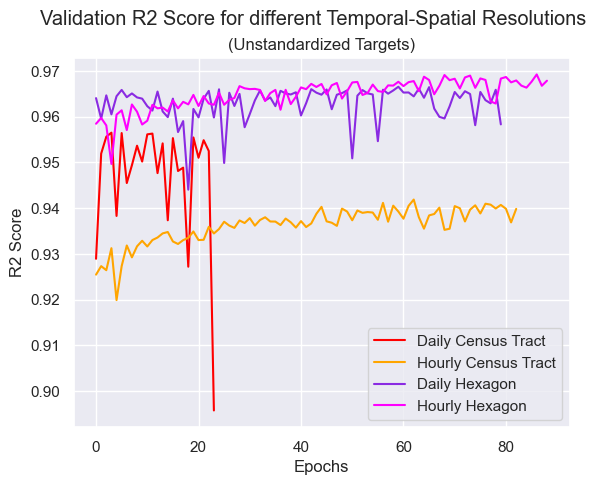

In [506]:
#epochs = range(1, max(len(dc_scores_noDrop),len(dh_scores_noDrop),len(hc_scores_noDrop),len(hh_scores_noDrop)) + 1)

sns.set_theme(style="darkgrid")

fig, ax = plt.subplots()

ax.plot(dc_nm.index, dc_nm['val_r2'], '-', c='red', label='Daily Census Tract')
ax.plot(hc_nm.index, hc_nm['val_r2'], '-', c='orange', label='Hourly Census Tract')
ax.plot(dh_nm.index, dh_nm['val_r2'], '-', c='blueviolet', label='Daily Hexagon')
ax.plot(hh_nm.index, hh_nm['val_r2'], '-', c='magenta', label='Hourly Hexagon')
plt.suptitle('Validation R2 Score for different Temporal-Spatial Resolutions')
plt.title('(Unstandardized Targets)')
plt.xlabel('Epochs')
plt.ylabel('R2 Score')
plt.legend()
plt.show()

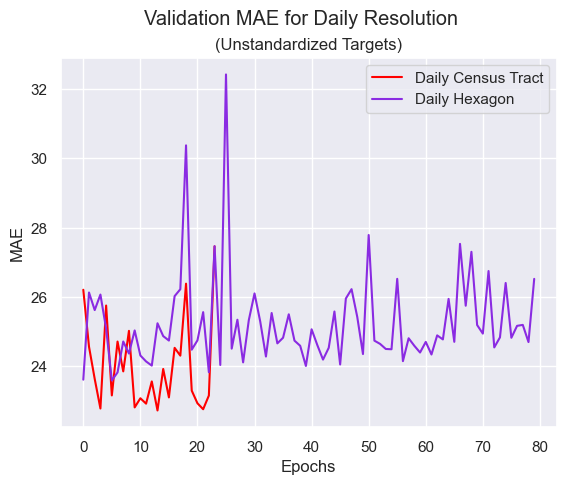

In [505]:
#epochs = range(1, max(len(dc_scores_noDrop),len(dh_scores_noDrop),len(hc_scores_noDrop),len(hh_scores_noDrop)) + 1)

sns.set_theme(style="darkgrid")

fig, ax = plt.subplots()

ax.plot(dc_nm.index, dc_nm['val_mae'], '-', c='red', label='Daily Census Tract')
ax.plot(dh_nm.index, dh_nm['val_mae'], '-', c='blueviolet', label='Daily Hexagon')
plt.suptitle('Validation MAE for Daily Resolution')
plt.title('(Unstandardized Targets)')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

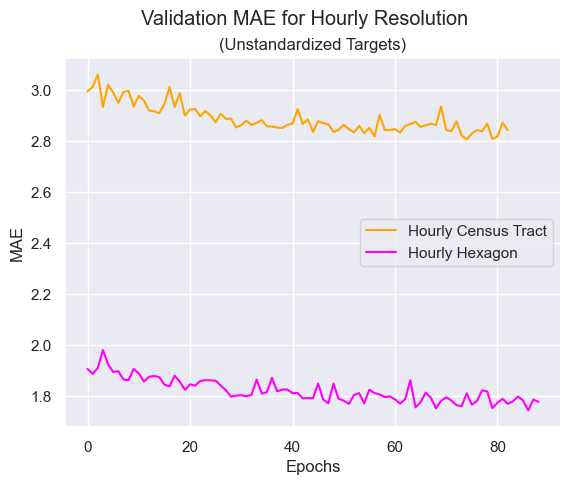

In [504]:
#epochs = range(1, max(len(dc_scores_noDrop),len(dh_scores_noDrop),len(hc_scores_noDrop),len(hh_scores_noDrop)) + 1)

sns.set_theme(style="darkgrid")

fig, ax = plt.subplots()

ax.plot(hc_nm.index, hc_nm['val_mae'], '-', c='orange', label='Hourly Census Tract')
ax.plot(hh_nm.index, hh_nm['val_mae'], '-', c='magenta', label='Hourly Hexagon')
plt.suptitle('Validation MAE for Hourly Resolution')
plt.title('(Unstandardized Targets)')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

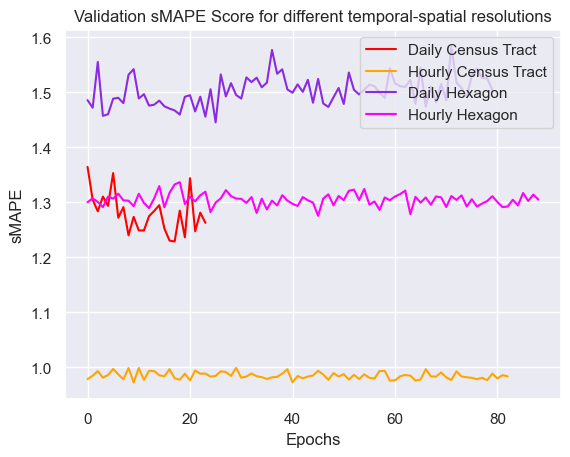

In [500]:
#epochs = range(1, max(len(dc_scores_noDrop),len(dh_scores_noDrop),len(hc_scores_noDrop),len(hh_scores_noDrop)) + 1)

sns.set_theme(style="darkgrid")

fig, ax = plt.subplots()

ax.plot(dc_nm.index, dc_nm['val_smape'], '-', c='red', label='Daily Census Tract')
ax.plot(hc_nm.index, hc_nm['val_smape'], '-', c='orange', label='Hourly Census Tract')
ax.plot(dh_nm.index, dh_nm['val_smape'], '-', c='blueviolet', label='Daily Hexagon')
ax.plot(hh_nm.index, hh_nm['val_smape'], '-', c='magenta', label='Hourly Hexagon')
plt.title('Validation sMAPE Score for different temporal-spatial resolutions')
plt.xlabel('Epochs')
plt.ylabel('sMAPE')
plt.legend()
plt.show()

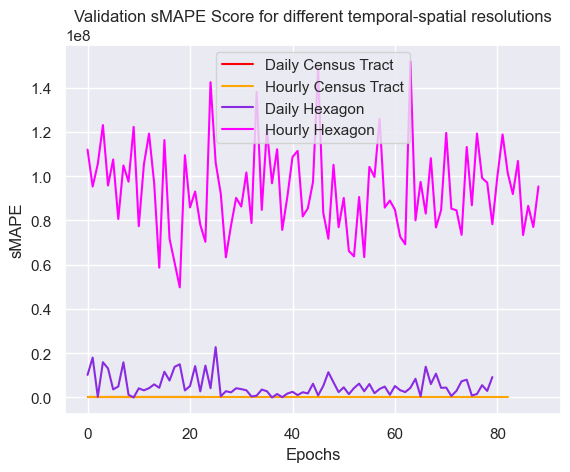

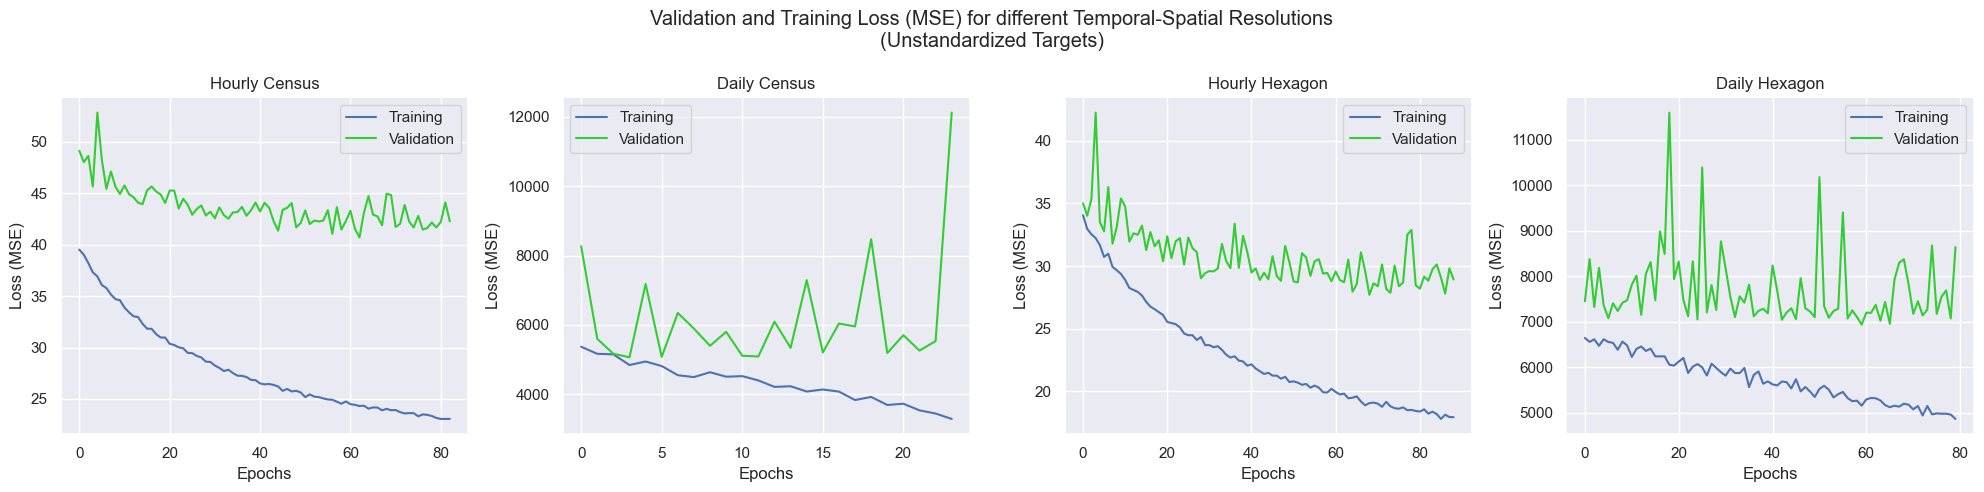

In [512]:
# Erstelle eine Figur mit 4 nebeneinander liegenden Subplots
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# Plot für den ersten DataFrame
axs[0].plot(hc_nm.index, hc_nm['loss'], '-', label='Training')
axs[0].plot(hc_nm.index, hc_nm['val_loss'], label='Validation', color='limegreen')
axs[0].set_title('Hourly Census')
axs[0].legend()

# Plot für den zweiten DataFrame
axs[1].plot(dc_nm.index, dc_nm['loss'], label='Training')
axs[1].plot(dc_nm.index, dc_nm['val_loss'], label='Validation', color='limegreen')
axs[1].set_title('Daily Census')
axs[1].legend()

# Plot für den dritten DataFrame
axs[2].plot(hh_nm.index, hh_nm['loss'], label='Training')
axs[2].plot(hh_nm.index, hh_nm['val_loss'], label='Validation', color='limegreen')
axs[2].set_title('Hourly Hexagon')
axs[2].legend()

# Plot für den vierten DataFrame
axs[3].plot(dh_nm.index, dh_nm['loss'], label='Training')
axs[3].plot(dh_nm.index, dh_nm['val_loss'], label='Validation', color='limegreen')
axs[3].set_title('Daily Hexagon')
axs[3].legend()

# Labels für gemeinsame Achsen (optional)
for ax in axs:
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss (MSE)')

plt.suptitle('Validation and Training Loss (MSE) for different Temporal-Spatial Resolutions\n(Unstandardized Targets)')

# Passe das Layout an
plt.tight_layout()

# Zeige das Diagramm
plt.show()
